# Image + Text only Branches
<style>
h2: color:blue;
</style>

### Here we are only testing the image only, text only 2D, and text only 1D

# Section 0: Import modules, set variables, load functions 

In [5]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
from keras import backend as K
from sklearn.metrics import confusion_matrix    
from sklearn import metrics
from keras.models import Model
from keras.layers import Dense, Reshape, concatenate, Lambda, Average, Maximum, Add, Multiply, Concatenate, BatchNormalization, Activation
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.layers.embeddings import Embedding
from keras.engine.input_layer import Input
from keras.optimizers import Adam
from utils import *
from keras.activations import relu
from sklearn.model_selection import StratifiedKFold
import random
import dill
import matplotlib.pyplot as plt
from scipy import ndimage
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from PIL import Image
import io
from keras.utils.training_utils import multi_gpu_model
import tensorflow as tf

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
from keras import backend as K
print(K.tensorflow_backend._get_available_gpus())
G = len(K.tensorflow_backend._get_available_gpus())

['/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1']


In [7]:
SRC = 'PMC'

if SRC=='PMC':
    CLASSES = {0: 'bar', 1: 'gel', 2: 'map', 3: 'network', 4: 'plot',
             5: 'text', 6: 'box', 7: 'heatmap',8: 'medical', 9: 'nxmls', 10: 'screenshot',
             11: 'topology', 12: 'diagram', 13: 'histology', 14: 'microscopy',
             15: 'photo', 16: 'sequence', 17: 'tree', 18: 'fluorescence', 19: 'line',
             20: 'molecular', 21: 'pie', 22: 'table'}
    
    class_names = ['bar', 'gel', 'network', 'plot', 'histology', 'sequence',
                               'line', 'molecular']
else:
    class_names = ['cat','dog']
num_class = len(class_names)
NN_Class_Names = dict(enumerate(class_names))
test_size = 0.2
epochs = 150
bs = 128
#Set parameters
create_word_vec = False
w2v_epochs = 20
w2v_window_size=5
w2v_filters=''
seed = 0
max_text_len = 200
vocabulary_size = 10000
csv_fname = 'image_list.csv'
coco_loc = '/home/kevin/Documents/Lab/coco_dataset'
pmc_loc = '/gpfs/ysm/pi/krauthammer/kl533/'
filters = ''
use_glove = False
LOAD_IMG_MODEL_WEIGHTS = False
LOAD_TXT_MODEL_WEIGHTS = False
CHANNELS = 3#should be either 3 or 1 for the number of channels
shape = (100,100,CHANNELS)#image shape
embedding_output_dim = 100
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)
early_stopping = EarlyStopping(monitor='loss', min_delta=0, patience=10, verbose=0, mode='auto', baseline=None)
nltk.download('punkt')
nltk.download('stopwords')
plt.rcParams["figure.dpi"] = 600
n_splits=5

[nltk_data] Downloading package punkt to /home/kl533/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/kl533/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Section 1: Initalize variables and load data

In [8]:
# Load our data from source

print('Getting Data')
if SRC == 'PMC':
    image_classes = [list(CLASSES.keys())[list(CLASSES.values()).index(x)] for 
                 x in class_names]  
    data = load_PMC(csv_fname, image_classes, uniform=True)
    #dynamically add location of files
    data['location'] = pmc_loc + data['location'].astype(str)
else:
    data = load_COCO(coco_loc, class_names=class_names)

Getting Data


## Optional: Create embeddings

In [9]:
#%%Section 0.5 create embeddings - Optional
if create_word_vec:
    print('Section 0.5: create embeddings')
    from w2v_keras import w2v_keras
    w2v = w2v_keras(vocabulary_size=vocabulary_size, window_size=w2v_window_size, filters=w2v_filters, vector_dim = embedding_output_dim)
    w2v.fit(data['caption'], epochs=w2v_epochs)
    w2v.save_embeddings('w2v_embeddings.json')
else:
    print("Not creating embeddings")

Not creating embeddings


In [10]:
def Generate_Model(model_type = None):
    #set up our text input
    if model_type == "image":#image only
        image_input = Input(shape, name='image_input')
        x = get_img_branch()(image_input)
        x = Dense(1024, activation='relu', name='dense_layer1_image')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)        
        x = Dense(512, activation='relu', name='dense_layer2_image')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        output = Dense(num_class, activation='softmax', name='image_output')(x)
        classificationModel = Model(inputs=[image_input], outputs=[output])
    if model_type == "text_1d":#text_1d only
        input_text = Input(shape=(max_text_len,), name='text_input')
        embedding = Embedding(input_length=max_text_len, input_dim=vocabulary_size, output_dim=embedding_output_dim, 
                               name='embedding_layer', trainable=False, weights=[embedding_weights])
        embedded_text = embedding(input_text)
        x = get_text_branch()(embedded_text)
        x = Dense(1024, activation='relu', name='dense_layer1_text')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)        
        x = Dense(512, activation='relu', name='dense_layer2_text')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        output = Dense(num_class, activation='softmax', name='text_output')(x)
        classificationModel = Model(inputs=[input_text], outputs=[output])
    if model_type == "text_2d":
        input_text = Input(shape=(max_text_len,), name='text_input')
        embedding = Embedding(input_length=max_text_len, input_dim=vocabulary_size, output_dim=embedding_output_dim, 
                               name='embedding_layer', trainable=False, weights=[embedding_weights])
        embedded_text = embedding(input_text)
        #text_embedding = Reshape((max_text_len,shape[0],1))(embedded_text)
        text_embedding = Lambda(embedding_3Ch)(embedded_text)
        x = get_img_branch()(text_embedding)
        x = Dense(1024, activation='relu', name='dense_layer1')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)        
        x = Dense(512, activation='relu', name='dense_layer2')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        output = Dense(num_class, activation='softmax', name='text_output')(x)
        classificationModel = Model(inputs=[input_text], outputs=[output])
    if G > 1:
        classificationModel = get_multi_gpu_model(classificationModel, G)
    return classificationModel

# Section 2: K-Fold Validation

### Get data into format our model understands

In [11]:
#Get all data to kfoldsplit
X_text, X_image, y, tokenizer = get_model_data(data, seed=seed, test_size = test_size, 
                vocabulary_size = vocabulary_size, filters = filters, 
                max_text_len=max_text_len, shape=shape, split=True)
X_text = np.array(X_text)#need to fix this!!!!!!!!!!!!!!!!!!!!!!!!!!!

filtering sentences
filtering sents and removing stopwords
filtering sentences
filtering sents and removing stopwords


/home/kl533/.local/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


### Load our word embeddings

In [12]:
#%% Section 1.5: Load word embeddings
if use_glove:
    embedding_weights = load_glove('/home/kevin/Downloads', 
                        take(vocabulary_size, tokenizer.word_index.items()))
elif create_word_vec:#get weights from w2v model directly if trained.
    embedding_weights = mapTokensToEmbedding(w2v.get_embeddings(), 
                                             tokenizer.word_index, vocabulary_size)
else:
    #load embedding weights from file
    location = 'w2v_embeddings.json'
    import json
    with open(location) as f:
        embs = json.load(f)
        emb = json.loads(embs)
    embedding_weights = mapTokensToEmbedding(emb, tokenizer.word_index, 
                                             vocabulary_size)

## Lets visualize our models:

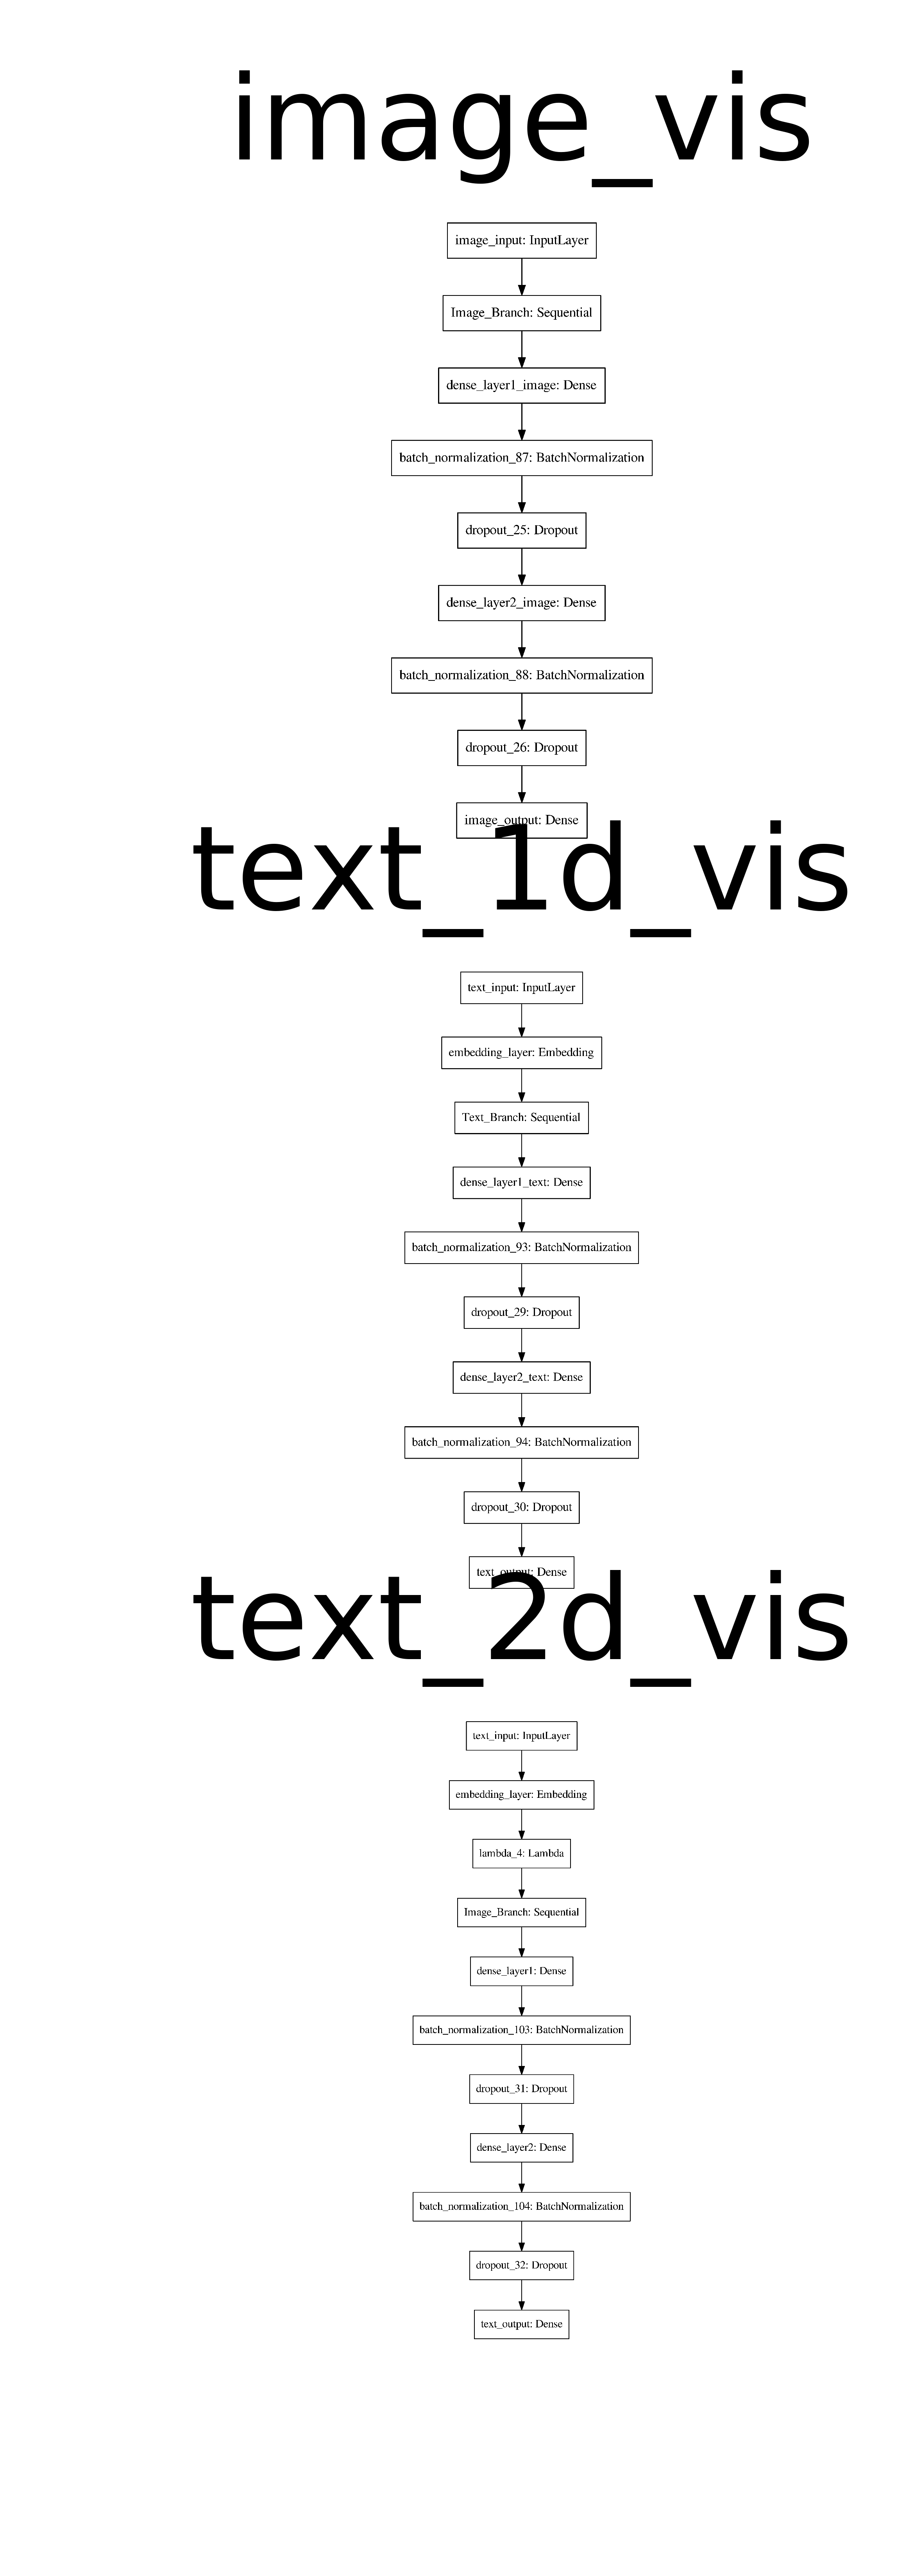

In [16]:
G_bak = G
G = 1
image_vis = Generate_Model(model_type = "image")
text_1d_vis = Generate_Model(model_type = 'text_1d')
text_2d_vis = Generate_Model(model_type = 'text_2d')

G = G_bak
base_model_list = {'image_vis': image_vis, 
                   'text_1d_vis': text_1d_vis,
                  'text_2d_vis' : text_2d_vis}
plt.rcParams["figure.dpi"] = 1800


fig,ax = plt.subplots(len(base_model_list),1)
for i, (name,model) in enumerate(base_model_list.items()):
    x = model_to_dot(model)
    x.set_dpi(600)
    x = x.create(prog='dot', format='png')
    x_ = plt.imread(io.BytesIO(x))
    #x_ = ndimage.rotate(x_, 0)
    ax[i].imshow(x_)
    ax[i].axis("off")
    ax[i].set_title(name)

### Generate our K-Folds and save them to be used by other files

In [10]:
kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
folds = {}
count = 1
for train, test in kfold.split(np.zeros(len(y)), y.argmax(1)):
    random.shuffle(train)
    folds['fold_{}'.format(count)] = {}
    folds['fold_{}'.format(count)]['train'.format(count)] = train.tolist()
    folds['fold_{}'.format(count)]['test'.format(count)] = test.tolist()
    count += 1
print(len(folds) == n_splits)#assert we have the same number of splits
#dump folds to json
import json
with open('folds.json', 'w') as fp:
    json.dump(folds, fp)


True


In [11]:
#load to dict to be used
with open('folds.json') as f:
    kfolds = json.load(f)
print(kfolds == folds)

True


### K fold validation on images only

fold_1
K-: fold_1
Samples from Training
[ 193 2405  830 1032]


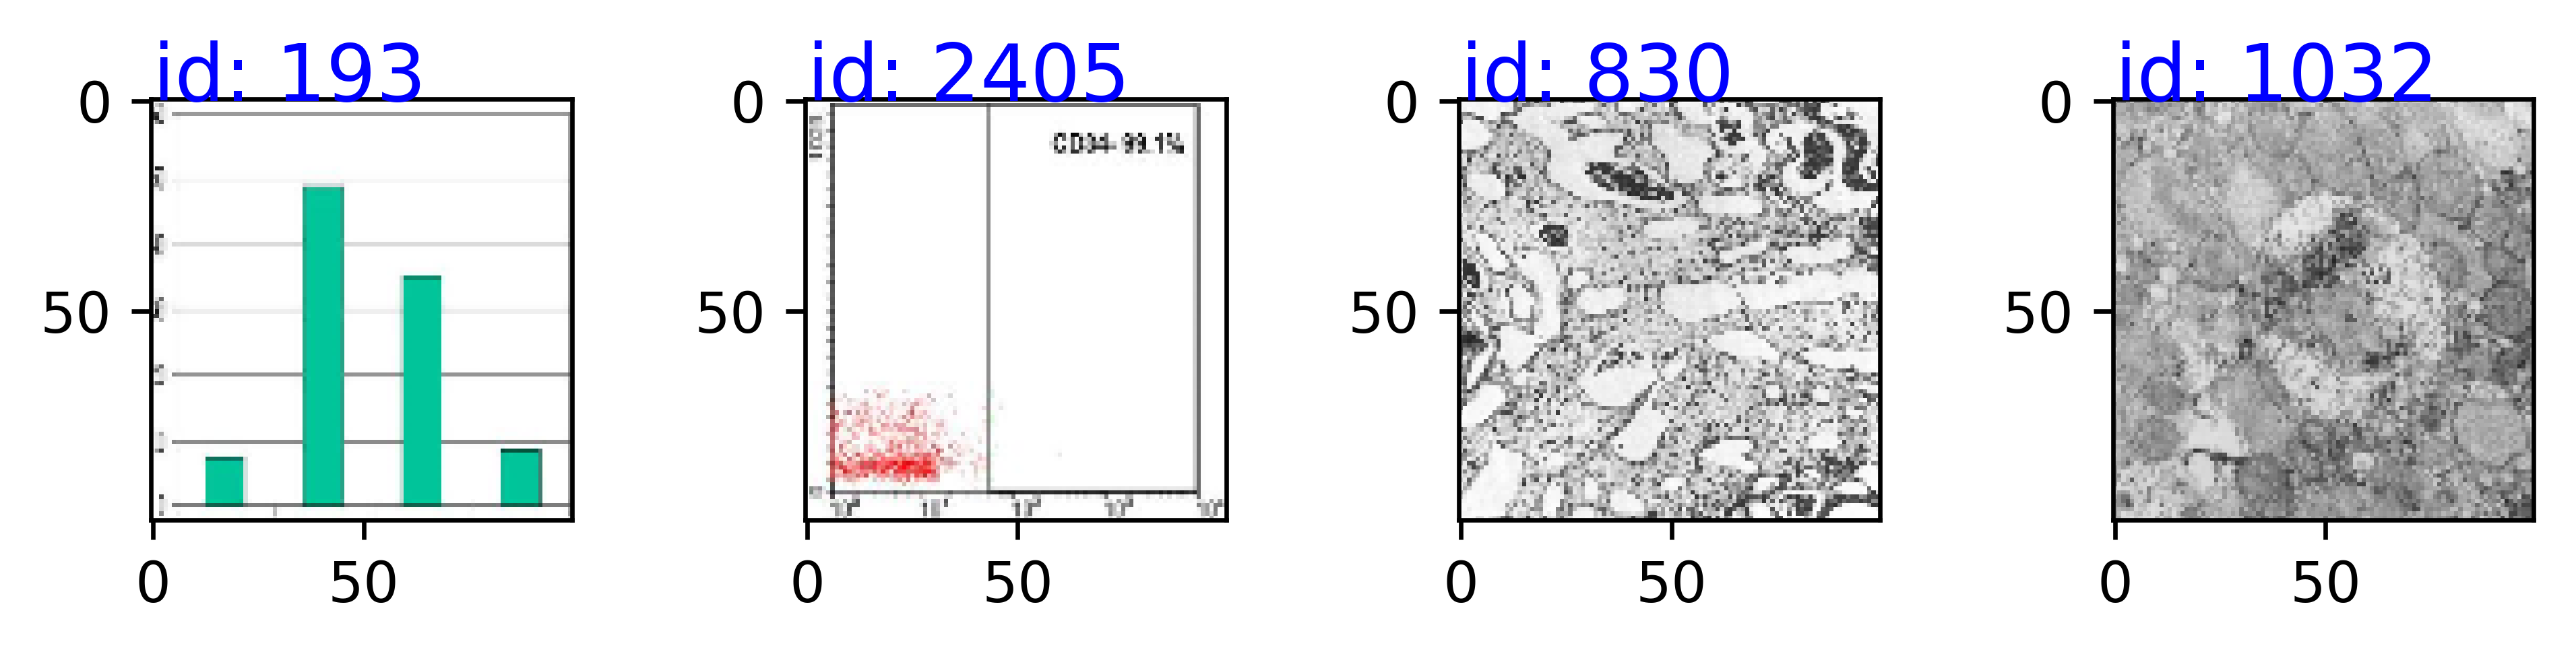

Samples from Testing
[   1    5 3139 3143]


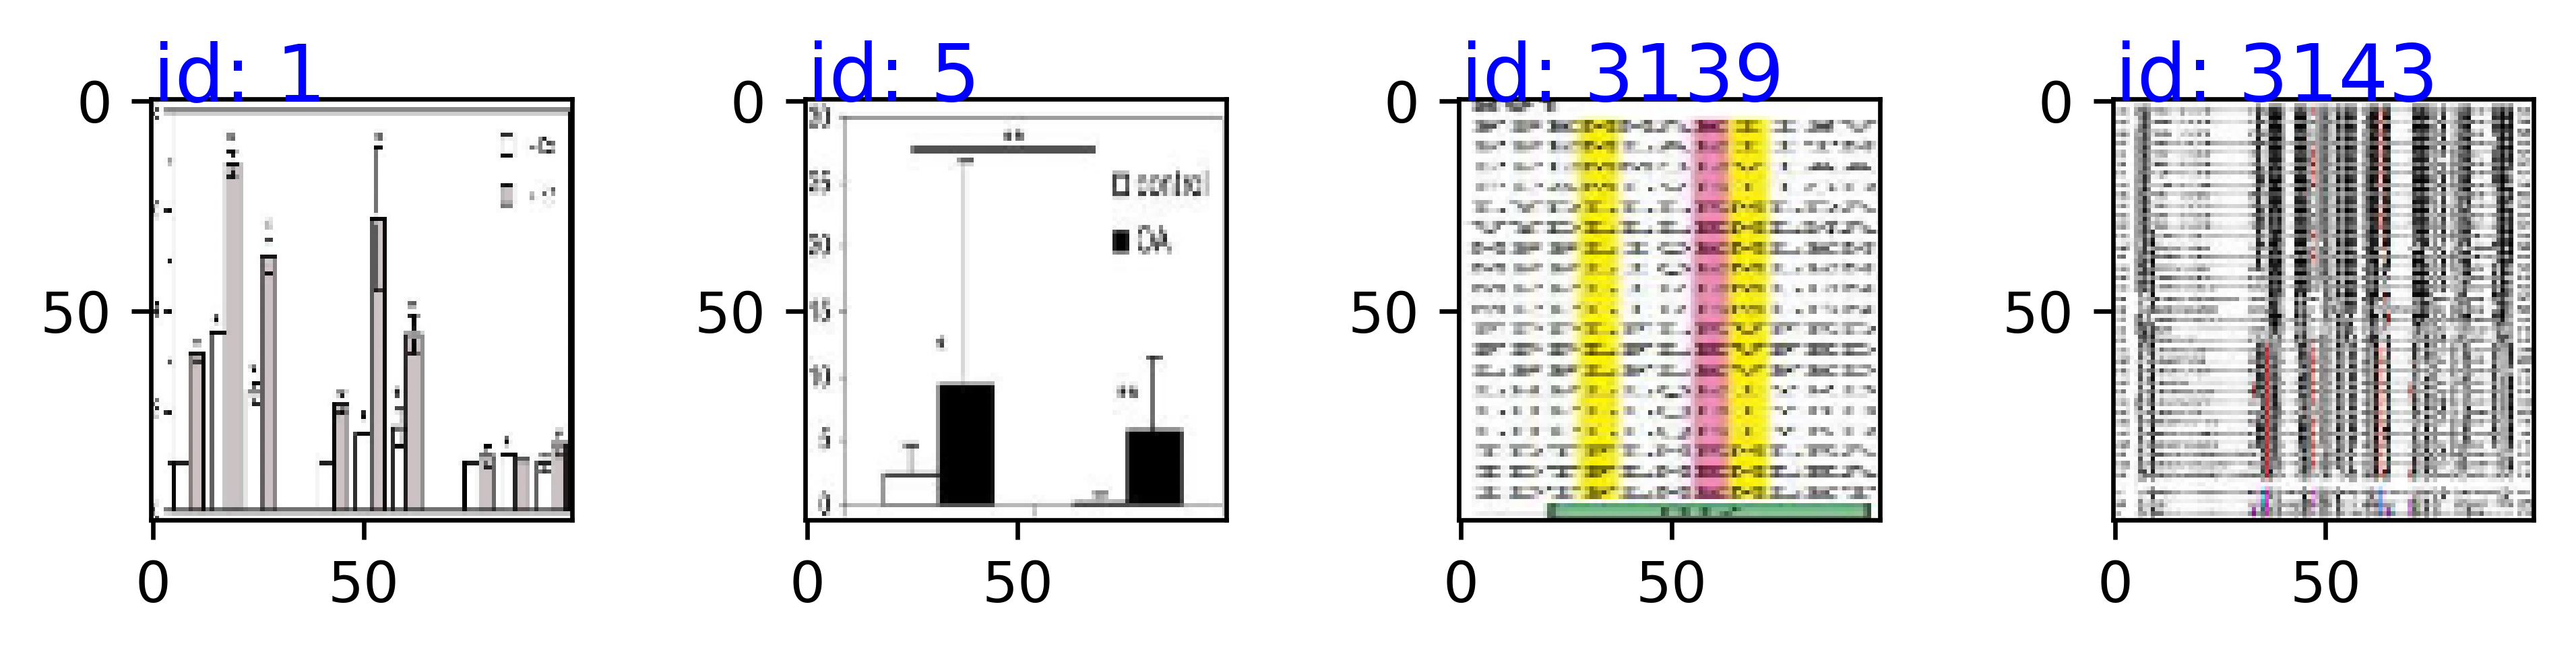

Train on 2260 samples, validate on 252 samples
Epoch 1/150
2260/2260 [==============================] - 10s 4ms/step - loss: 2.3242 - acc: 0.3611 - val_loss: 3.5455 - val_acc: 0.3968

Epoch 00001: val_acc improved from -inf to 0.39683, saving model to unimodal_weights/best_weight_image_only_k-fold_1.hdf5
Epoch 2/150
2260/2260 [==============================] - 4s 2ms/step - loss: 1.5723 - acc: 0.5142 - val_loss: 1.8268 - val_acc: 0.5119

Epoch 00002: val_acc improved from 0.39683 to 0.51190, saving model to unimodal_weights/best_weight_image_only_k-fold_1.hdf5
Epoch 3/150
2260/2260 [==============================] - 4s 2ms/step - loss: 1.2460 - acc: 0.5898 - val_loss: 1.7890 - val_acc: 0.5437

Epoch 00003: val_acc improved from 0.51190 to 0.54365, saving model to unimodal_weights/best_weight_image_only_k-fold_1.hdf5
Epoch 4/150
2260/2260 [==============================] - 4s 2ms/step - loss: 1.0617 - acc: 0.6478 - val_loss: 1.7042 - val_acc: 0.6071

Epoch 00004: val_acc improved from 0

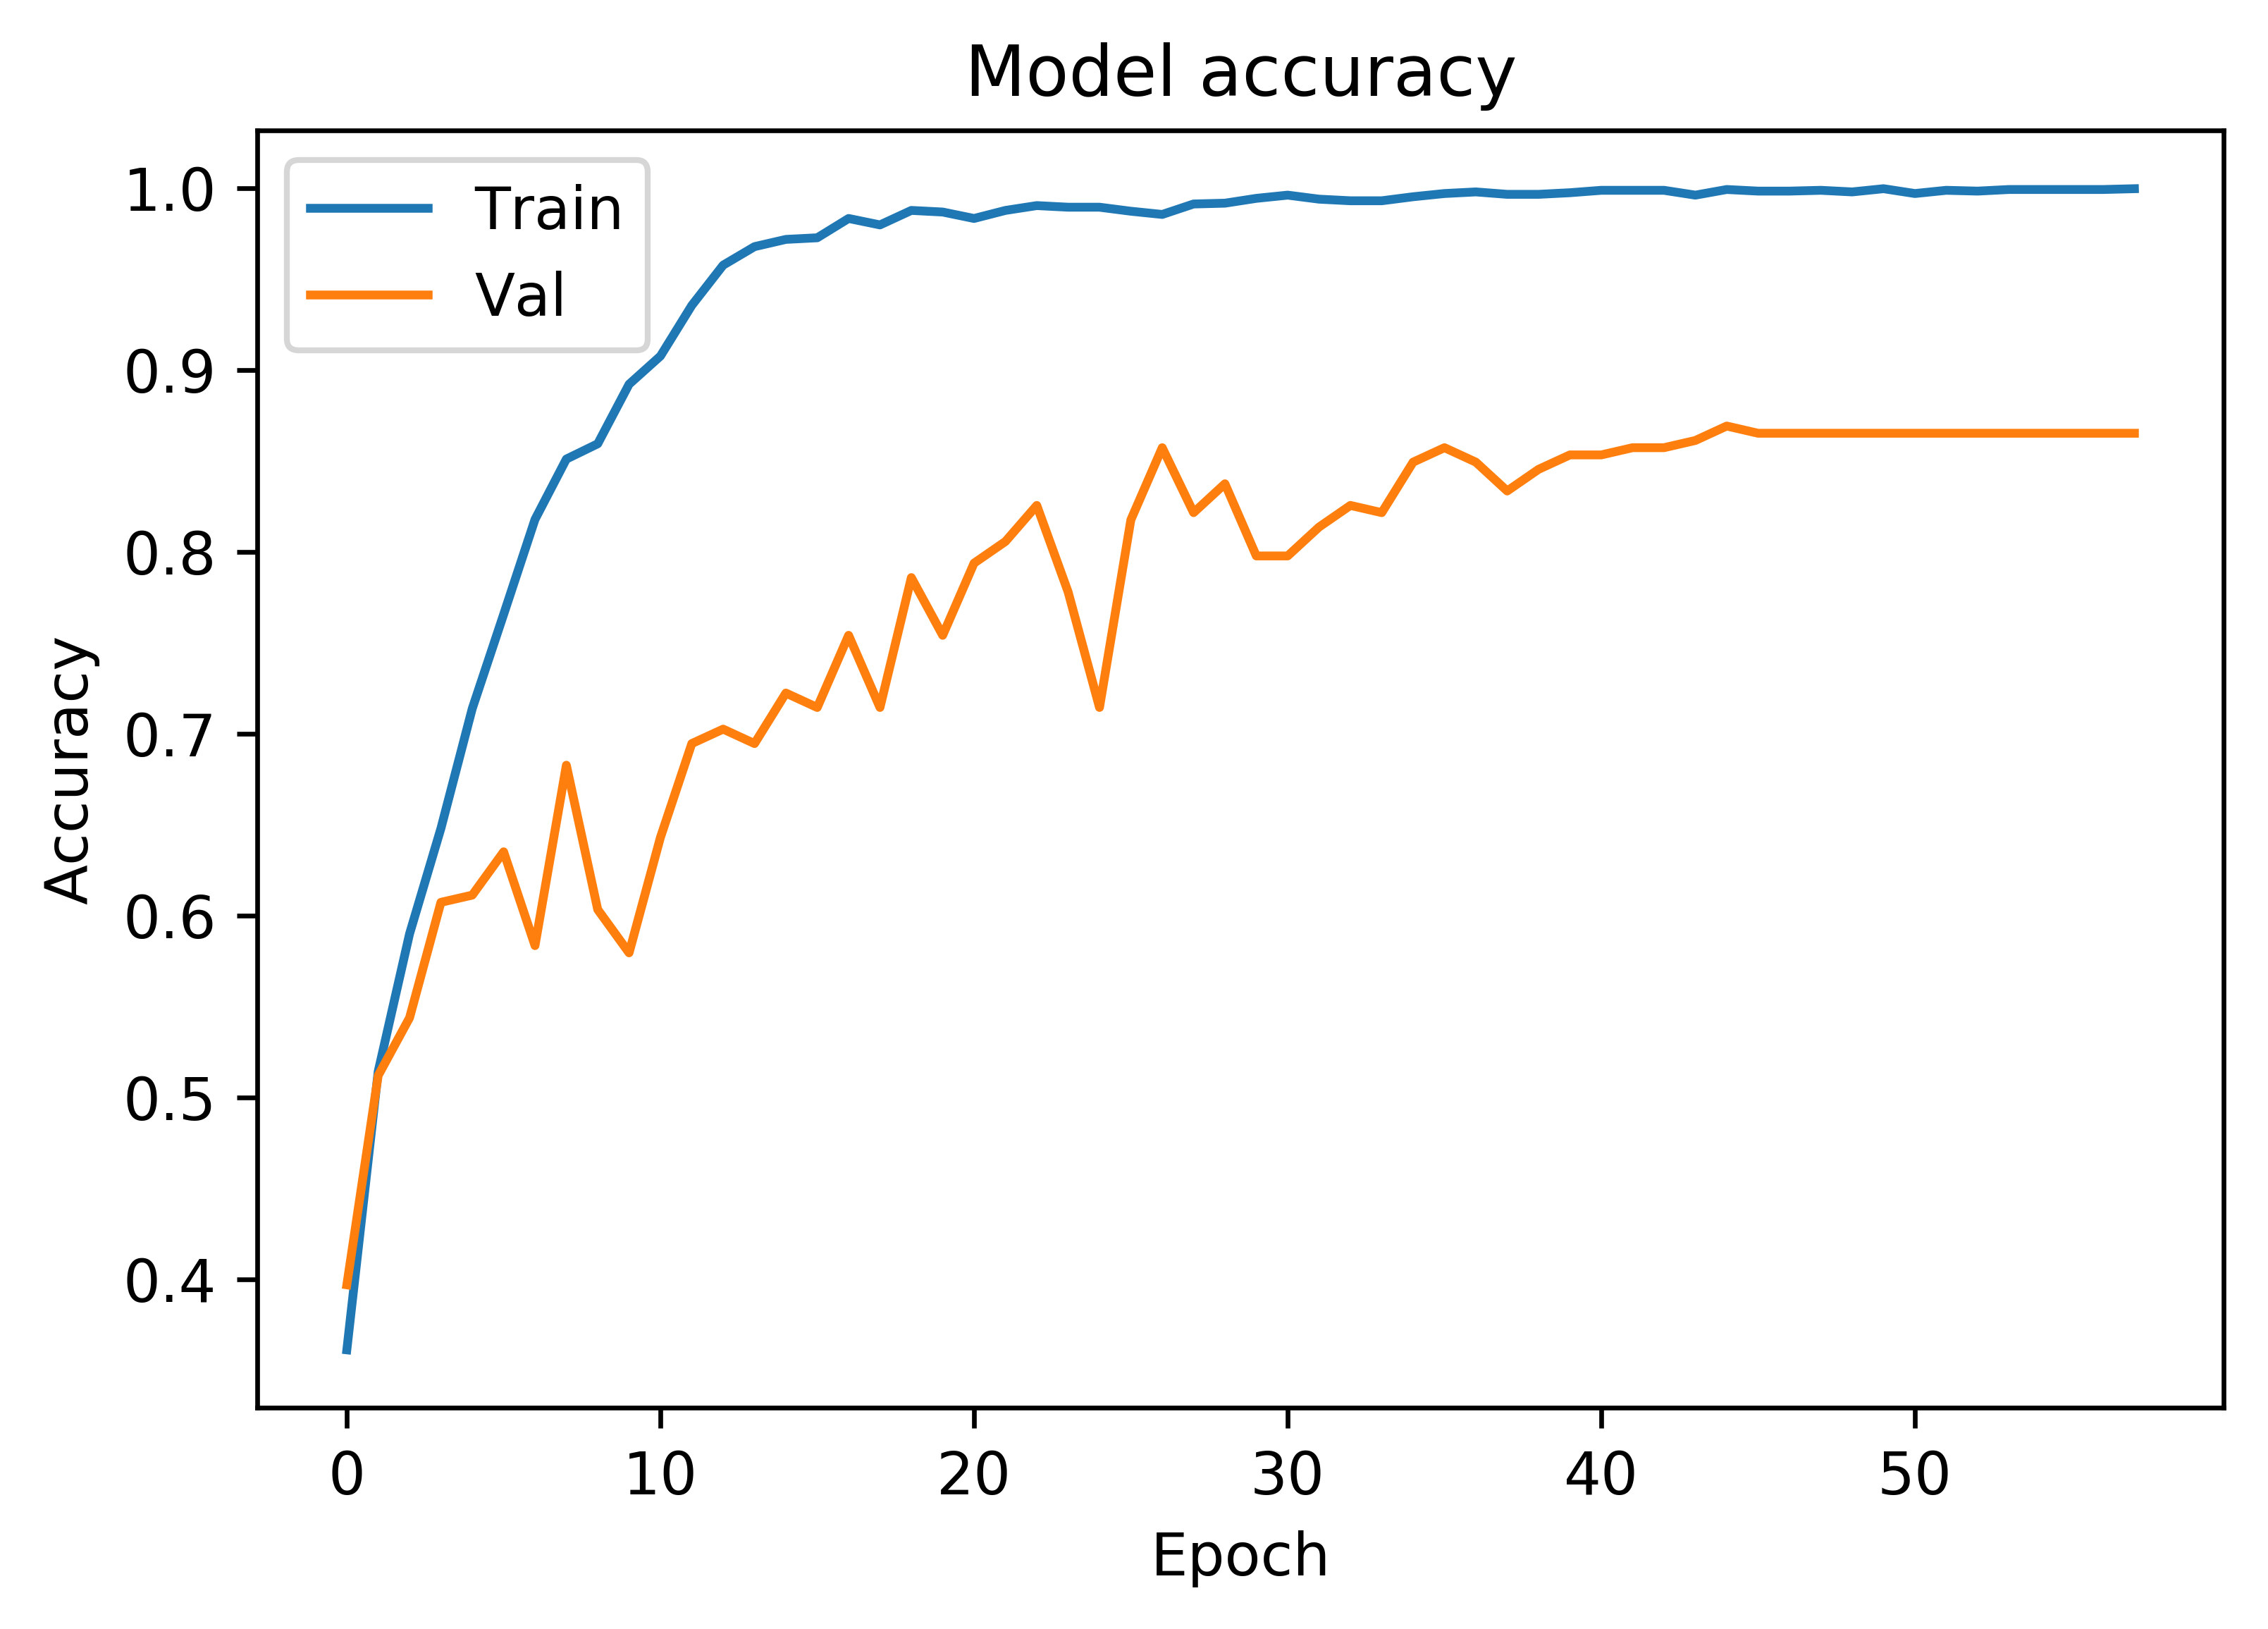

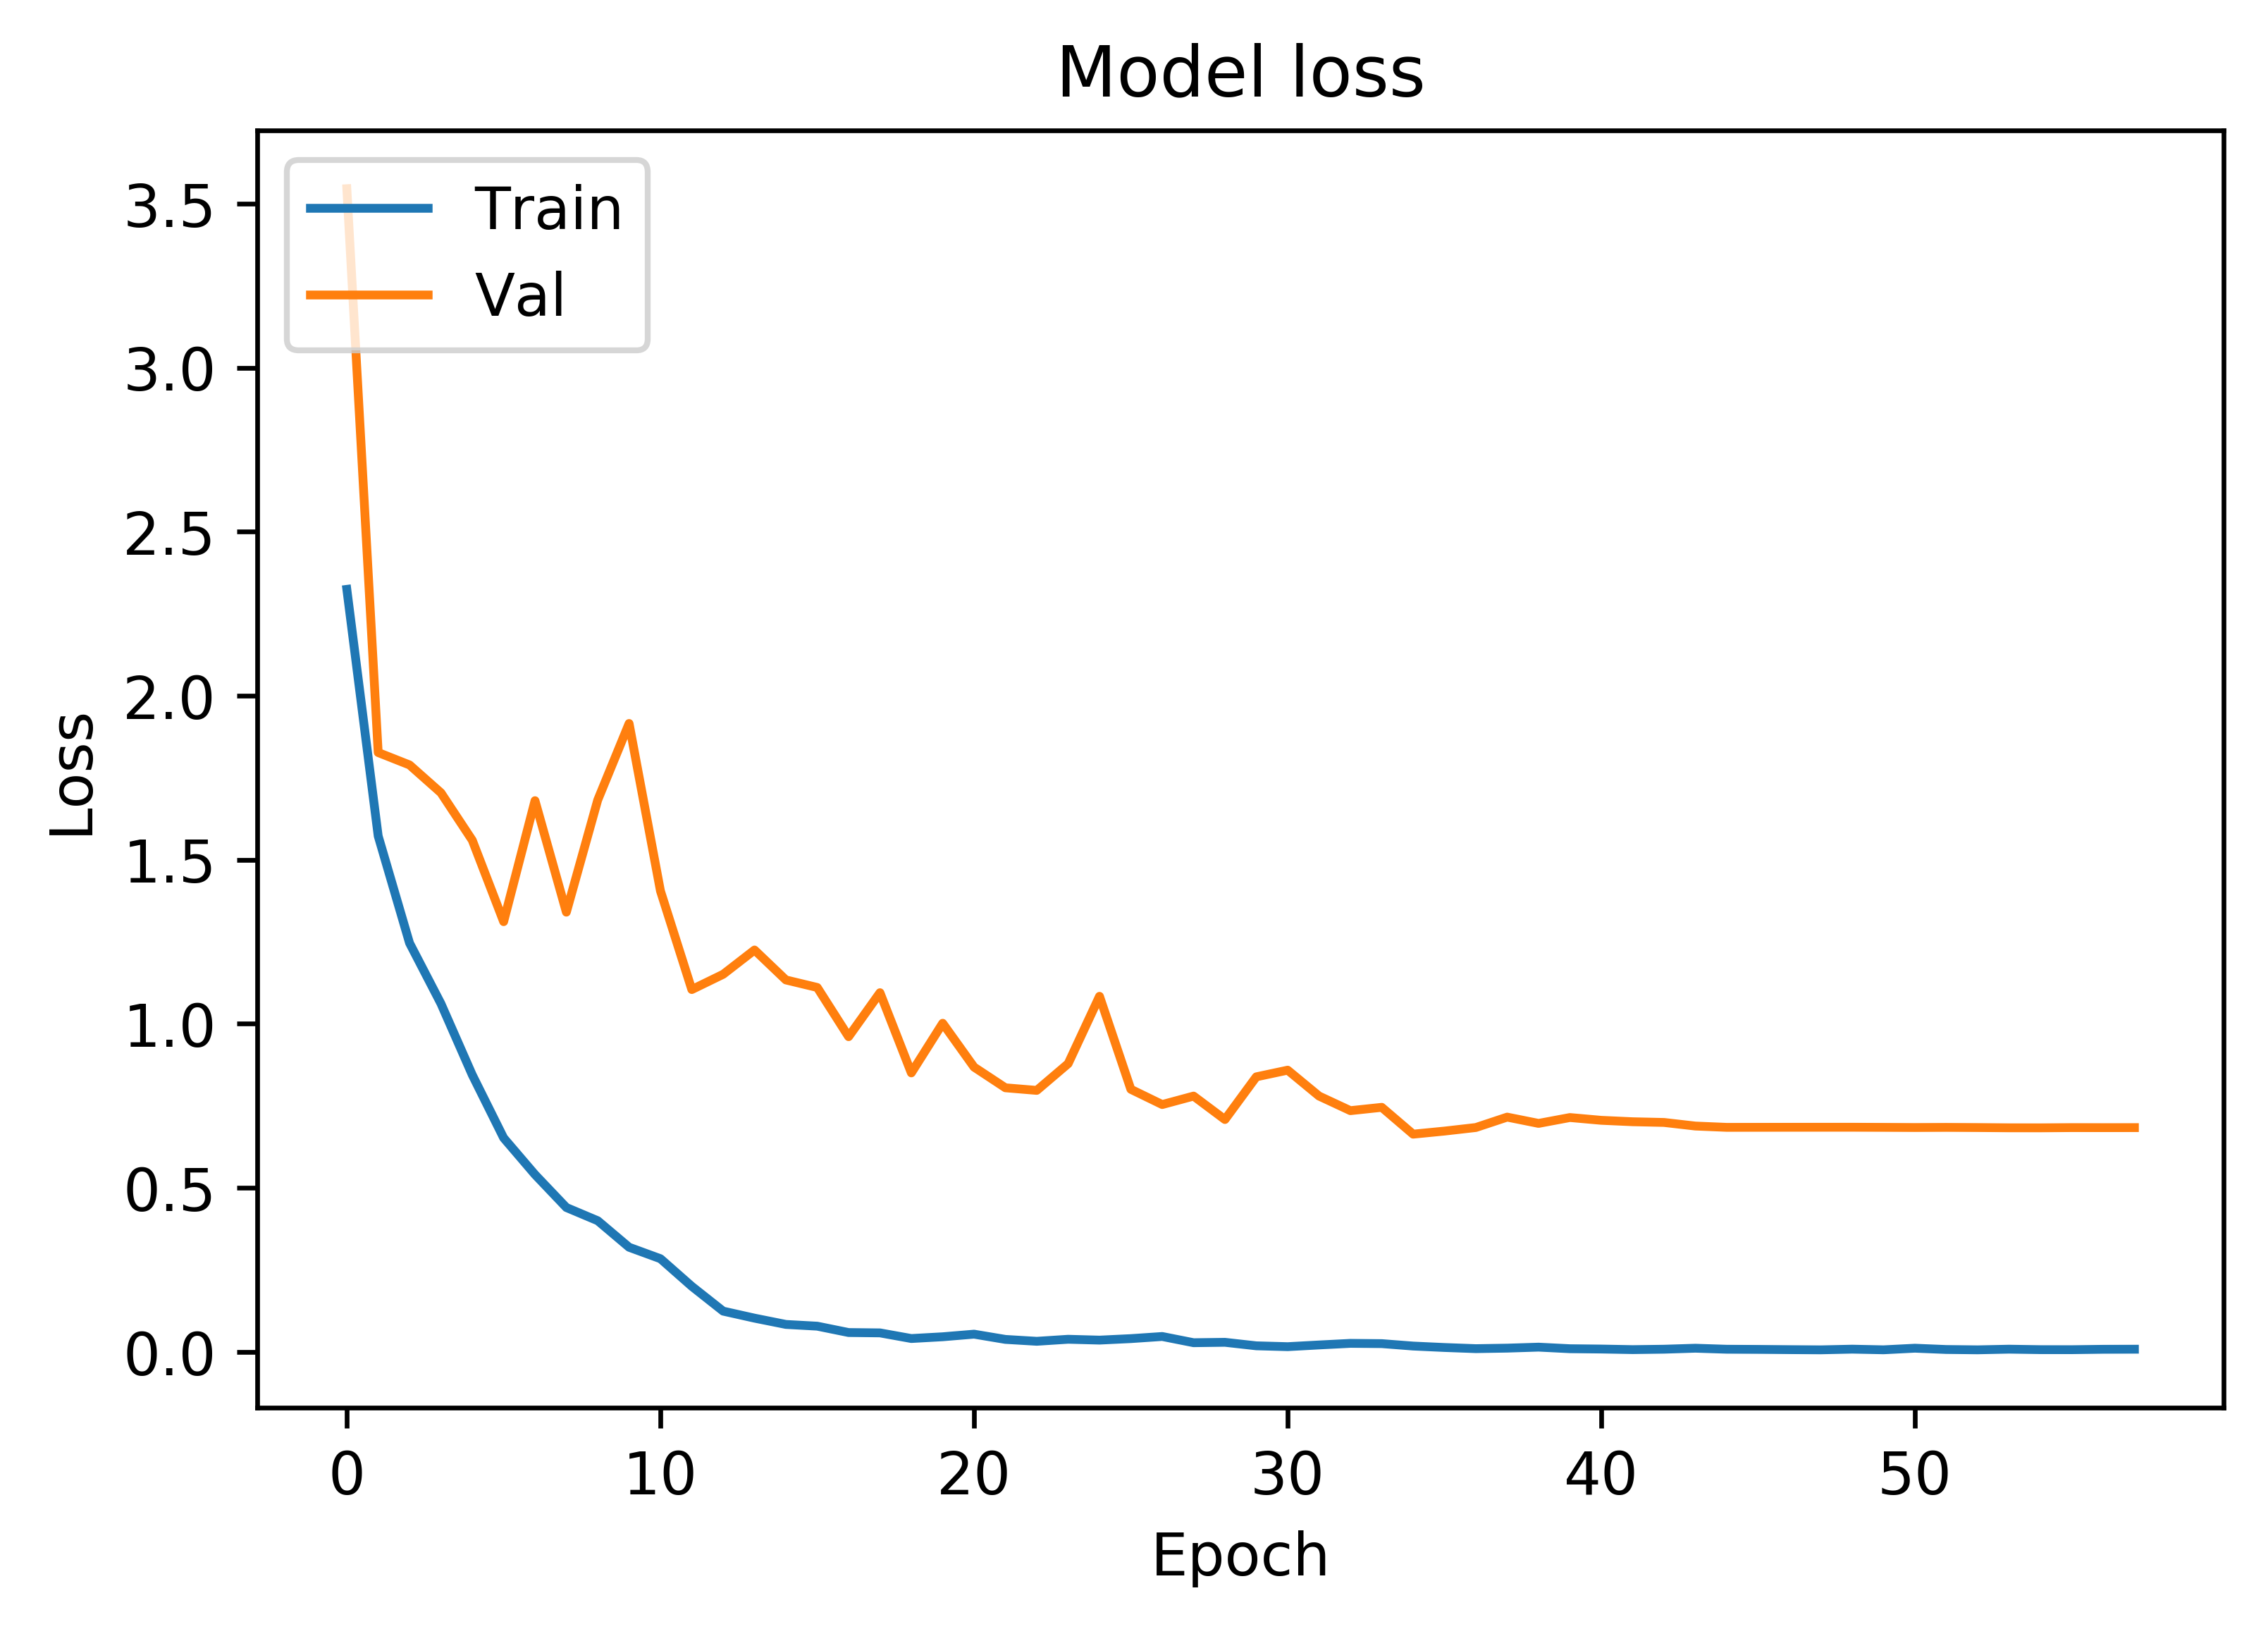

Results from K-fold: 1
acc: 81.65%
632/632 [==============================] - 1s 846us/step
[0.7820130742237538, 0.8164556962025317]
           bar  gel  network  plot  histology  sequence  line  molecular
bar         62    2        1     4          2         2     4          2
gel          2   71        1     3          0         2     0          0
network      1    3       58     1          0         8     4          4
plot         1    1        4    57          0         1    14          1
histology    0    0        0     0         78         0     0          1
sequence     0    2        6     1          1        69     0          0
line         2    3        6    10          0         1    55          2
molecular    0    0        5     2          3         2     1         66
              precision    recall  f1-score   support

         bar       0.91      0.78      0.84        79
         gel       0.87      0.90      0.88        79
     network       0.72      0.73      0.73    

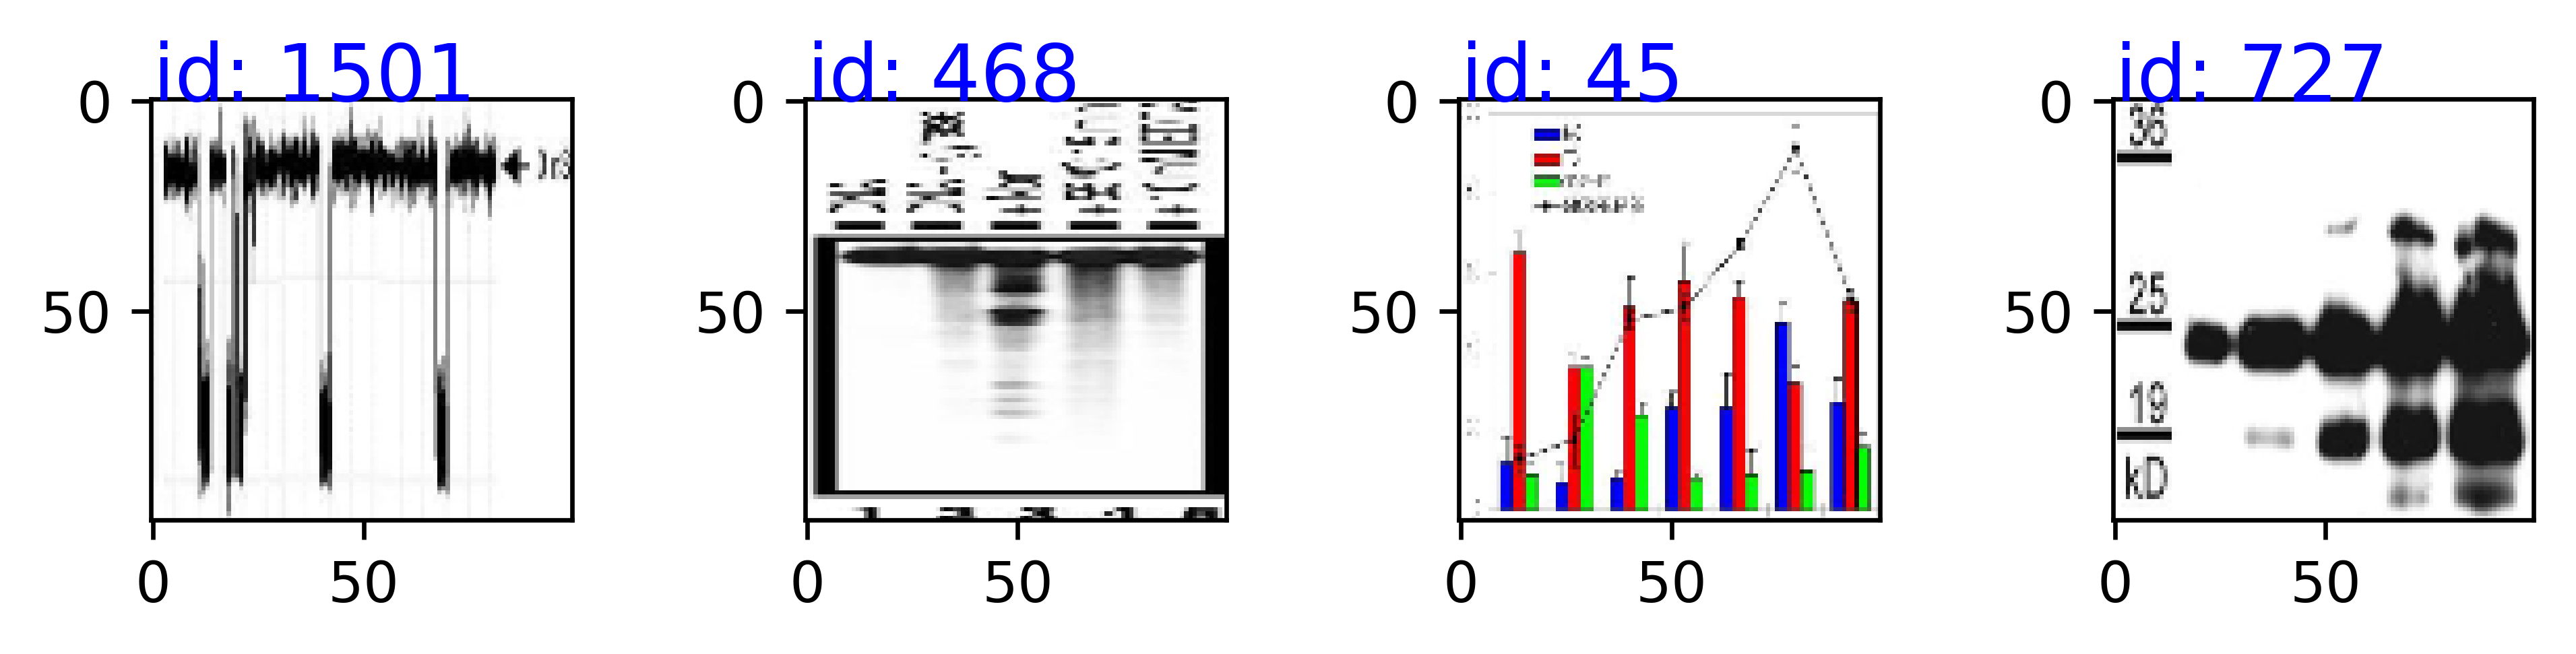

Samples from Testing
[   8   12 3133 3140]


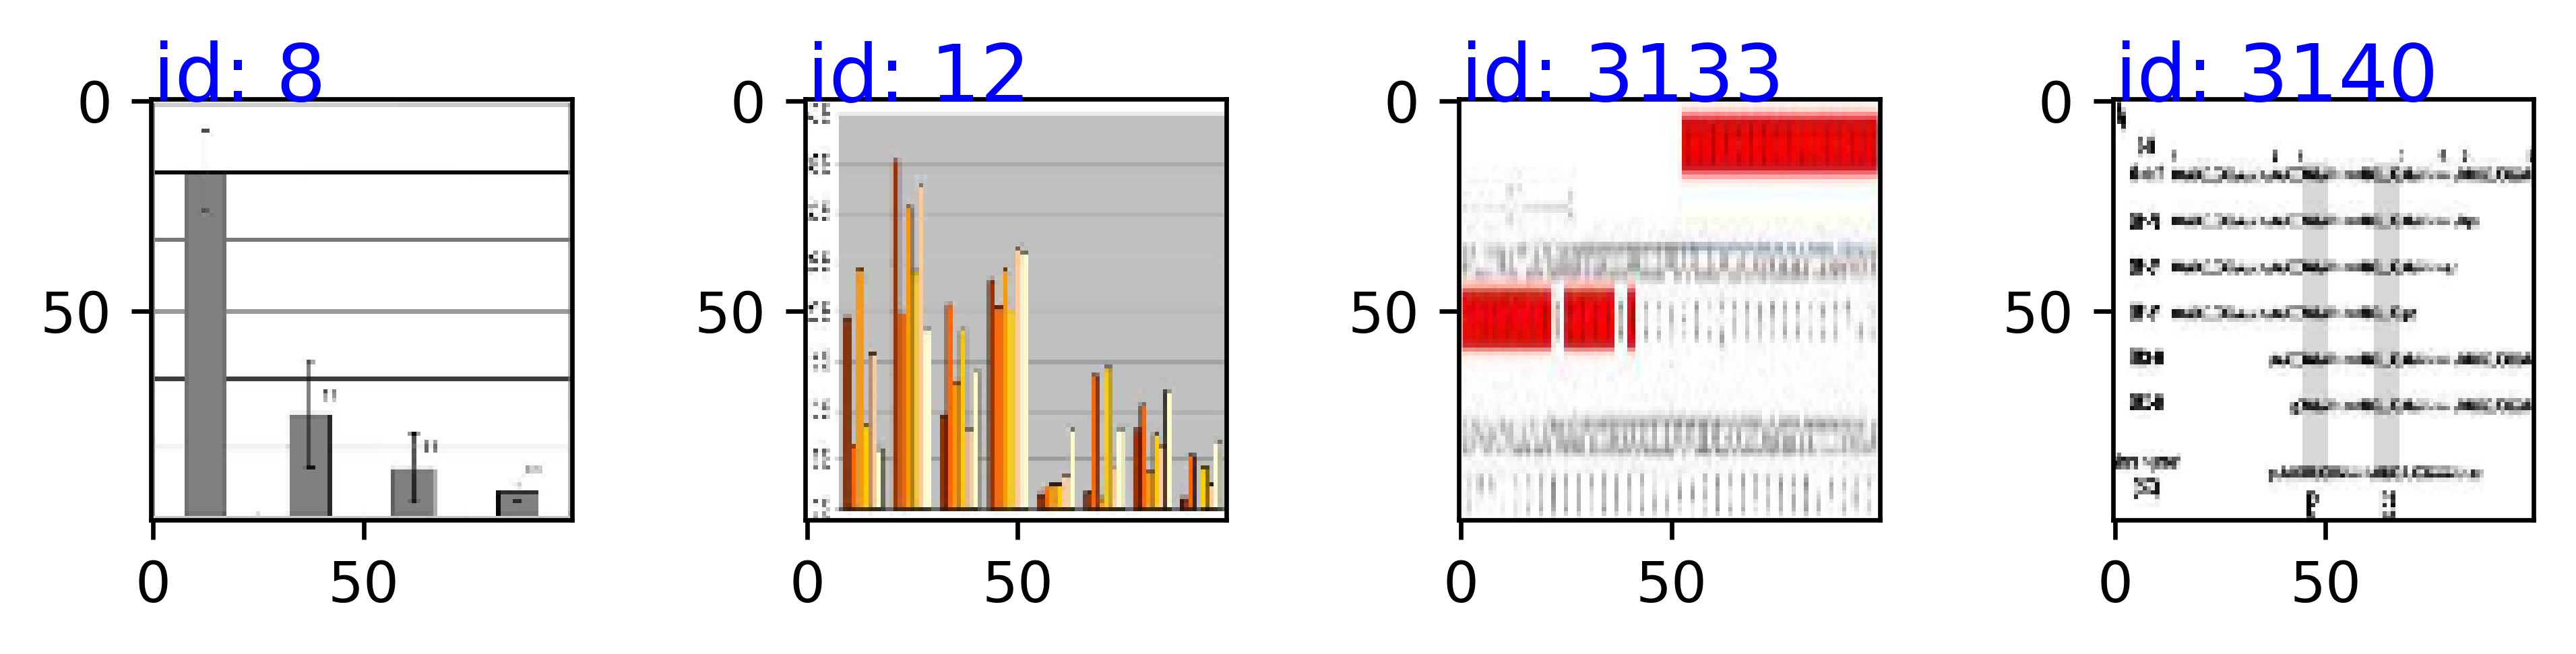

Train on 2260 samples, validate on 252 samples
Epoch 1/150
2260/2260 [==============================] - 7s 3ms/step - loss: 2.4227 - acc: 0.3261 - val_loss: 4.7116 - val_acc: 0.2937

Epoch 00001: val_acc improved from -inf to 0.29365, saving model to unimodal_weights/best_weight_image_only_k-fold_2.hdf5
Epoch 2/150
2260/2260 [==============================] - 4s 2ms/step - loss: 1.7737 - acc: 0.4584 - val_loss: 1.8691 - val_acc: 0.4524

Epoch 00002: val_acc improved from 0.29365 to 0.45238, saving model to unimodal_weights/best_weight_image_only_k-fold_2.hdf5
Epoch 3/150
2260/2260 [==============================] - 4s 2ms/step - loss: 1.3456 - acc: 0.5496 - val_loss: 1.7706 - val_acc: 0.5437

Epoch 00003: val_acc improved from 0.45238 to 0.54365, saving model to unimodal_weights/best_weight_image_only_k-fold_2.hdf5
Epoch 4/150
2260/2260 [==============================] - 4s 2ms/step - loss: 1.0561 - acc: 0.6420 - val_loss: 2.0019 - val_acc: 0.5198

Epoch 00004: val_acc did not improve 

2260/2260 [==============================] - 4s 2ms/step - loss: 0.0086 - acc: 0.9987 - val_loss: 0.7697 - val_acc: 0.8333

Epoch 00036: val_acc did not improve from 0.83730
Epoch 37/150
2260/2260 [==============================] - 4s 2ms/step - loss: 0.0067 - acc: 0.9987 - val_loss: 0.7704 - val_acc: 0.8413

Epoch 00037: val_acc improved from 0.83730 to 0.84127, saving model to unimodal_weights/best_weight_image_only_k-fold_2.hdf5
Epoch 38/150
2260/2260 [==============================] - 4s 2ms/step - loss: 0.0052 - acc: 0.9996 - val_loss: 0.7692 - val_acc: 0.8452

Epoch 00038: val_acc improved from 0.84127 to 0.84524, saving model to unimodal_weights/best_weight_image_only_k-fold_2.hdf5
Epoch 39/150
2260/2260 [==============================] - 4s 2ms/step - loss: 0.0070 - acc: 0.9978 - val_loss: 0.7681 - val_acc: 0.8373

Epoch 00039: val_acc did not improve from 0.84524
Epoch 40/150
2260/2260 [==============================] - 4s 2ms/step - loss: 0.0074 - acc: 0.9982 - val_loss: 0.76

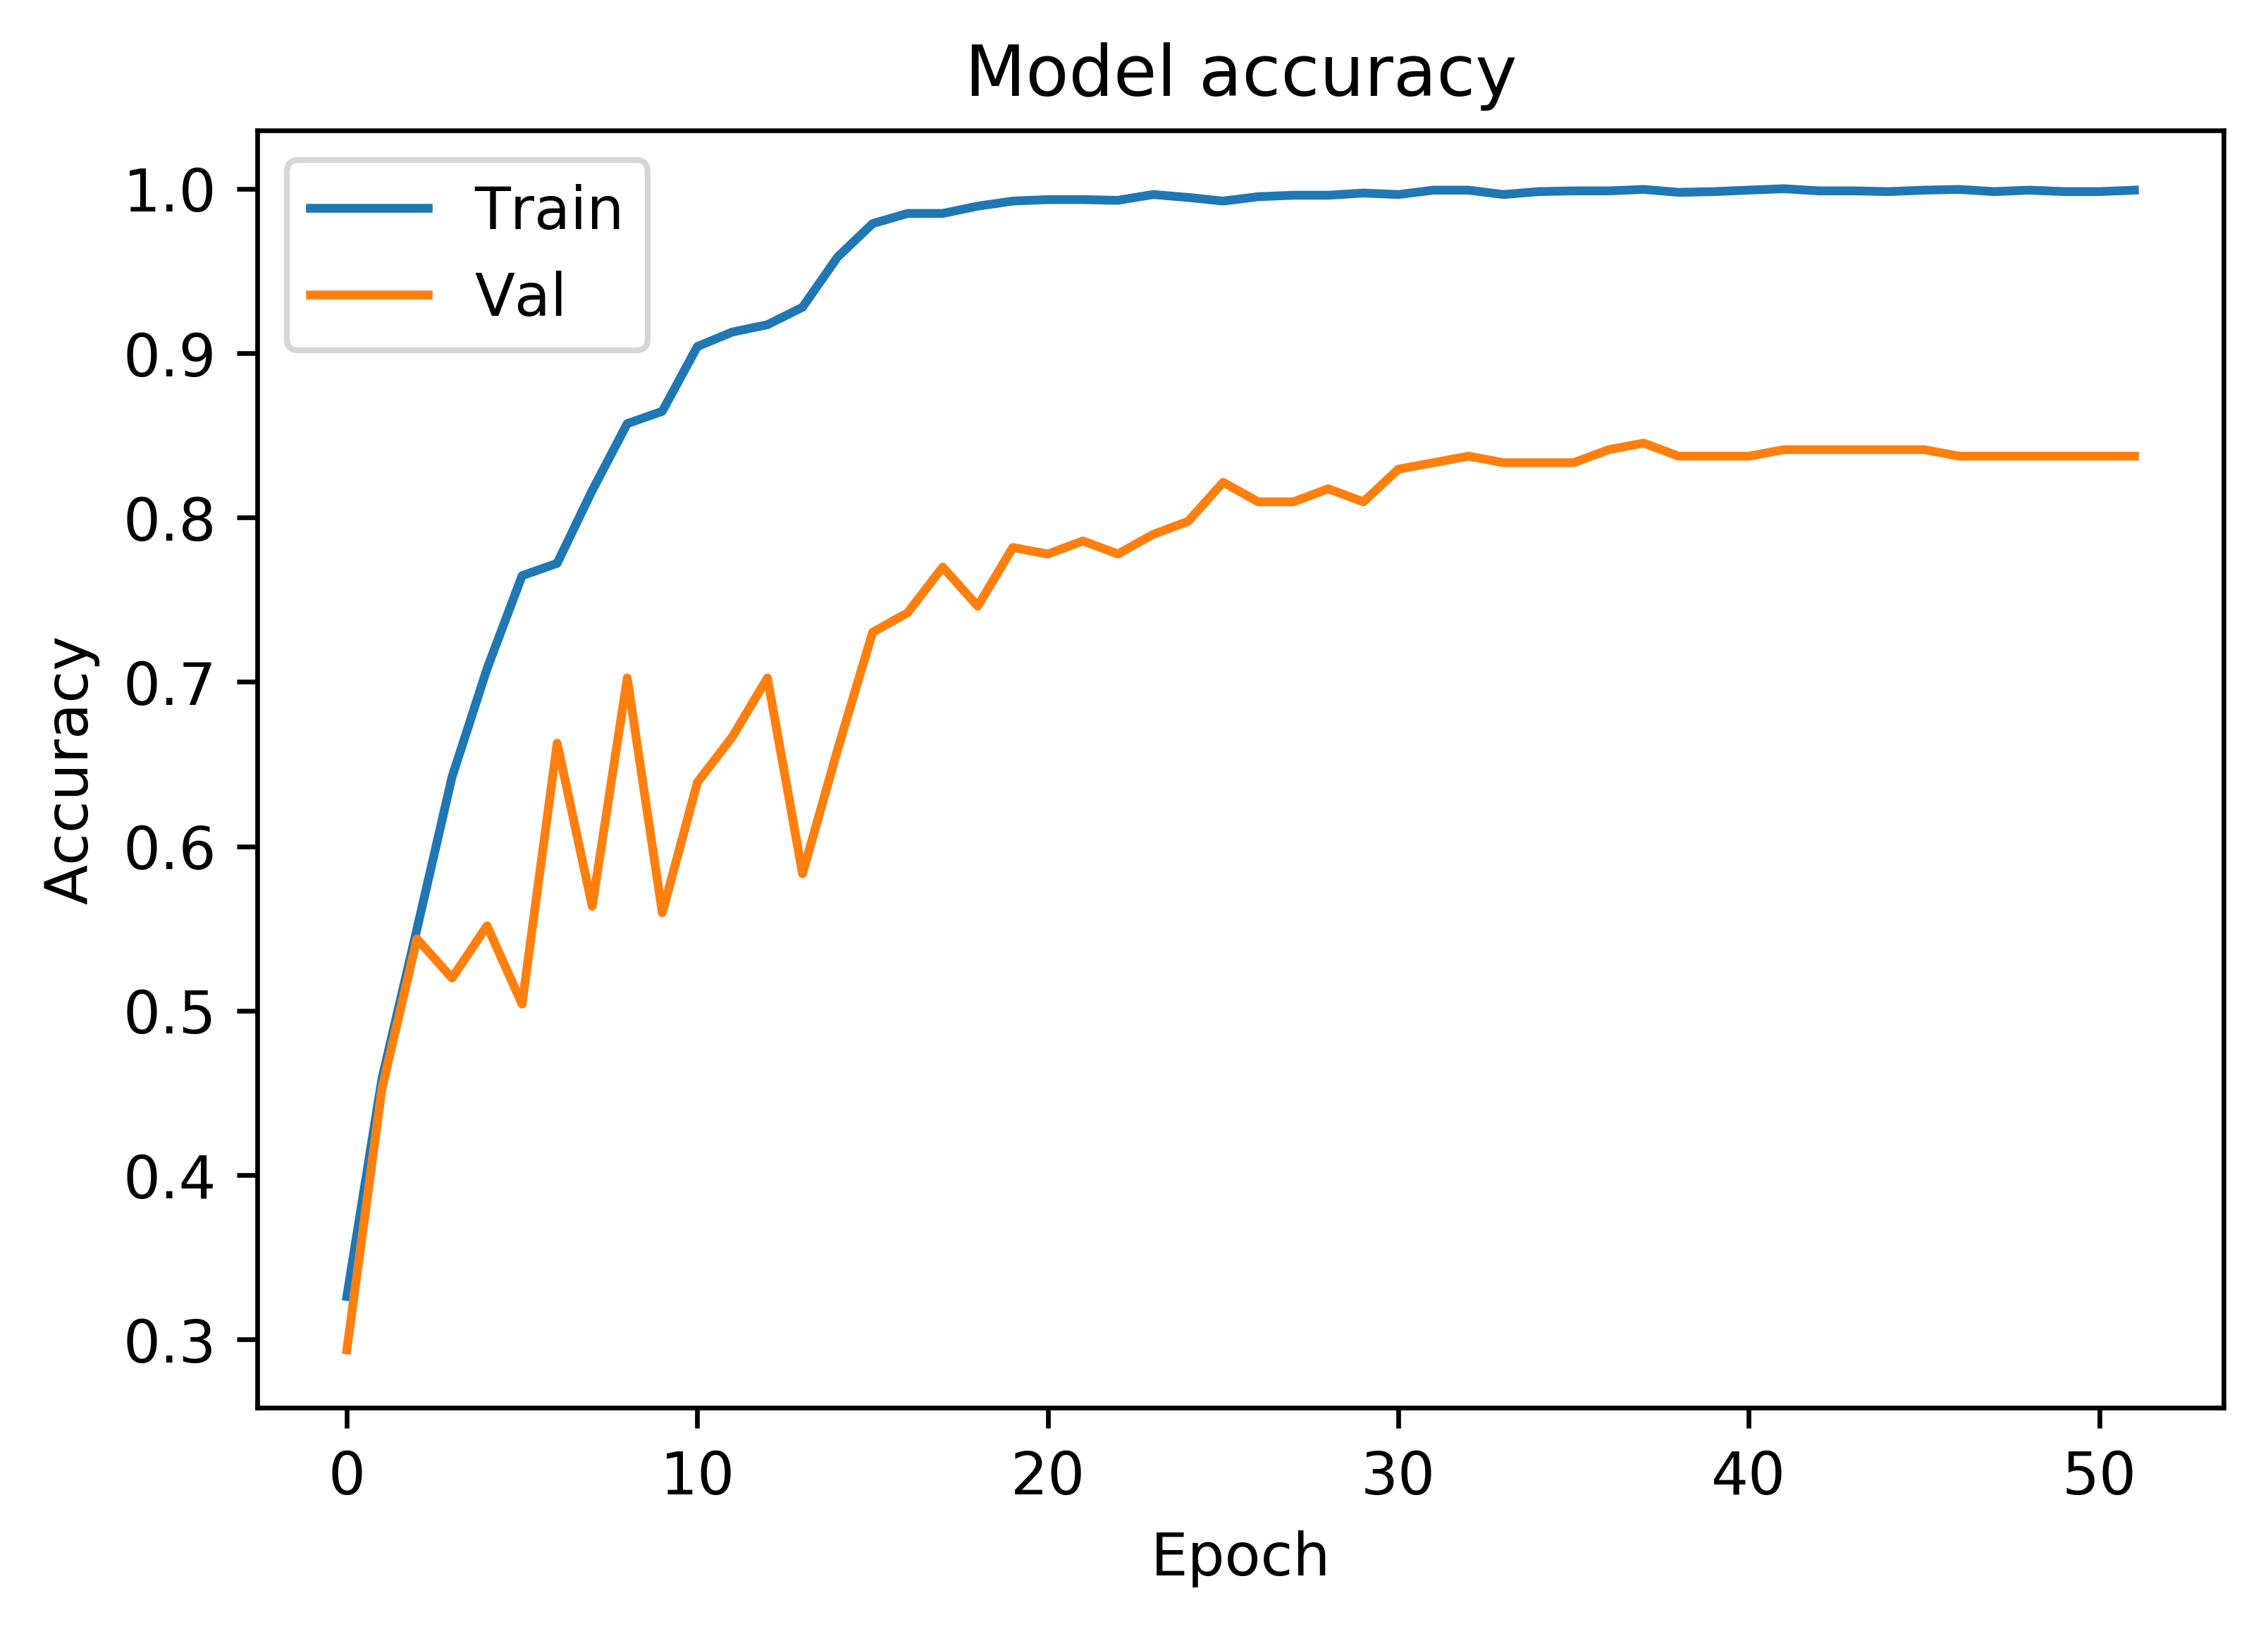

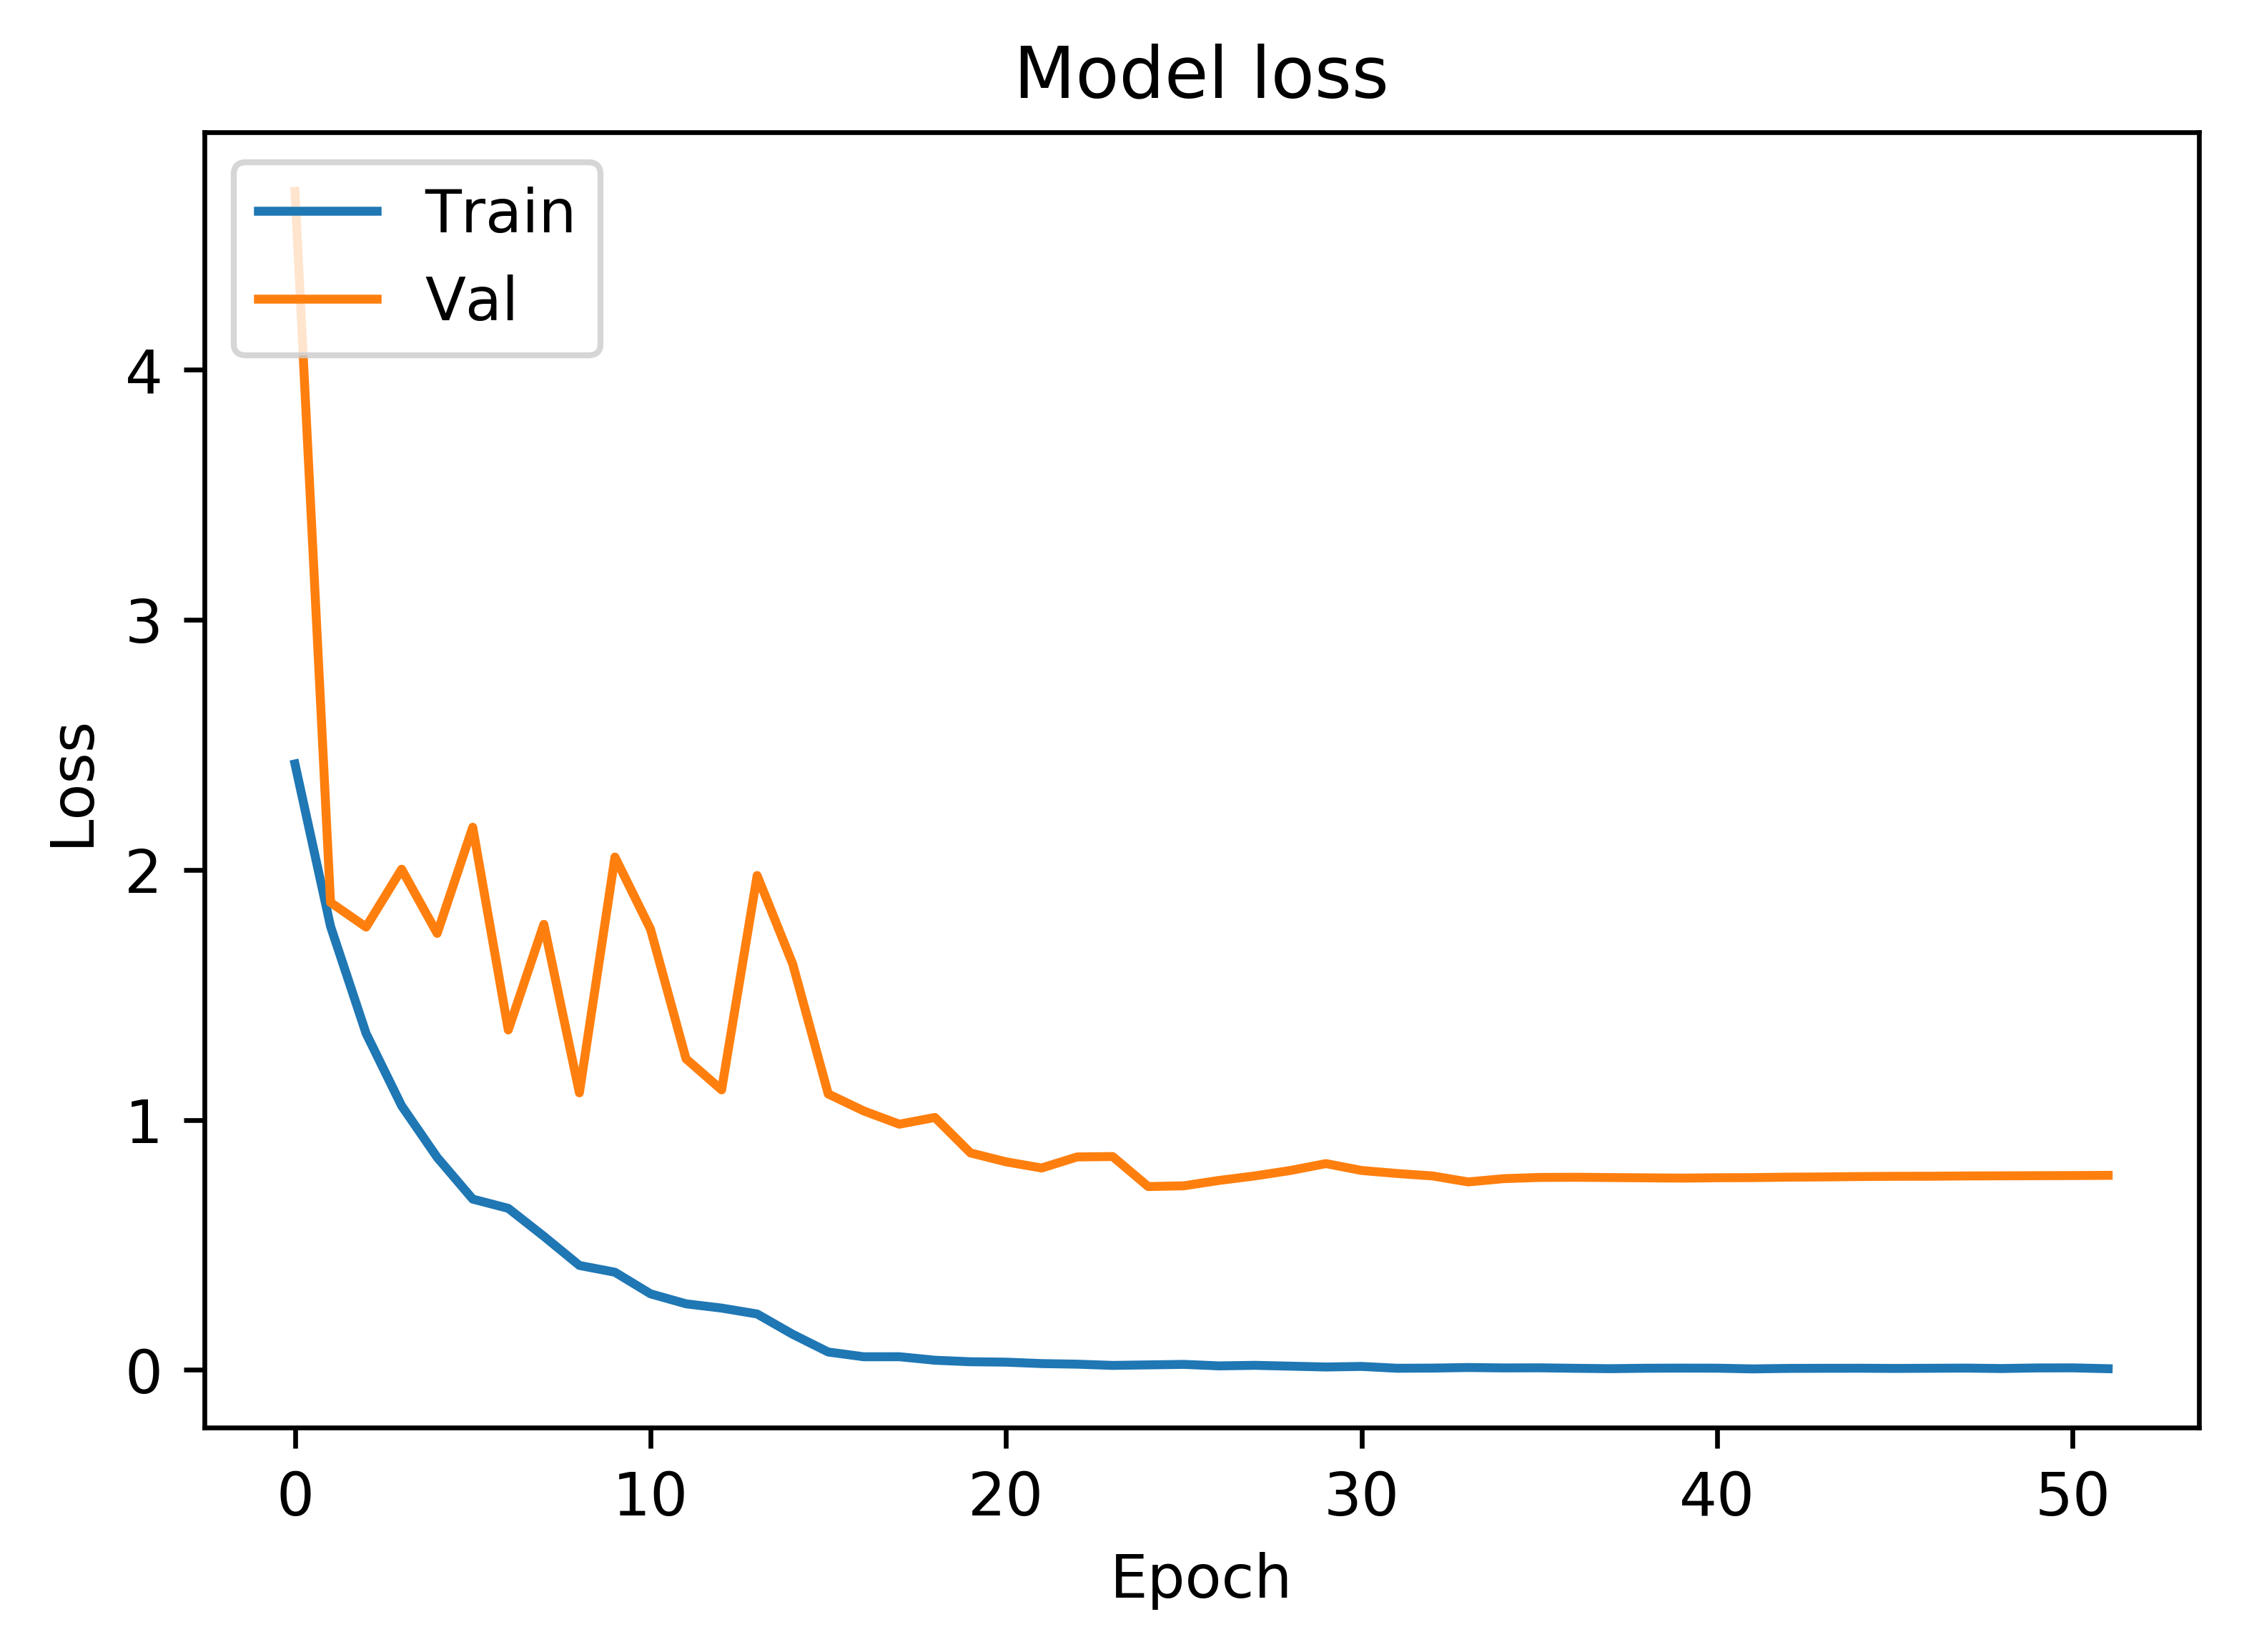

Results from K-fold: 2
acc: 80.70%
632/632 [==============================] - 1s 825us/step
[0.895765154752173, 0.8069620260709449]
           bar  gel  network  plot  histology  sequence  line  molecular
bar         66    1        5     2          0         1     4          0
gel          1   73        4     1          0         0     0          0
network      3    4       51     2          0         7     5          7
plot         3    1        1    57          2         0    14          1
histology    0    2        1     1         68         0     0          7
sequence     0    1        2     0          1        75     0          0
line         1    2        3    11          1         2    55          4
molecular    1    0        5     2          2         2     2         65
              precision    recall  f1-score   support

         bar       0.88      0.84      0.86        79
         gel       0.87      0.92      0.90        79
     network       0.71      0.65      0.68     

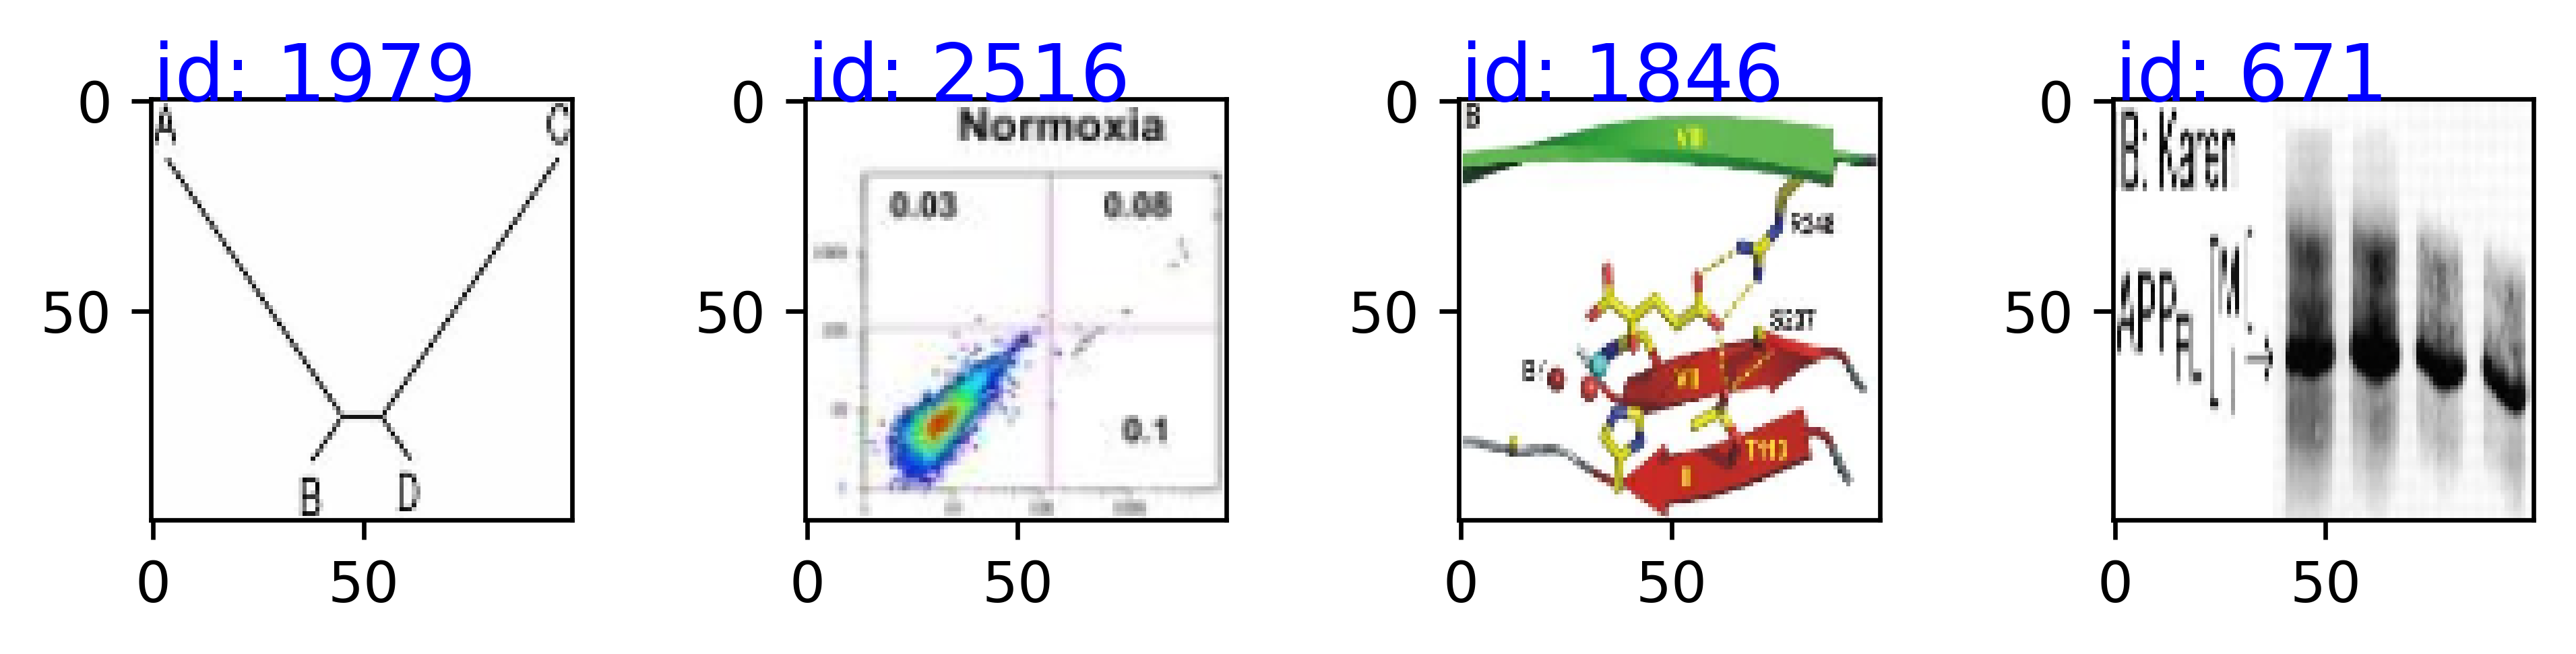

Samples from Testing
[   2   13 3135 3141]


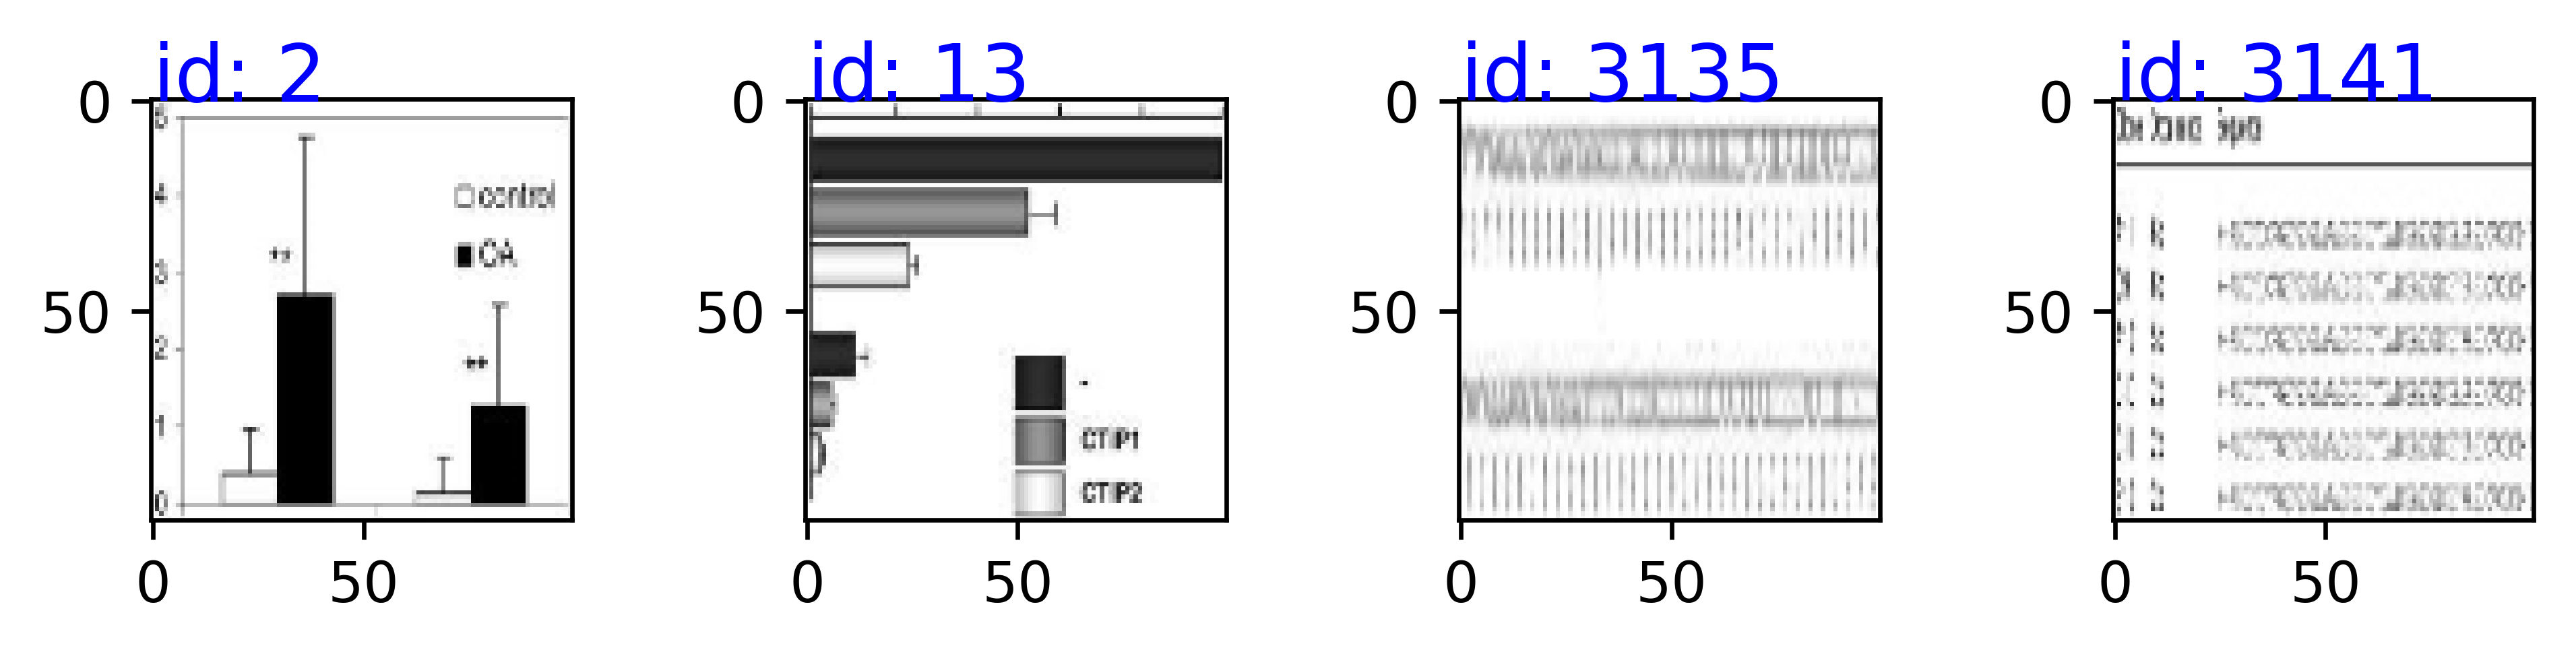

Train on 2260 samples, validate on 252 samples
Epoch 1/150
2260/2260 [==============================] - 7s 3ms/step - loss: 2.3606 - acc: 0.3376 - val_loss: 2.6540 - val_acc: 0.3651

Epoch 00001: val_acc improved from -inf to 0.36508, saving model to unimodal_weights/best_weight_image_only_k-fold_3.hdf5
Epoch 2/150
2260/2260 [==============================] - 4s 2ms/step - loss: 1.7746 - acc: 0.4522 - val_loss: 2.4762 - val_acc: 0.4643

Epoch 00002: val_acc improved from 0.36508 to 0.46429, saving model to unimodal_weights/best_weight_image_only_k-fold_3.hdf5
Epoch 3/150
2260/2260 [==============================] - 4s 2ms/step - loss: 1.3493 - acc: 0.5730 - val_loss: 1.6676 - val_acc: 0.5476

Epoch 00003: val_acc improved from 0.46429 to 0.54762, saving model to unimodal_weights/best_weight_image_only_k-fold_3.hdf5
Epoch 4/150
2260/2260 [==============================] - 4s 2ms/step - loss: 1.1327 - acc: 0.6248 - val_loss: 1.5509 - val_acc: 0.5516

Epoch 00004: val_acc improved from 0.

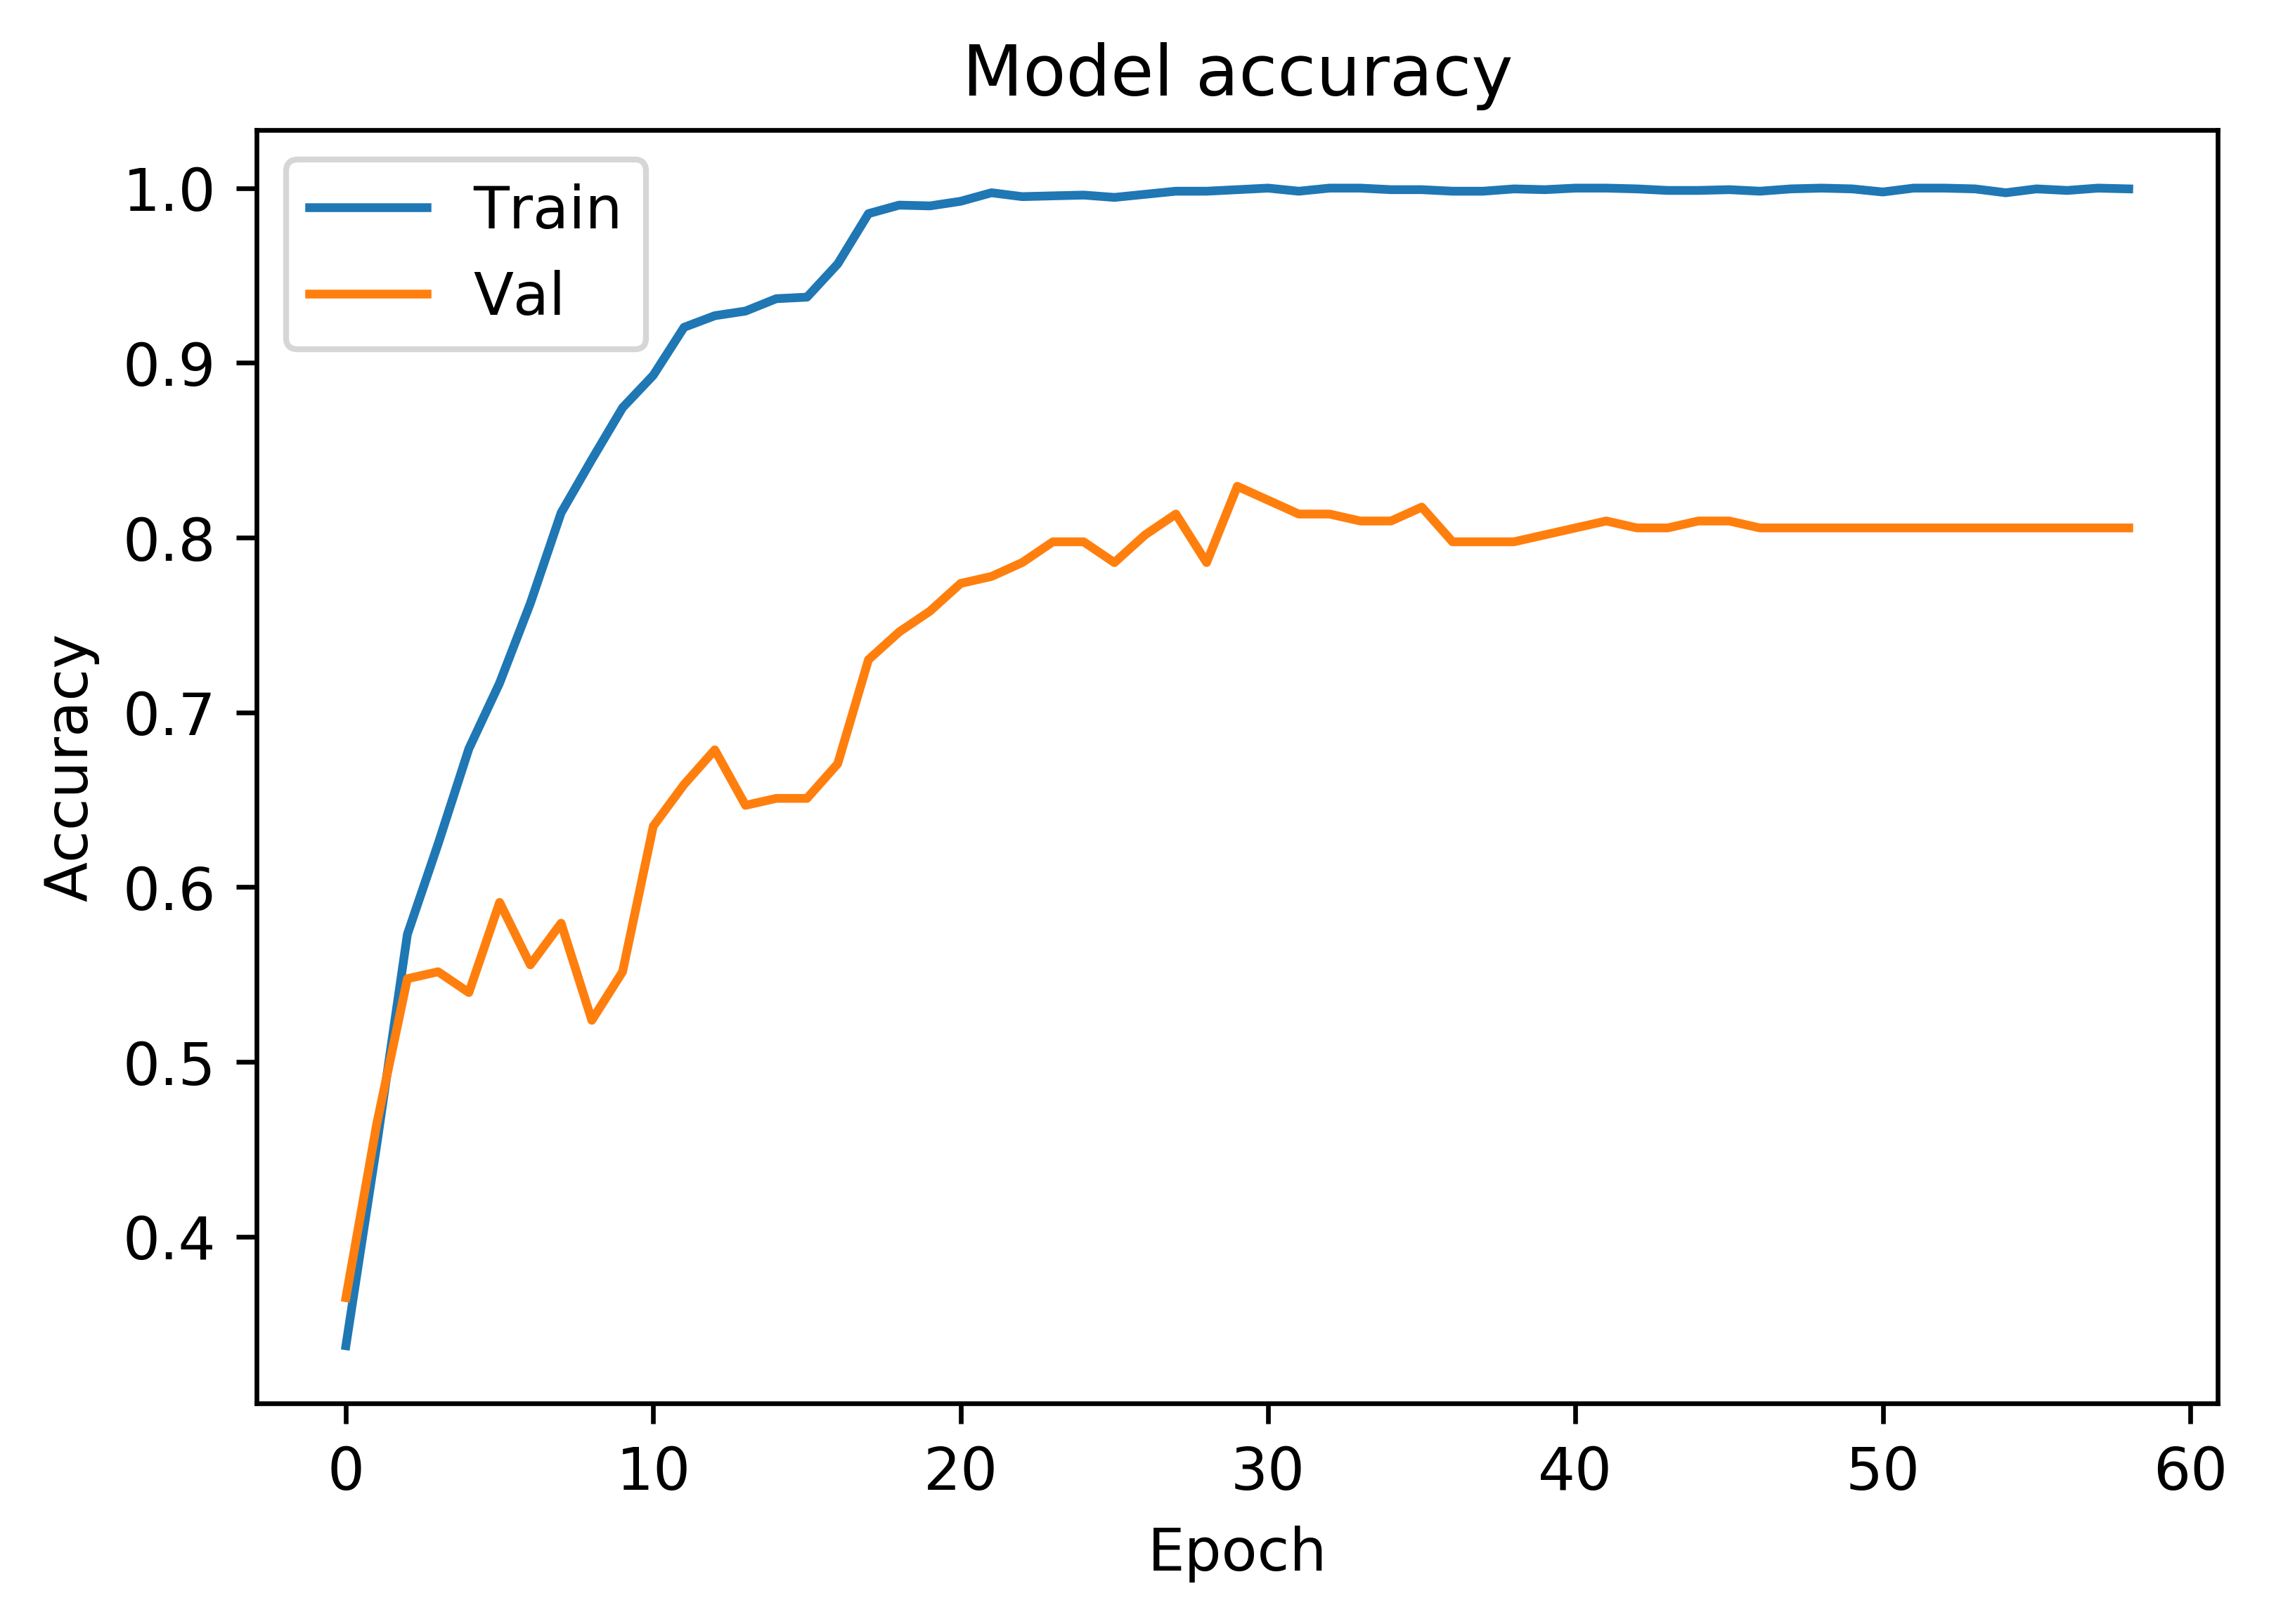

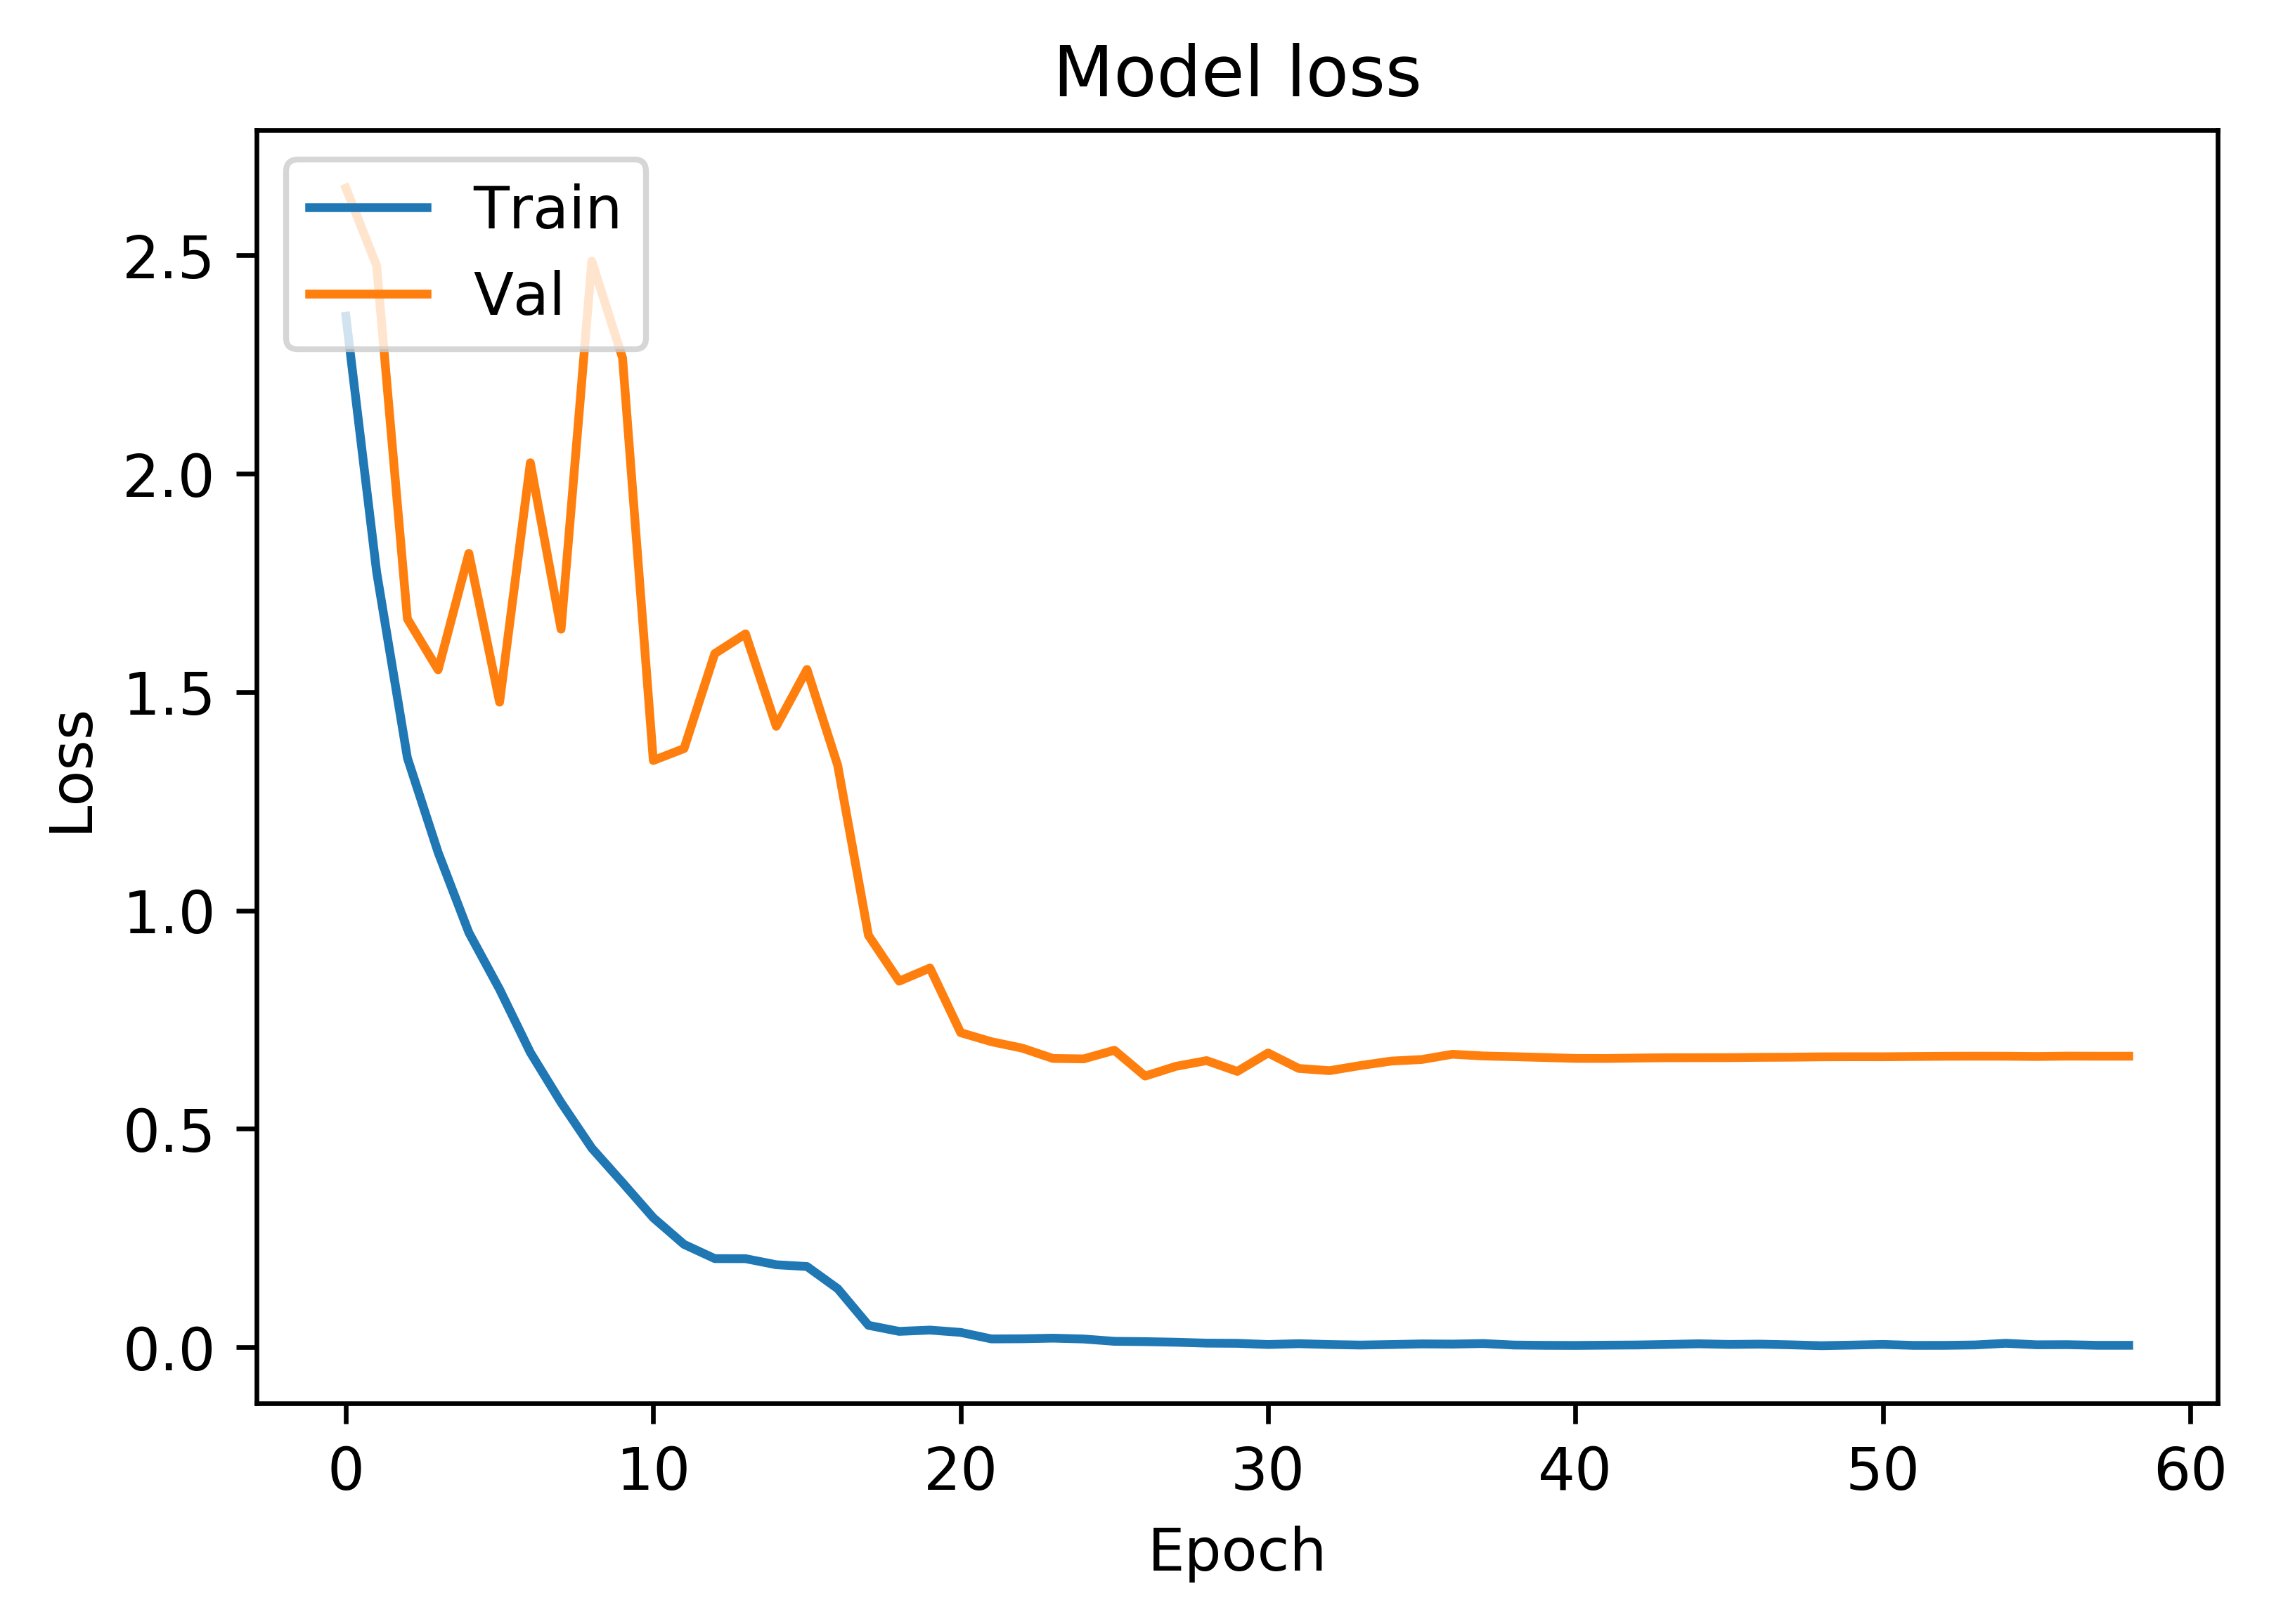

Results from K-fold: 3
acc: 83.07%
632/632 [==============================] - 0s 713us/step
[0.6386815820690952, 0.8306962025316456]
           bar  gel  network  plot  histology  sequence  line  molecular
bar         69    4        1     4          0         0     1          0
gel          0   71        5     0          1         0     2          0
network      3    1       53     6          0         8     2          6
plot         0    2        3    59          1         0    14          0
histology    0    2        0     0         75         0     0          2
sequence     1    1        7     0          0        68     0          2
line         2    1        1     8          2         1    62          2
molecular    0    0        6     2          2         0     1         68
              precision    recall  f1-score   support

         bar       0.92      0.87      0.90        79
         gel       0.87      0.90      0.88        79
     network       0.70      0.67      0.68    

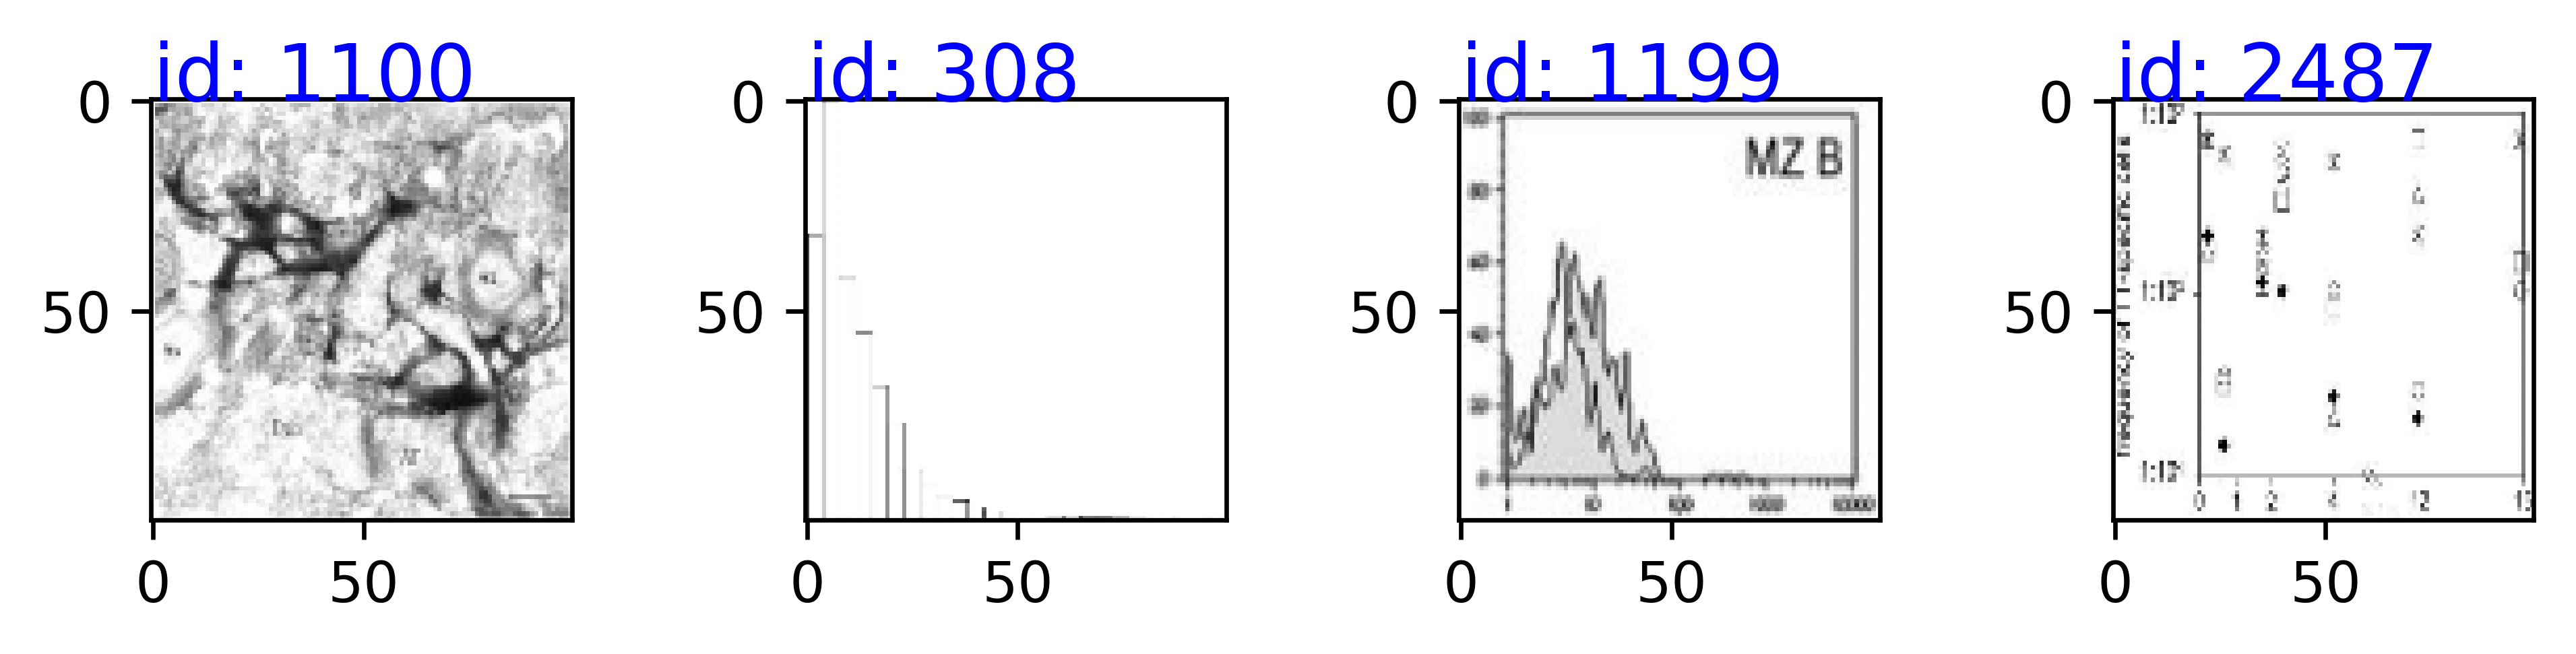

Samples from Testing
[   0    3 3131 3137]


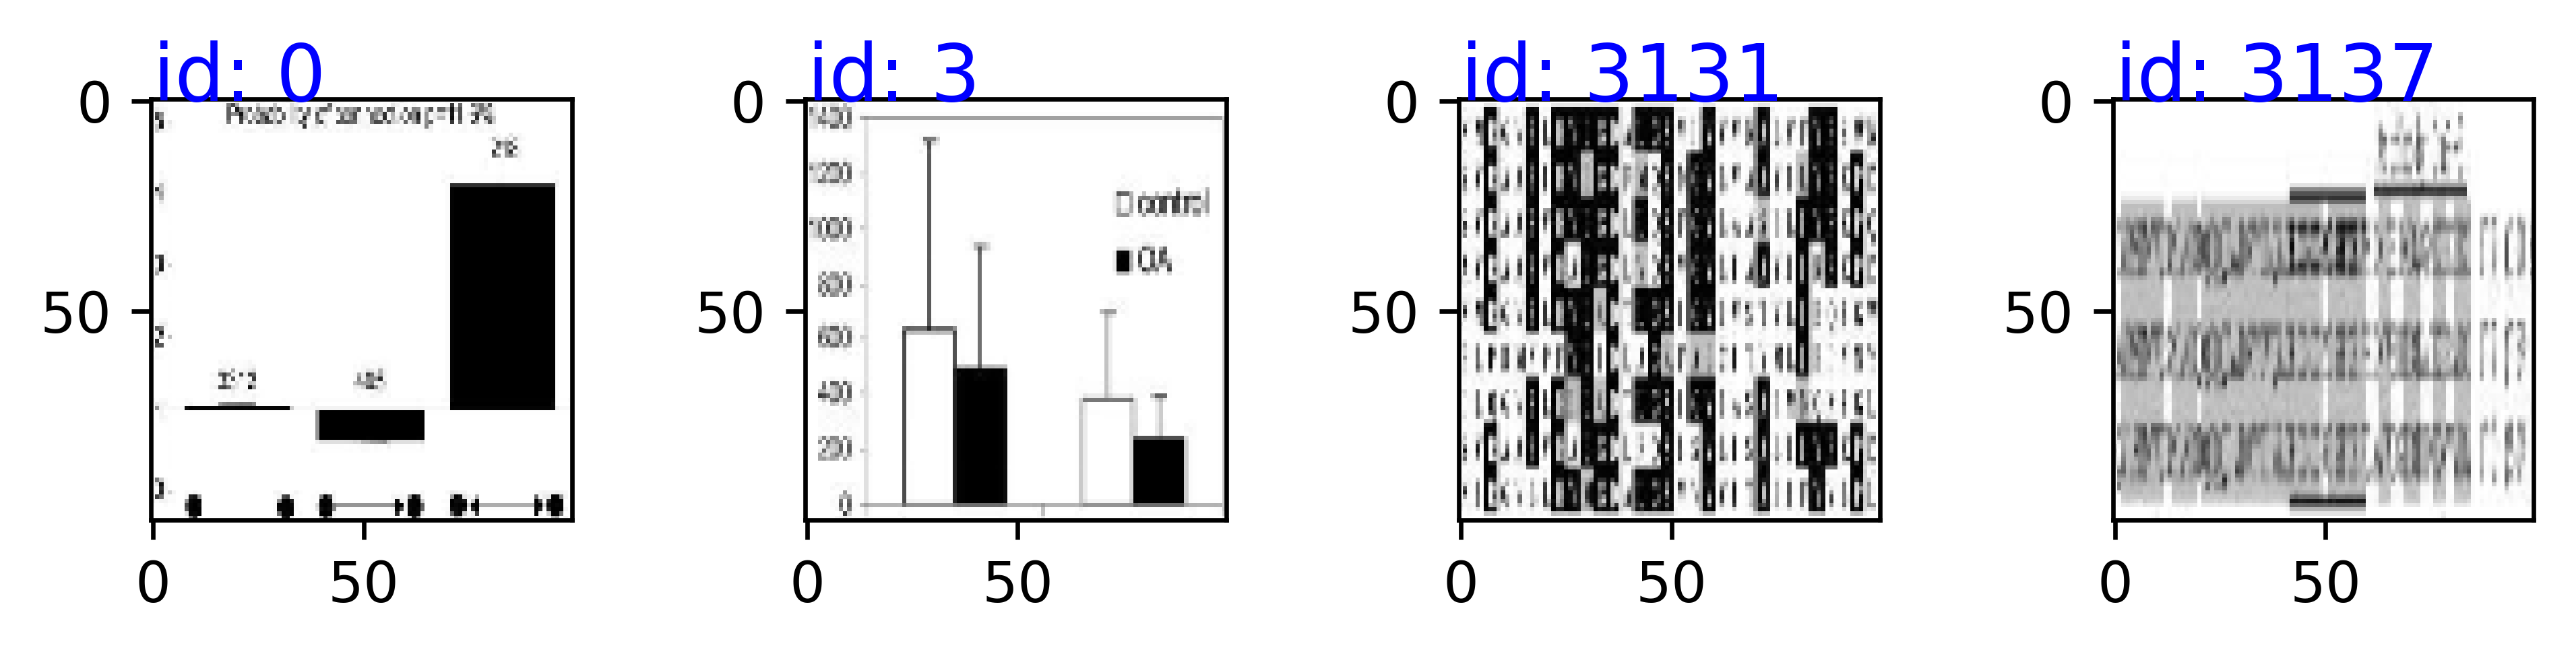

Train on 2268 samples, validate on 252 samples
Epoch 1/150
2268/2268 [==============================] - 8s 4ms/step - loss: 2.3261 - acc: 0.3505 - val_loss: 3.4873 - val_acc: 0.3135

Epoch 00001: val_acc improved from -inf to 0.31349, saving model to unimodal_weights/best_weight_image_only_k-fold_4.hdf5
Epoch 2/150
2268/2268 [==============================] - 4s 2ms/step - loss: 1.7877 - acc: 0.4568 - val_loss: 2.0305 - val_acc: 0.5476

Epoch 00002: val_acc improved from 0.31349 to 0.54762, saving model to unimodal_weights/best_weight_image_only_k-fold_4.hdf5
Epoch 3/150
2268/2268 [==============================] - 4s 2ms/step - loss: 1.4189 - acc: 0.5525 - val_loss: 2.1160 - val_acc: 0.5198

Epoch 00003: val_acc did not improve from 0.54762
Epoch 4/150
2268/2268 [==============================] - 4s 2ms/step - loss: 1.1479 - acc: 0.6345 - val_loss: 1.6095 - val_acc: 0.5833

Epoch 00004: val_acc improved from 0.54762 to 0.58333, saving model to unimodal_weights/best_weight_image_only_k

Epoch 39/150
2268/2268 [==============================] - 4s 2ms/step - loss: 0.0082 - acc: 0.9982 - val_loss: 0.8316 - val_acc: 0.8254

Epoch 00039: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.

Epoch 00039: val_acc improved from 0.82540 to 0.82540, saving model to unimodal_weights/best_weight_image_only_k-fold_4.hdf5
Epoch 40/150
2268/2268 [==============================] - 4s 2ms/step - loss: 0.0127 - acc: 0.9978 - val_loss: 0.8282 - val_acc: 0.8294

Epoch 00040: val_acc improved from 0.82540 to 0.82937, saving model to unimodal_weights/best_weight_image_only_k-fold_4.hdf5
Epoch 41/150
2268/2268 [==============================] - 4s 2ms/step - loss: 0.0082 - acc: 0.9987 - val_loss: 0.8232 - val_acc: 0.8254

Epoch 00041: val_acc did not improve from 0.82937
Epoch 42/150
2268/2268 [==============================] - 4s 2ms/step - loss: 0.0134 - acc: 0.9960 - val_loss: 0.8268 - val_acc: 0.8254

Epoch 00042: val_acc did not improve from 0.82937
Epoch 43/150
2268/226

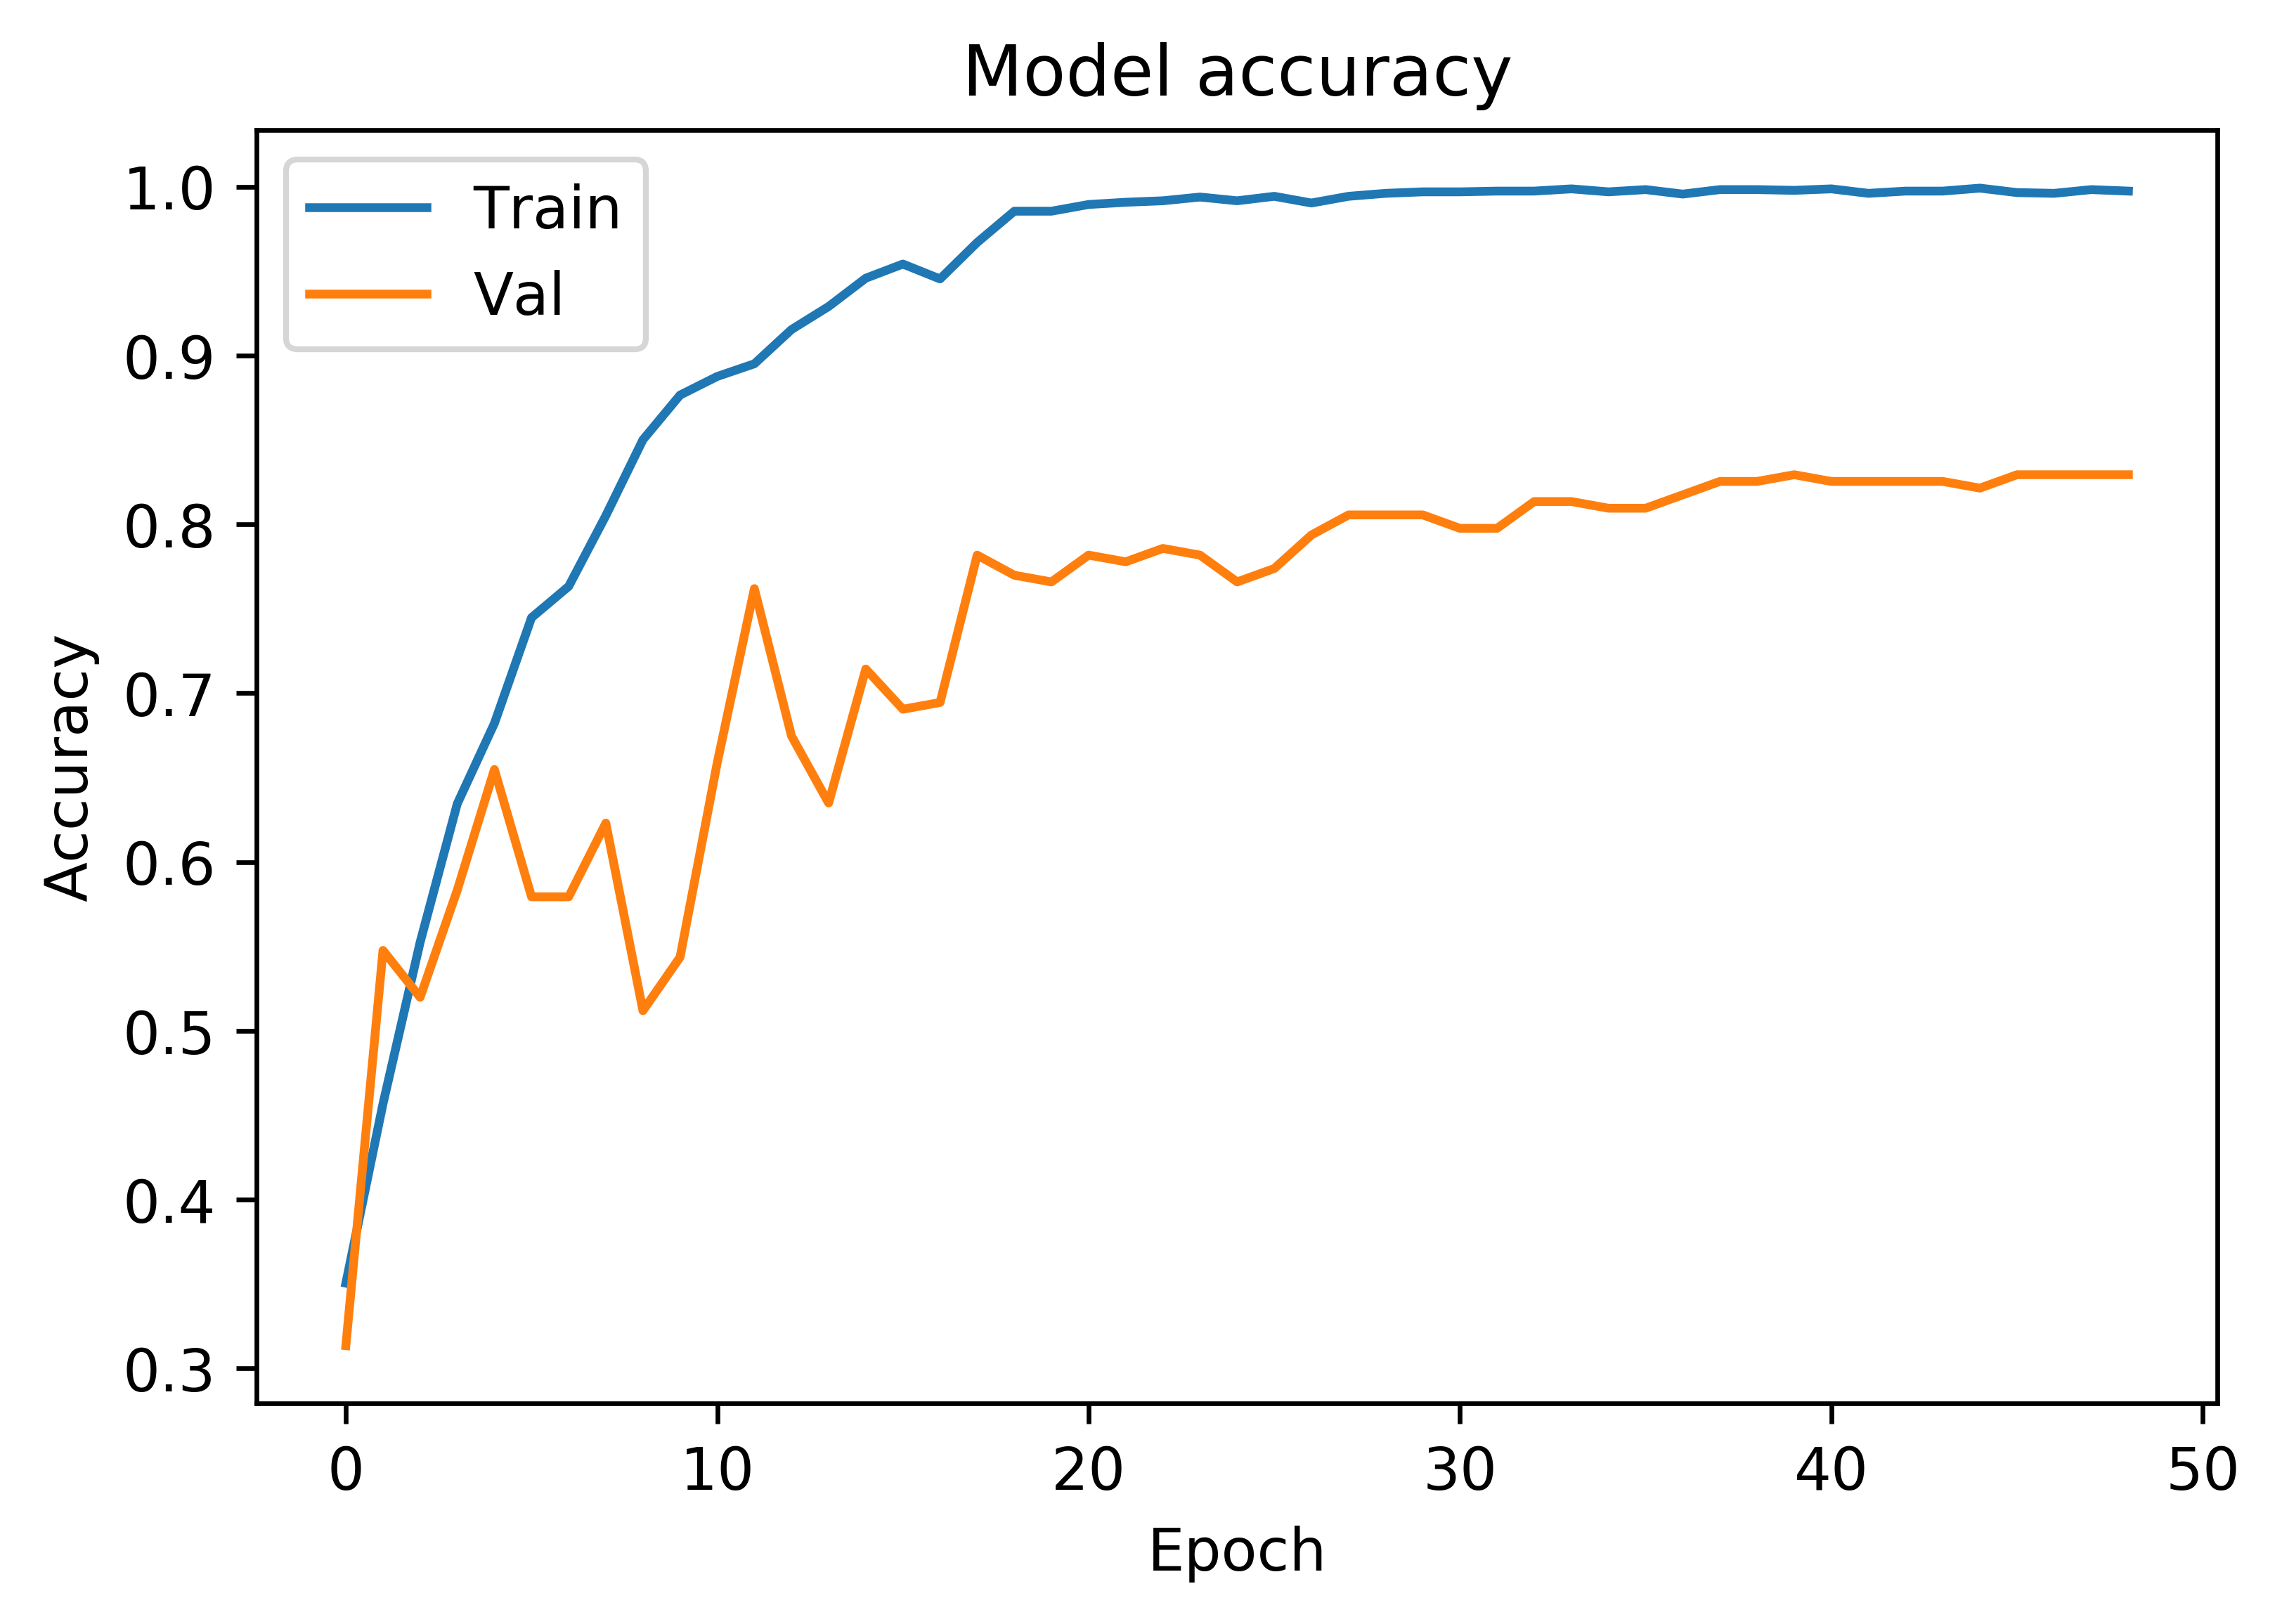

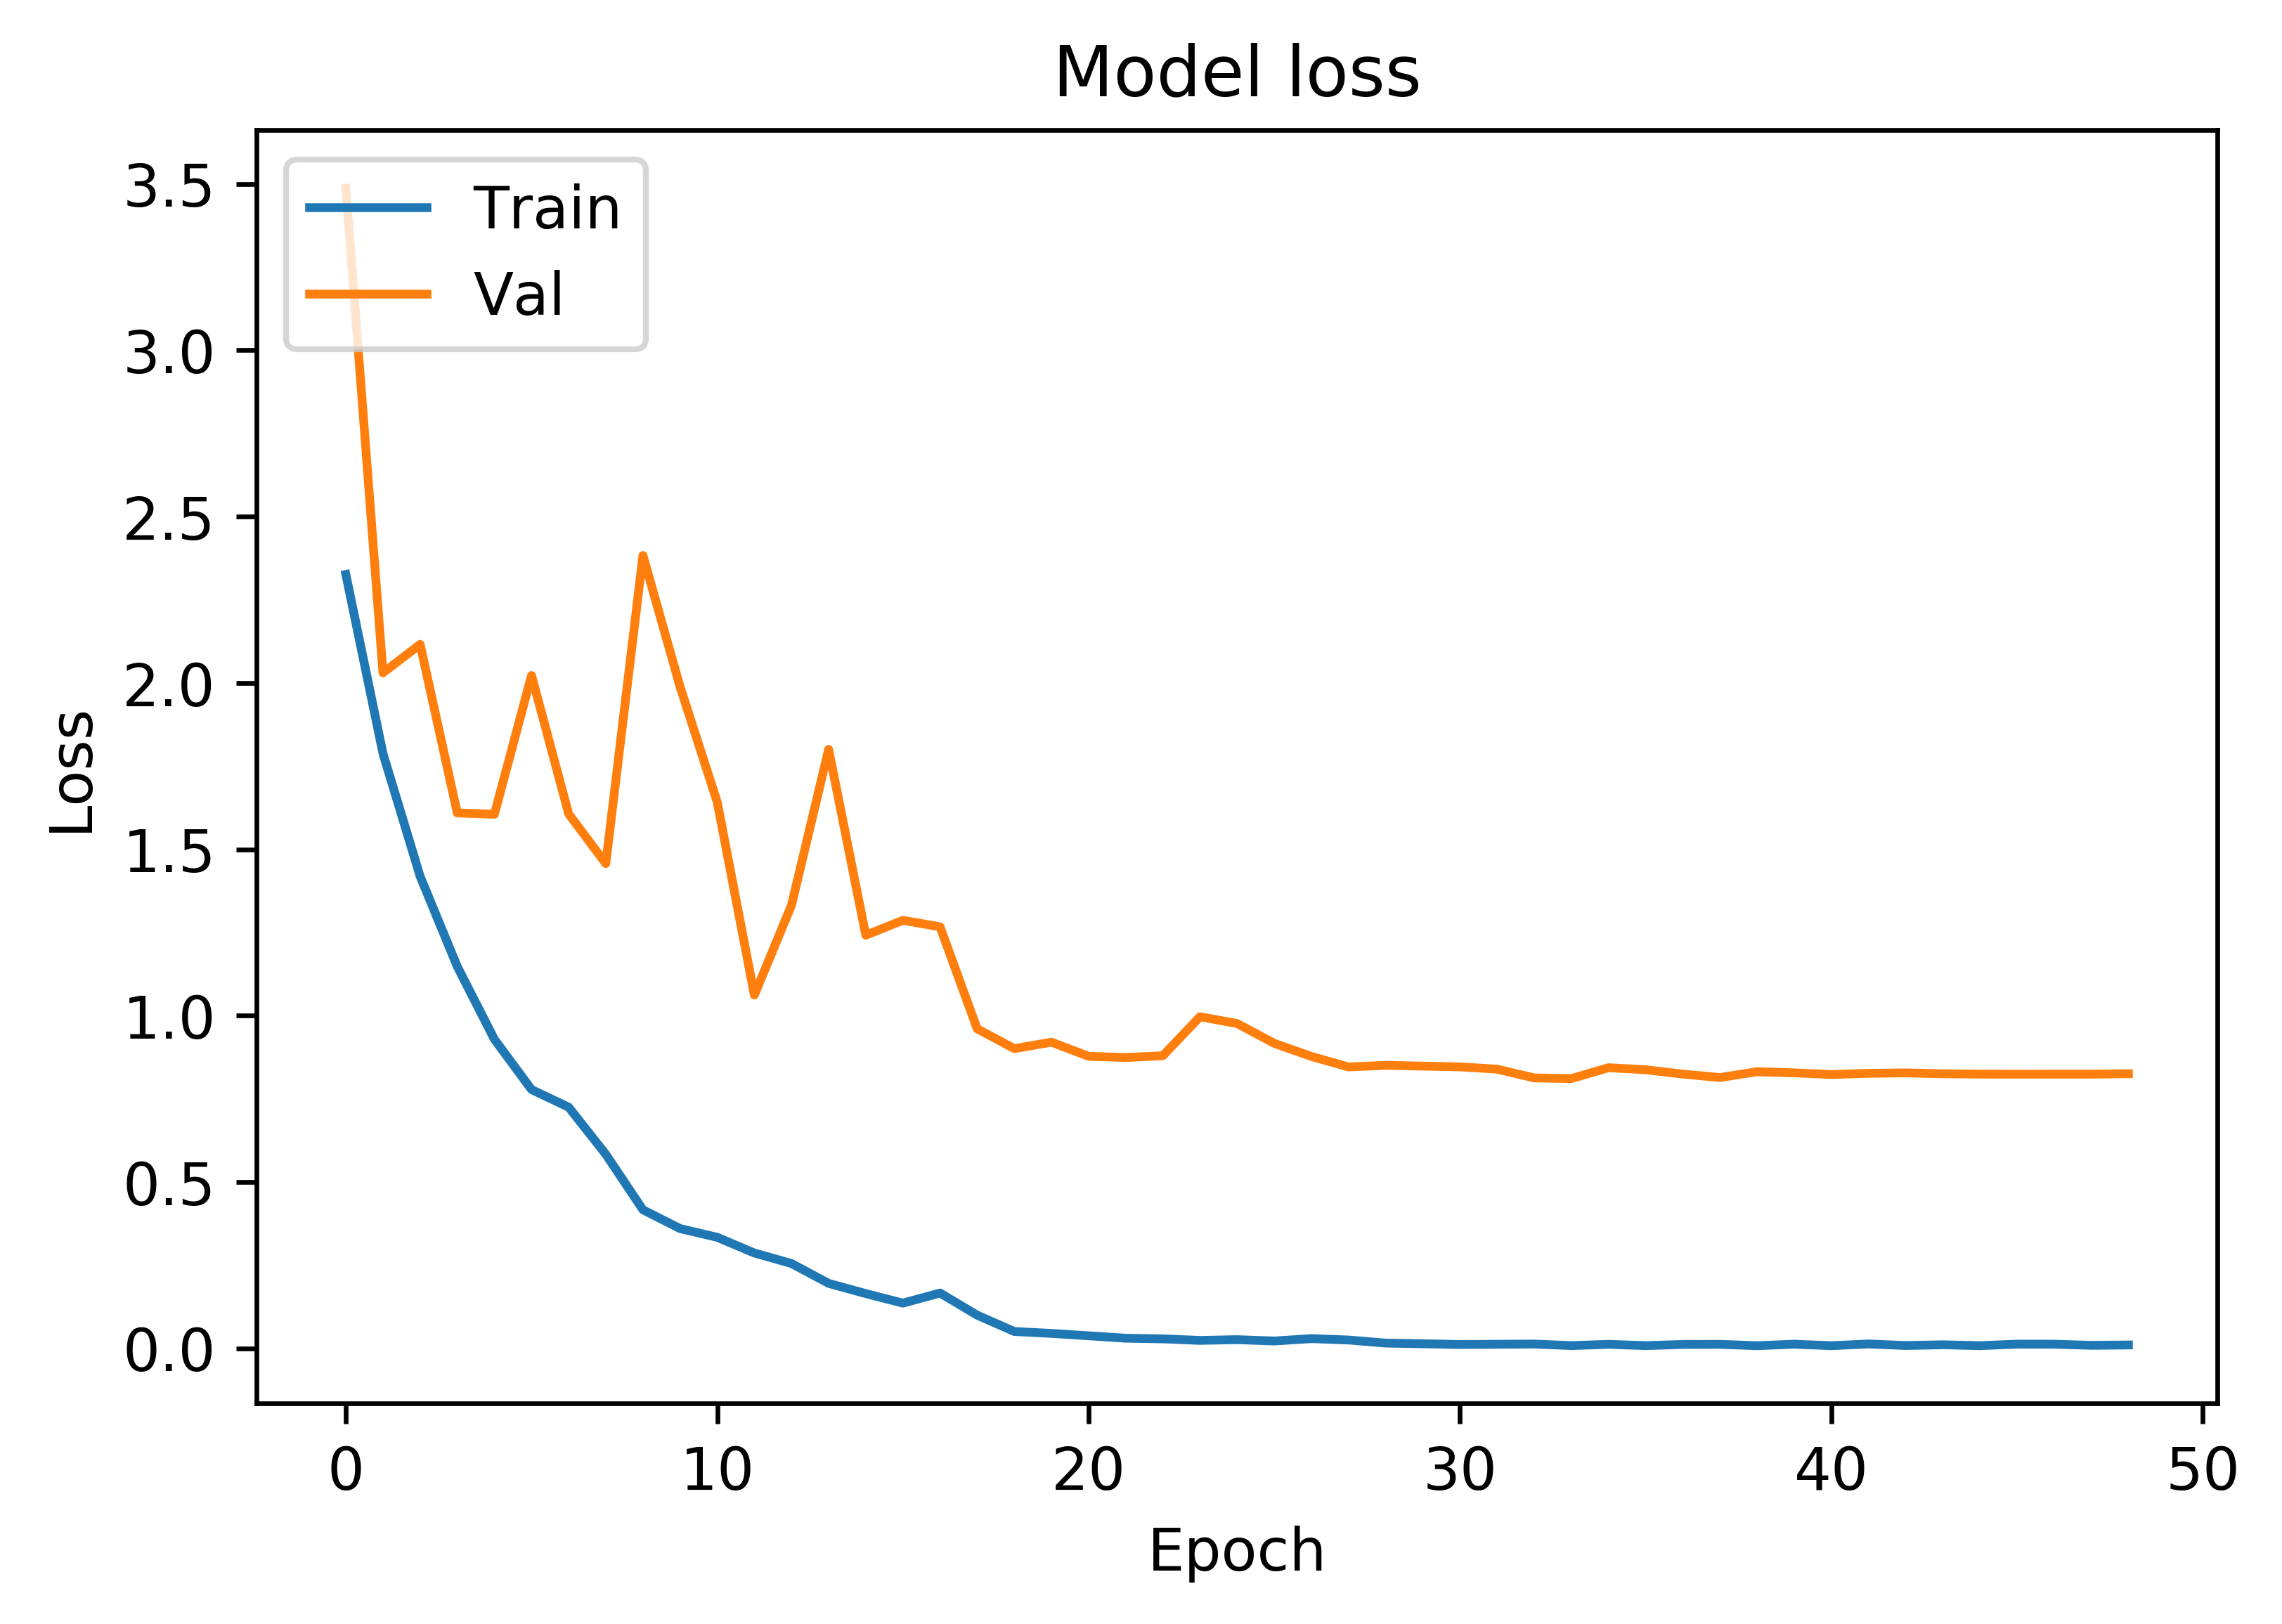

Results from K-fold: 4
acc: 81.73%
624/624 [==============================] - 0s 725us/step
[0.7516508014538349, 0.8173076923076923]
           bar  gel  network  plot  histology  sequence  line  molecular
bar         65    3        3     5          0         0     2          0
gel          2   73        2     1          0         0     0          0
network      0    1       59     5          1         2     2          8
plot         0    1        3    60          0         0    13          1
histology    0    2        0     0         74         0     0          2
sequence     3    3        6     0          2        62     1          1
line         1    1        5     8          2         0    58          3
molecular    0    0       11     0          6         0     2         59
              precision    recall  f1-score   support

         bar       0.92      0.83      0.87        78
         gel       0.87      0.94      0.90        78
     network       0.66      0.76      0.71    

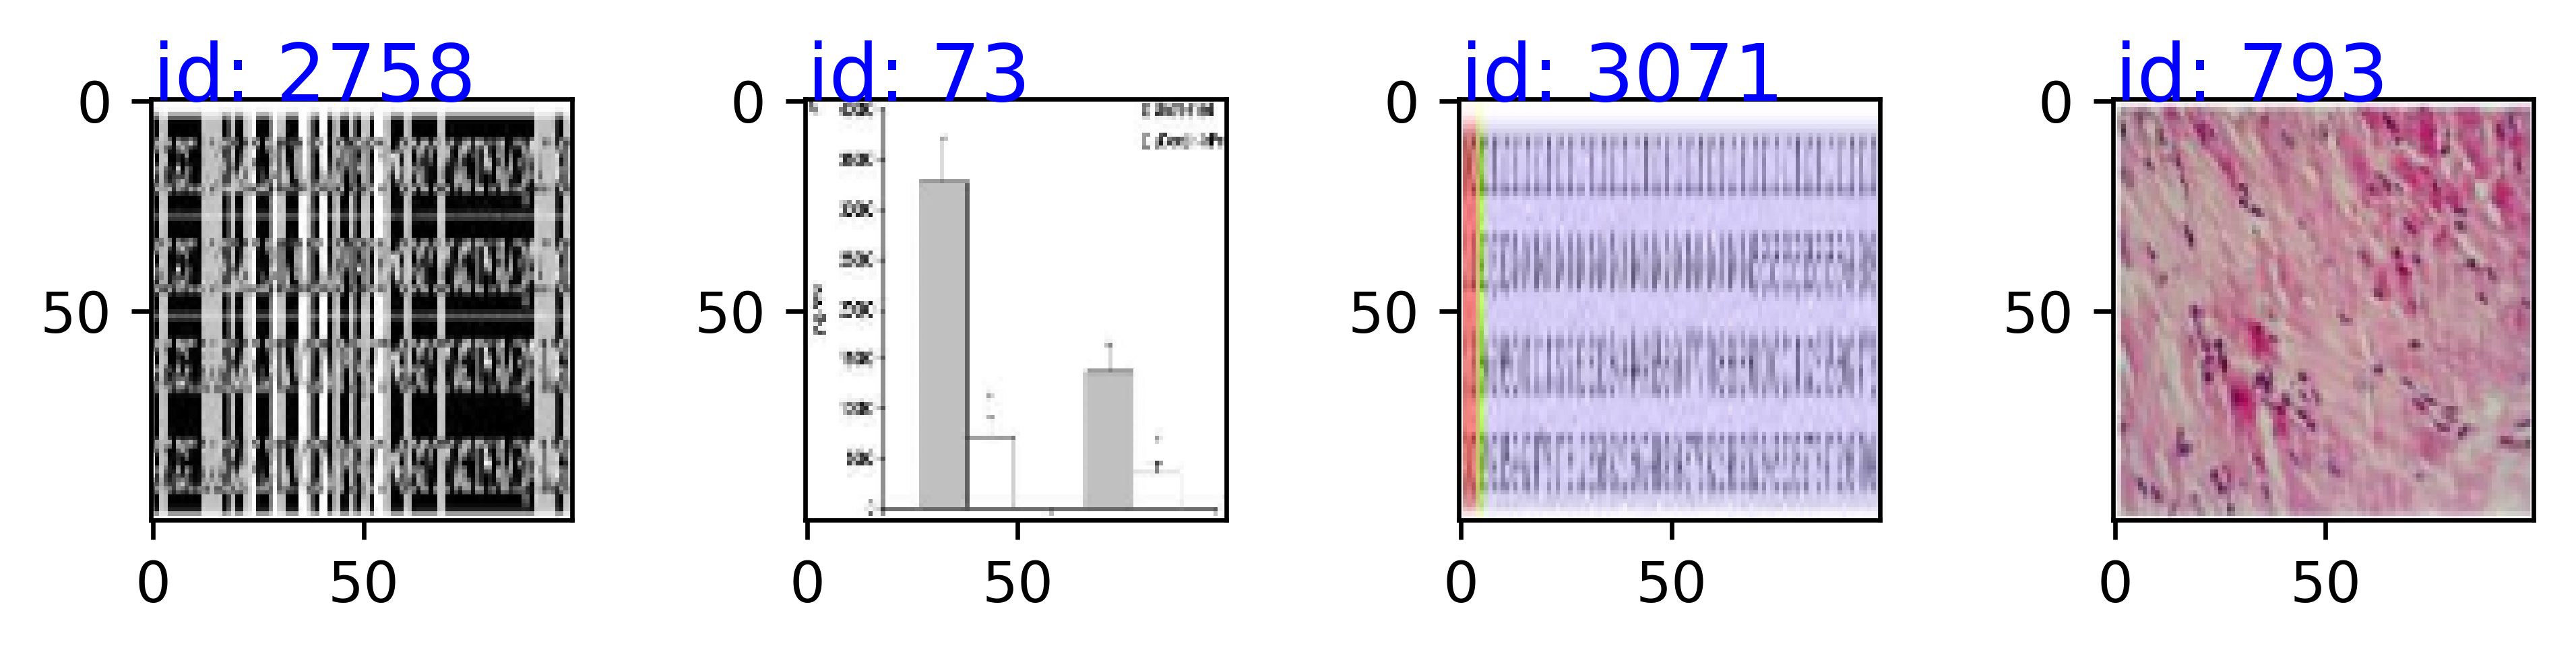

Samples from Testing
[   9   25 3136 3142]


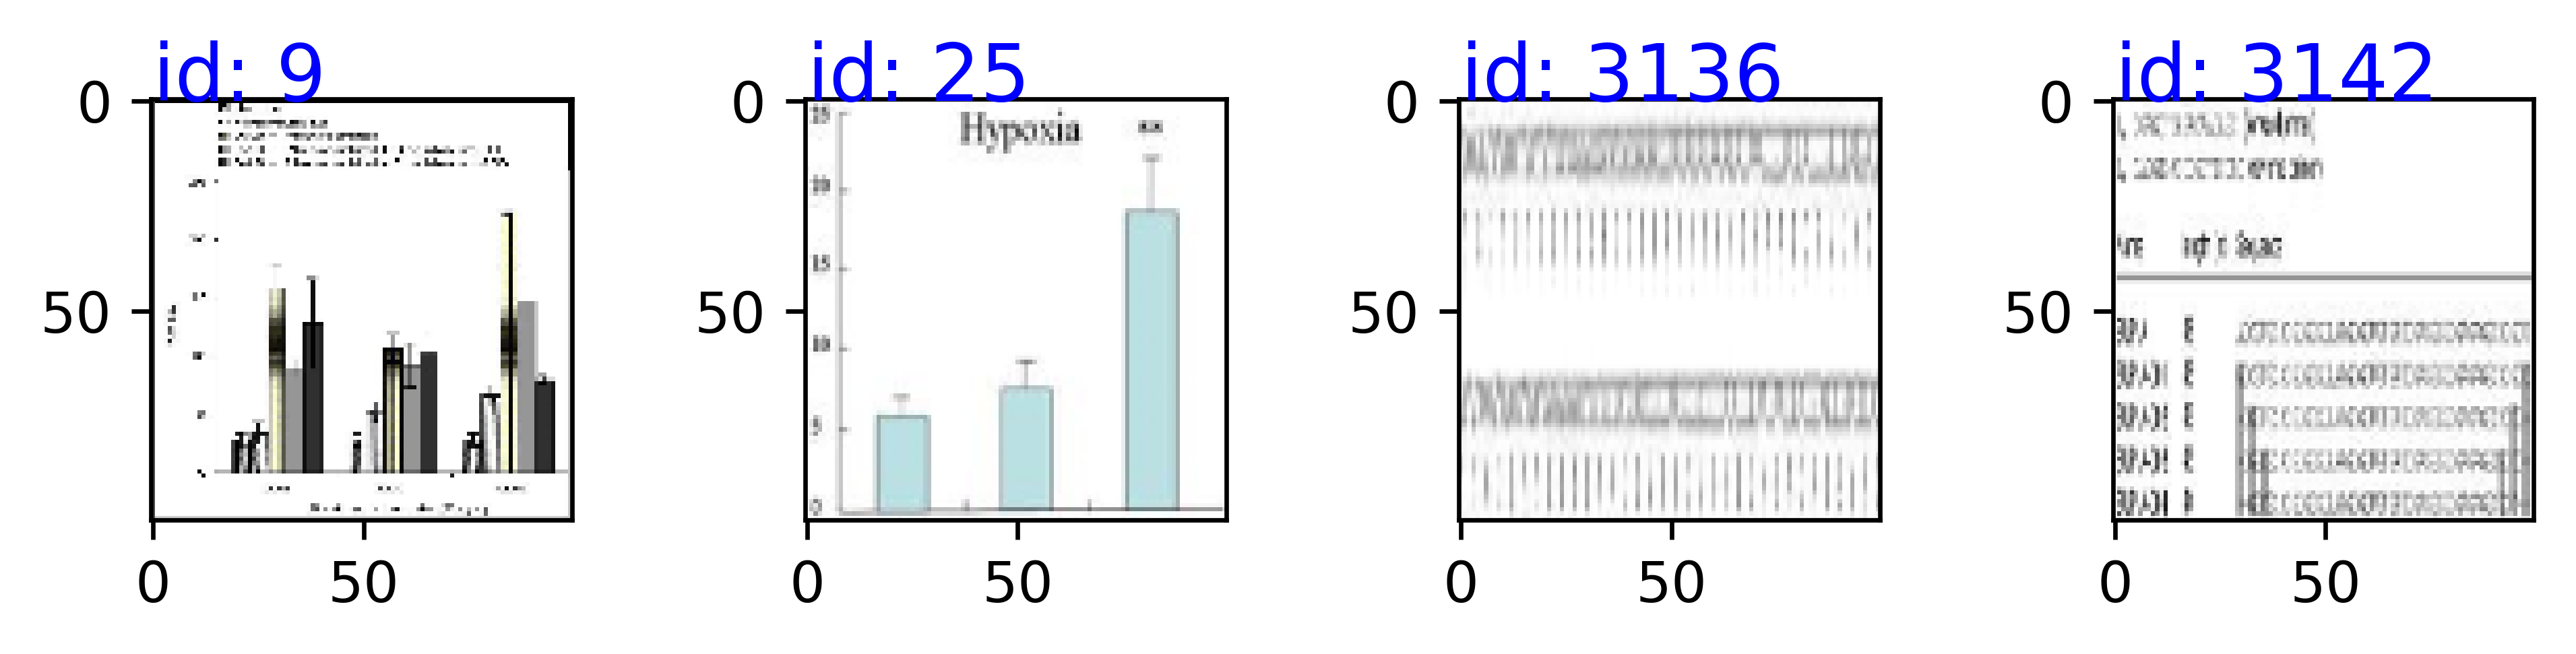

Train on 2268 samples, validate on 252 samples
Epoch 1/150
2268/2268 [==============================] - 8s 4ms/step - loss: 2.3723 - acc: 0.3232 - val_loss: 4.2633 - val_acc: 0.3413

Epoch 00001: val_acc improved from -inf to 0.34127, saving model to unimodal_weights/best_weight_image_only_k-fold_5.hdf5
Epoch 2/150
2268/2268 [==============================] - 4s 2ms/step - loss: 1.6702 - acc: 0.4815 - val_loss: 2.9186 - val_acc: 0.4802

Epoch 00002: val_acc improved from 0.34127 to 0.48016, saving model to unimodal_weights/best_weight_image_only_k-fold_5.hdf5
Epoch 3/150
2268/2268 [==============================] - 4s 2ms/step - loss: 1.3051 - acc: 0.5869 - val_loss: 1.8316 - val_acc: 0.5595

Epoch 00003: val_acc improved from 0.48016 to 0.55952, saving model to unimodal_weights/best_weight_image_only_k-fold_5.hdf5
Epoch 4/150
2268/2268 [==============================] - 4s 2ms/step - loss: 1.1033 - acc: 0.6376 - val_loss: 1.9677 - val_acc: 0.5397

Epoch 00004: val_acc did not improve 

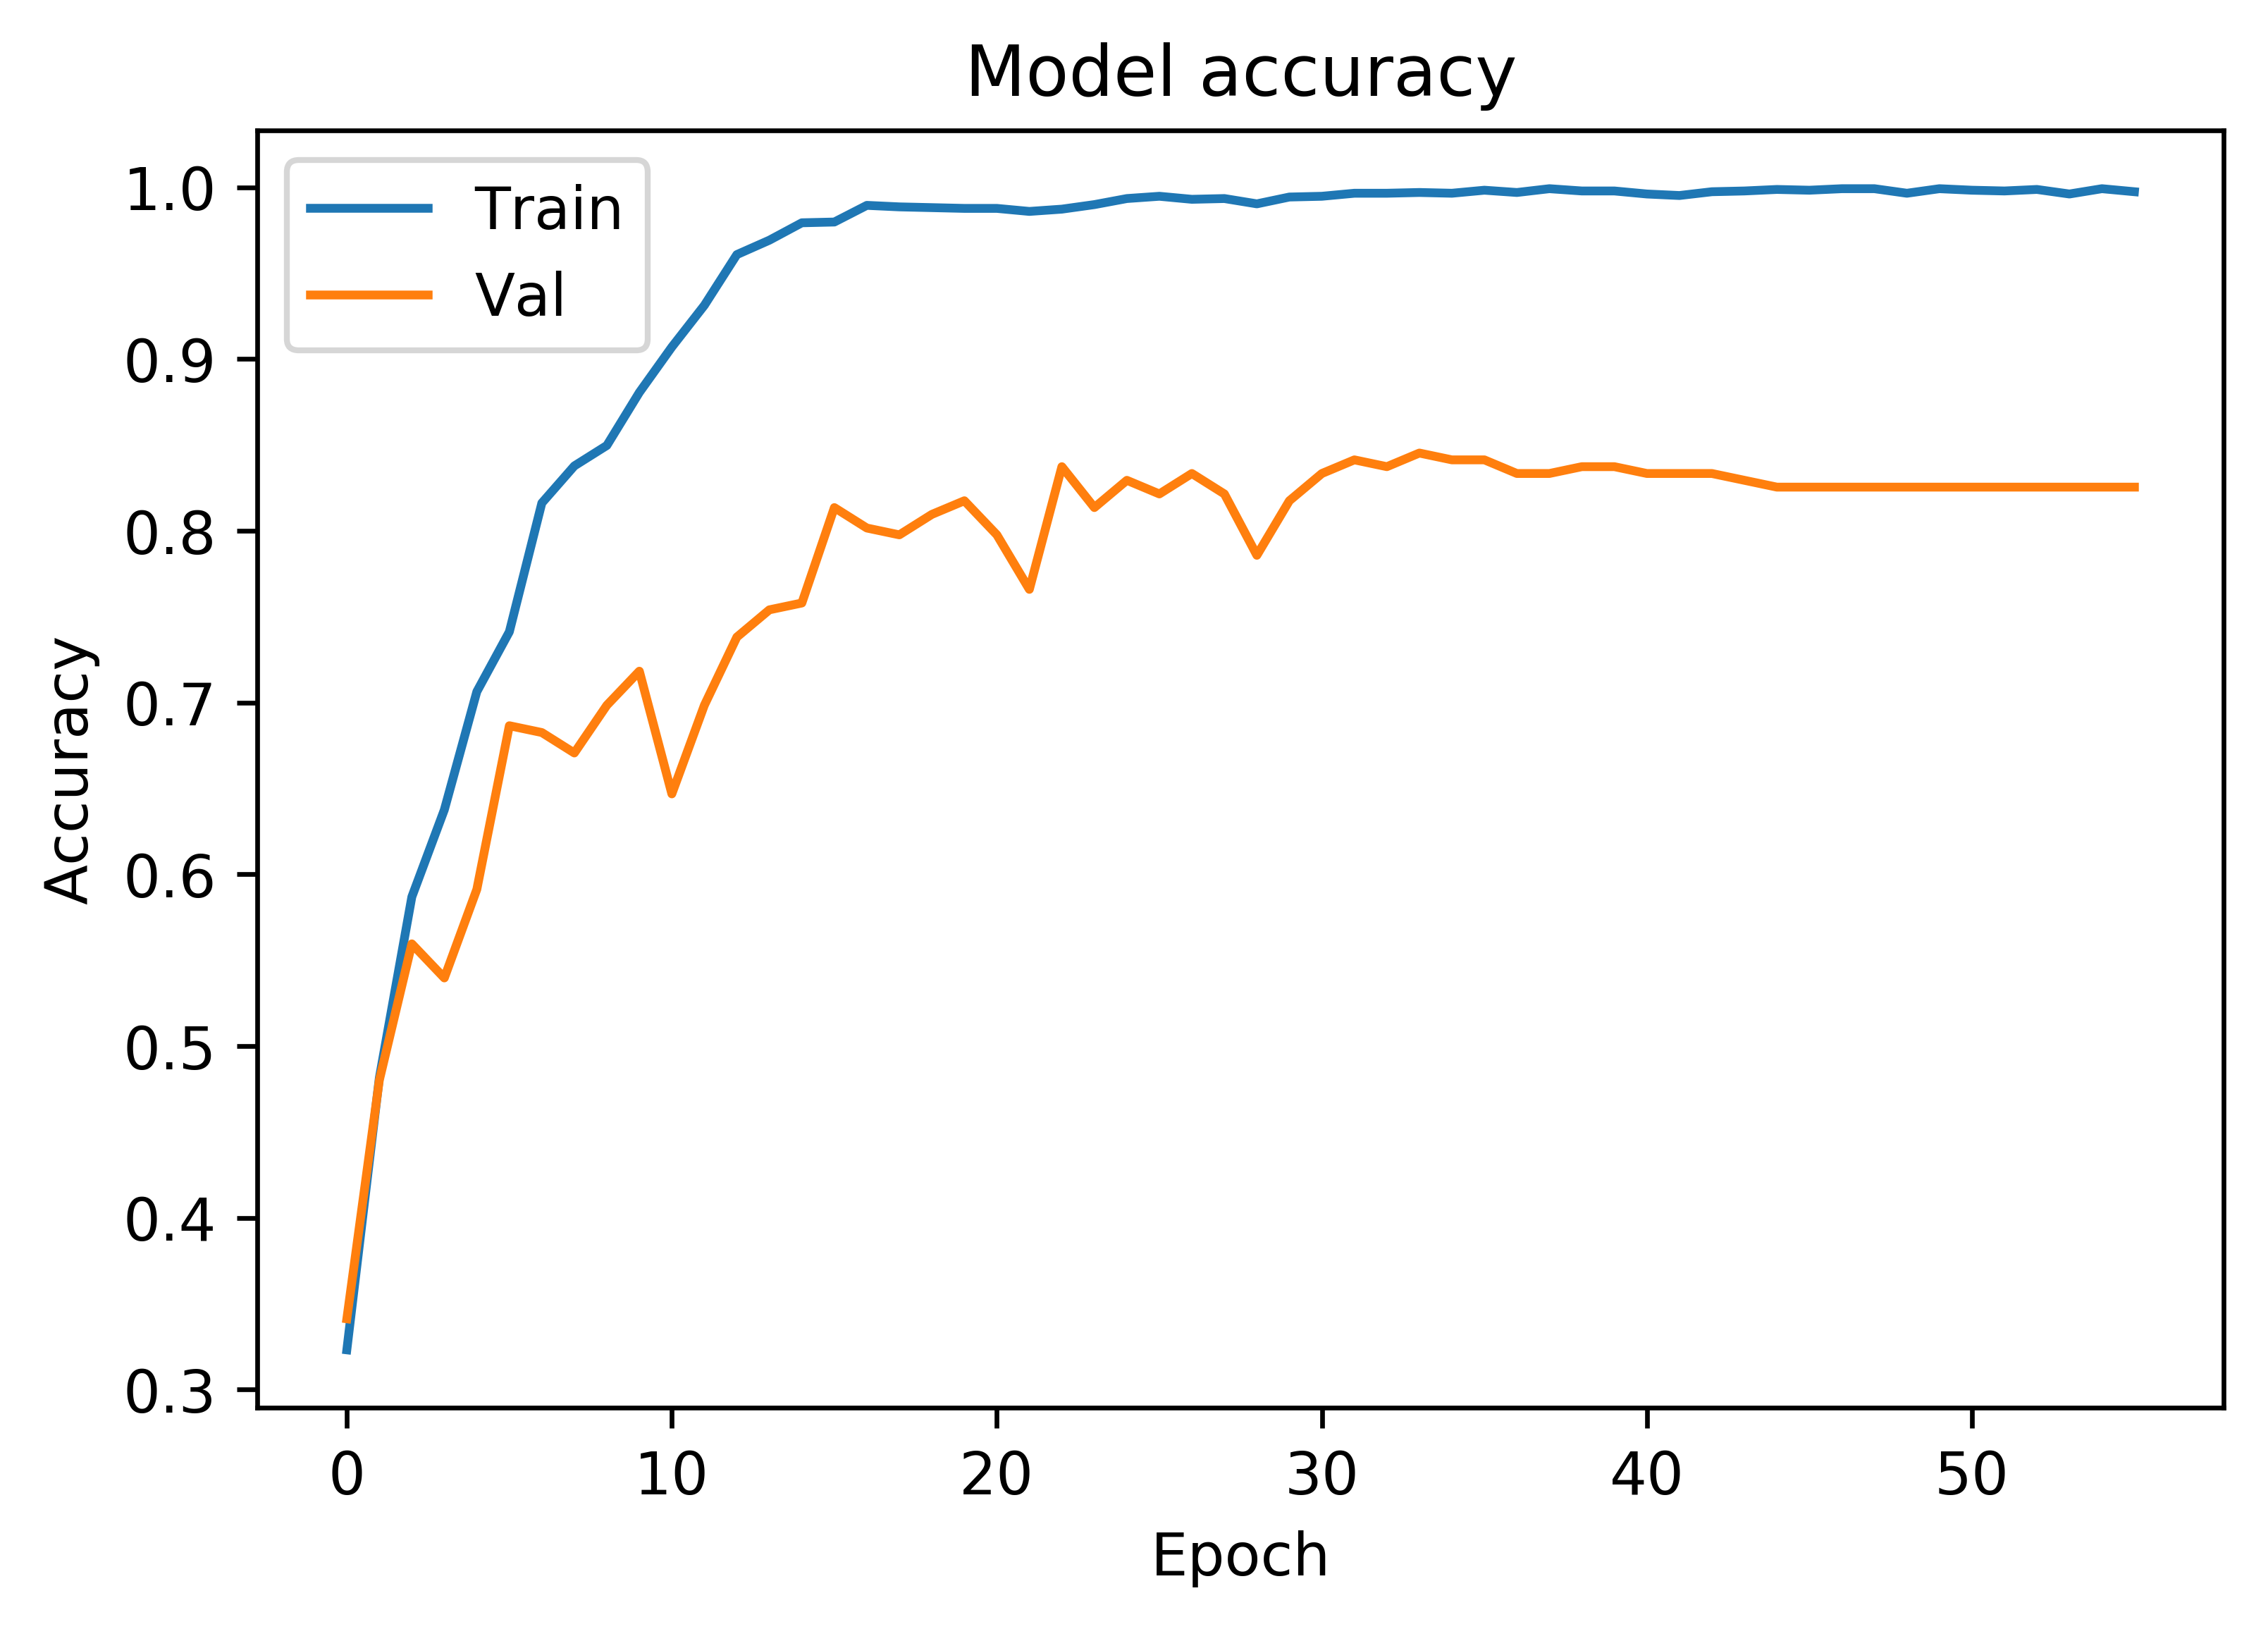

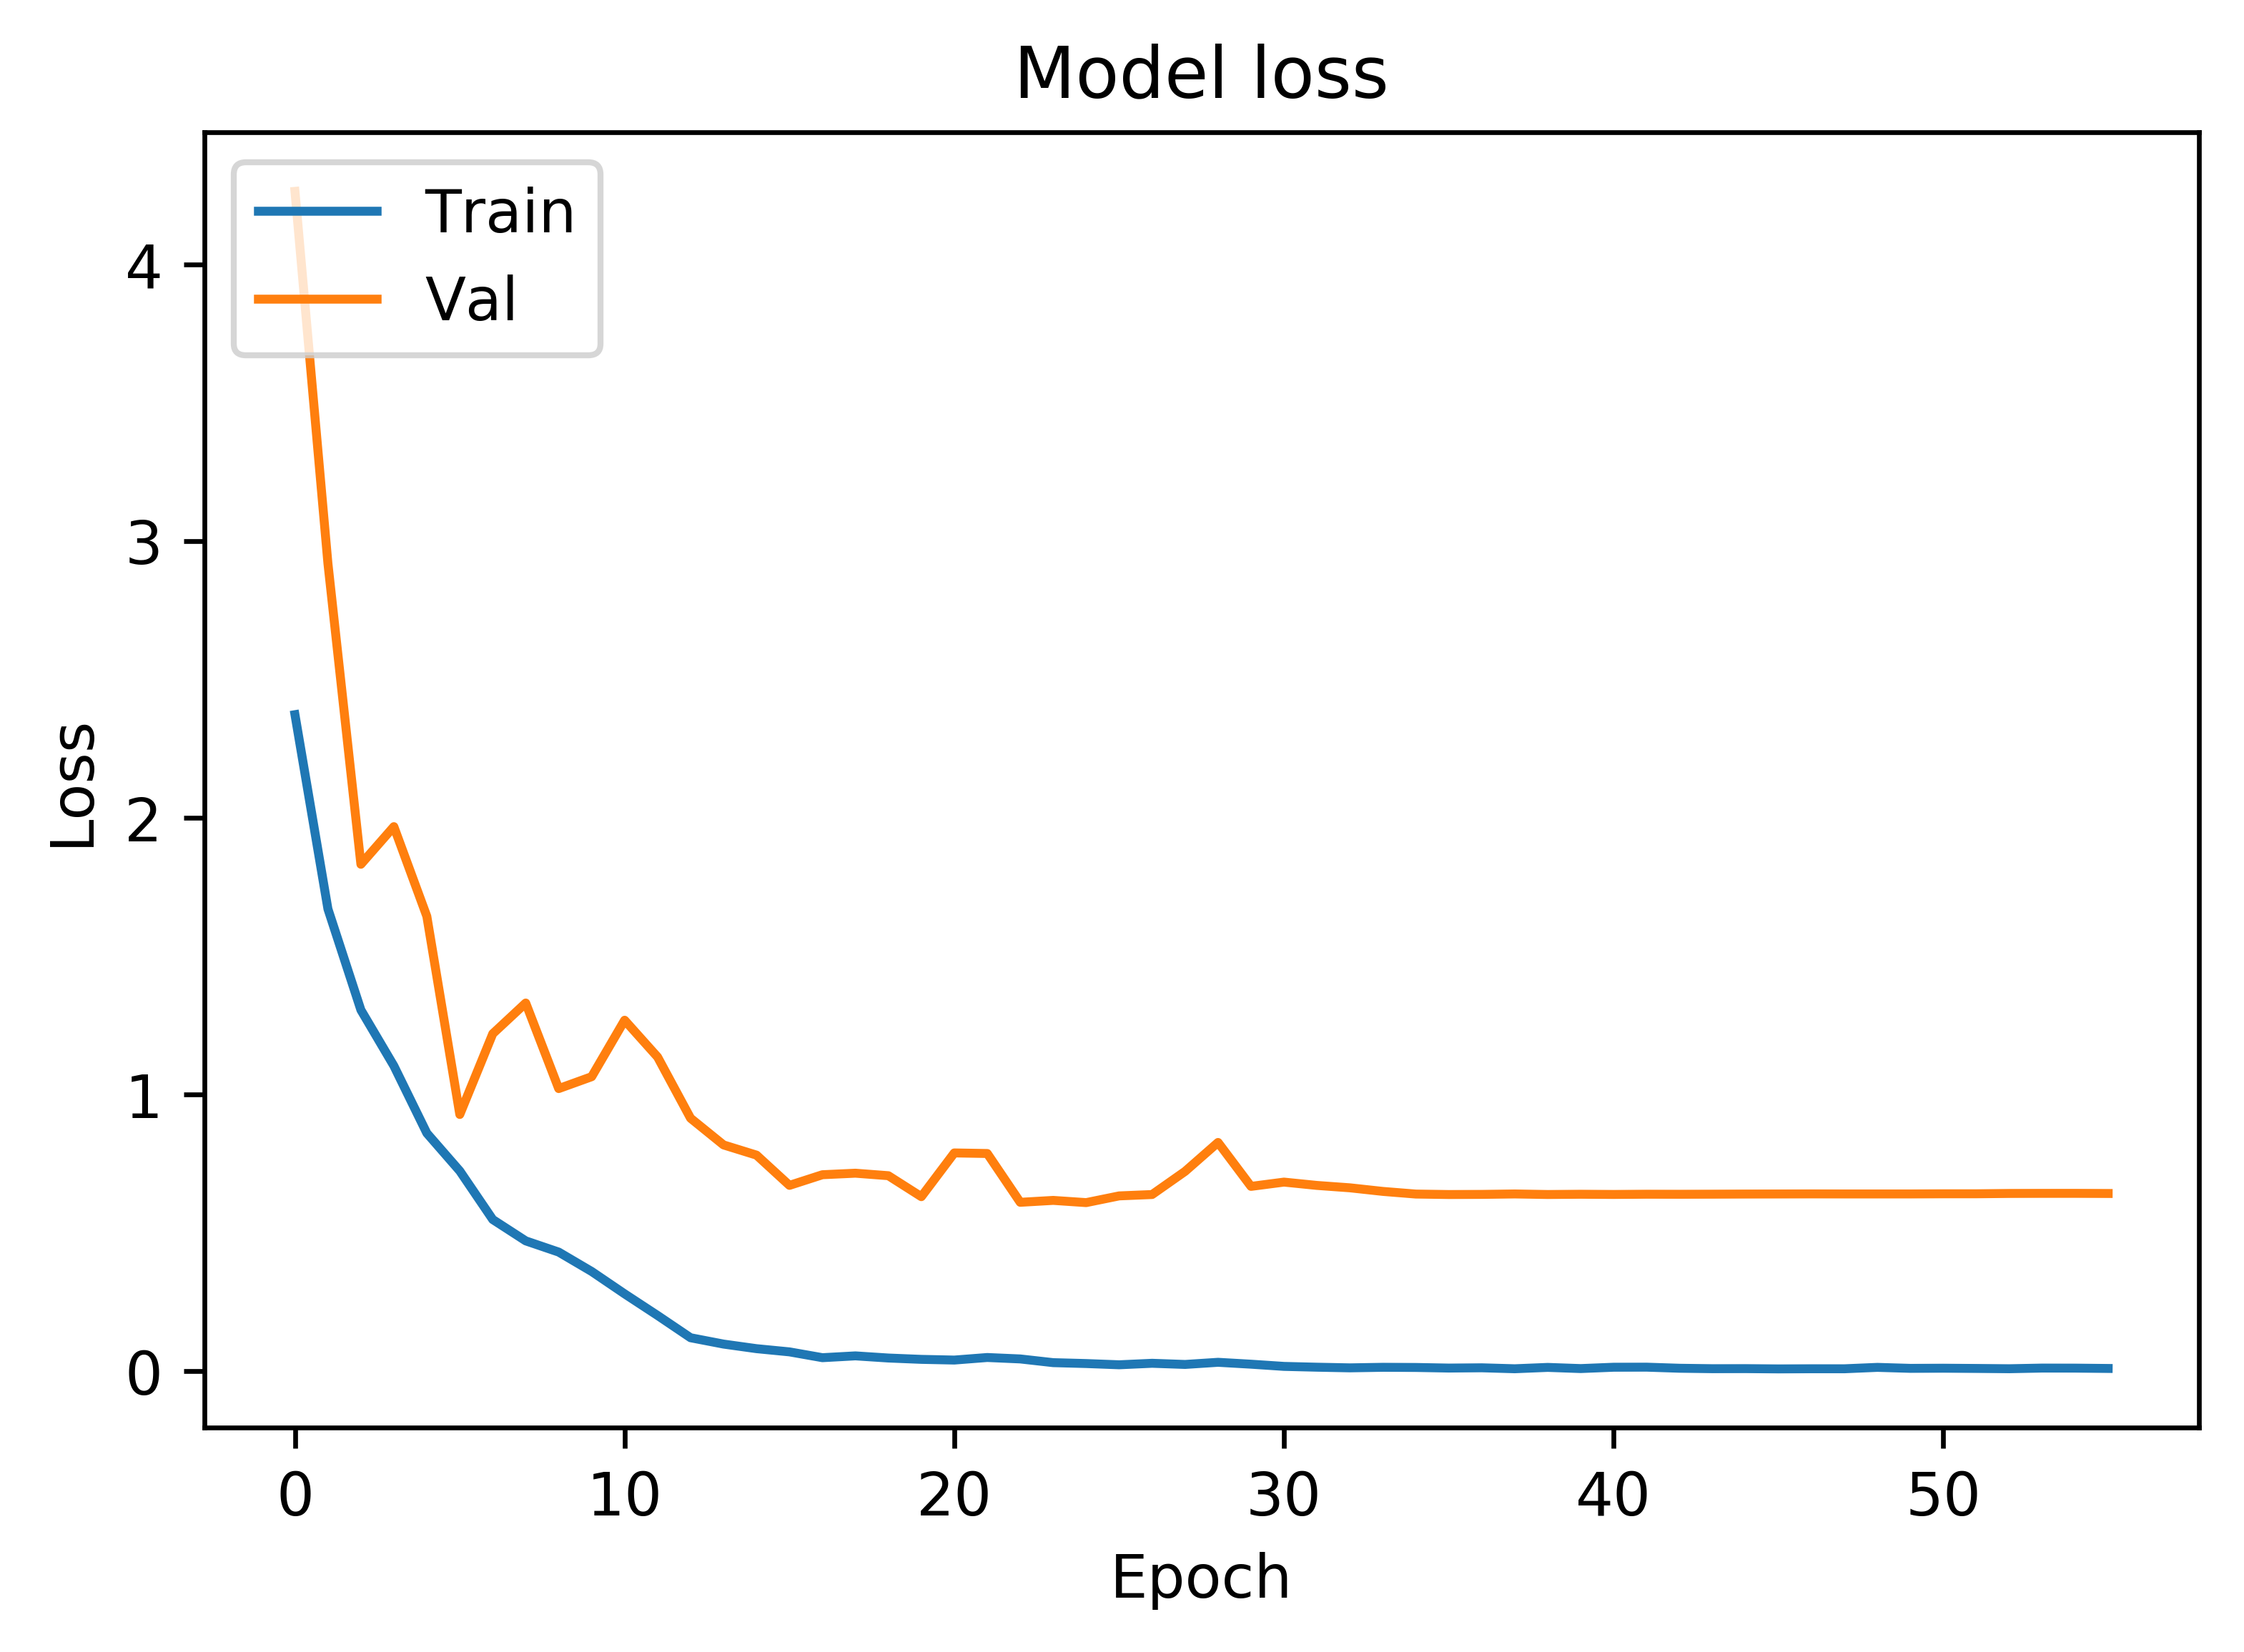

Results from K-fold: 5
acc: 78.53%
624/624 [==============================] - 1s 878us/step
[0.7826540657343009, 0.7852564102564102]
           bar  gel  network  plot  histology  sequence  line  molecular
bar         65    4        4     2          1         0     2          0
gel          1   68        1     3          2         1     1          1
network      3    1       55     1          3         6     3          6
plot         3    1        4    55          0         0    14          1
histology    0    0        1     0         74         0     0          3
sequence     0    1       12     0          0        63     1          1
line         2    0        8    14          2         2    45          5
molecular    0    0        9     0          3         0     1         65
              precision    recall  f1-score   support

         bar       0.88      0.83      0.86        78
         gel       0.91      0.87      0.89        78
     network       0.59      0.71      0.64    

In [12]:
#set K folds to 5

cvscores = []
count = 1
confusion_matrix_list = []
report_list = []

for key, val in kfolds.items():
    print(key)
    train = val['train']
    test = val['test']
    
    print('K-: {}'.format(key))
            
    print("Samples from Training")
    print_samples(samples=train, images=X_image)
    print("============================")
    
    print("Samples from Testing")
    print_samples(samples=test, images=X_image)
    print("============================")
    
    image_model = Generate_Model(model_type = "image")
    image_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    filepath="unimodal_weights/best_weight_image_only_k-fold_{}.hdf5".format(count)
    checkpoint = MultiGPUCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [reduce_lr, checkpoint, early_stopping]

    history = image_model.fit([X_image[train]], y[train], 
                     epochs=epochs, batch_size=bs, validation_split=0.1, callbacks=callbacks_list)
    plot_model_history(history)
    filepath="unimodal_weights/final_weight_image_only_k-fold_{}.hdf5".format(count)
    image_model.save_weights(filepath)
    scores = image_model.evaluate([X_image[test]], y[test], verbose=0)
    print('Results from K-fold: {}'.format(count))
    print("%s: %.2f%%" % (image_model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
    y_hat = test_model(image_model, zip(X_image[test], y[test]), image = True, text = False, 
                       class_names=class_names)
    cm = confusion_matrix([np.argmax(t) for t in y[test]], y_hat)
    confusion_matrix_list.append(pd.DataFrame(cm, index=class_names, columns=class_names))
    cr = classification_report([np.argmax(t) for t in y[test]], y_hat, target_names=class_names)
    report_list.append(classification_report_df(cr))
    count += 1
    print('================================================')
print('Average for kfold accuracy and stdev')
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
print("Average classification report for all folds")
print(df_mean(report_list))

### K fold validation on text_1d only

fold_1
K-: fold_1
Samples from Training
[ 193 2405  830 1032]
id: 193
distribution average daily pain trial entry 
id: 2405
purity assessment cd - cd - lin- cell fractions purities cd cd - cell factions respectively b purities cd cd - fractions respectively c purities lin- lin cell factions respectively cd - cd - cell populations defined first gating forward side scatter properties excluding platelets debris subsequent gates set exclude control cells labeled isotype-specific antibody percentages indicating purity isolated cell fractions shown plots abbreviations ssc side scatter igg immunoglobulin pe phycoerythrin 
id: 830
- 
id: 1032
electron microscopic analysis limited single membrane containing degraded material 
Samples from Testing
[   1    5 3139 3143]
id: 1
effects prenyltransferase inhibitors estrogen response element-dependent luciferase activity heln cells transfected estrogen receptor er er cells deprived estradiol e days co-transfected renilla luciferase plasmid either heg

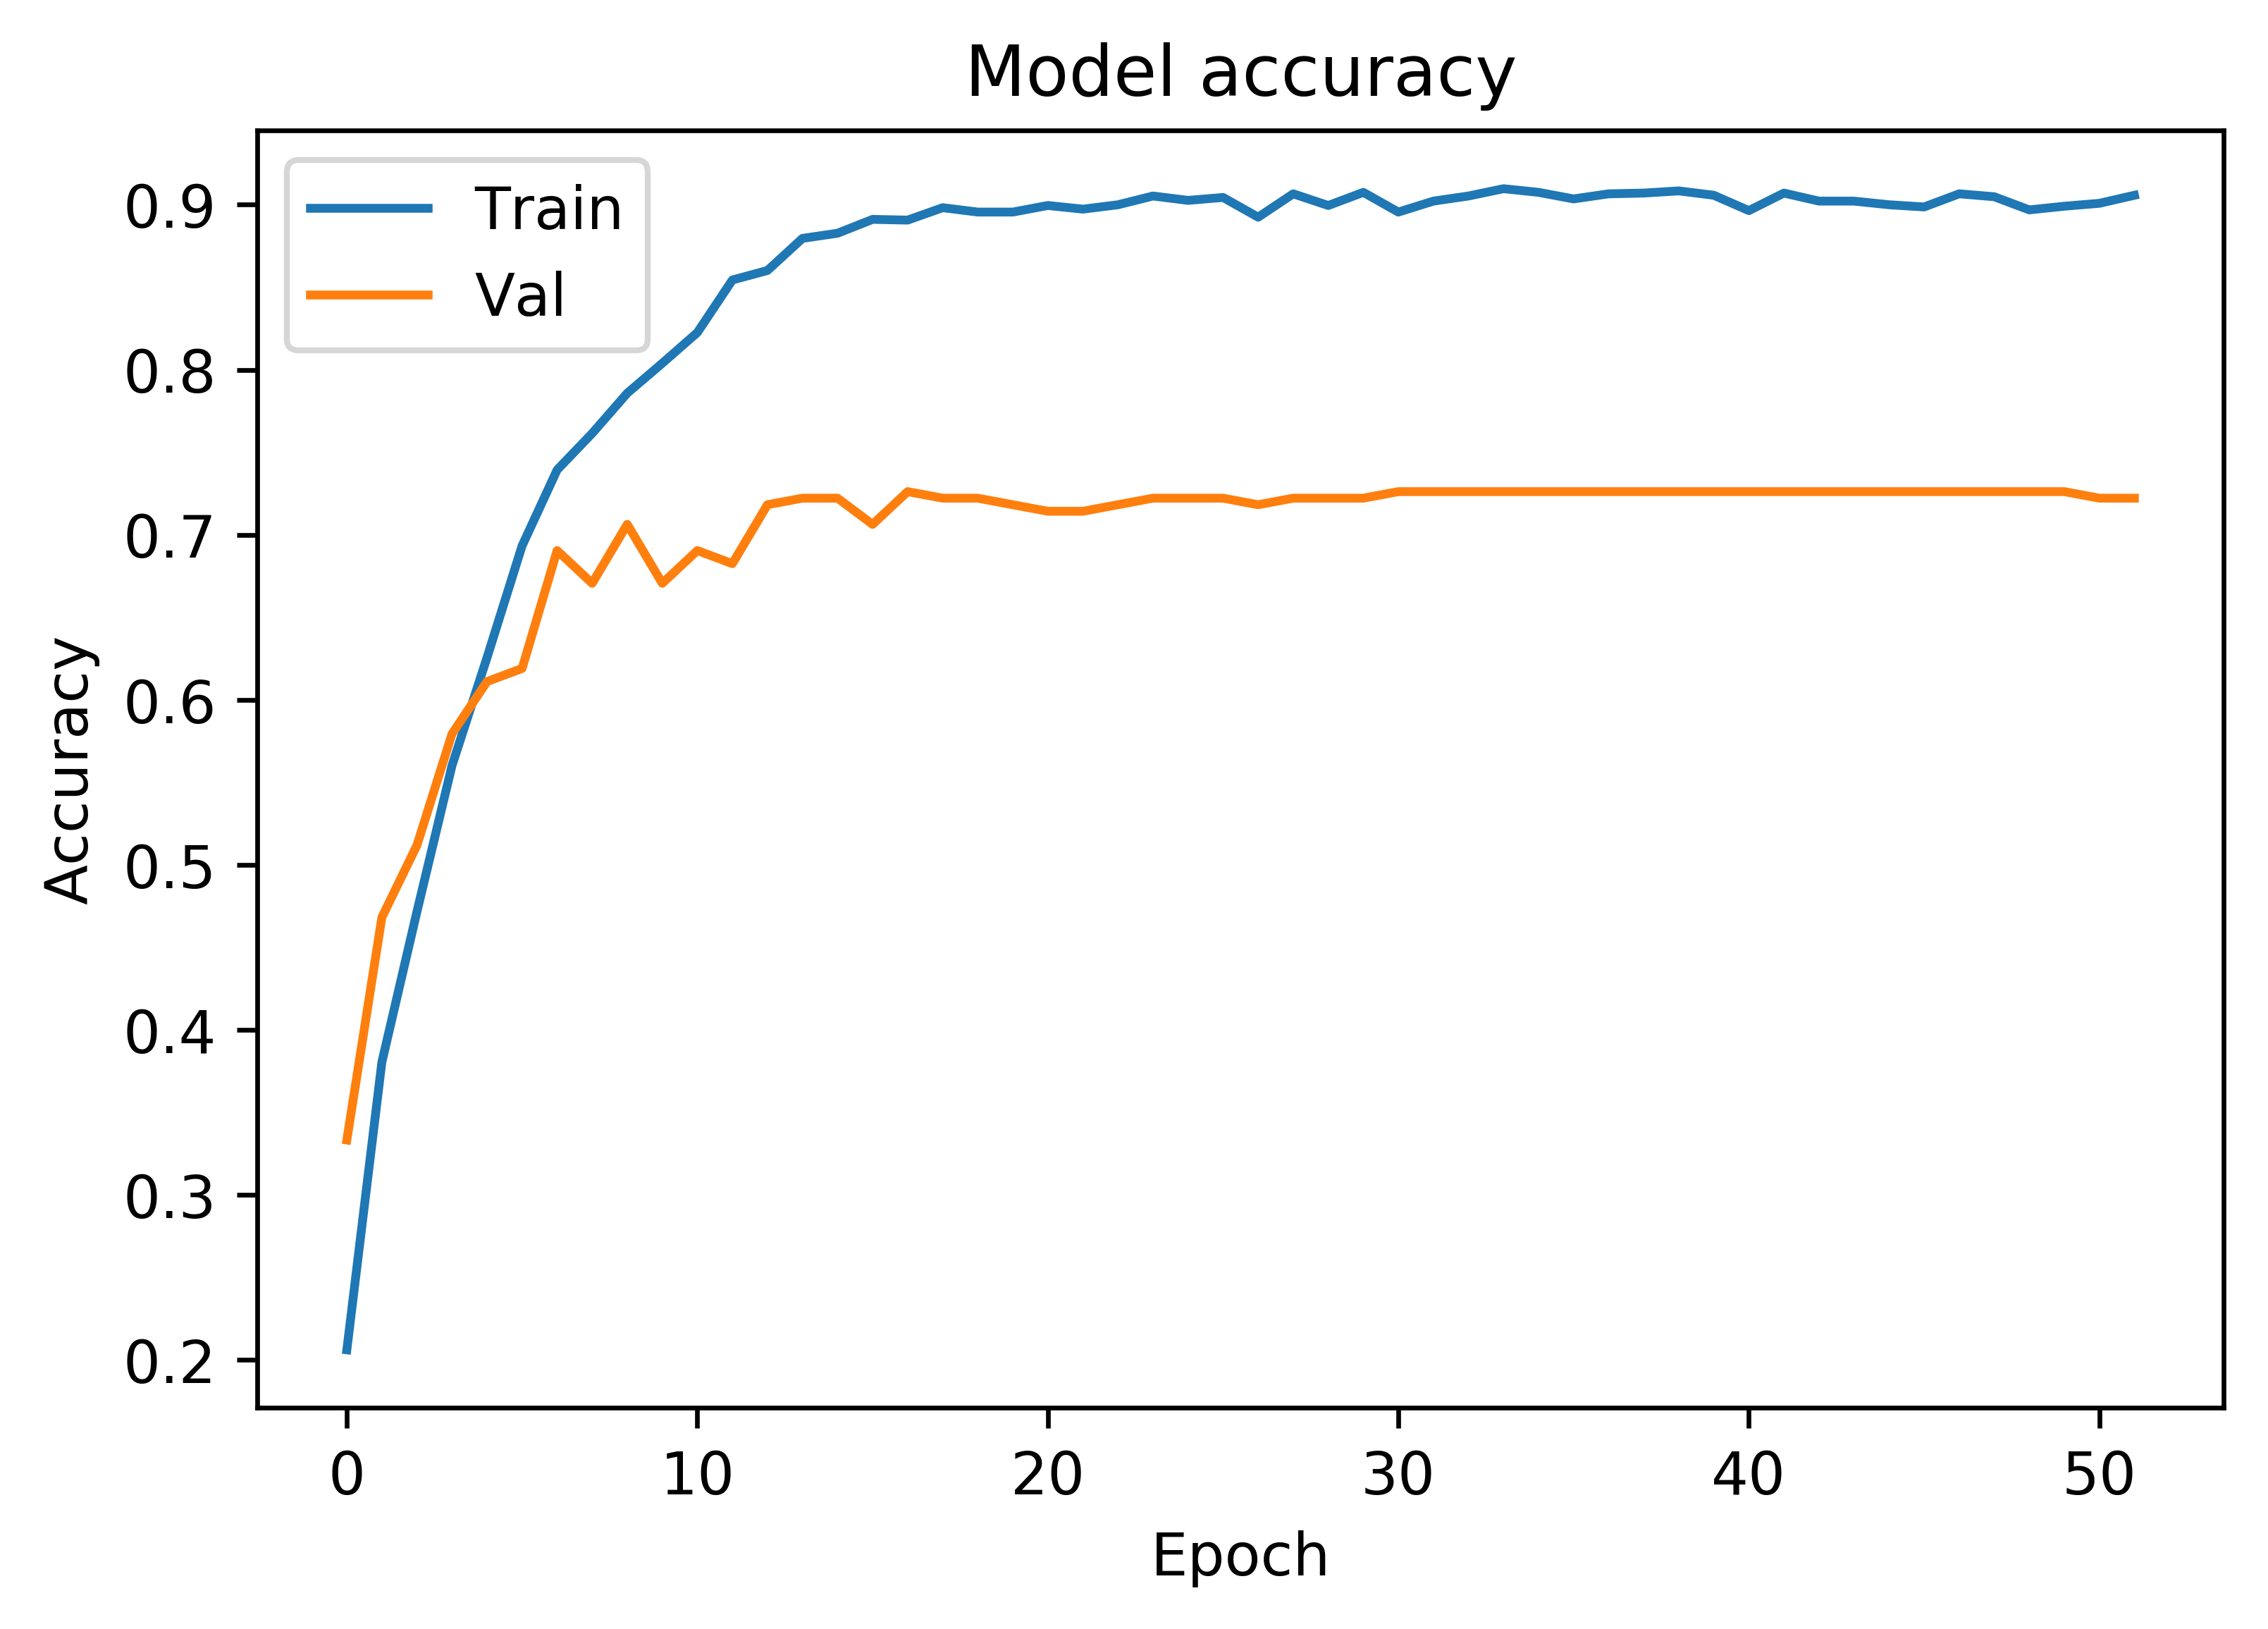

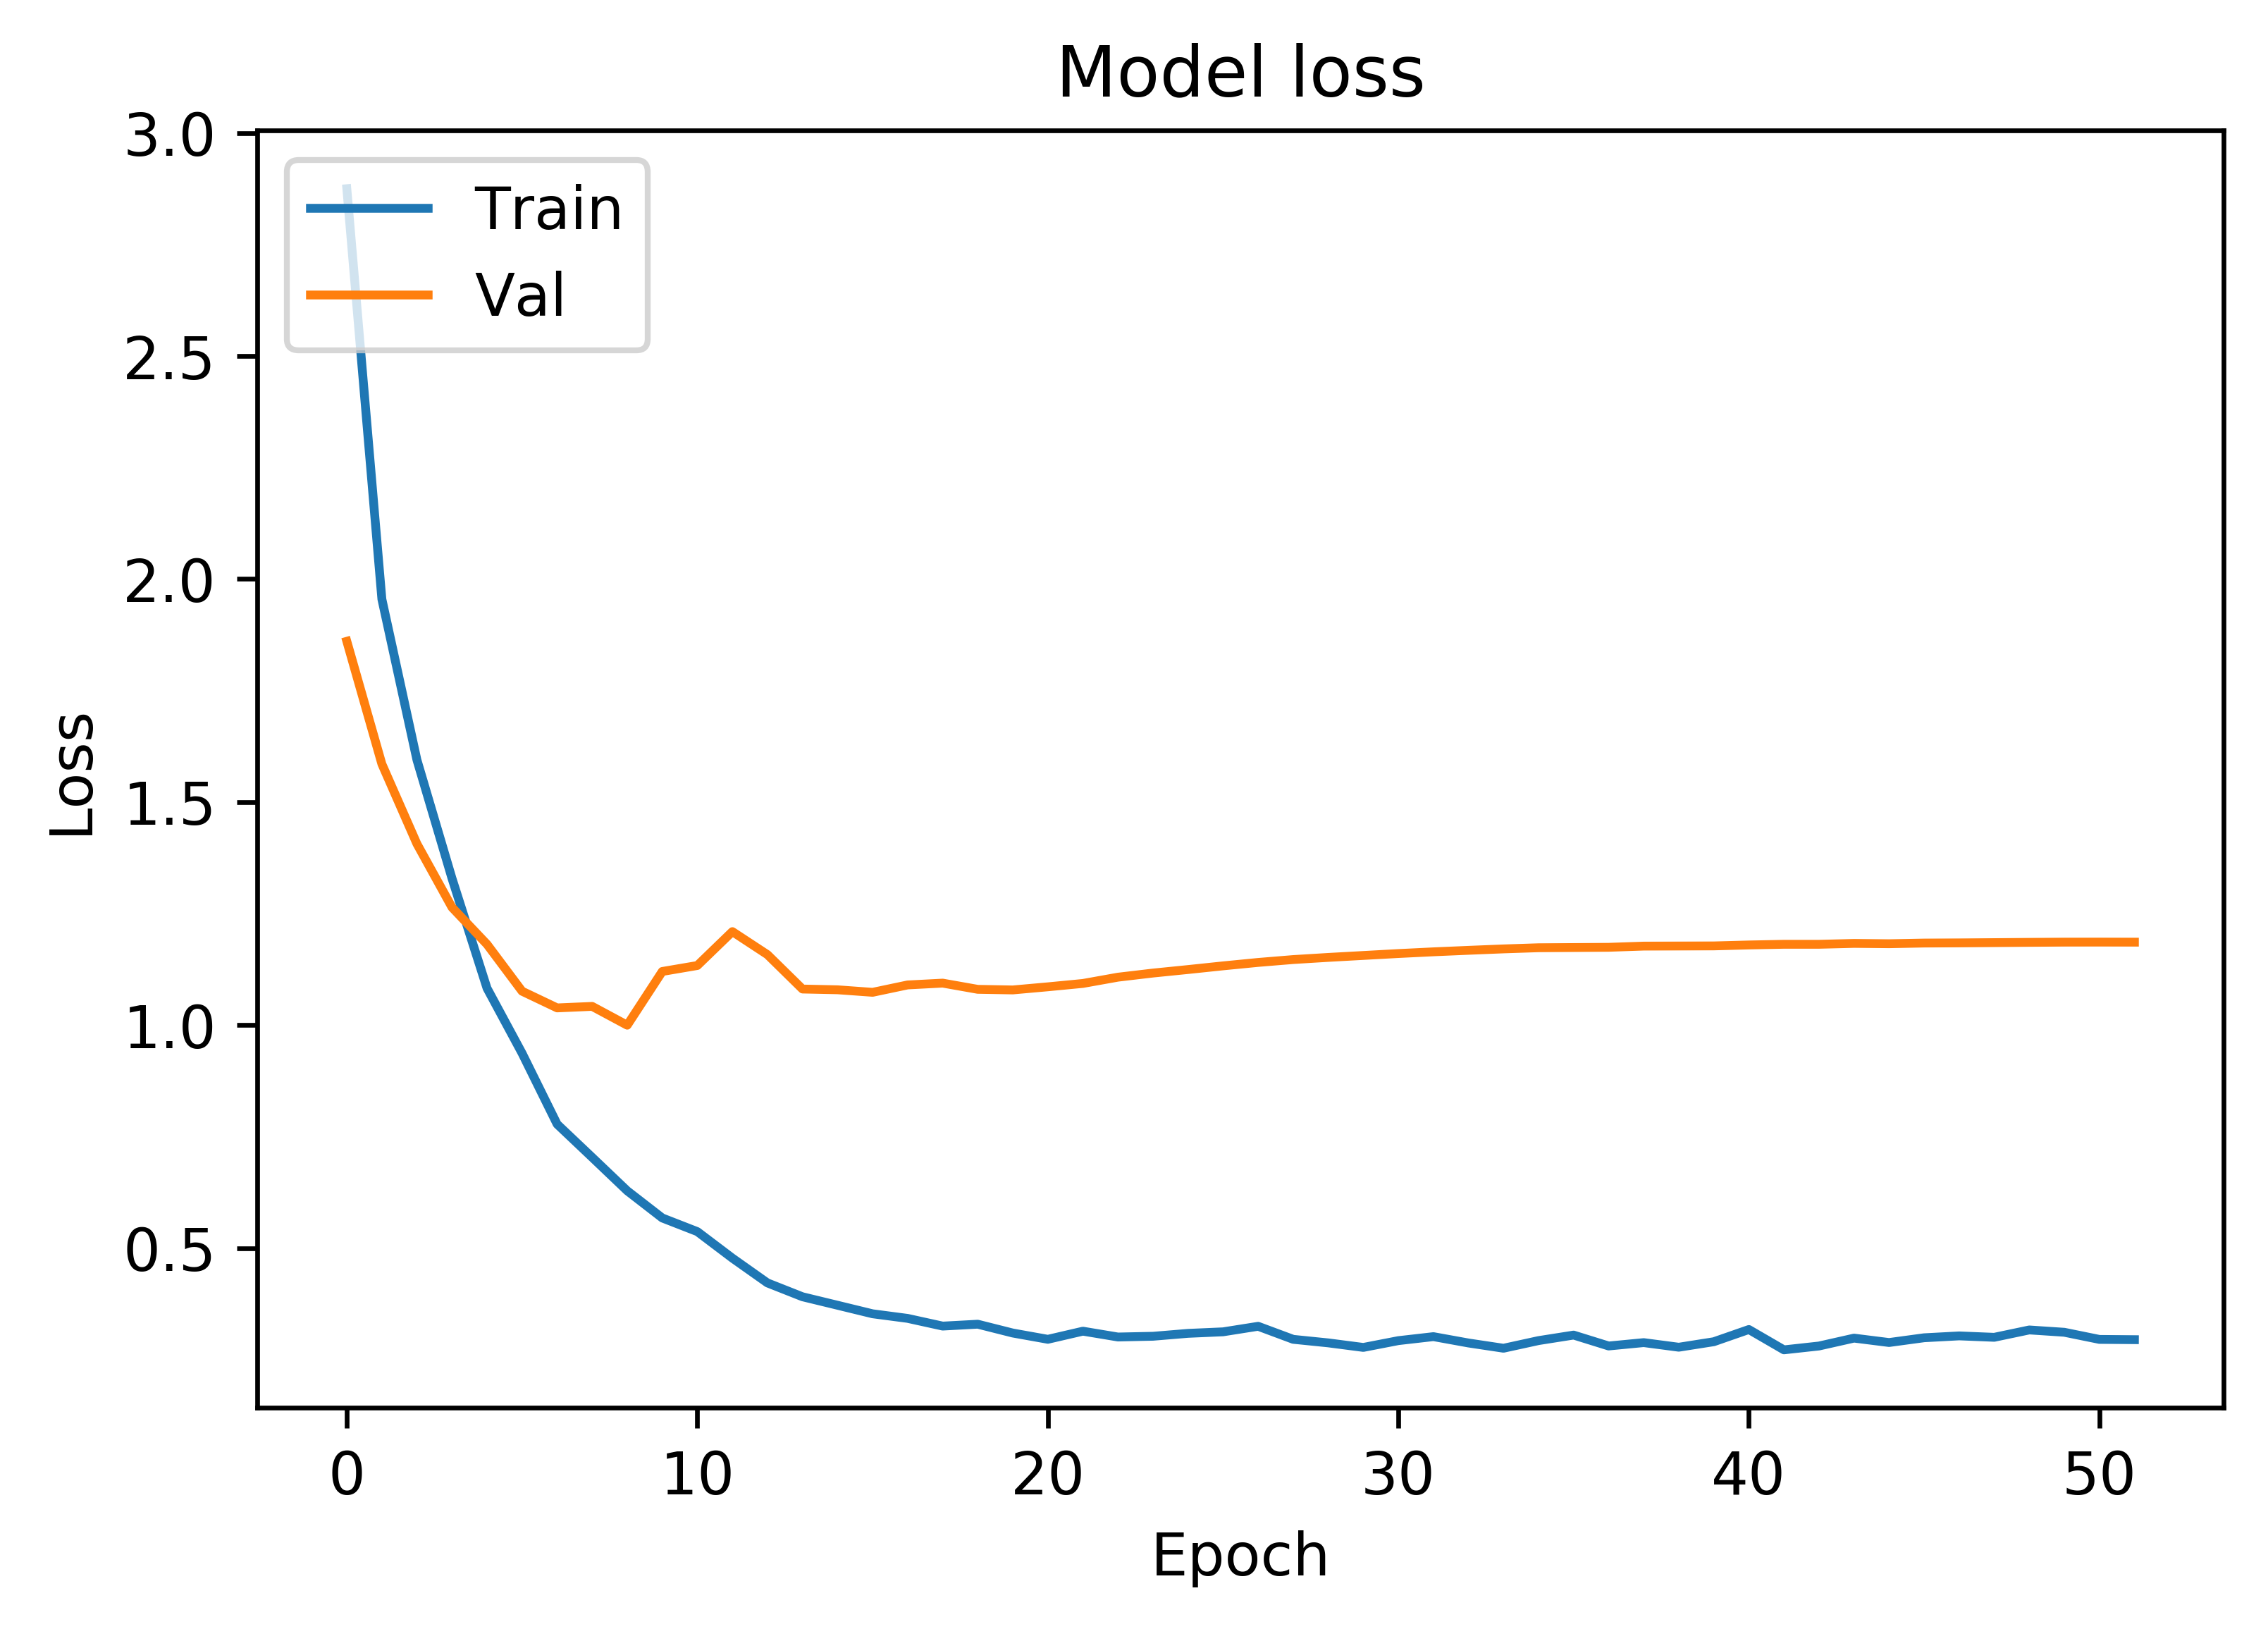

Results from K-fold: 1
acc: 77.37%
632/632 [==============================] - 0s 95us/step
[0.9900949054126498, 0.773734177969679]
           bar  gel  network  plot  histology  sequence  line  molecular
bar         41    9        0    13          8         1     5          2
gel          2   62        1     1          7         3     3          0
network      1    0       63     3          4         1     3          4
plot         3    2        3    54          4         1    11          1
histology    0    0        5     1         65         0     3          5
sequence     1    4        0     1          0        71     2          0
line         3    0        2     8          1         1    63          1
molecular    0    0        4     0          4         0     1         70
              precision    recall  f1-score   support

         bar       0.80      0.52      0.63        79
         gel       0.81      0.78      0.79        79
     network       0.81      0.80      0.80      

Epoch 11/150
2260/2260 [==============================] - 0s 109us/step - loss: 0.5364 - acc: 0.8226 - val_loss: 1.1504 - val_acc: 0.7143

Epoch 00011: val_acc improved from 0.67063 to 0.71429, saving model to unimodal_weights/best_weight_text_1d_only_k-fold_2.hdf5
Epoch 12/150
2260/2260 [==============================] - 0s 117us/step - loss: 0.5081 - acc: 0.8350 - val_loss: 1.0462 - val_acc: 0.7143

Epoch 00012: val_acc did not improve from 0.71429
Epoch 13/150
2260/2260 [==============================] - 0s 88us/step - loss: 0.4598 - acc: 0.8456 - val_loss: 1.0379 - val_acc: 0.7341

Epoch 00013: val_acc improved from 0.71429 to 0.73413, saving model to unimodal_weights/best_weight_text_1d_only_k-fold_2.hdf5
Epoch 14/150
2260/2260 [==============================] - 0s 117us/step - loss: 0.4303 - acc: 0.8496 - val_loss: 0.9604 - val_acc: 0.7143

Epoch 00014: val_acc did not improve from 0.73413
Epoch 15/150
2260/2260 [==============================] - 0s 88us/step - loss: 0.4055 - acc

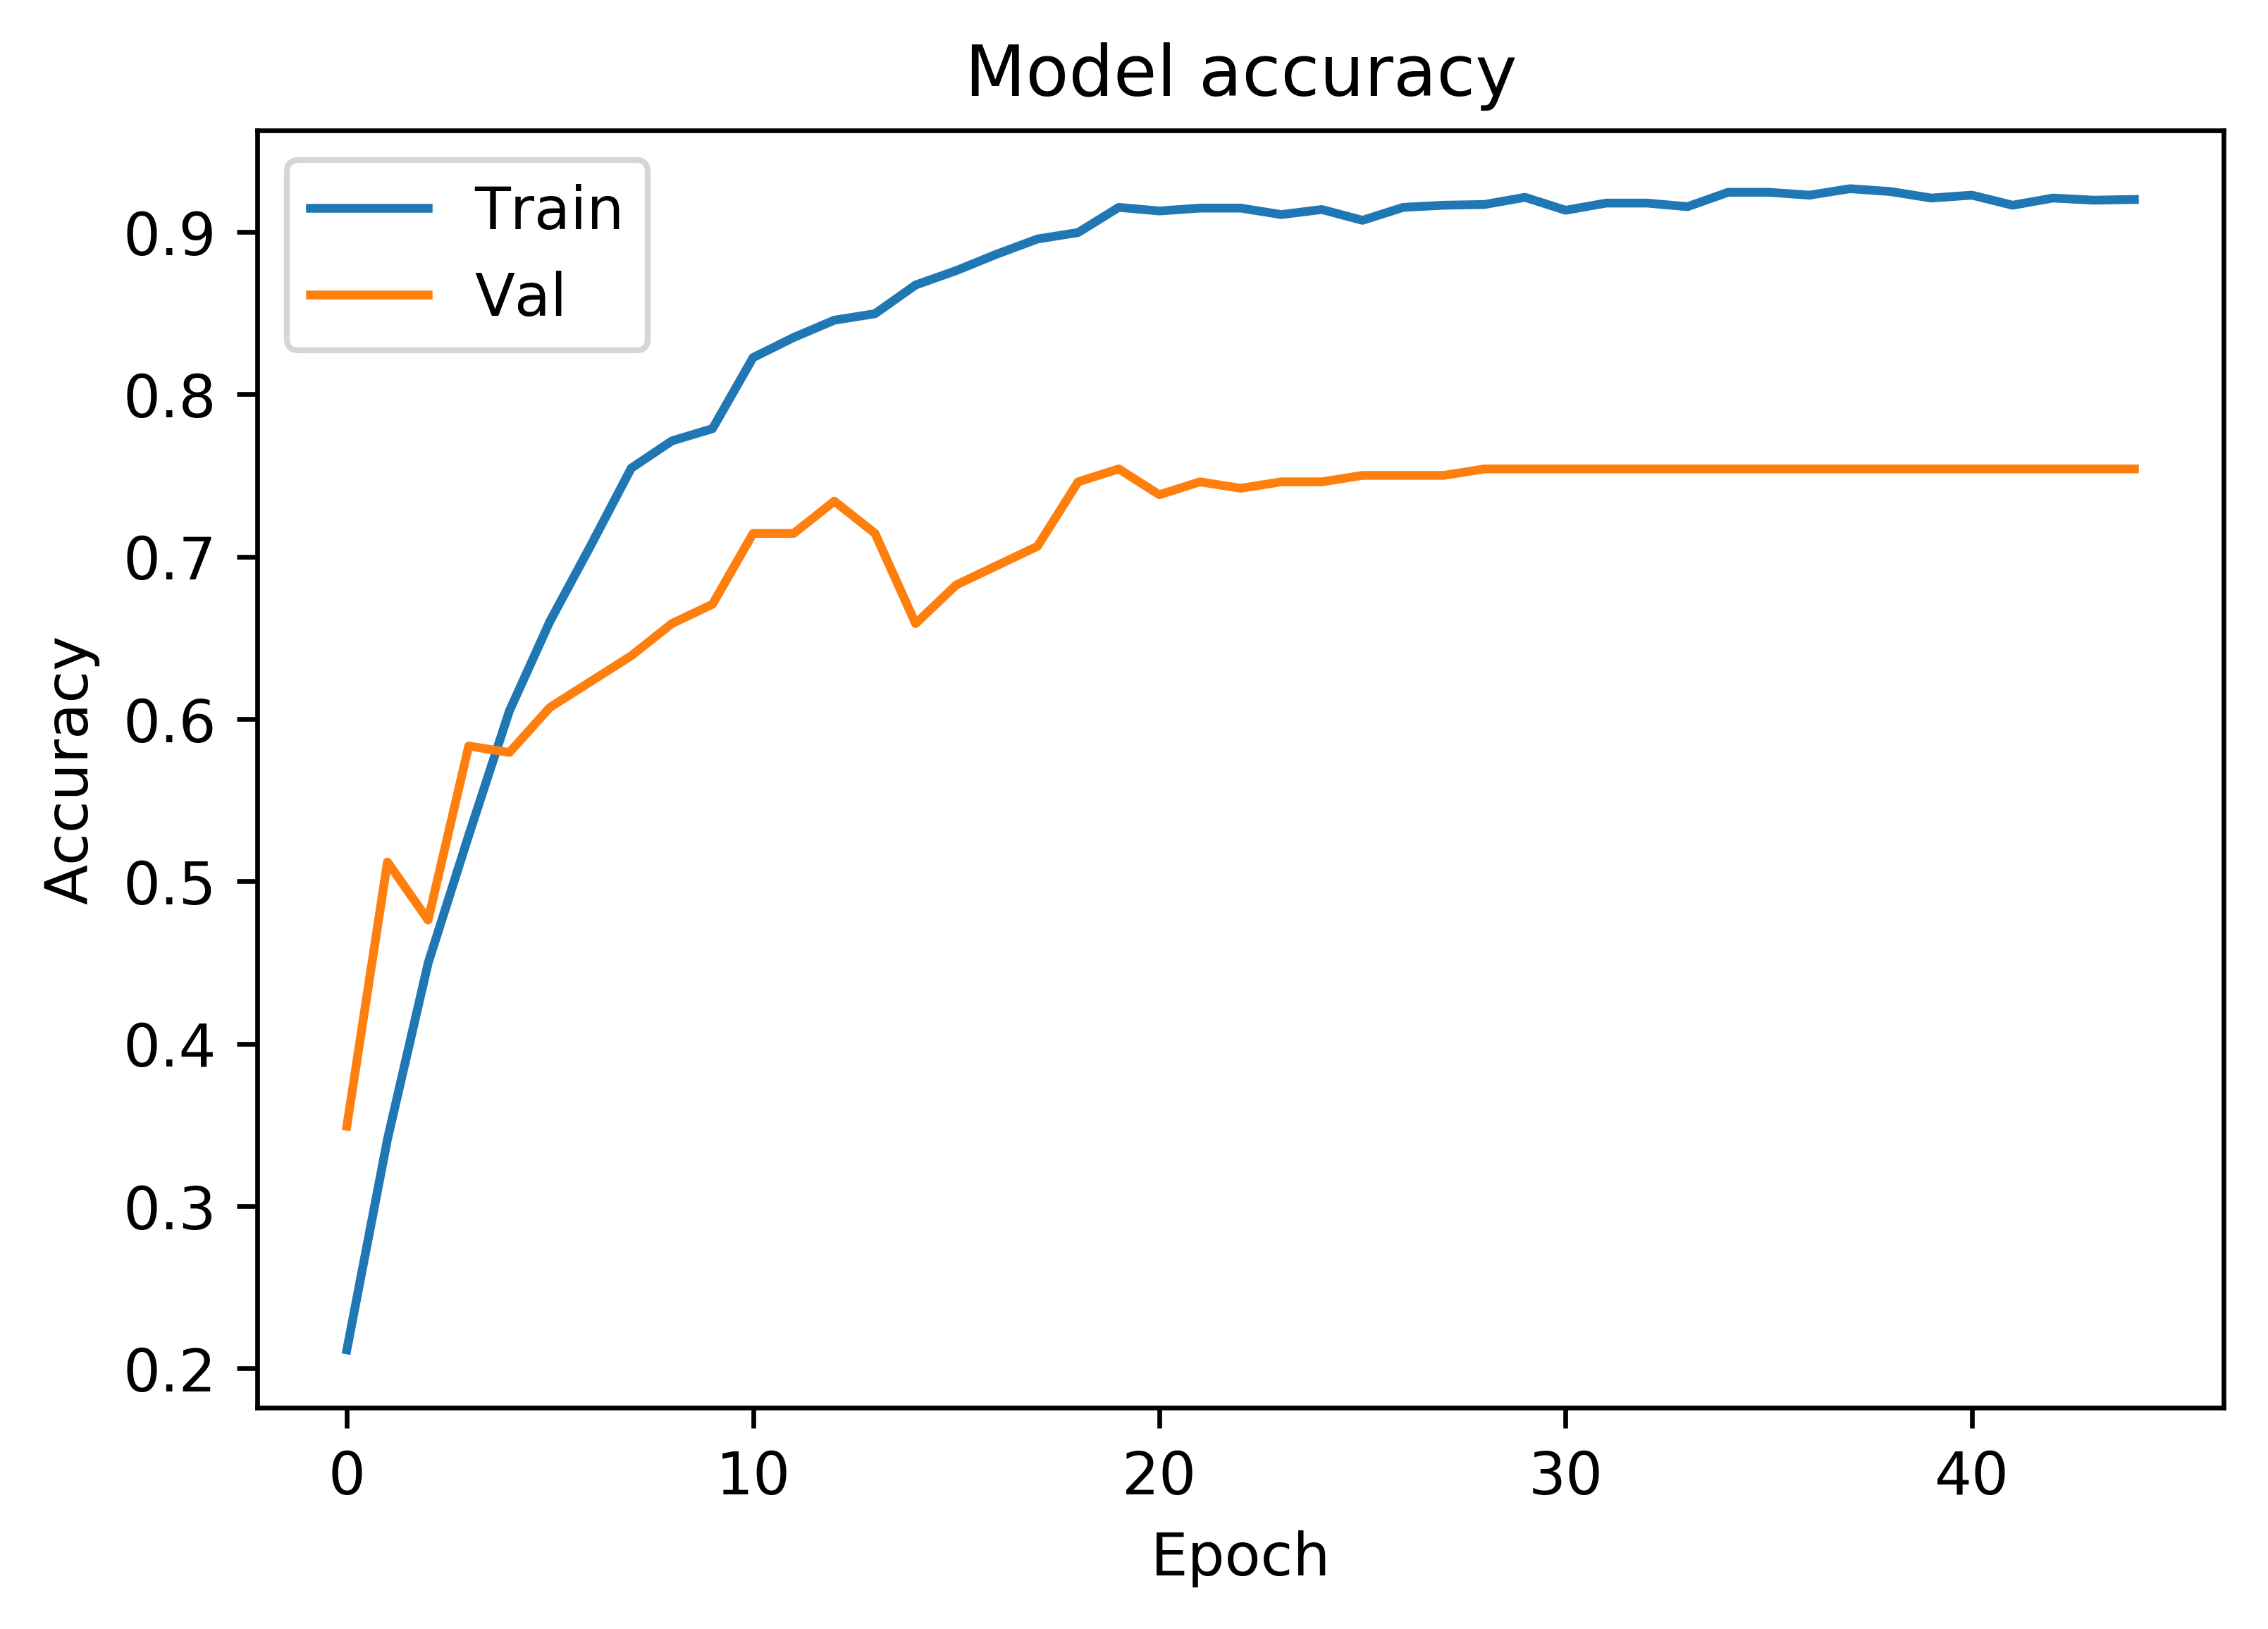

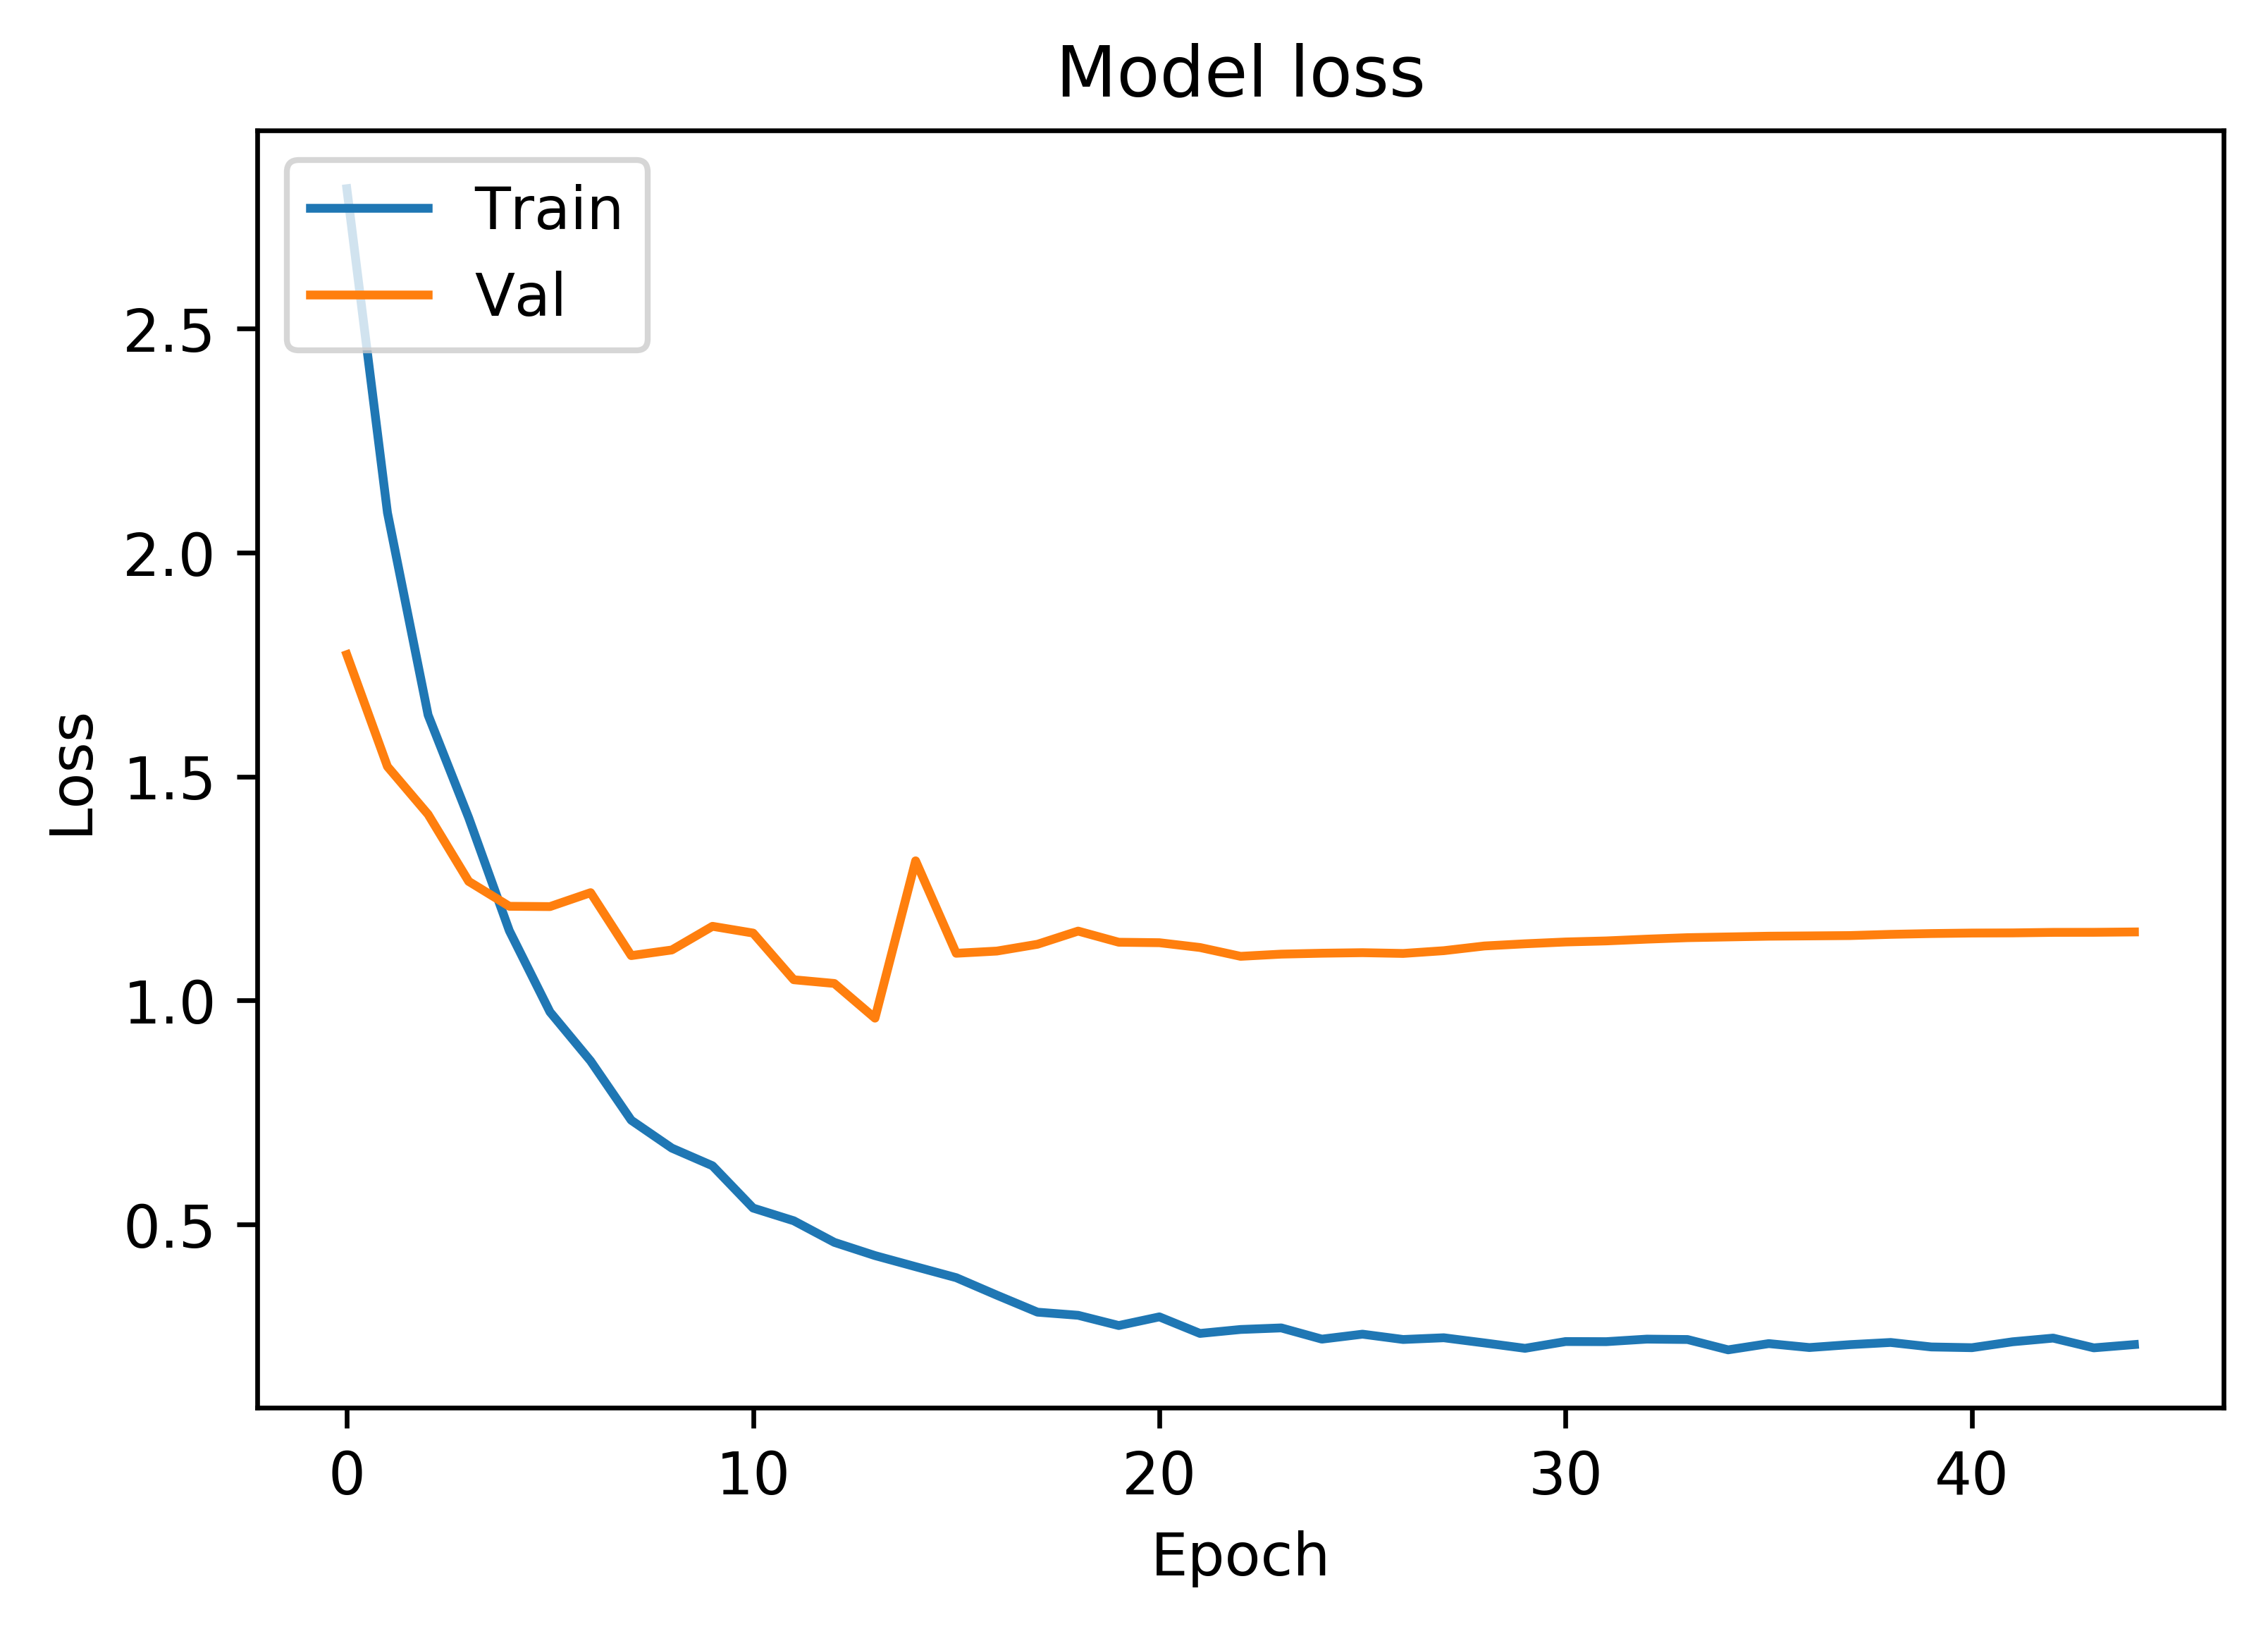

Results from K-fold: 2
acc: 77.69%
632/632 [==============================] - 0s 117us/step
[0.9829522480693045, 0.7768987341772152]
           bar  gel  network  plot  histology  sequence  line  molecular
bar         45    6        5     8          9         1     3          2
gel          6   58        4     0          5         4     2          0
network      4    0       63     1          3         0     6          2
plot         9    1        4    56          2         1     4          2
histology    2    1        2     0         72         0     0          2
sequence     0    2        2     0          0        73     1          1
line         8    2        3     3          3         0    58          2
molecular    0    1        5     0          4         3     0         66
              precision    recall  f1-score   support

         bar       0.61      0.57      0.59        79
         gel       0.82      0.73      0.77        79
     network       0.72      0.80      0.75    

Epoch 11/150
2260/2260 [==============================] - 0s 120us/step - loss: 0.5081 - acc: 0.8372 - val_loss: 0.8353 - val_acc: 0.7659

Epoch 00011: val_acc did not improve from 0.77778
Epoch 12/150
2260/2260 [==============================] - 0s 85us/step - loss: 0.4728 - acc: 0.8394 - val_loss: 0.7618 - val_acc: 0.7817

Epoch 00012: val_acc improved from 0.77778 to 0.78175, saving model to unimodal_weights/best_weight_text_1d_only_k-fold_3.hdf5
Epoch 13/150
2260/2260 [==============================] - 0s 114us/step - loss: 0.4130 - acc: 0.8588 - val_loss: 0.7795 - val_acc: 0.7937

Epoch 00013: val_acc improved from 0.78175 to 0.79365, saving model to unimodal_weights/best_weight_text_1d_only_k-fold_3.hdf5
Epoch 14/150
2260/2260 [==============================] - 0s 132us/step - loss: 0.3890 - acc: 0.8827 - val_loss: 0.8330 - val_acc: 0.7738

Epoch 00014: val_acc did not improve from 0.79365
Epoch 15/150
2260/2260 [==============================] - 0s 87us/step - loss: 0.3628 - acc

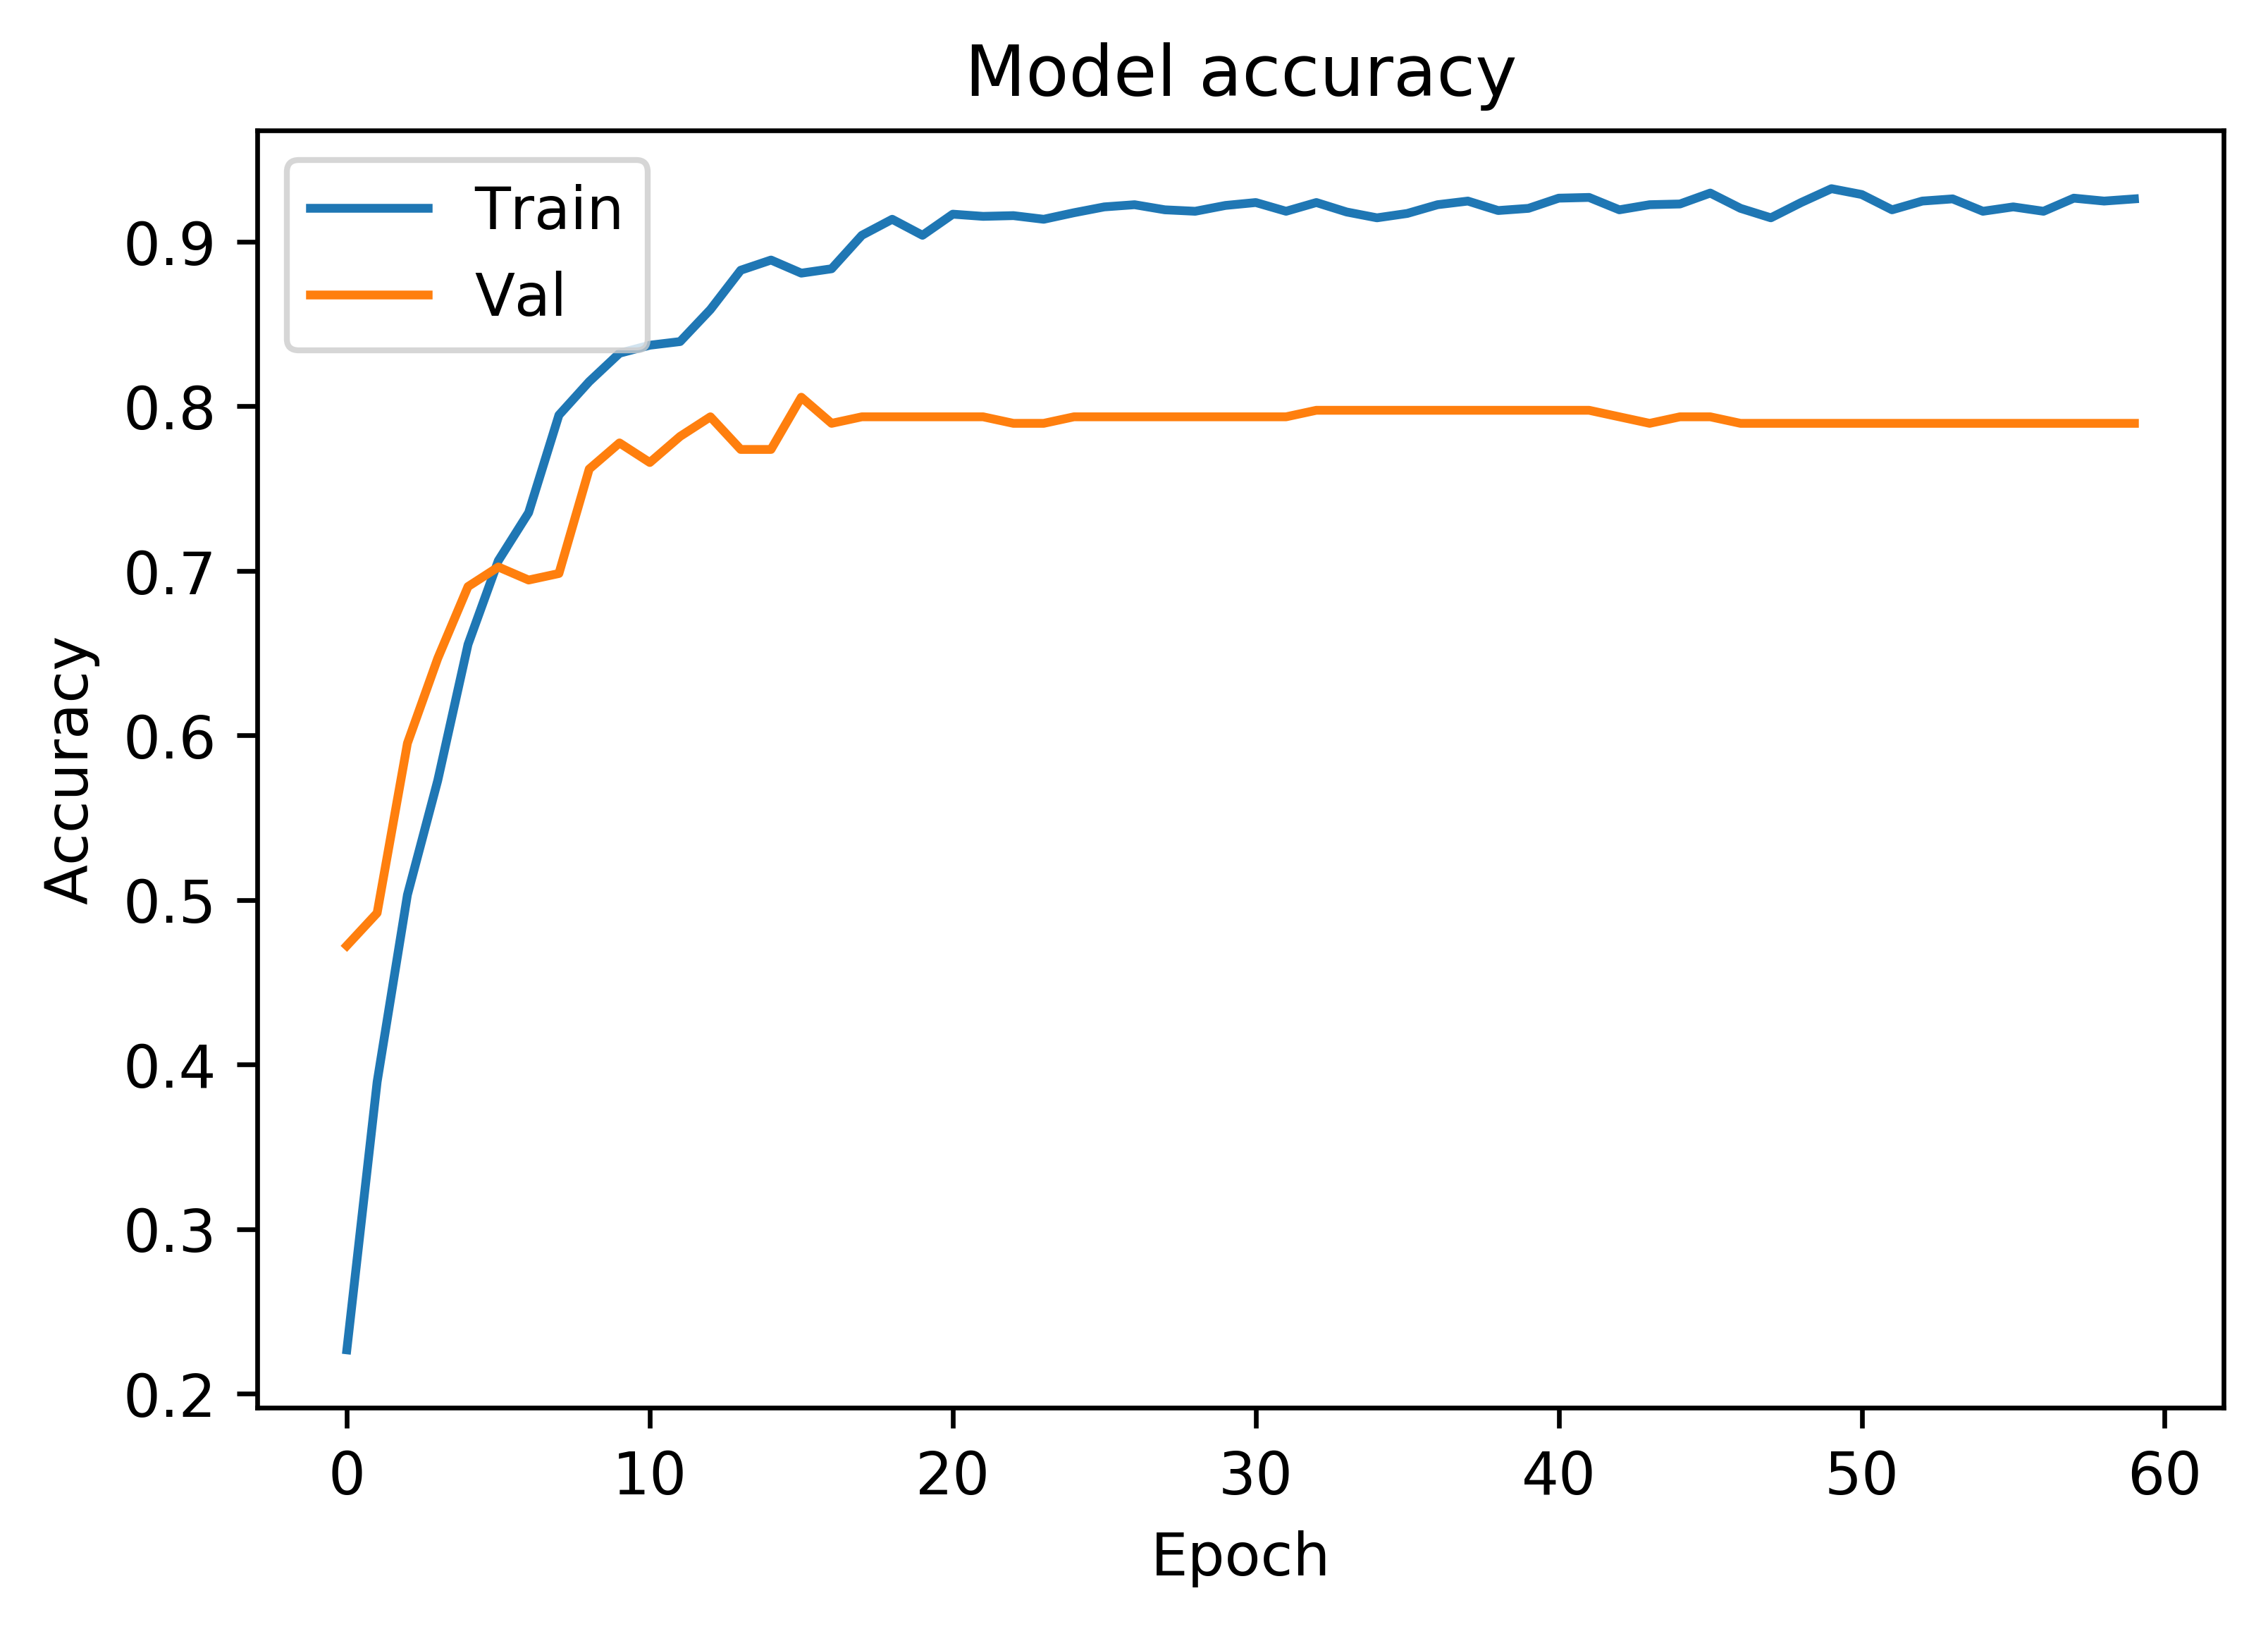

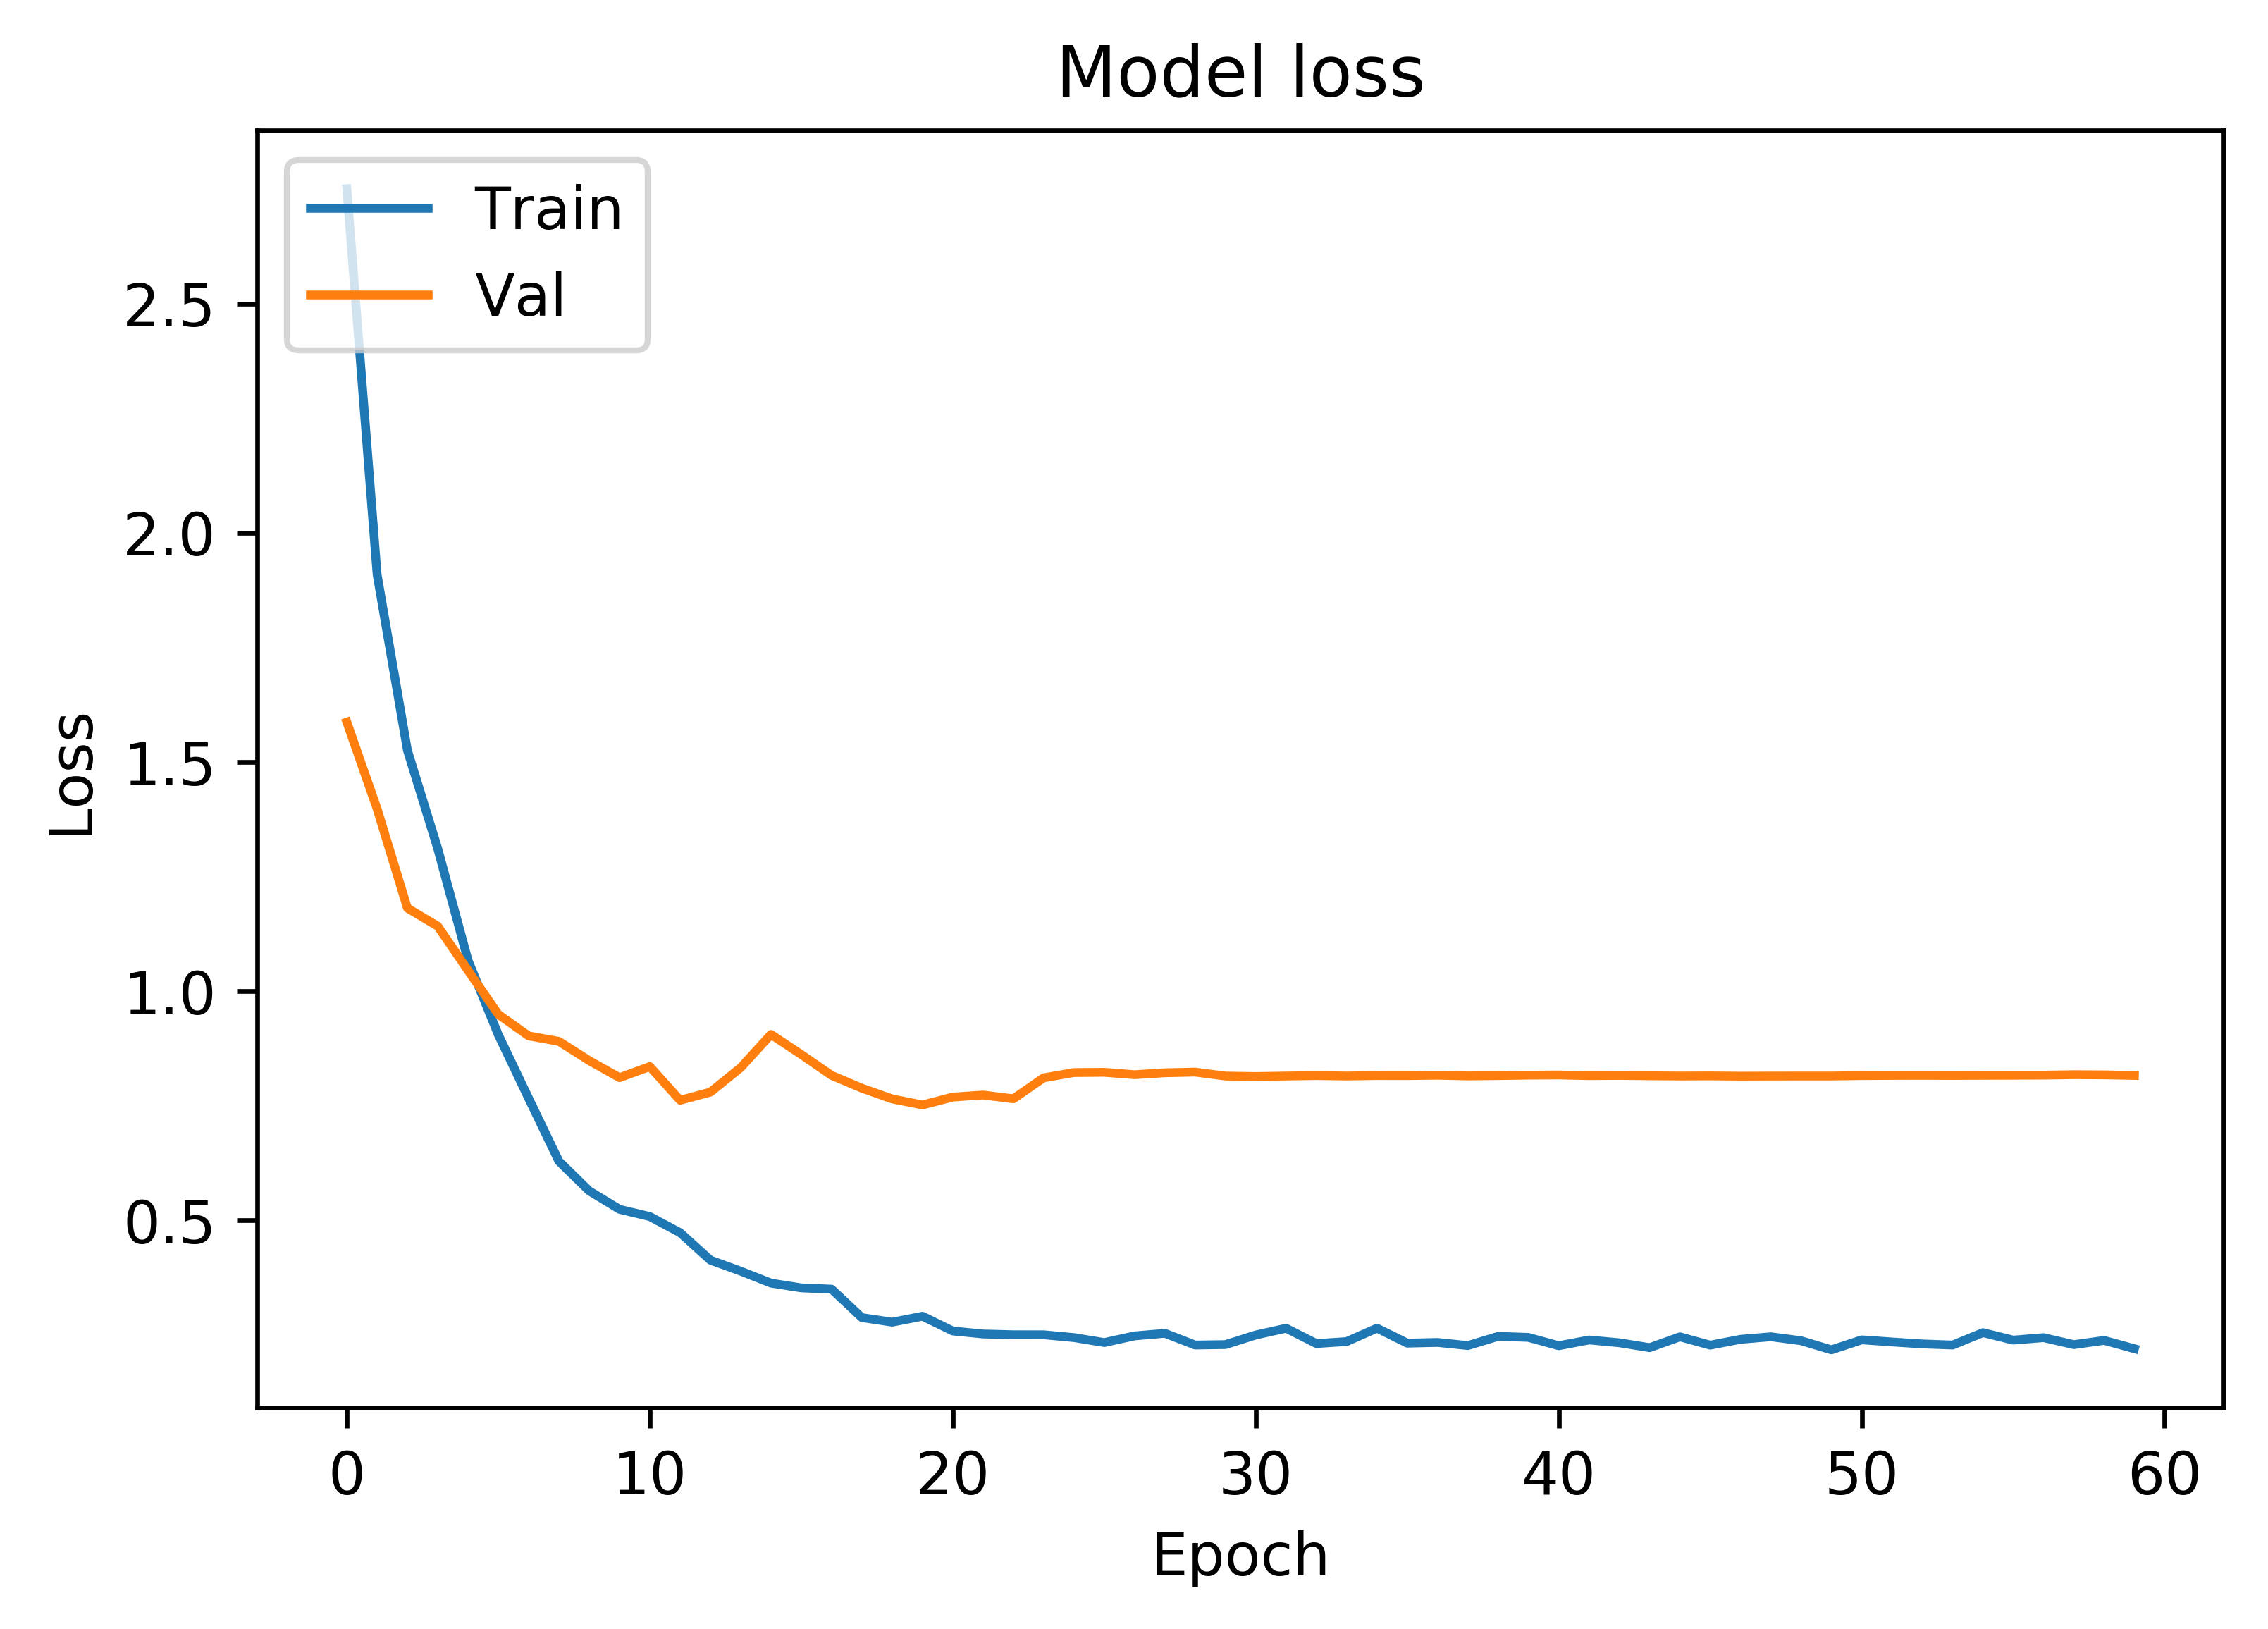

Results from K-fold: 3
acc: 78.64%
632/632 [==============================] - 0s 118us/step
[0.8525155861920948, 0.7863924058177804]
           bar  gel  network  plot  histology  sequence  line  molecular
bar         54    3        4     3          7         0     7          1
gel          5   60        1     1          9         0     3          0
network      2    1       67     1          0         0     4          4
plot         6    0        3    53          0         1    12          4
histology    0    0        3     2         73         0     0          1
sequence     1    8        1     0          0        67     2          0
line         7    0        5     8          4         0    54          1
molecular    2    0        4     0          3         1     0         69
              precision    recall  f1-score   support

         bar       0.70      0.68      0.69        79
         gel       0.83      0.76      0.79        79
     network       0.76      0.85      0.80    

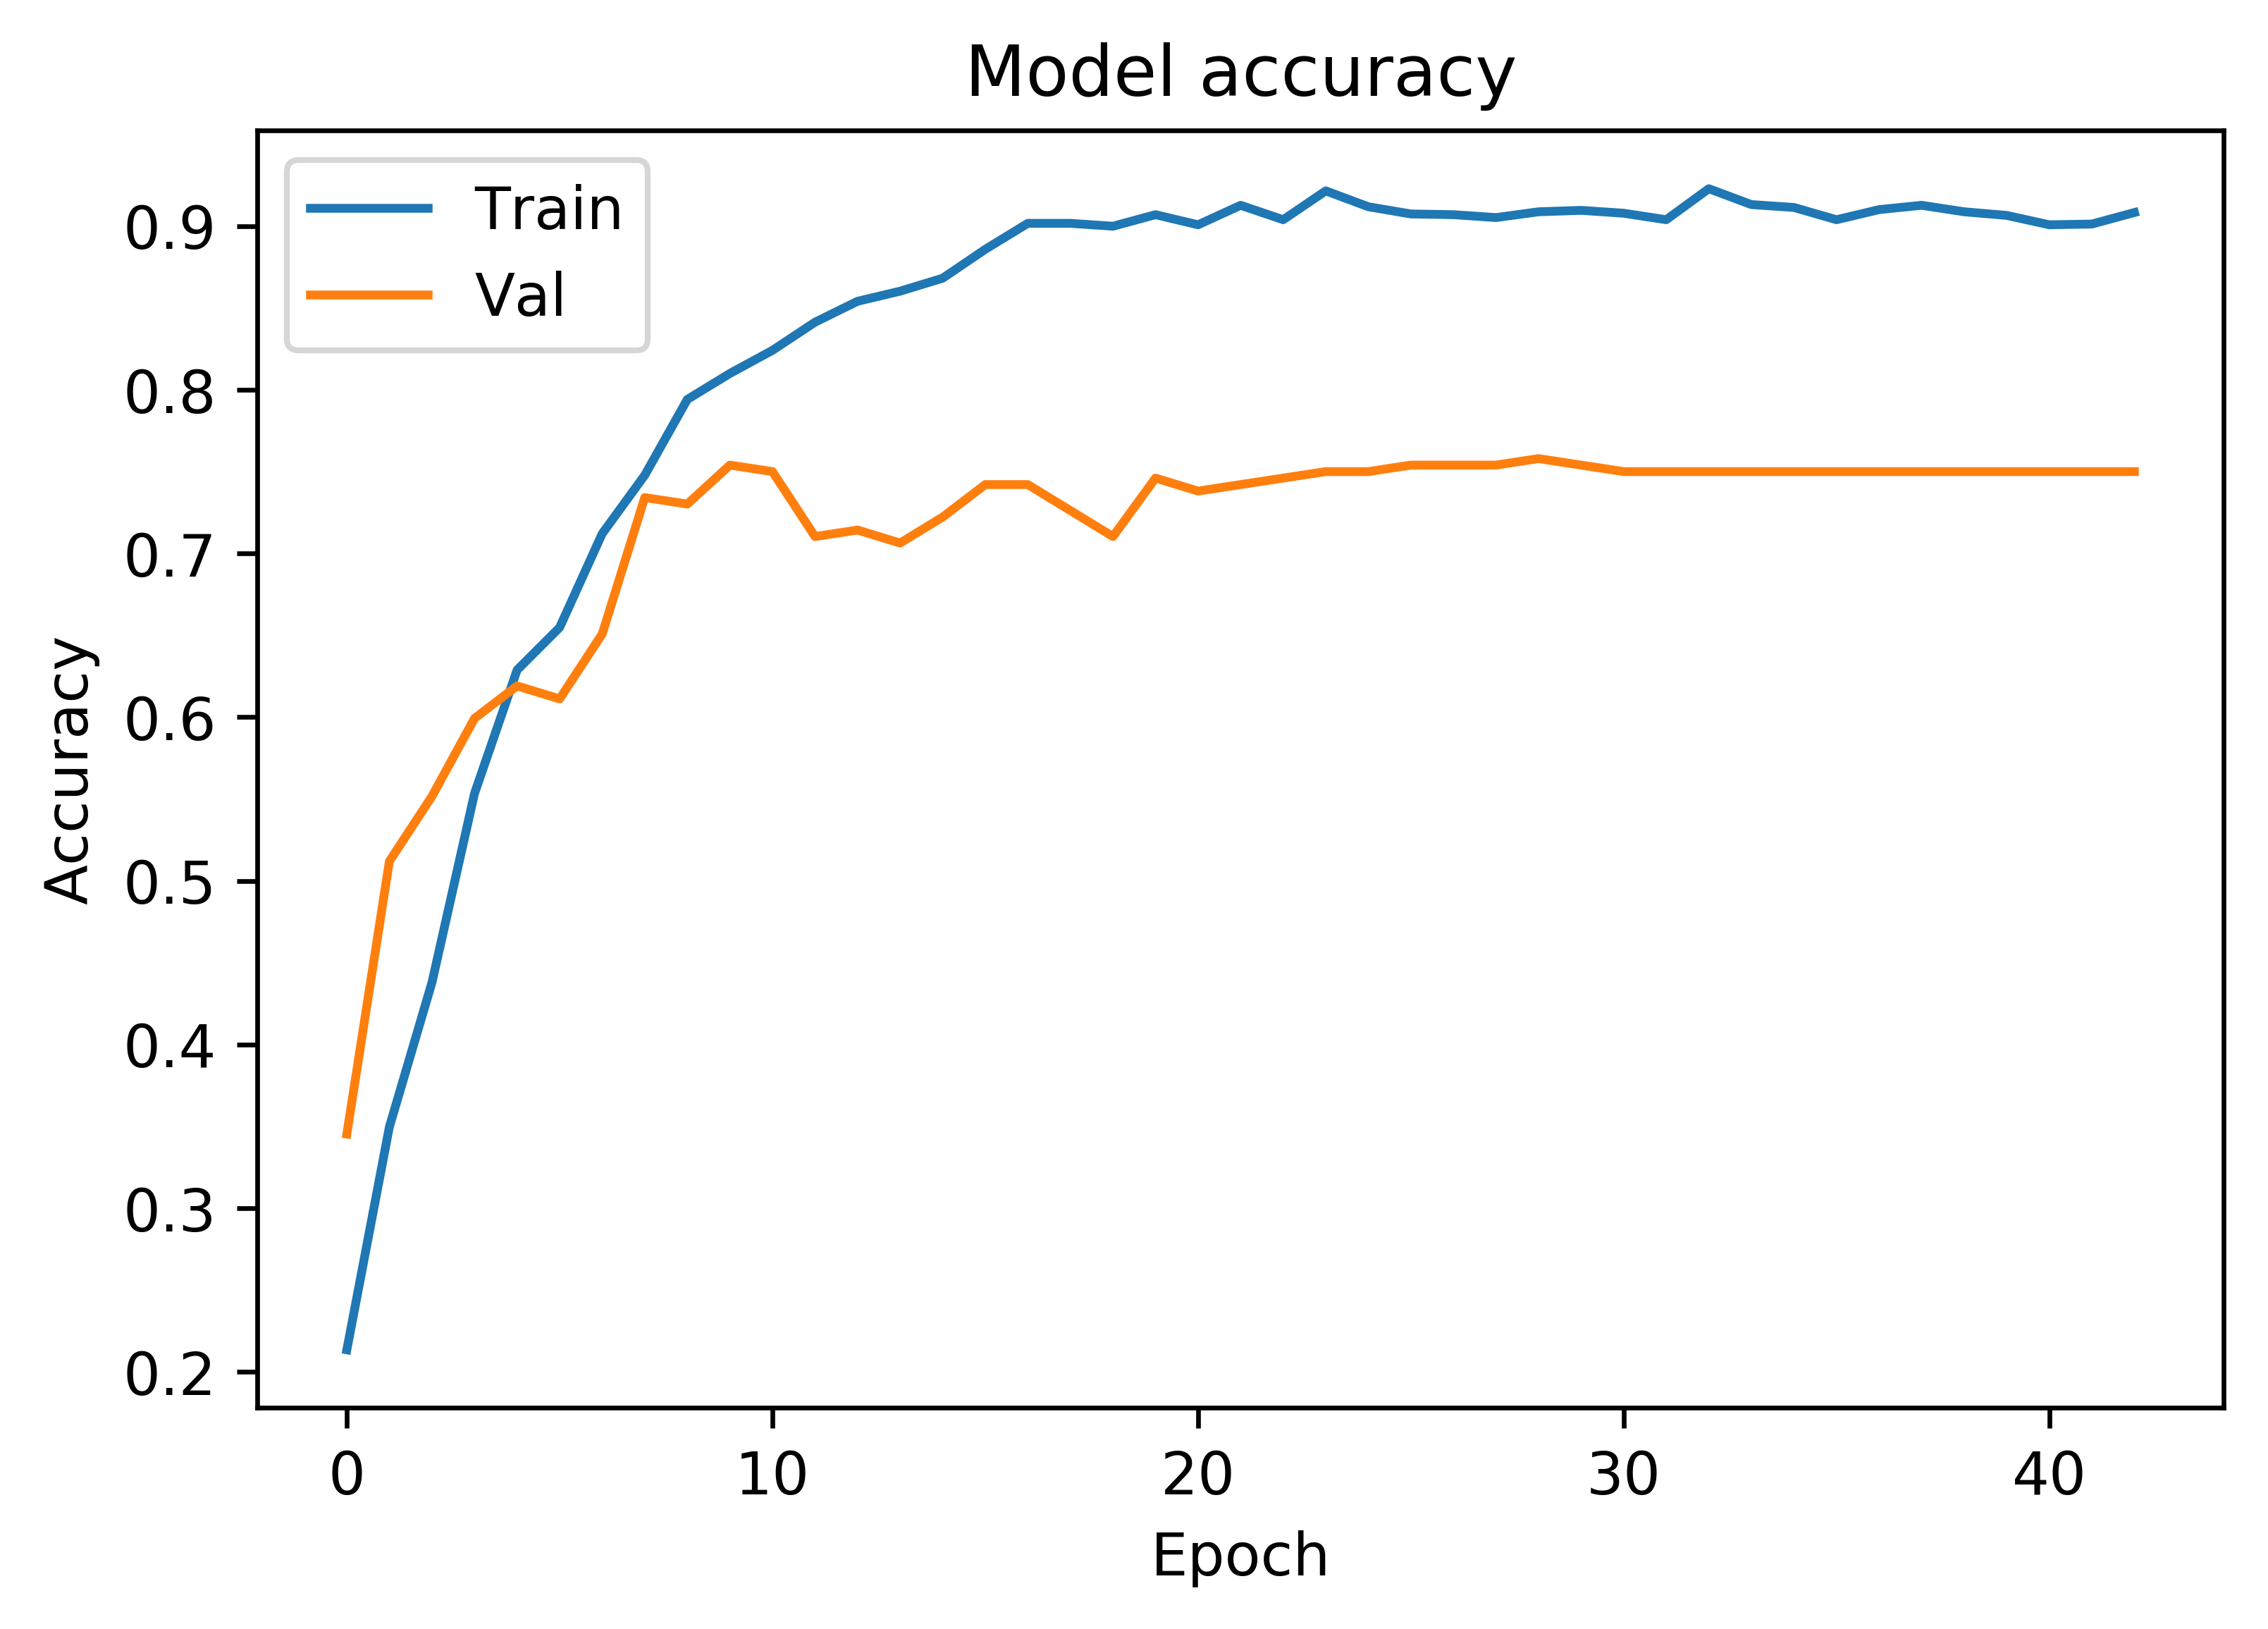

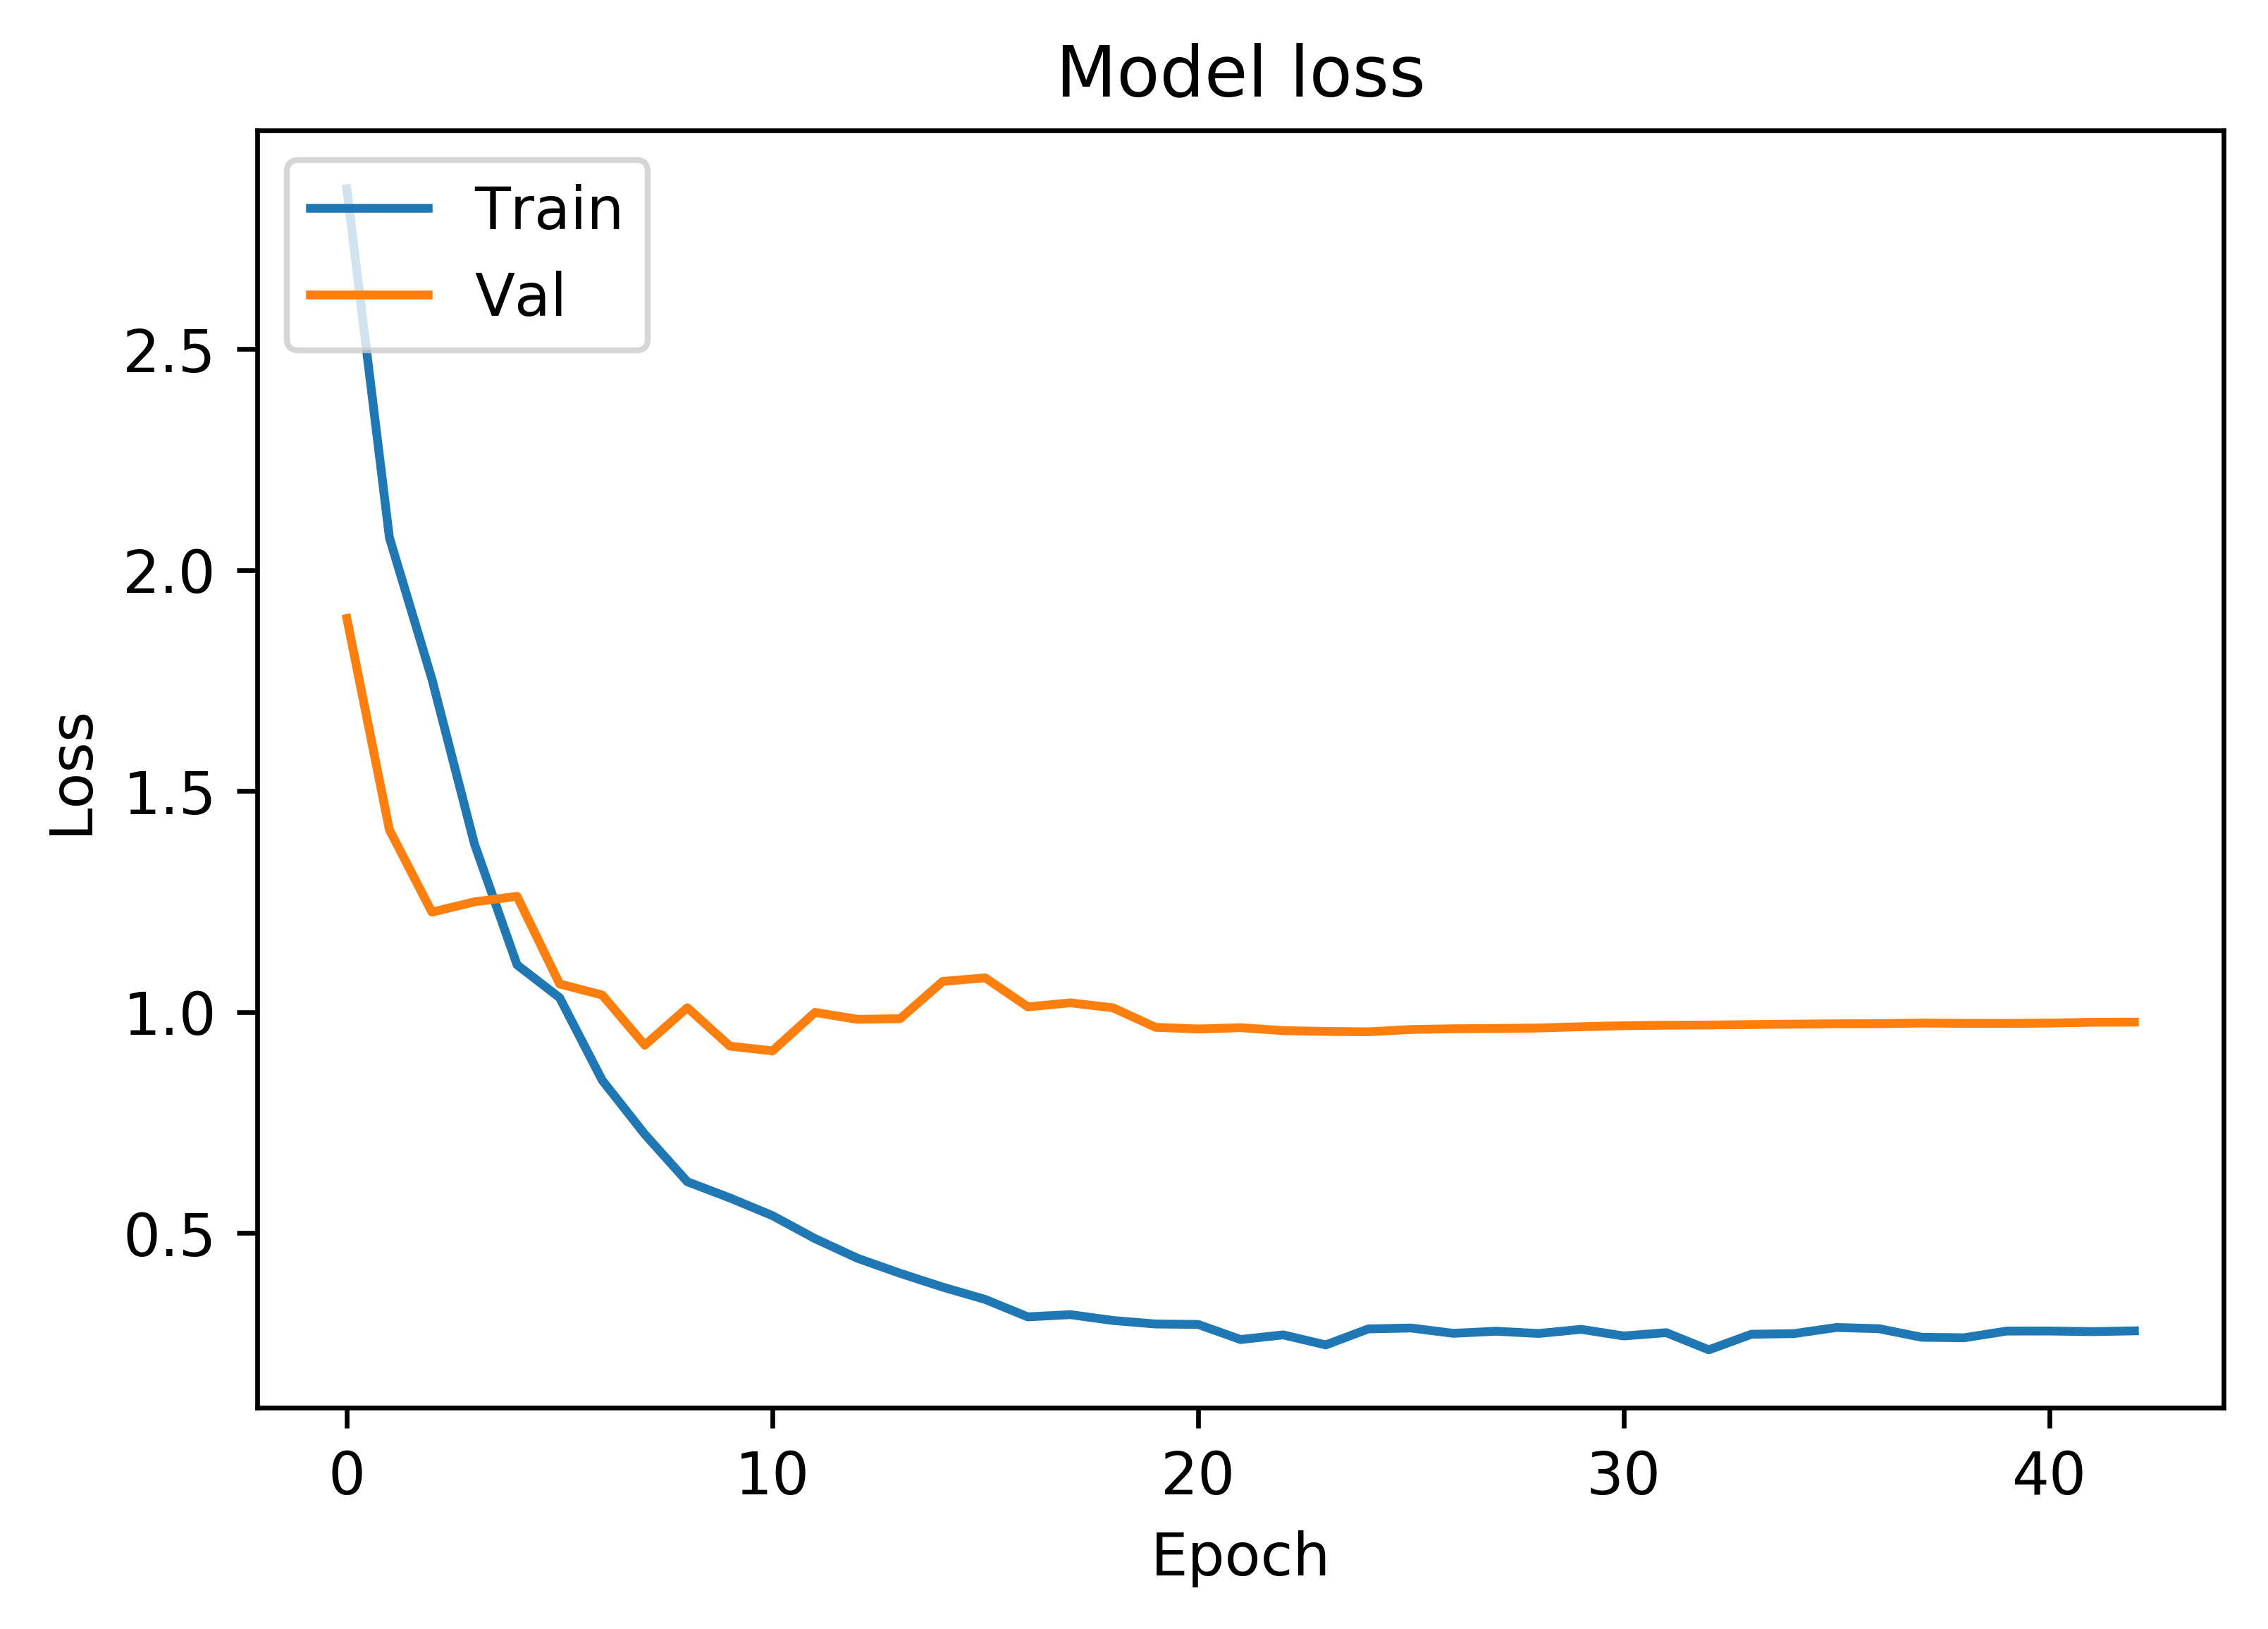

Results from K-fold: 4
acc: 79.33%
624/624 [==============================] - 0s 102us/step
[0.8657515897200658, 0.7932692307692307]
           bar  gel  network  plot  histology  sequence  line  molecular
bar         53    8        4     3          0         2     7          1
gel          0   54        2     1         13         4     4          0
network      3    1       65     0          0         2     4          3
plot         5    6        4    51          0         0    12          0
histology    3    0        2     1         69         2     1          0
sequence     1    1        0     0          0        71     3          2
line         3    0        1     2          3         5    64          0
molecular    0    0        5     0          2         2     1         68
              precision    recall  f1-score   support

         bar       0.78      0.68      0.73        78
         gel       0.77      0.69      0.73        78
     network       0.78      0.83      0.81    

2268/2268 [==============================] - 0s 86us/step - loss: 0.3853 - acc: 0.8730 - val_loss: 0.7749 - val_acc: 0.7857

Epoch 00014: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 00014: val_acc did not improve from 0.80159
Epoch 15/150
2268/2268 [==============================] - 0s 96us/step - loss: 0.3798 - acc: 0.8743 - val_loss: 0.7247 - val_acc: 0.8175

Epoch 00015: val_acc improved from 0.80159 to 0.81746, saving model to unimodal_weights/best_weight_text_1d_only_k-fold_5.hdf5
Epoch 16/150
2268/2268 [==============================] - 0s 97us/step - loss: 0.3371 - acc: 0.8858 - val_loss: 0.7323 - val_acc: 0.8294

Epoch 00016: val_acc improved from 0.81746 to 0.82937, saving model to unimodal_weights/best_weight_text_1d_only_k-fold_5.hdf5
Epoch 17/150
2268/2268 [==============================] - 0s 105us/step - loss: 0.3164 - acc: 0.8929 - val_loss: 0.7402 - val_acc: 0.8294

Epoch 00017: val_acc did not improve from 0.82937
Epoch 18/150
2268/2268 [

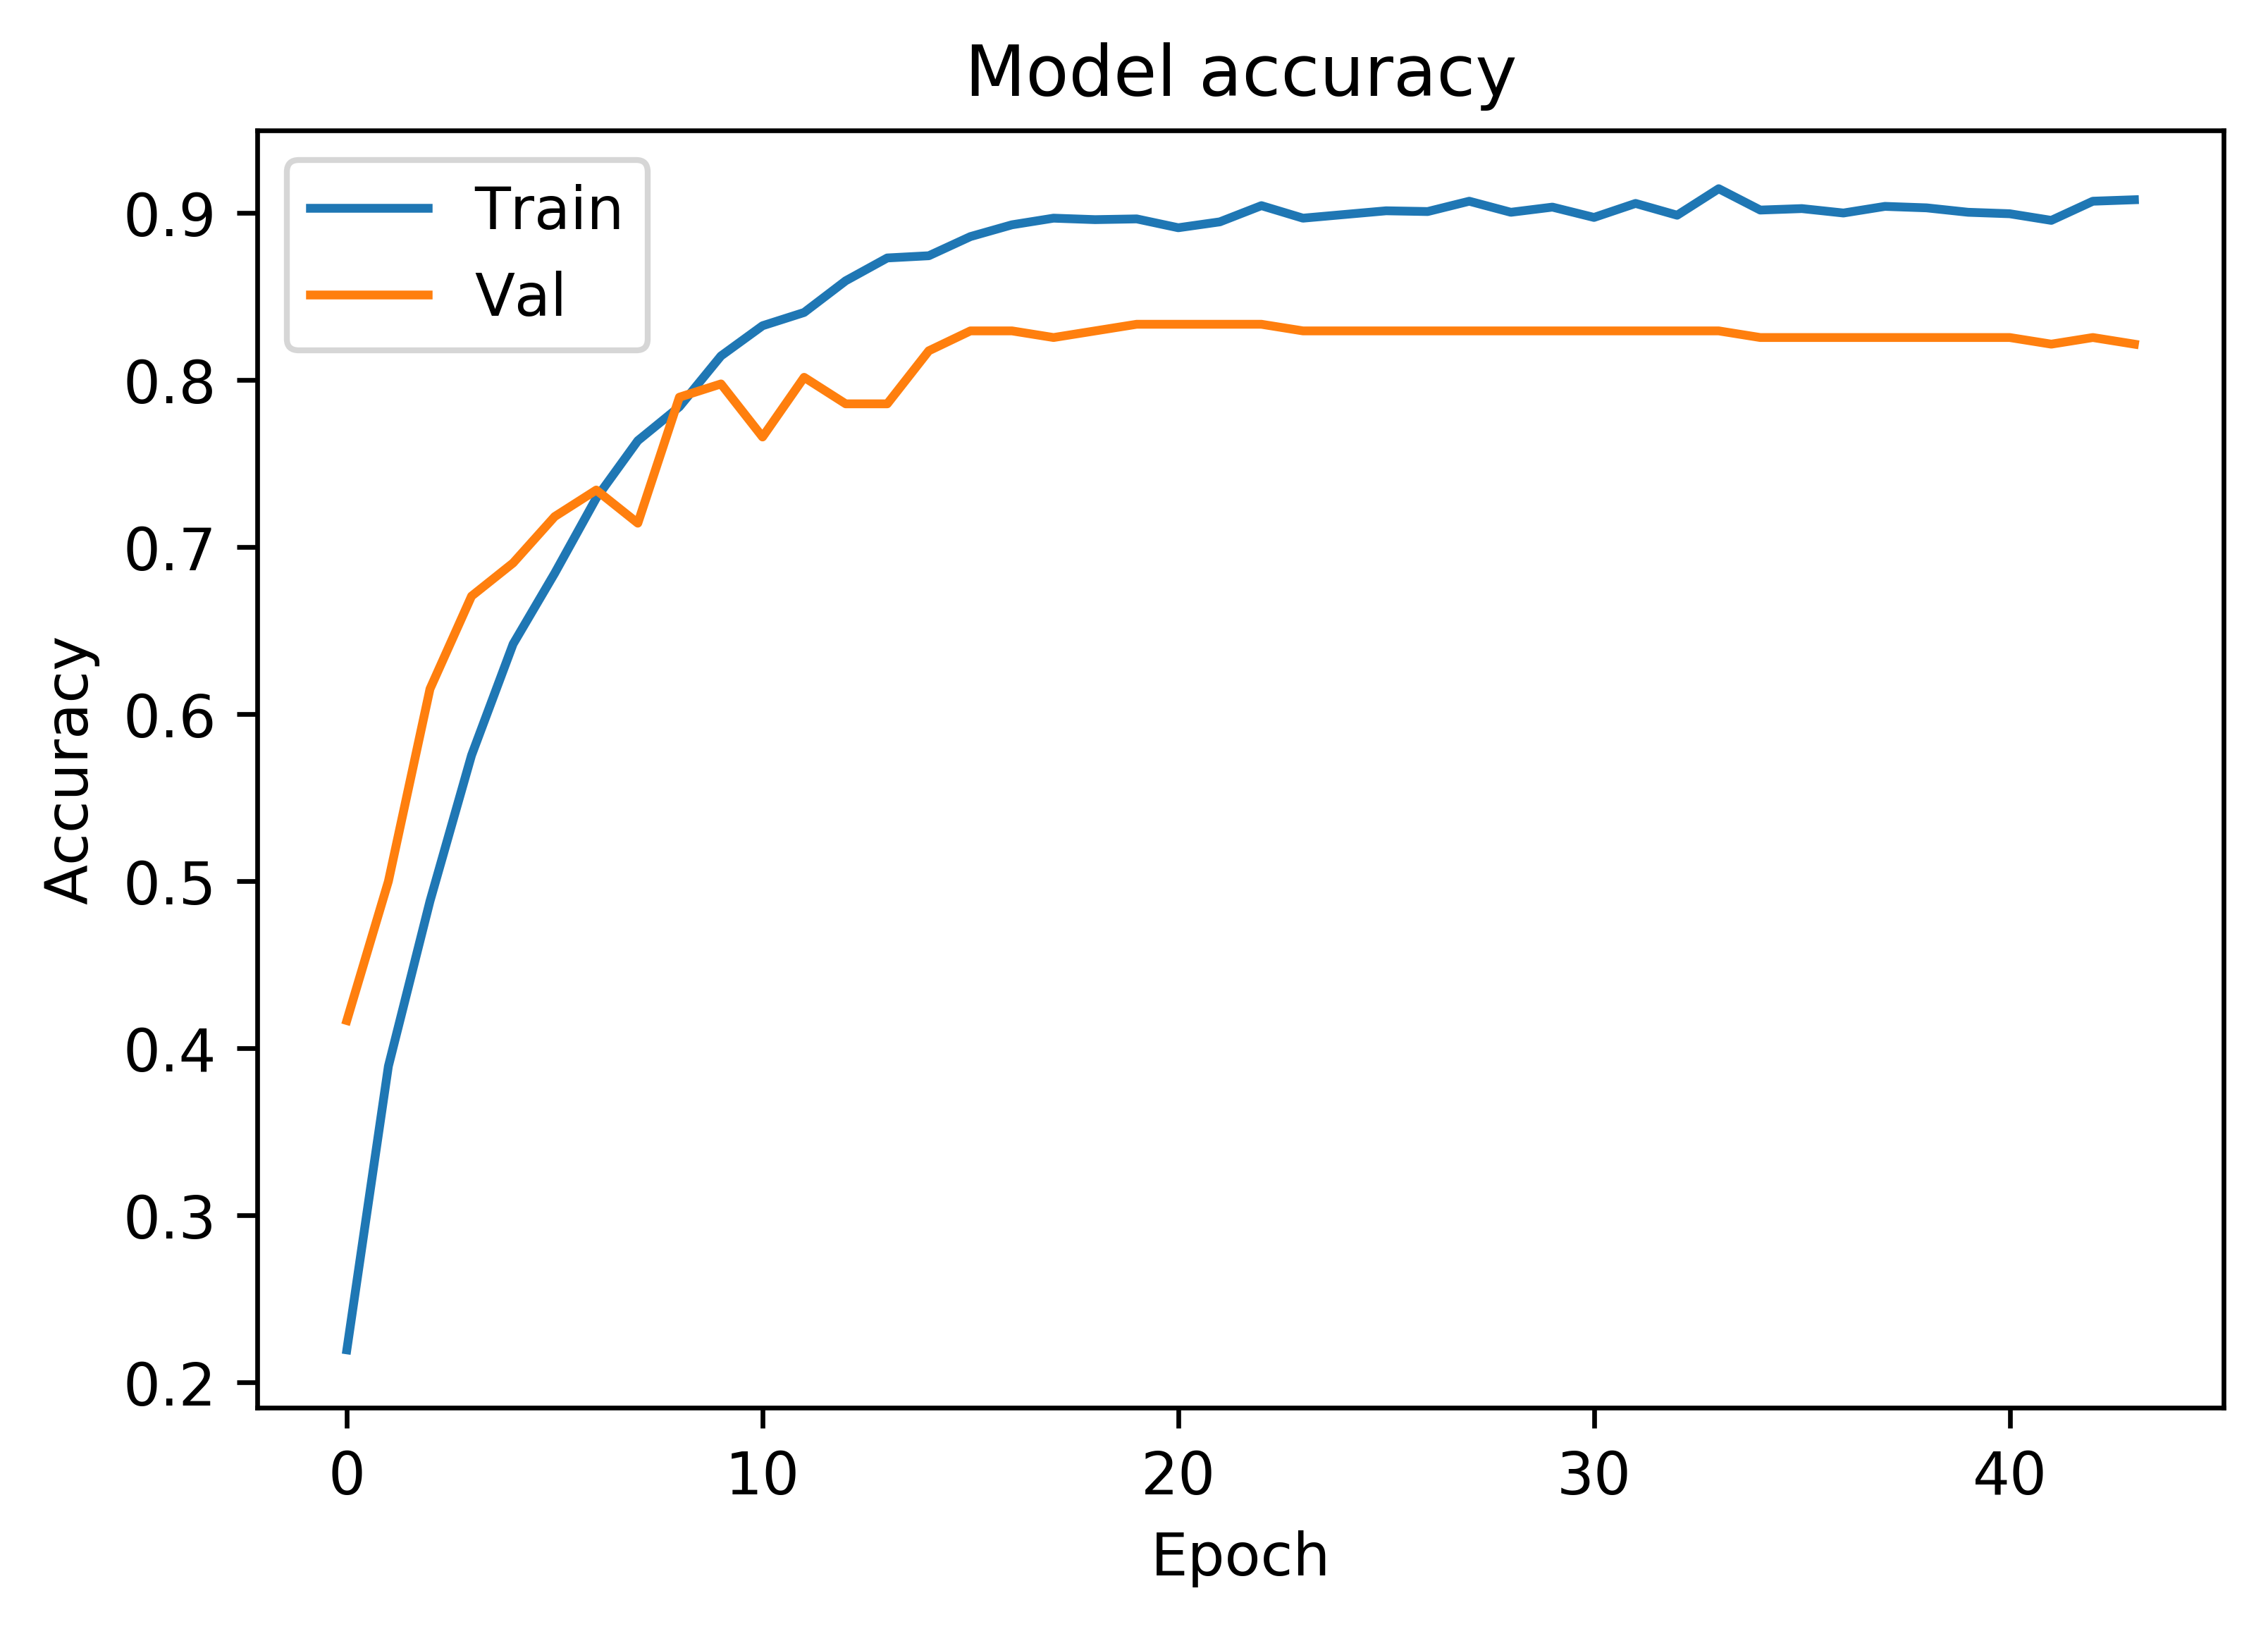

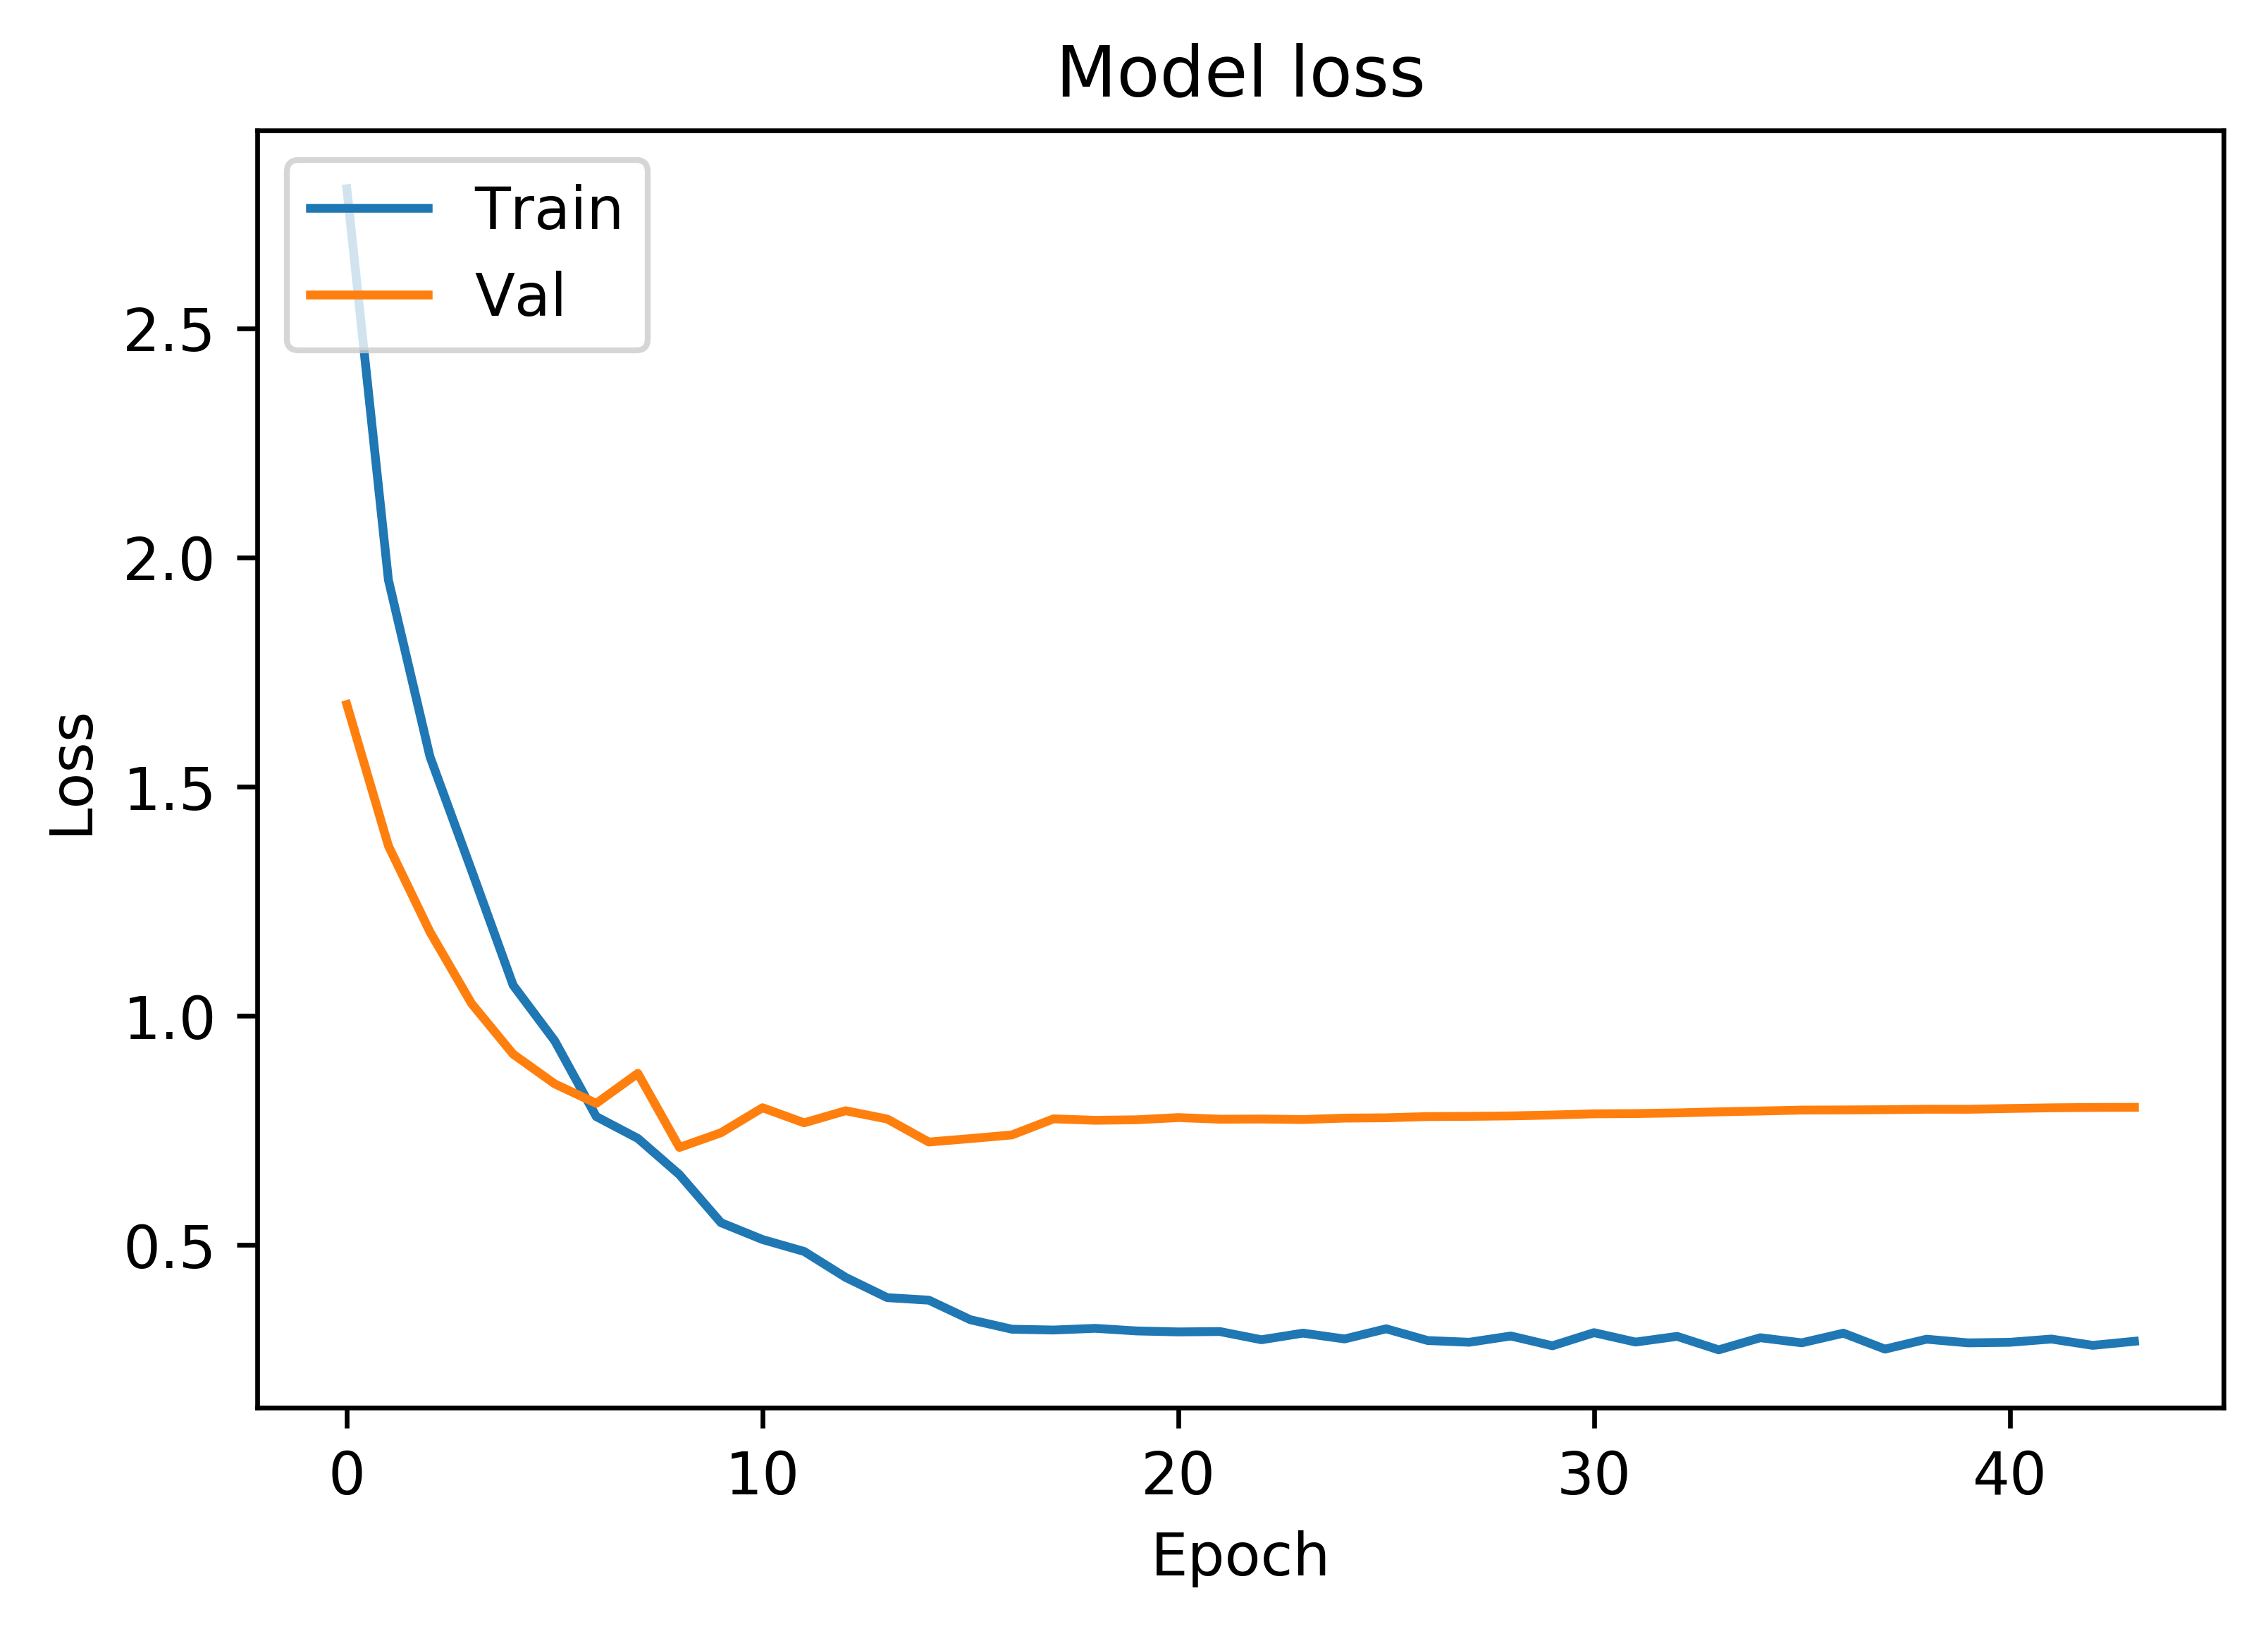

Results from K-fold: 5
acc: 76.92%
624/624 [==============================] - 0s 124us/step
[1.0071147409005043, 0.7692307692307693]
           bar  gel  network  plot  histology  sequence  line  molecular
bar         44    3        6    10          5         0     6          4
gel          4   57        2     1         11         0     2          1
network      0    1       61     3          3         1     0          9
plot         3    2        0    59          3         0    10          1
histology    1    2        0     1         70         0     0          4
sequence     2    0        2     1          0        65     3          5
line         6    3        2     3          5         1    53          5
molecular    0    0        3     1          1         2     0         71
              precision    recall  f1-score   support

         bar       0.73      0.56      0.64        78
         gel       0.84      0.73      0.78        78
     network       0.80      0.78      0.79    

In [13]:
#set K folds to 5
cvscores = []
count = 1
confusion_matrix_list = []
report_list = []

for key, val in kfolds.items():
    print(key)
    train = val['train']
    test = val['test']
    
    print('K-: {}'.format(key))
            
    print("Samples from Training")
    print_samples(samples=train, text=X_text, tokenizer=tokenizer)
    print("============================")
    
    print("Samples from Testing")
    print_samples(samples=test, text=X_text, tokenizer=tokenizer)
    print("============================")
    
    text_model = Generate_Model(model_type = "text_1d")
    text_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    filepath="unimodal_weights/best_weight_text_1d_only_k-fold_{}.hdf5".format(count)
    checkpoint = MultiGPUCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [reduce_lr, checkpoint, early_stopping]

    history = text_model.fit([X_text[train]], y[train], 
                     epochs=epochs, batch_size=bs, validation_split=0.1, callbacks=callbacks_list)
    plot_model_history(history)
    filepath="unimodal_weights/final_weight_text_1d_only_k-fold_{}.hdf5".format(count)
    text_model.save_weights(filepath)
    scores = text_model.evaluate([X_text[test]], y[test], verbose=0)
    print('Results from K-fold: {}'.format(count))
    print("%s: %.2f%%" % (image_model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
    y_hat = test_model(text_model, zip(X_text[test], y[test]), image = False, text = True, 
                       class_names=class_names)
    cm = confusion_matrix([np.argmax(t) for t in y[test]], y_hat)
    confusion_matrix_list.append(pd.DataFrame(cm, index=class_names, columns=class_names))
    cr = classification_report([np.argmax(t) for t in y[test]], y_hat, target_names=class_names)
    report_list.append(classification_report_df(cr))
    count += 1
    print('================================================')
print('Average for kfold accuracy and stdev')
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
print("Average classification report for all folds")
print(df_mean(report_list))

### K fold validation on text_2d only

fold_1
K-: fold_1
Samples from Training
[ 193 2405  830 1032]
id: 193
distribution average daily pain trial entry 
id: 2405
purity assessment cd - cd - lin- cell fractions purities cd cd - cell factions respectively b purities cd cd - fractions respectively c purities lin- lin cell factions respectively cd - cd - cell populations defined first gating forward side scatter properties excluding platelets debris subsequent gates set exclude control cells labeled isotype-specific antibody percentages indicating purity isolated cell fractions shown plots abbreviations ssc side scatter igg immunoglobulin pe phycoerythrin 
id: 830
- 
id: 1032
electron microscopic analysis limited single membrane containing degraded material 
Samples from Testing
[   1    5 3139 3143]
id: 1
effects prenyltransferase inhibitors estrogen response element-dependent luciferase activity heln cells transfected estrogen receptor er er cells deprived estradiol e days co-transfected renilla luciferase plasmid either heg


Epoch 00023: val_acc improved from 0.18651 to 0.21032, saving model to unimodal_weights/best_weight_text_2d_only_k-fold_1.hdf5
Epoch 24/150
2260/2260 [==============================] - 7s 3ms/step - loss: 0.7263 - acc: 0.7642 - val_loss: 2.6412 - val_acc: 0.2183

Epoch 00024: ReduceLROnPlateau reducing learning rate to 1.6000001778593287e-06.

Epoch 00024: val_acc improved from 0.21032 to 0.21825, saving model to unimodal_weights/best_weight_text_2d_only_k-fold_1.hdf5
Epoch 25/150
2260/2260 [==============================] - 7s 3ms/step - loss: 0.7207 - acc: 0.7611 - val_loss: 2.4688 - val_acc: 0.2421

Epoch 00025: val_acc improved from 0.21825 to 0.24206, saving model to unimodal_weights/best_weight_text_2d_only_k-fold_1.hdf5
Epoch 26/150
2260/2260 [==============================] - 7s 3ms/step - loss: 0.7312 - acc: 0.7593 - val_loss: 2.2641 - val_acc: 0.2698

Epoch 00026: val_acc improved from 0.24206 to 0.26984, saving model to unimodal_weights/best_weight_text_2d_only_k-fold_1.hdf


Epoch 00102: val_acc did not improve from 0.64286
Epoch 103/150
2260/2260 [==============================] - 7s 3ms/step - loss: 0.5734 - acc: 0.8173 - val_loss: 1.4788 - val_acc: 0.5040

Epoch 00103: val_acc did not improve from 0.64286
Epoch 104/150
2260/2260 [==============================] - 7s 3ms/step - loss: 0.5859 - acc: 0.8181 - val_loss: 1.3893 - val_acc: 0.5913

Epoch 00104: val_acc did not improve from 0.64286
Epoch 105/150
2260/2260 [==============================] - 7s 3ms/step - loss: 0.5651 - acc: 0.8279 - val_loss: 1.5924 - val_acc: 0.4683

Epoch 00105: val_acc did not improve from 0.64286
Epoch 106/150
2260/2260 [==============================] - 7s 3ms/step - loss: 0.6042 - acc: 0.8173 - val_loss: 1.6044 - val_acc: 0.4524

Epoch 00106: val_acc did not improve from 0.64286
Epoch 107/150
2260/2260 [==============================] - 7s 3ms/step - loss: 0.5568 - acc: 0.8314 - val_loss: 1.4660 - val_acc: 0.5675

Epoch 00107: val_acc did not improve from 0.64286
Epoch 108

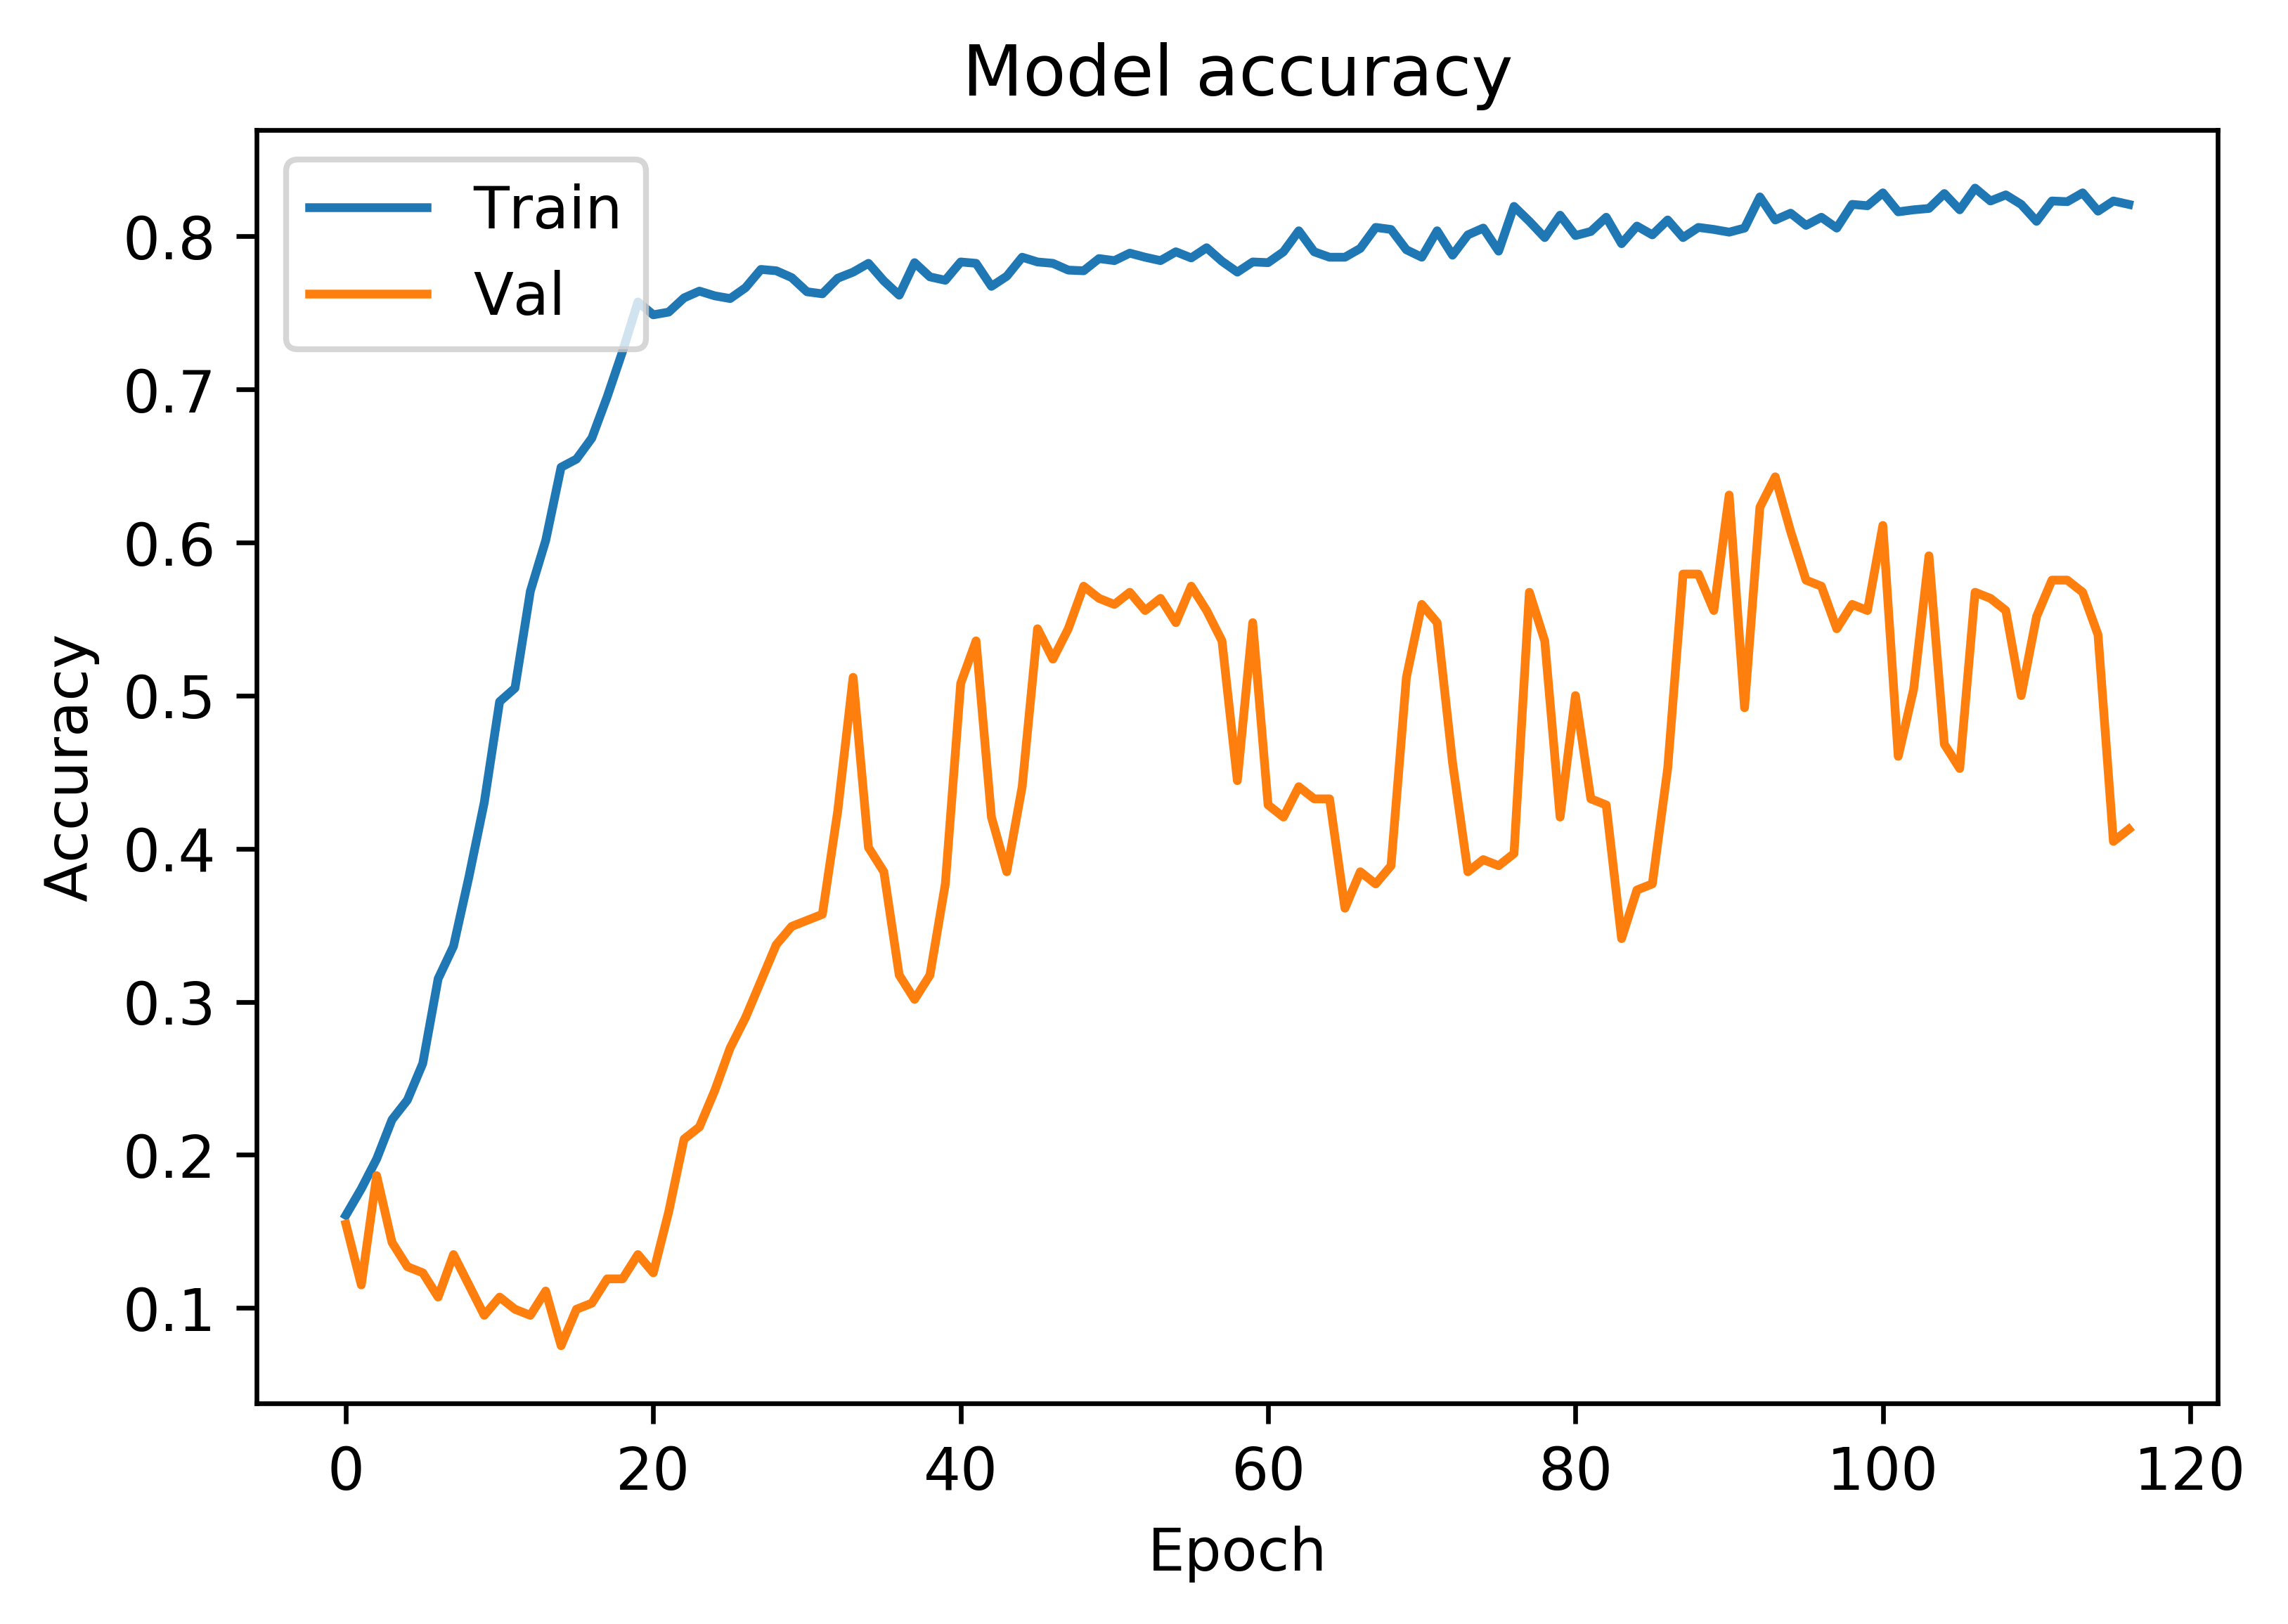

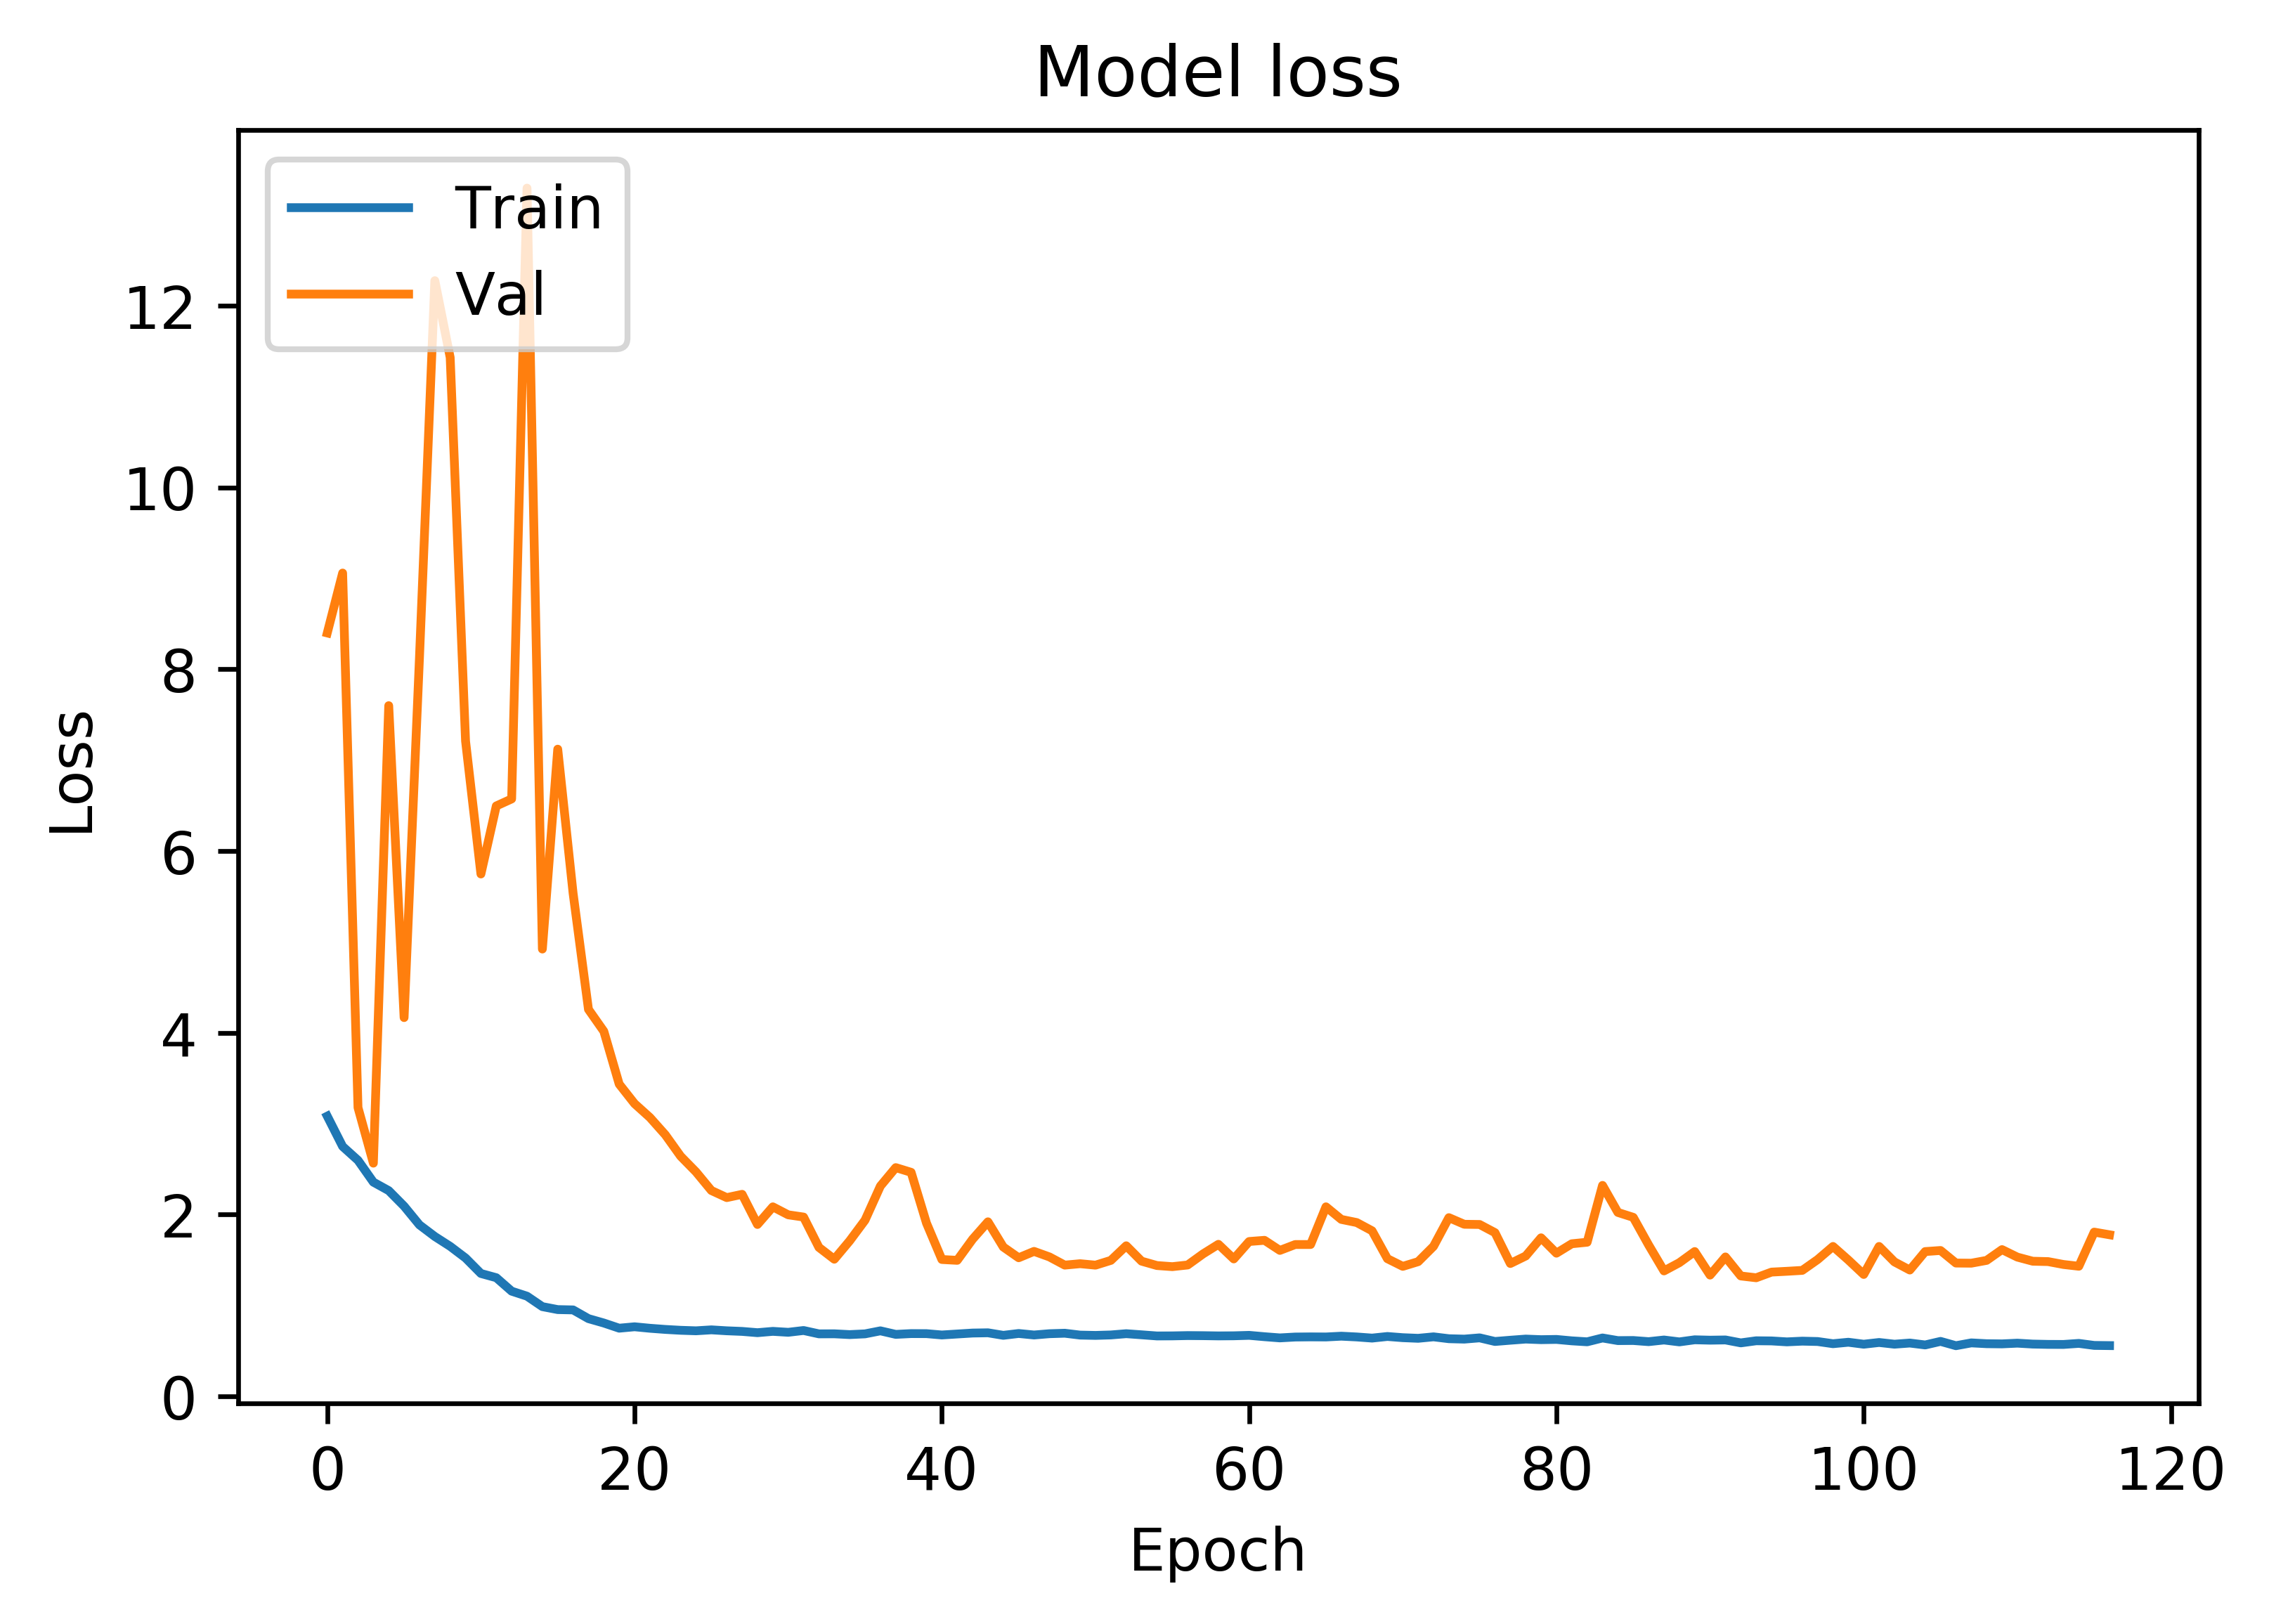

Results from K-fold: 1
acc: 41.14%
632/632 [==============================] - 1s 1ms/step
[1.712986781627317, 0.41139240506329117]
           bar  gel  network  plot  histology  sequence  line  molecular
bar         69    3        0     4          0         0     3          0
gel         20   50        0     4          0         2     3          0
network     44    0       14    18          0         1     1          1
plot        45    0        1    29          0         2     2          0
histology   60    0        0     3         15         1     0          0
sequence     8    2        0    31          1        37     0          0
line        39    1        1    13          0         0    25          0
molecular   42    0        3     4          7         2     0         21
              precision    recall  f1-score   support

         bar       0.21      0.87      0.34        79
         gel       0.89      0.63      0.74        79
     network       0.74      0.18      0.29      

Epoch 51/150
2260/2260 [==============================] - 7s 3ms/step - loss: 0.6176 - acc: 0.7982 - val_loss: 1.5883 - val_acc: 0.5040

Epoch 00051: val_acc did not improve from 0.50397
Epoch 52/150
2260/2260 [==============================] - 7s 3ms/step - loss: 0.6143 - acc: 0.8102 - val_loss: 2.2401 - val_acc: 0.3452

Epoch 00052: val_acc did not improve from 0.50397
Epoch 53/150
2260/2260 [==============================] - 7s 3ms/step - loss: 0.6160 - acc: 0.8173 - val_loss: 1.2559 - val_acc: 0.6111

Epoch 00053: val_acc improved from 0.50397 to 0.61111, saving model to unimodal_weights/best_weight_text_2d_only_k-fold_2.hdf5
Epoch 54/150
2260/2260 [==============================] - 7s 3ms/step - loss: 0.6240 - acc: 0.8084 - val_loss: 1.6060 - val_acc: 0.4881

Epoch 00054: val_acc did not improve from 0.61111
Epoch 55/150
2260/2260 [==============================] - 7s 3ms/step - loss: 0.6203 - acc: 0.8000 - val_loss: 1.7528 - val_acc: 0.4365

Epoch 00055: val_acc did not improve f

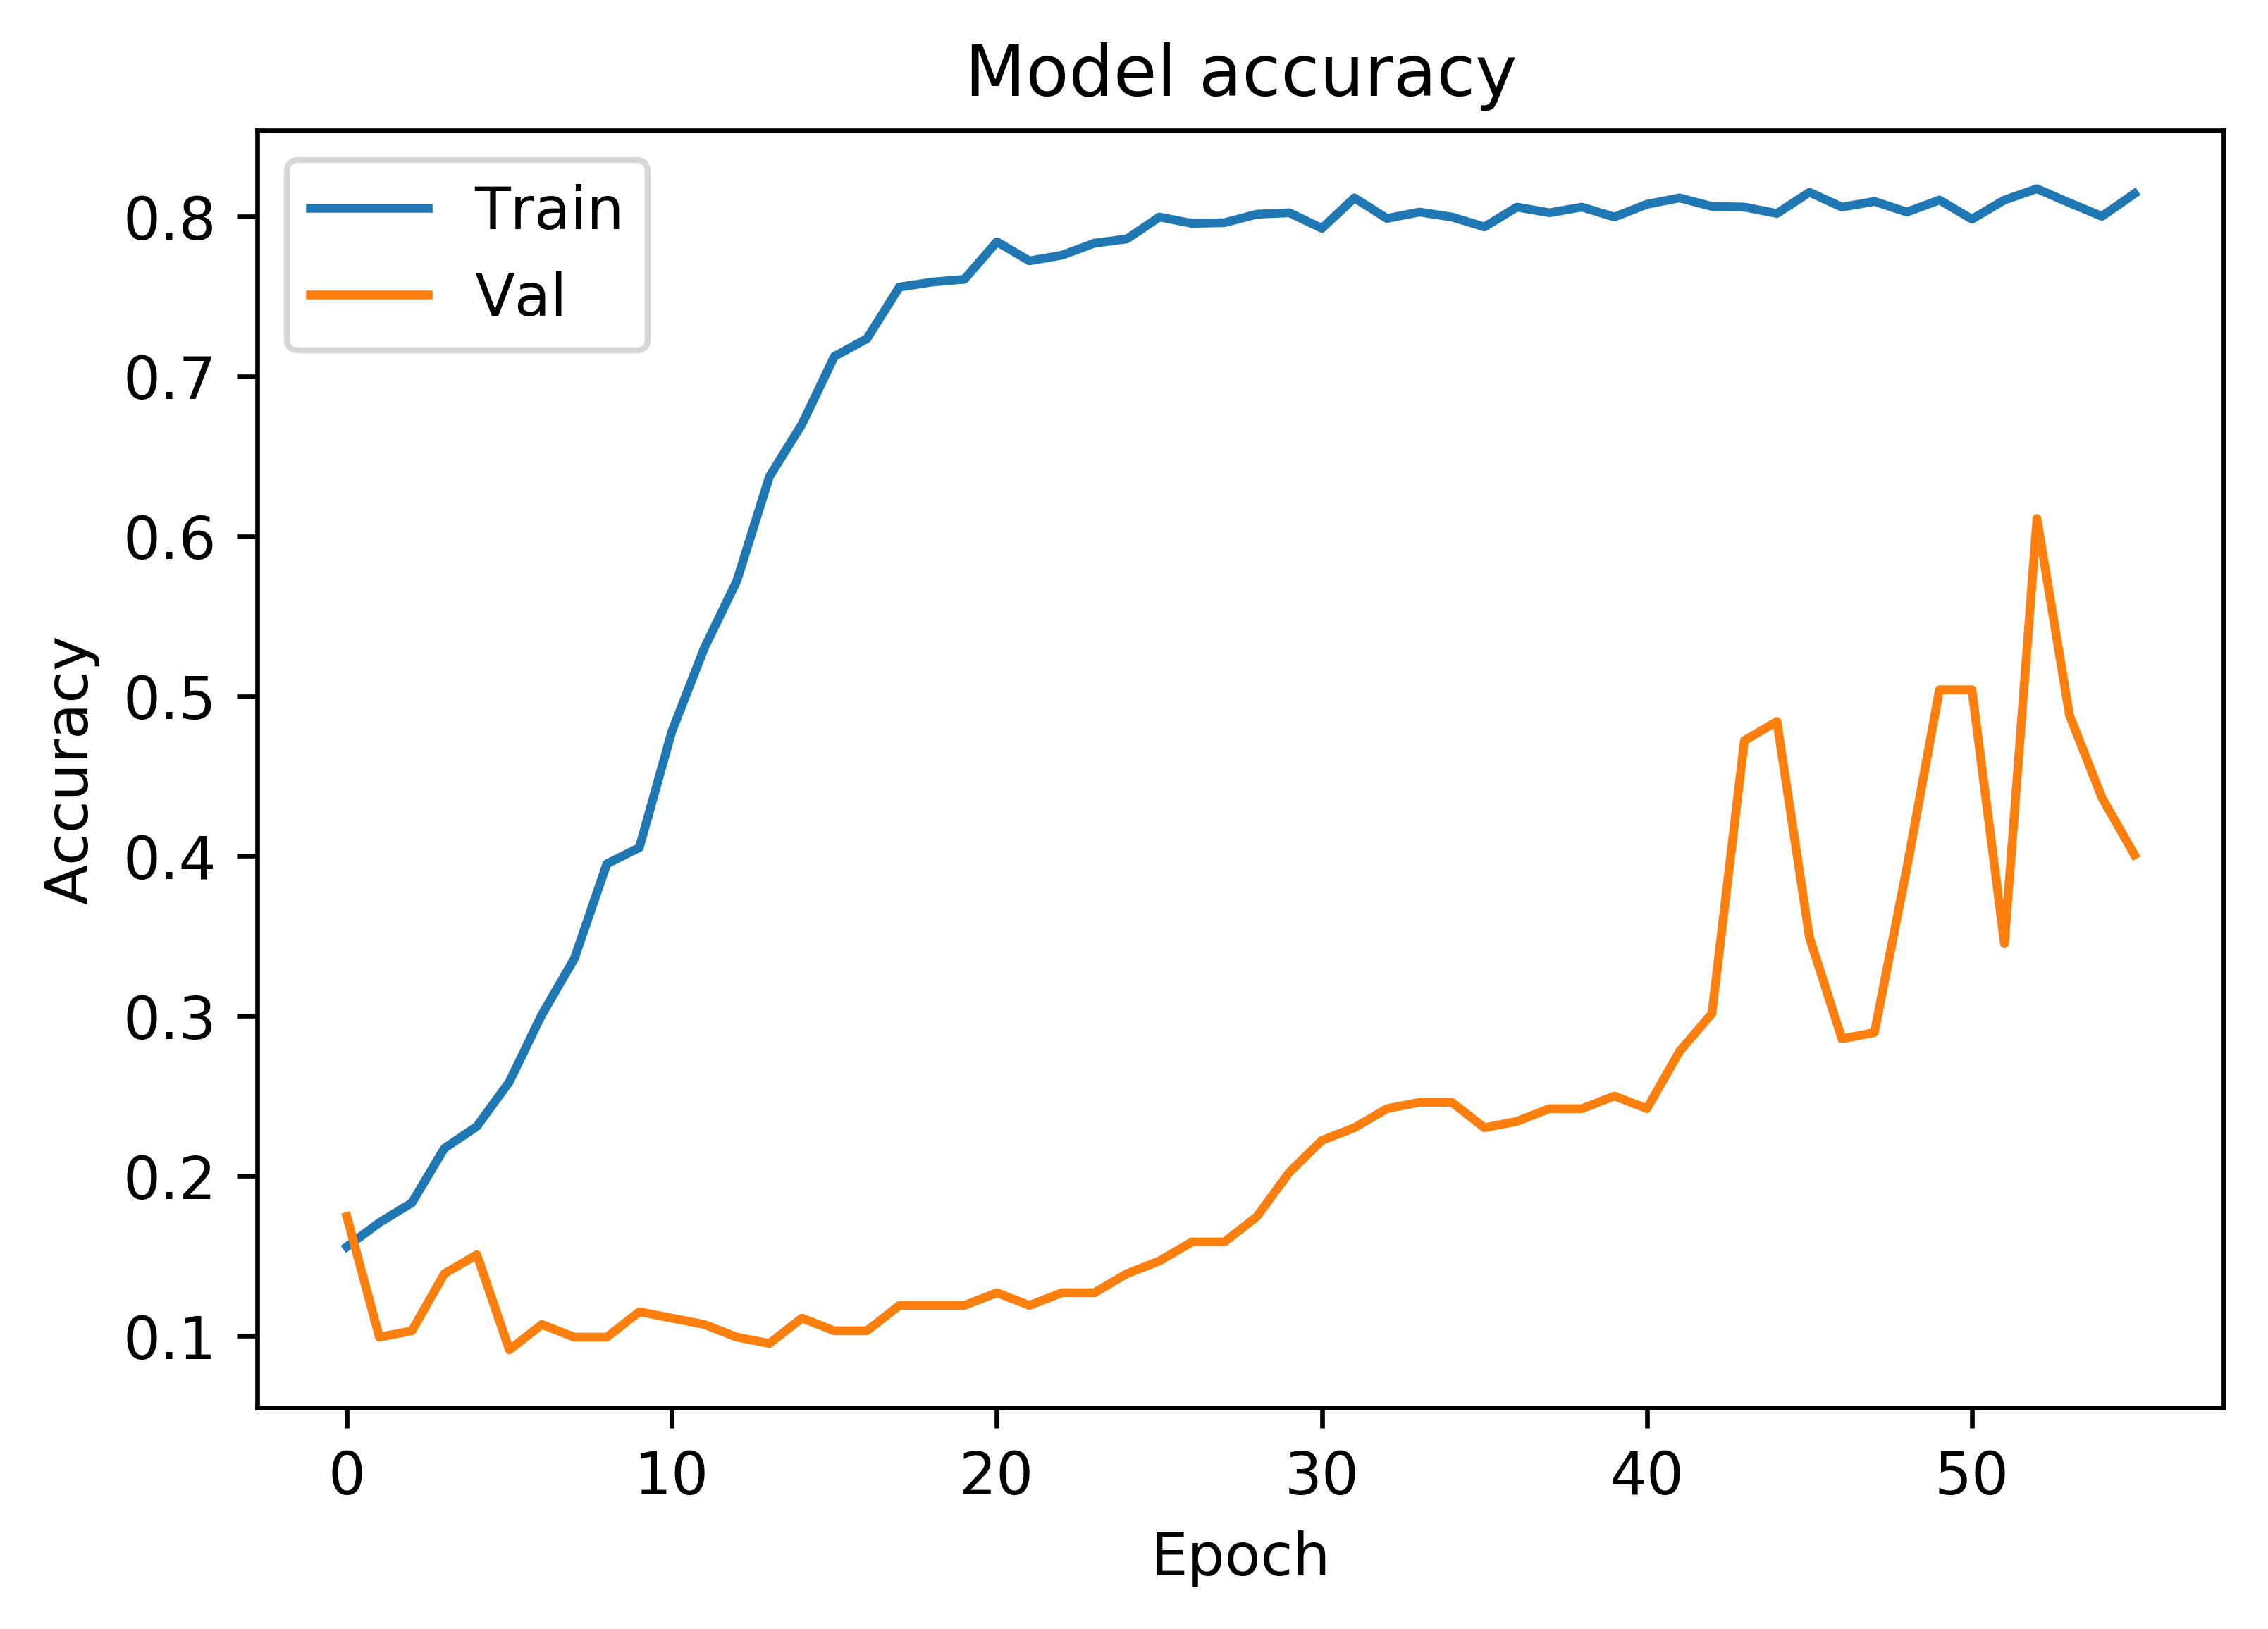

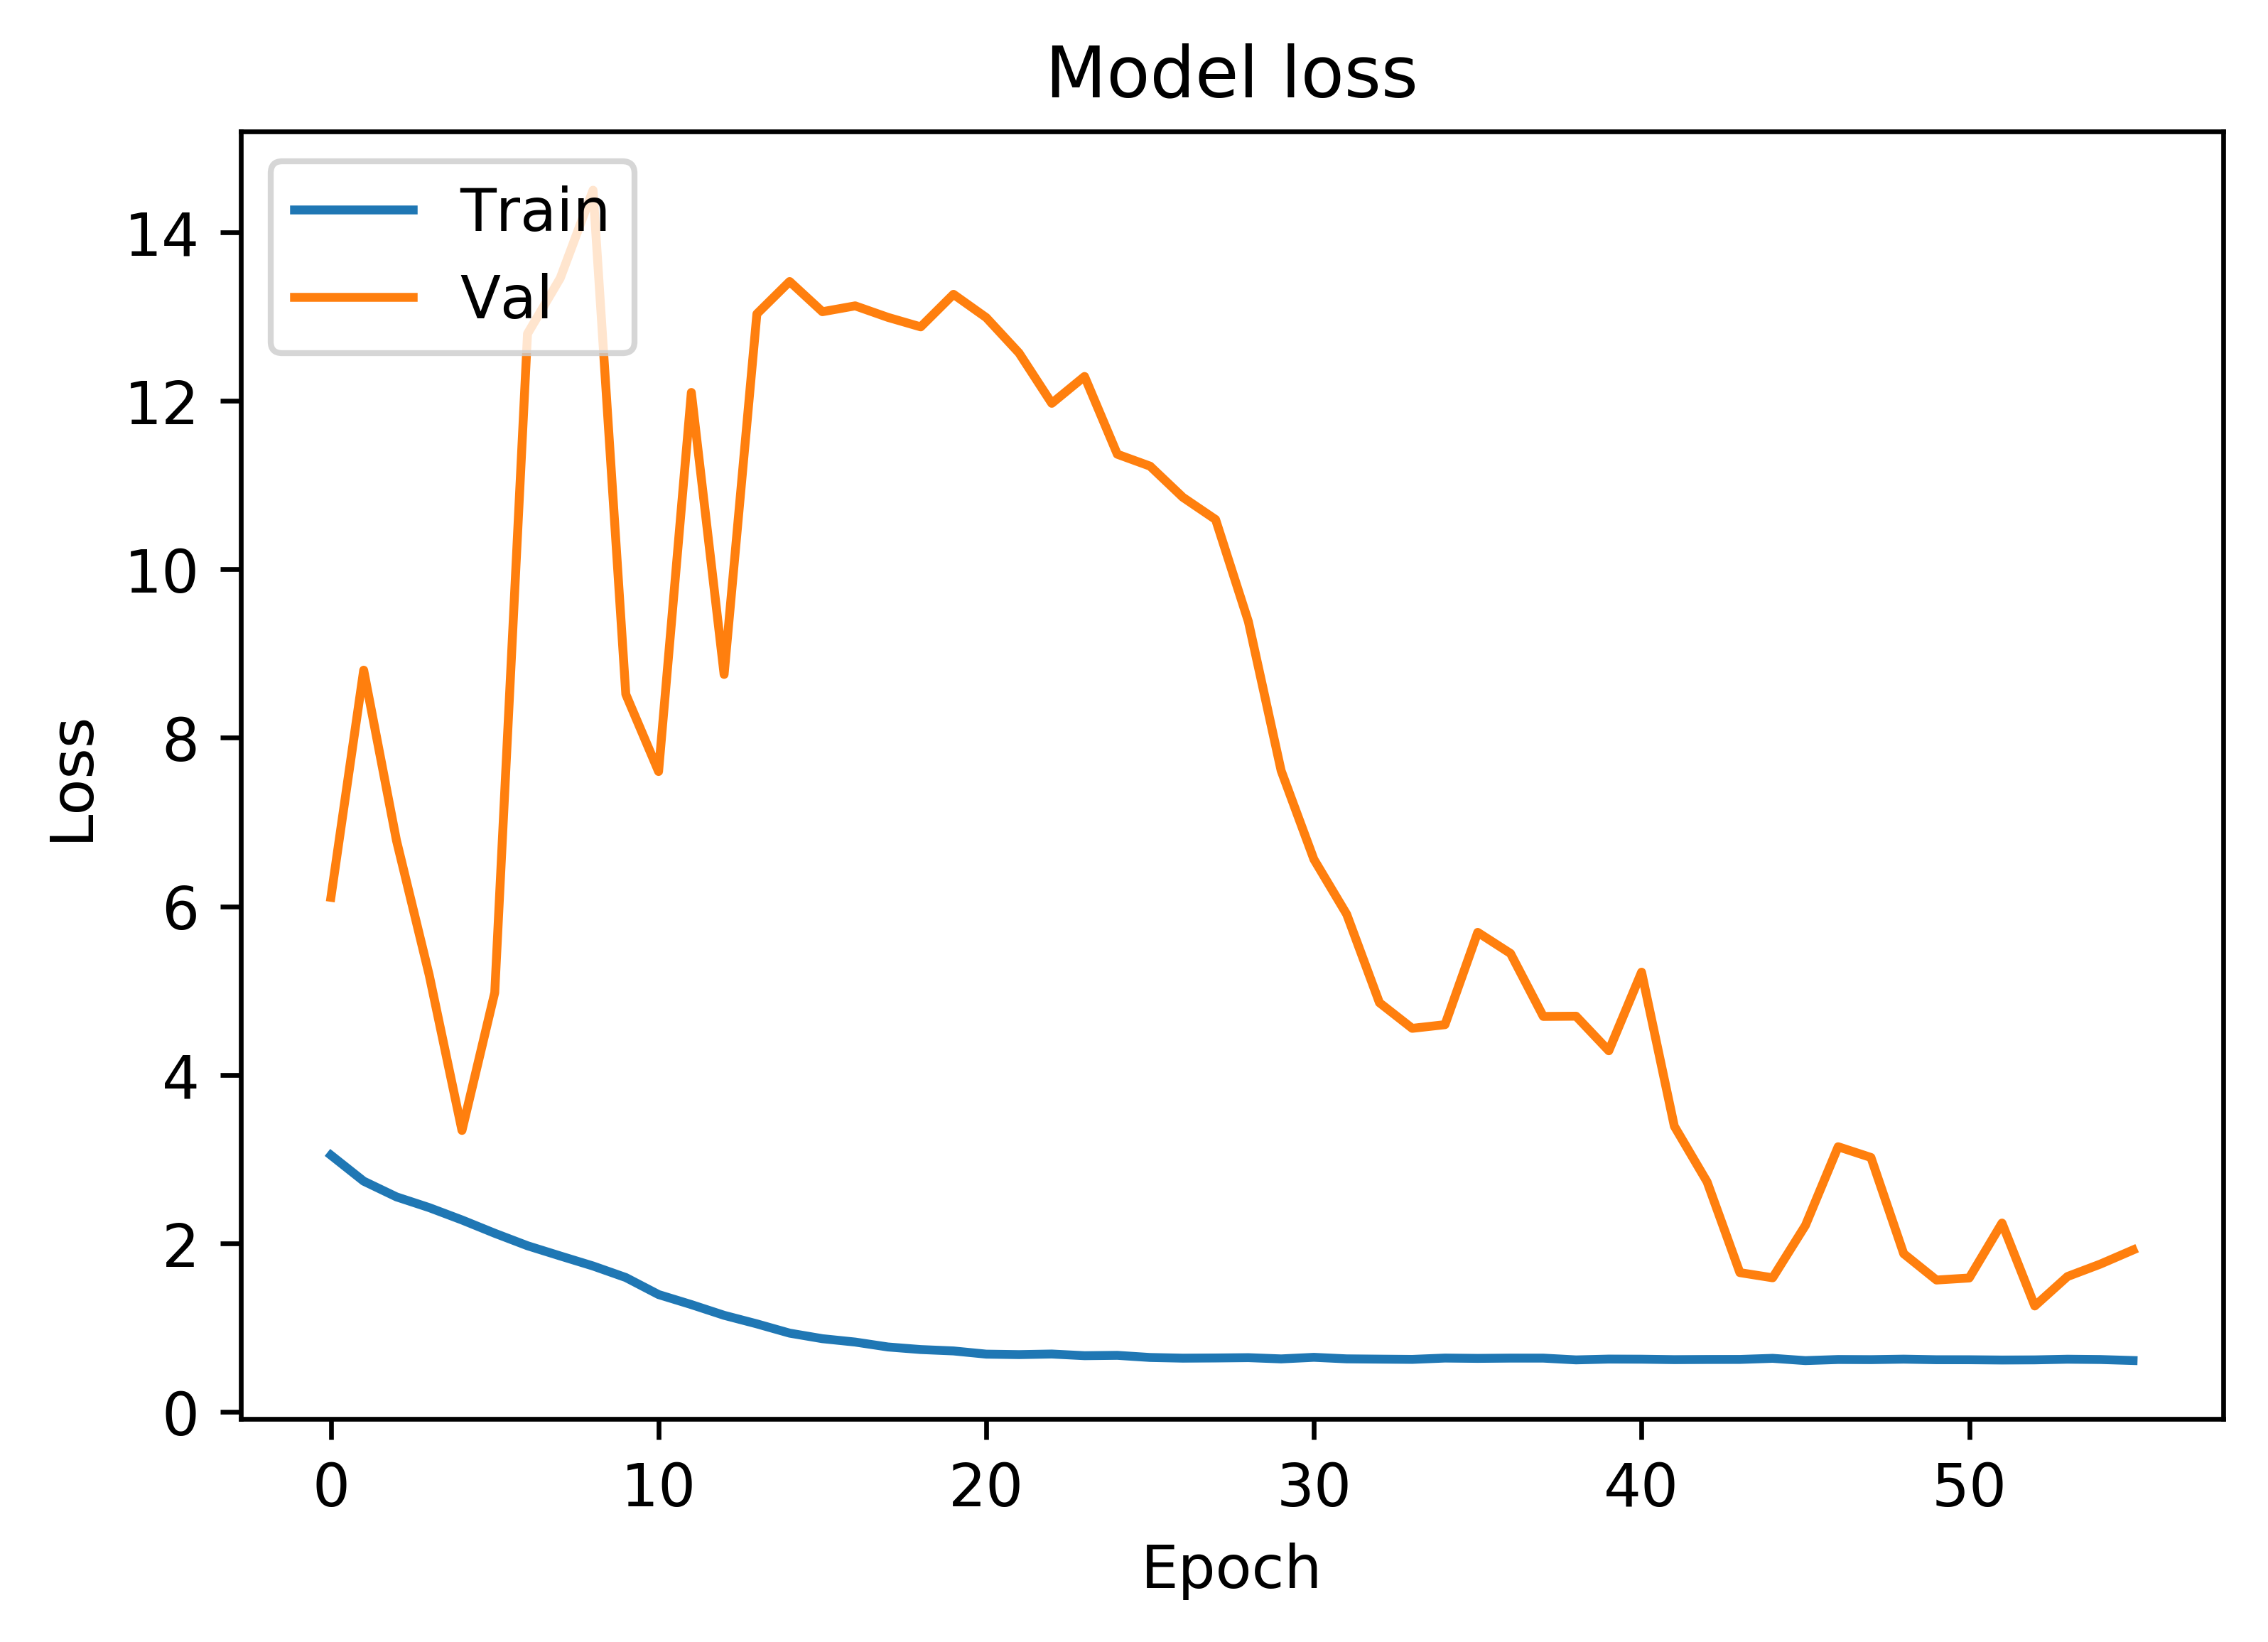

Results from K-fold: 2
acc: 45.89%
632/632 [==============================] - 1s 1ms/step
[1.816571676278416, 0.4588607602481601]
           bar  gel  network  plot  histology  sequence  line  molecular
bar         28   33        2     5          7         1     3          0
gel         17   54        1     1          1         1     4          0
network      1   31       21     8          5         0    13          0
plot         7   16        1    40          7         1     7          0
histology    2   24        0     1         52         0     0          0
sequence     1   11        0     5          5        47    10          0
line         7   29        2     2          2         0    37          0
molecular    2   42        2     2         19         0     1         11
              precision    recall  f1-score   support

         bar       0.43      0.35      0.39        79
         gel       0.23      0.68      0.34        79
     network       0.72      0.27      0.39       


Epoch 00012: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 00012: val_acc did not improve from 0.25397
Epoch 13/150
2260/2260 [==============================] - 7s 3ms/step - loss: 1.4586 - acc: 0.4372 - val_loss: 11.1596 - val_acc: 0.1230

Epoch 00013: val_acc did not improve from 0.25397
Epoch 14/150
2260/2260 [==============================] - 7s 3ms/step - loss: 1.3634 - acc: 0.4788 - val_loss: 11.9212 - val_acc: 0.1071

Epoch 00014: val_acc did not improve from 0.25397
Epoch 15/150
2260/2260 [==============================] - 7s 3ms/step - loss: 1.2345 - acc: 0.5190 - val_loss: 11.6513 - val_acc: 0.1032

Epoch 00015: val_acc did not improve from 0.25397
Epoch 16/150
2260/2260 [==============================] - 7s 3ms/step - loss: 1.1651 - acc: 0.5522 - val_loss: 12.3134 - val_acc: 0.1071

Epoch 00016: val_acc did not improve from 0.25397
Epoch 17/150
2260/2260 [==============================] - 7s 3ms/step - loss: 1.0526 - acc: 0.6106 - val_loss: 12.6

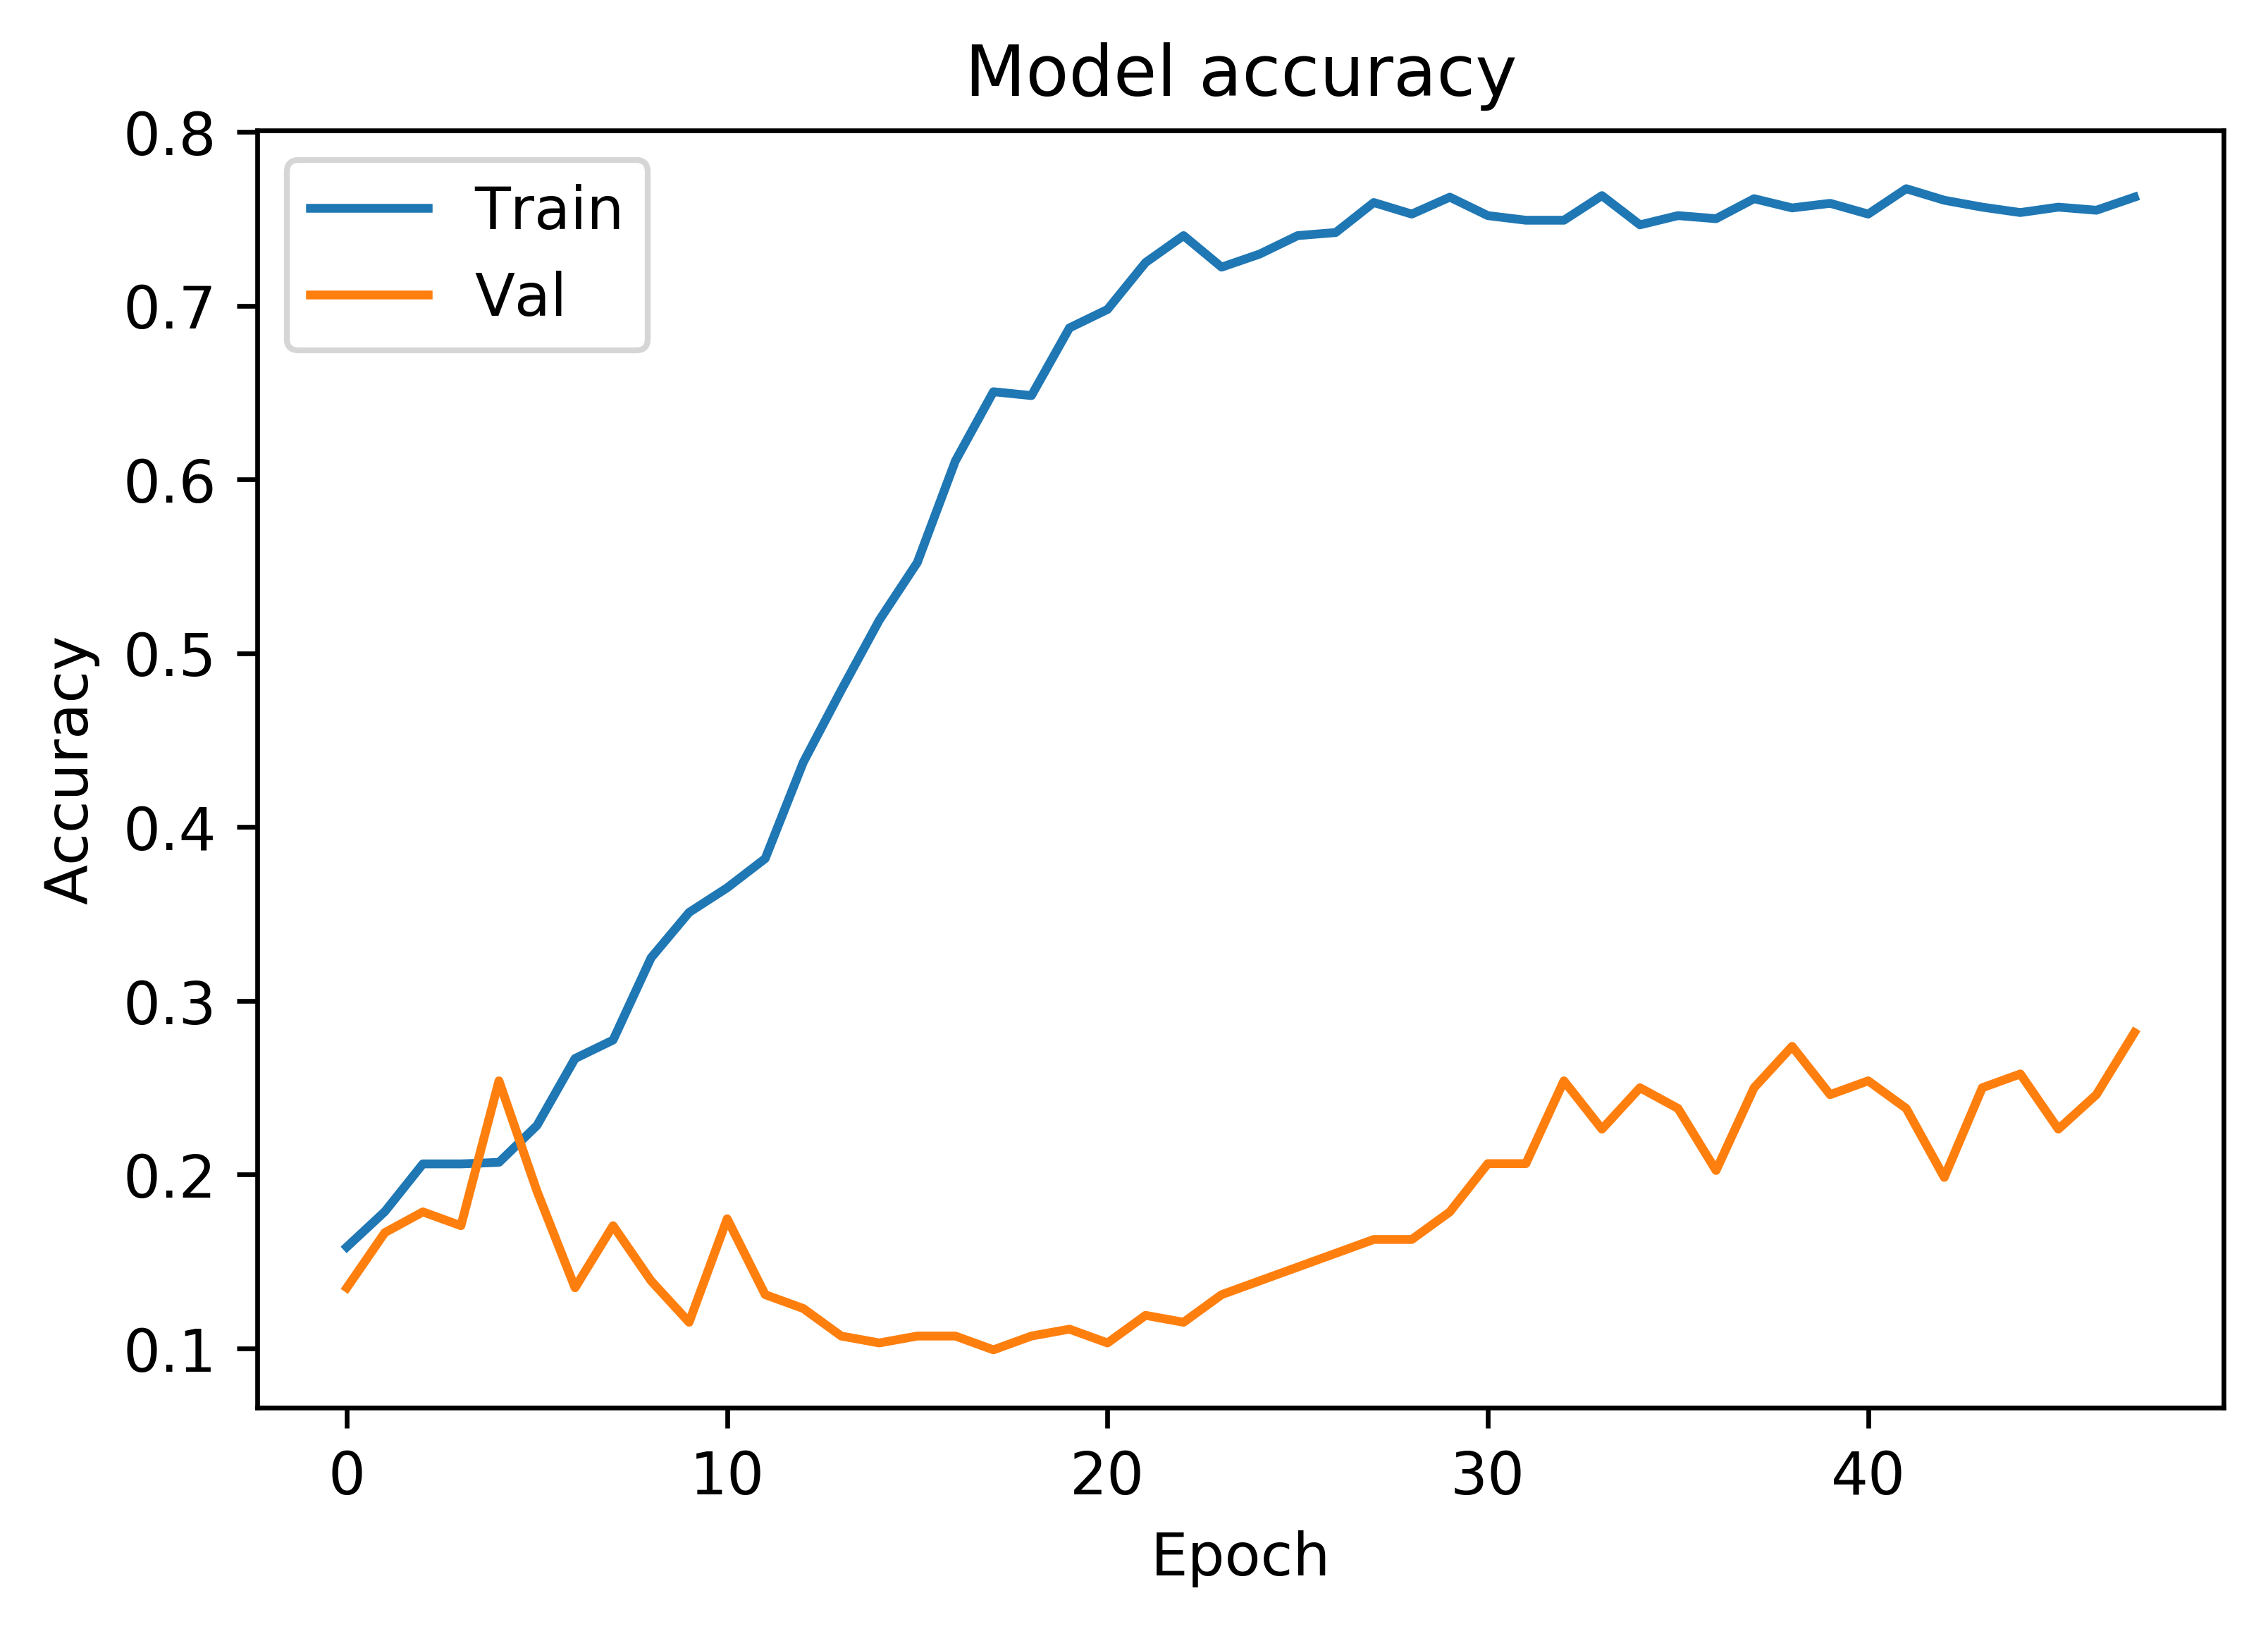

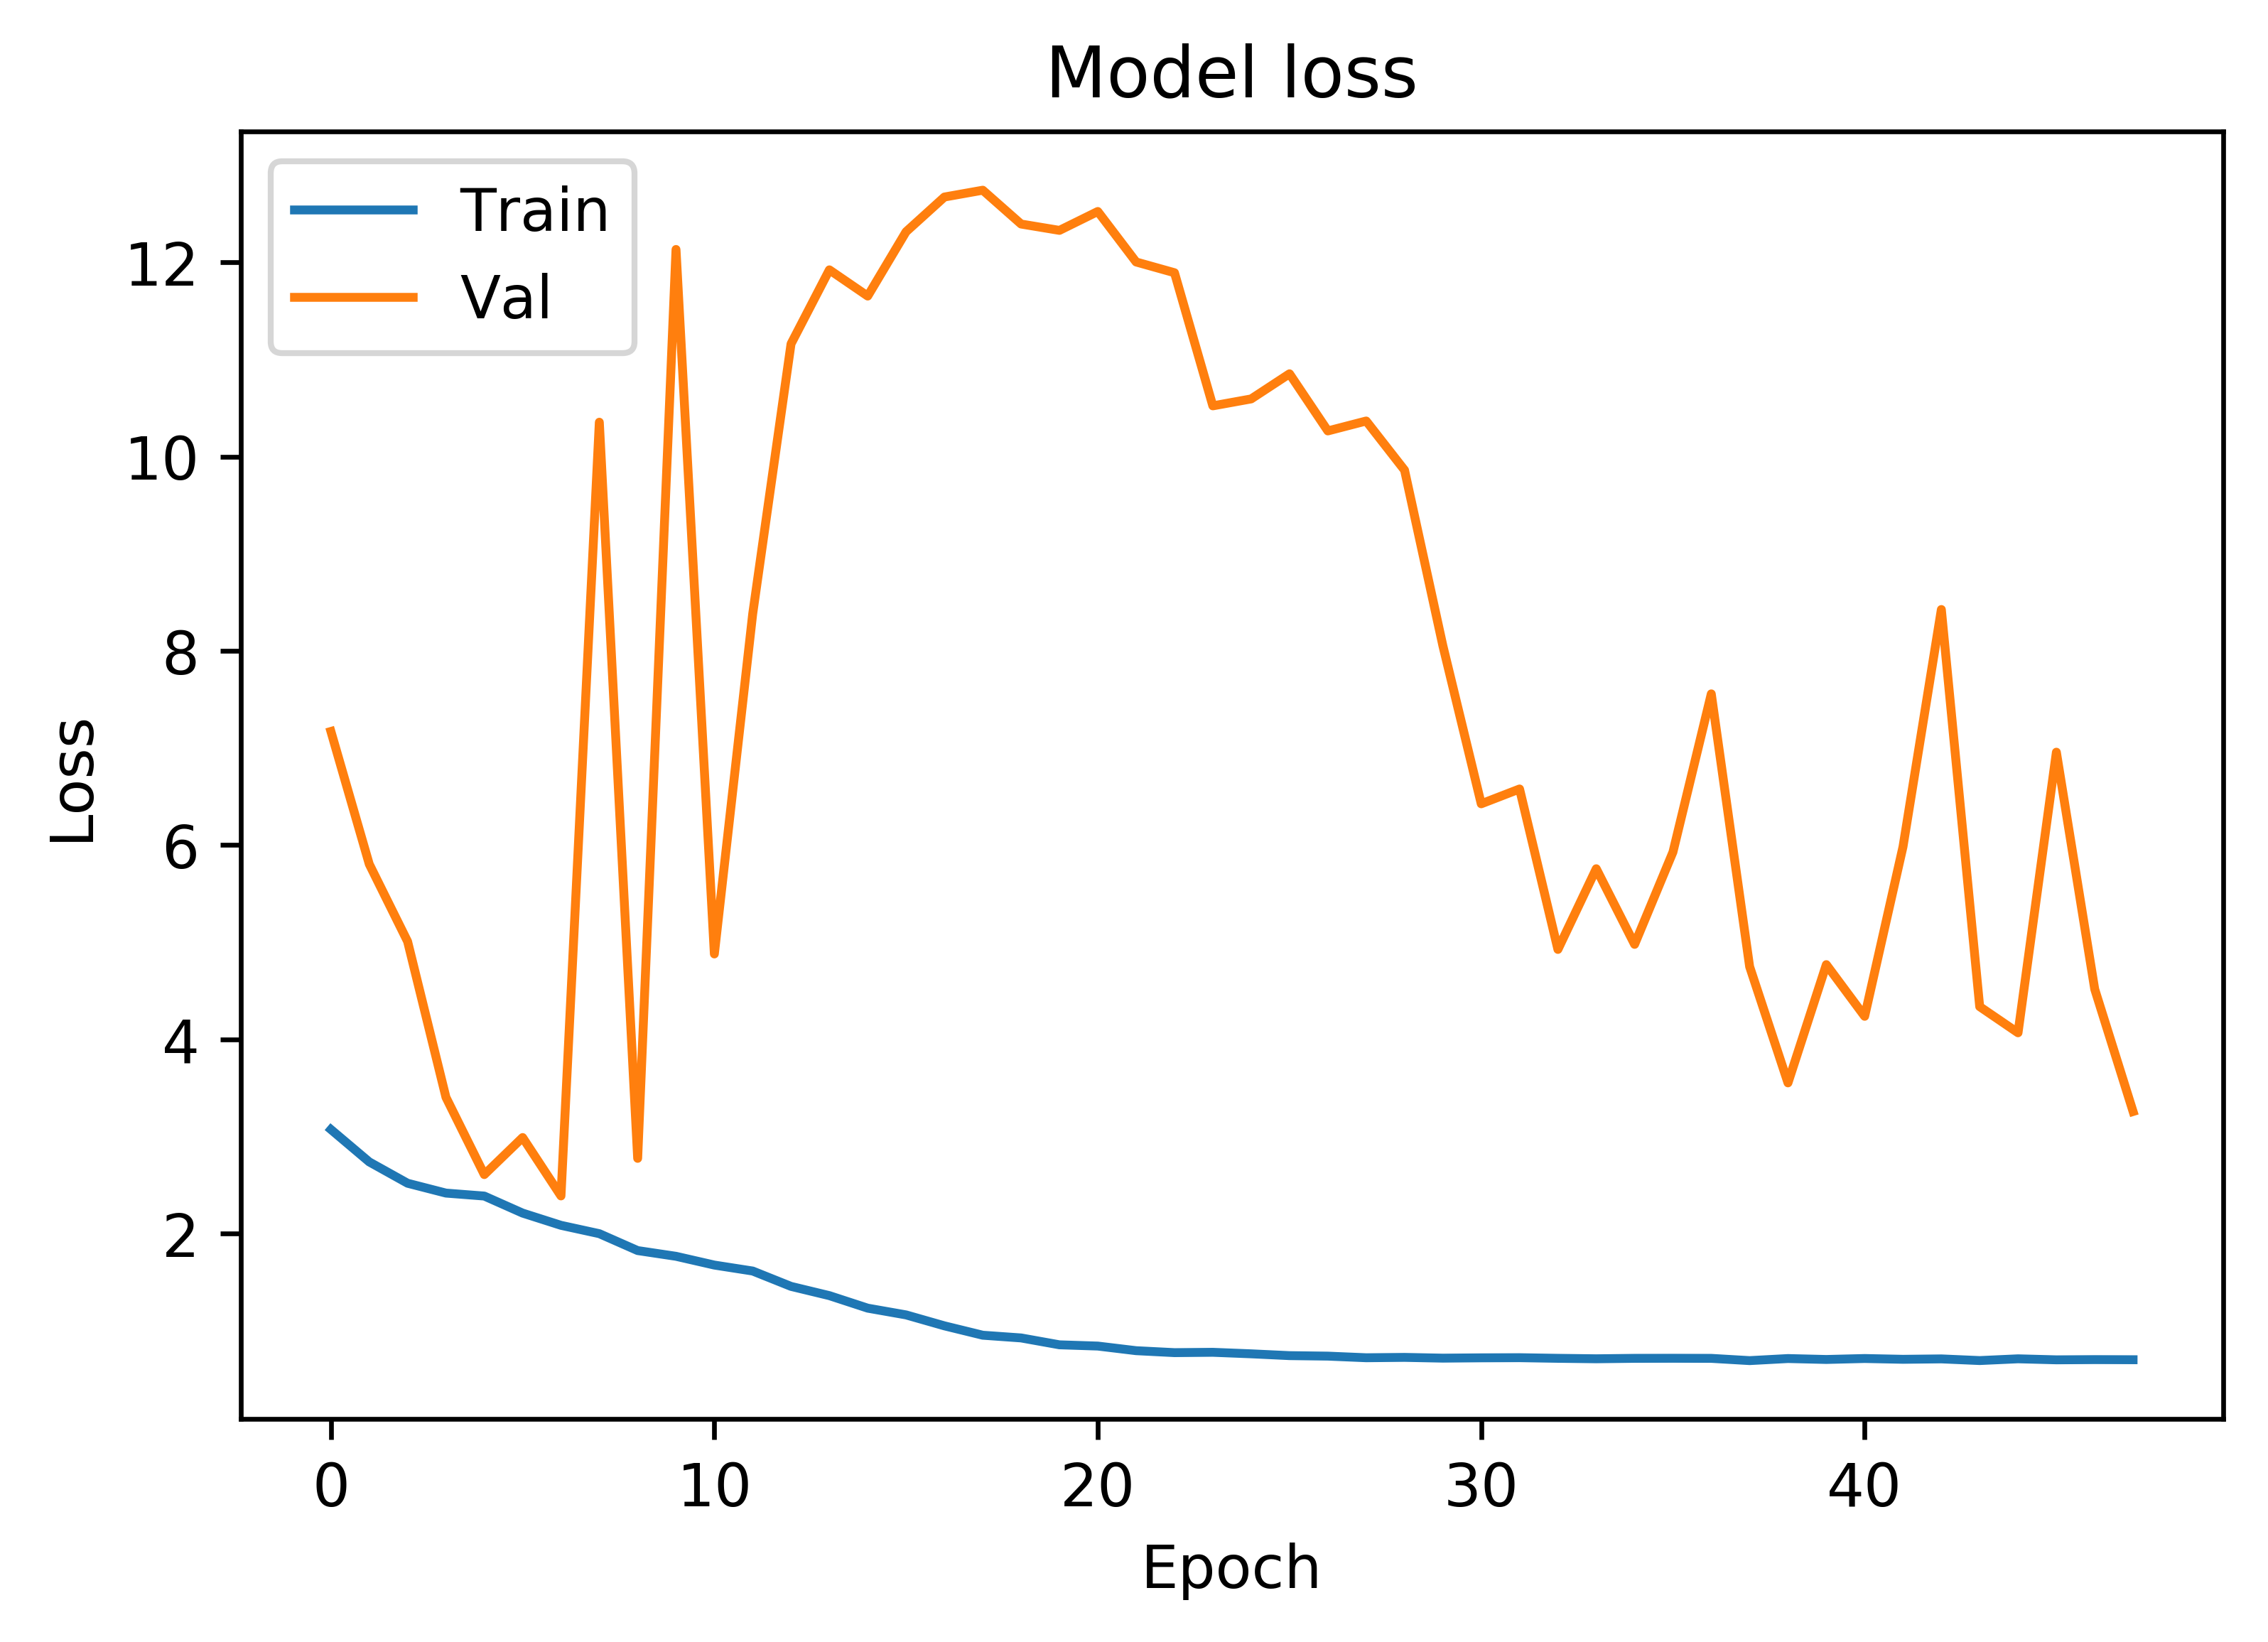

Results from K-fold: 3
acc: 29.91%
632/632 [==============================] - 1s 1ms/step
[3.2411252848709684, 0.2990506325341478]
           bar  gel  network  plot  histology  sequence  line  molecular
bar         11   50        0    11          0         0     7          0
gel          7   58        0     6          0         2     6          0
network      0   52        9    14          0         3     0          1
plot         0   37        0    40          0         1     1          0
histology    0   65        0     0         13         0     0          1
sequence     0   41        0    16          0        19     2          1
line         1   26        0    25          0         0    27          0
molecular    0   63        0     3          0         1     0         12
              precision    recall  f1-score   support

         bar       0.58      0.14      0.22        79
         gel       0.15      0.73      0.25        79
     network       1.00      0.11      0.20      


Epoch 00016: val_acc did not improve from 0.18651
Epoch 17/150
2268/2268 [==============================] - 7s 3ms/step - loss: 0.6780 - acc: 0.7747 - val_loss: 10.5818 - val_acc: 0.1230

Epoch 00017: val_acc did not improve from 0.18651
Epoch 18/150
2268/2268 [==============================] - 7s 3ms/step - loss: 0.6234 - acc: 0.7888 - val_loss: 10.4158 - val_acc: 0.1429

Epoch 00018: val_acc did not improve from 0.18651
Epoch 19/150
2268/2268 [==============================] - 7s 3ms/step - loss: 0.5896 - acc: 0.8131 - val_loss: 10.7101 - val_acc: 0.1508

Epoch 00019: val_acc did not improve from 0.18651
Epoch 20/150
2268/2268 [==============================] - 7s 3ms/step - loss: 0.5717 - acc: 0.8108 - val_loss: 8.9721 - val_acc: 0.1310

Epoch 00020: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.

Epoch 00020: val_acc did not improve from 0.18651
Epoch 21/150
2268/2268 [==============================] - 7s 3ms/step - loss: 0.5342 - acc: 0.8298 - val_loss: 10.345

2268/2268 [==============================] - 7s 3ms/step - loss: 0.4537 - acc: 0.8624 - val_loss: 1.7401 - val_acc: 0.4722

Epoch 00055: val_acc did not improve from 0.50397
Epoch 56/150
2268/2268 [==============================] - 7s 3ms/step - loss: 0.4529 - acc: 0.8629 - val_loss: 1.2059 - val_acc: 0.6230

Epoch 00056: val_acc improved from 0.50397 to 0.62302, saving model to unimodal_weights/best_weight_text_2d_only_k-fold_4.hdf5
Epoch 57/150
2268/2268 [==============================] - 7s 3ms/step - loss: 0.4484 - acc: 0.8593 - val_loss: 1.5021 - val_acc: 0.4841

Epoch 00057: val_acc did not improve from 0.62302
Epoch 58/150
2268/2268 [==============================] - 7s 3ms/step - loss: 0.4499 - acc: 0.8616 - val_loss: 1.7986 - val_acc: 0.4325

Epoch 00058: val_acc did not improve from 0.62302
Epoch 59/150
2268/2268 [==============================] - 7s 3ms/step - loss: 0.4445 - acc: 0.8598 - val_loss: 1.9627 - val_acc: 0.3889

Epoch 00059: val_acc did not improve from 0.62302
E

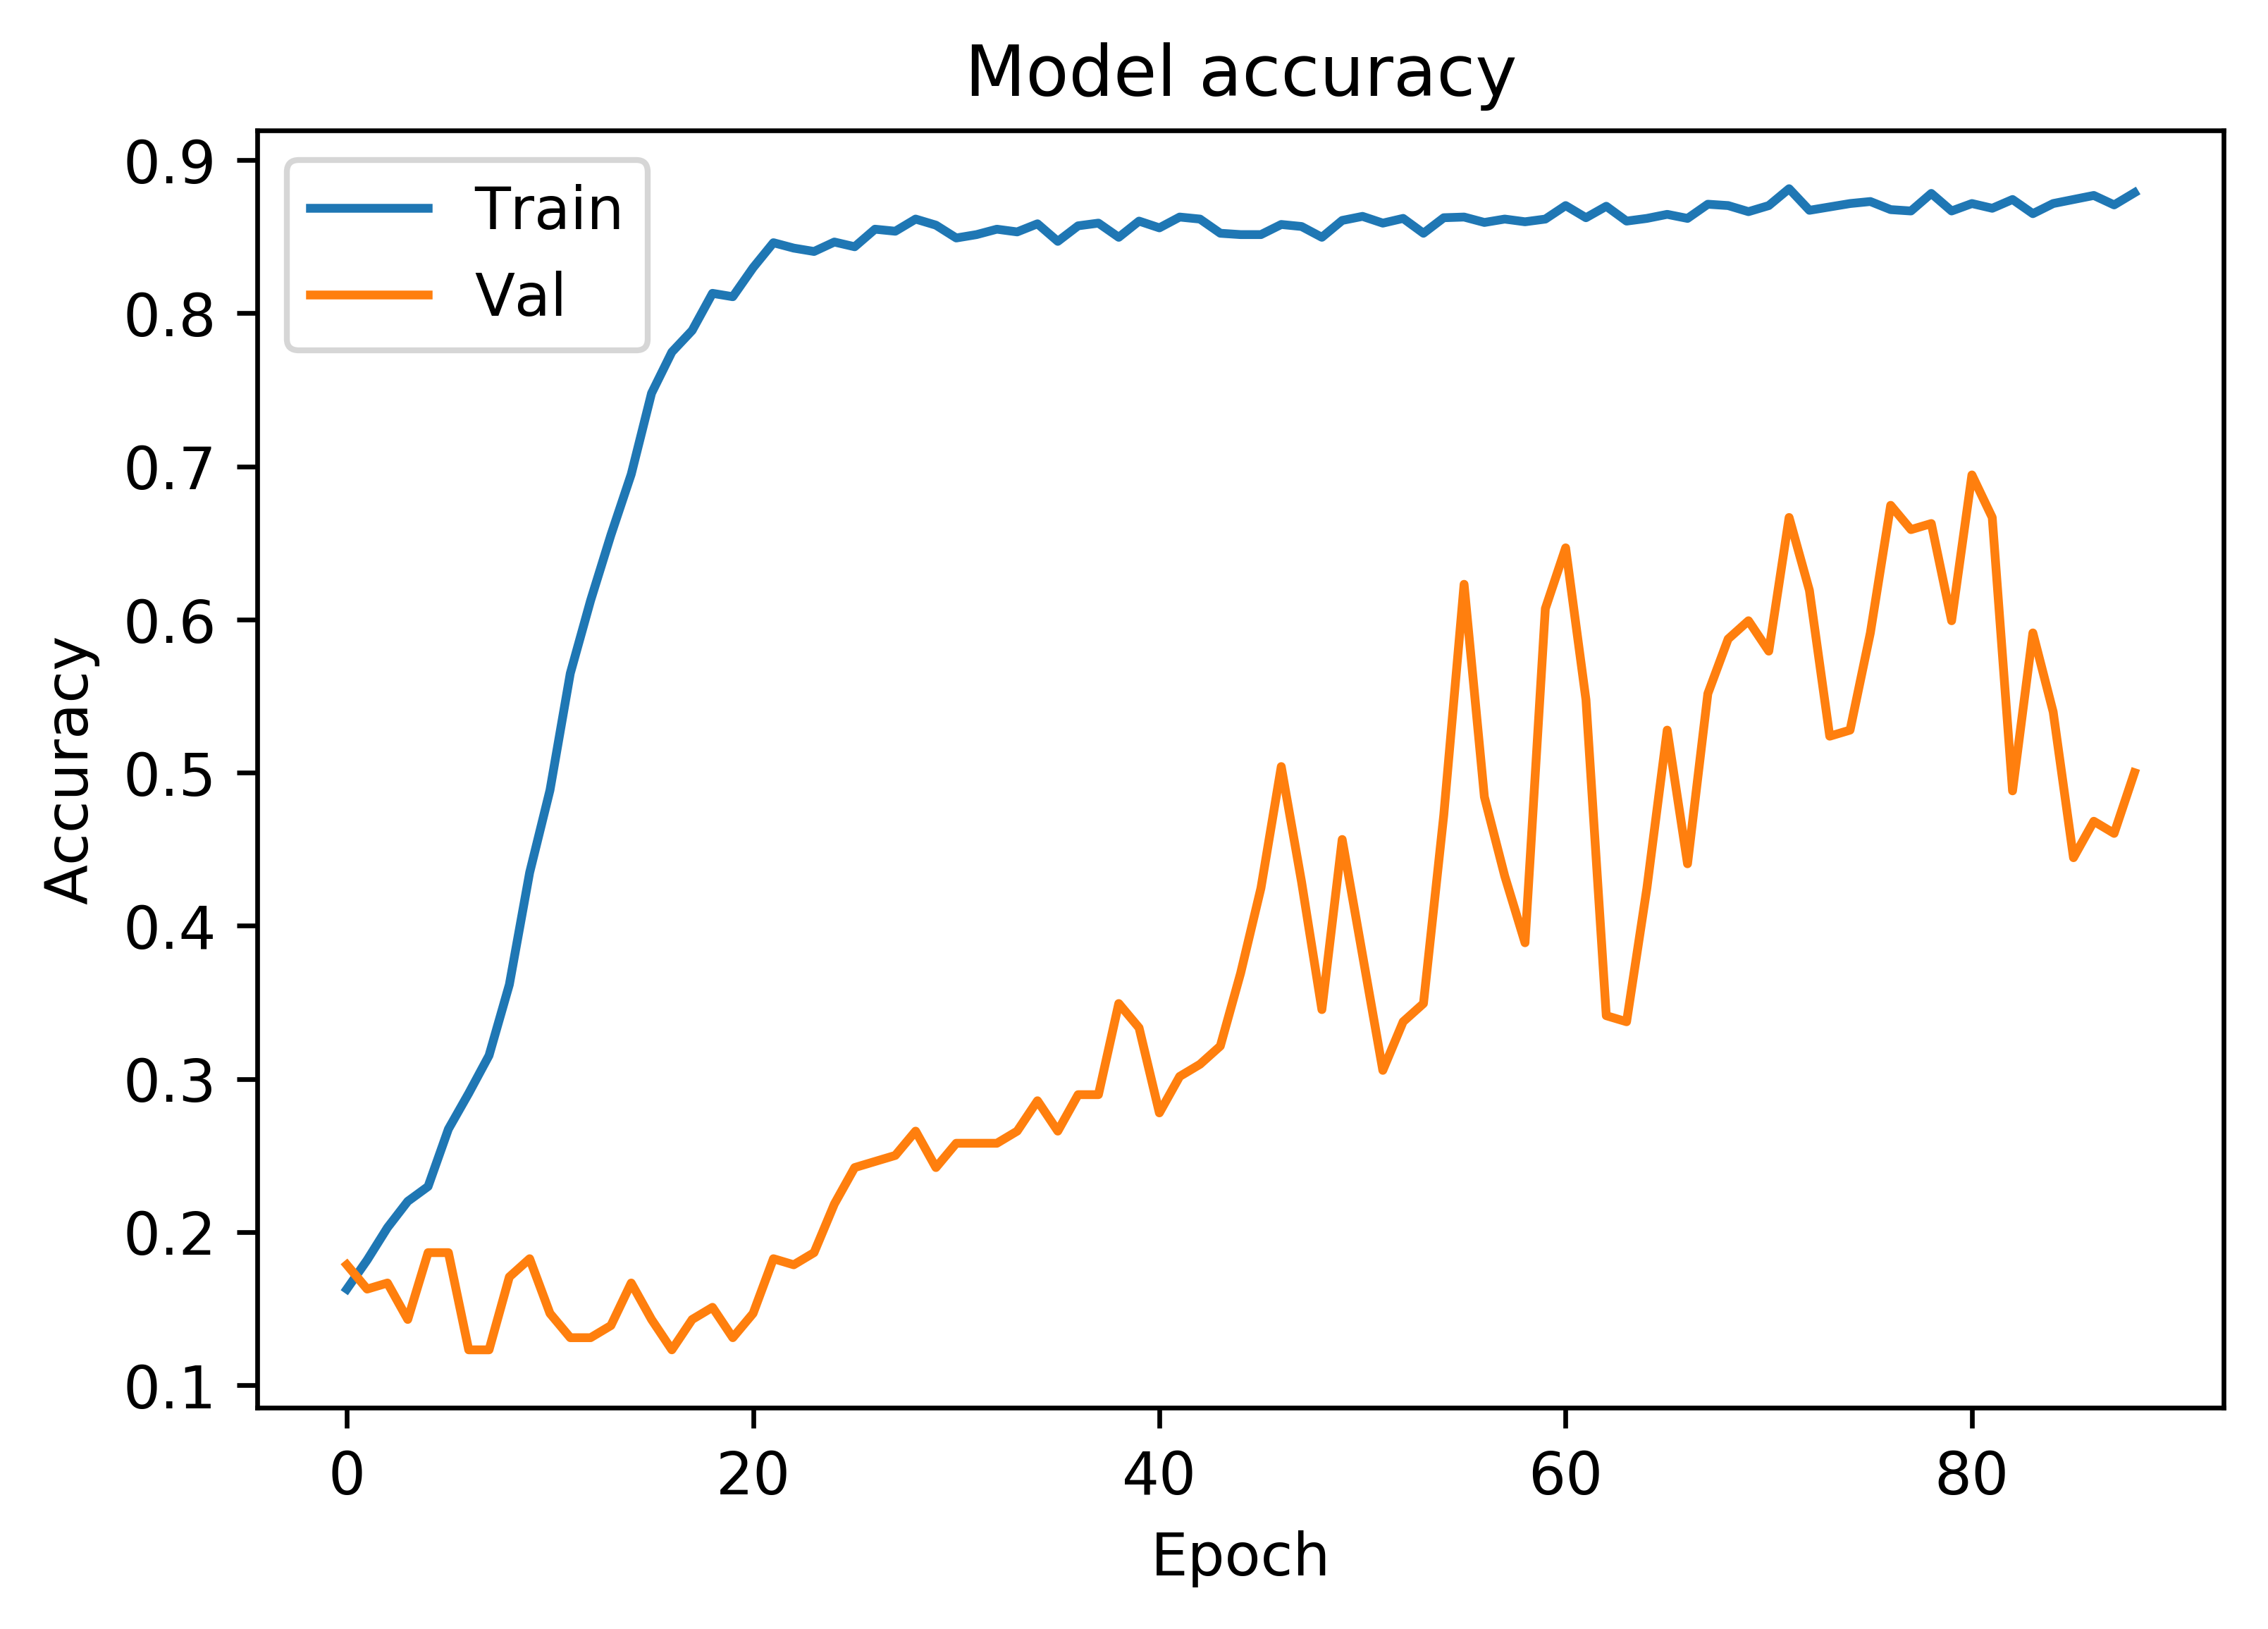

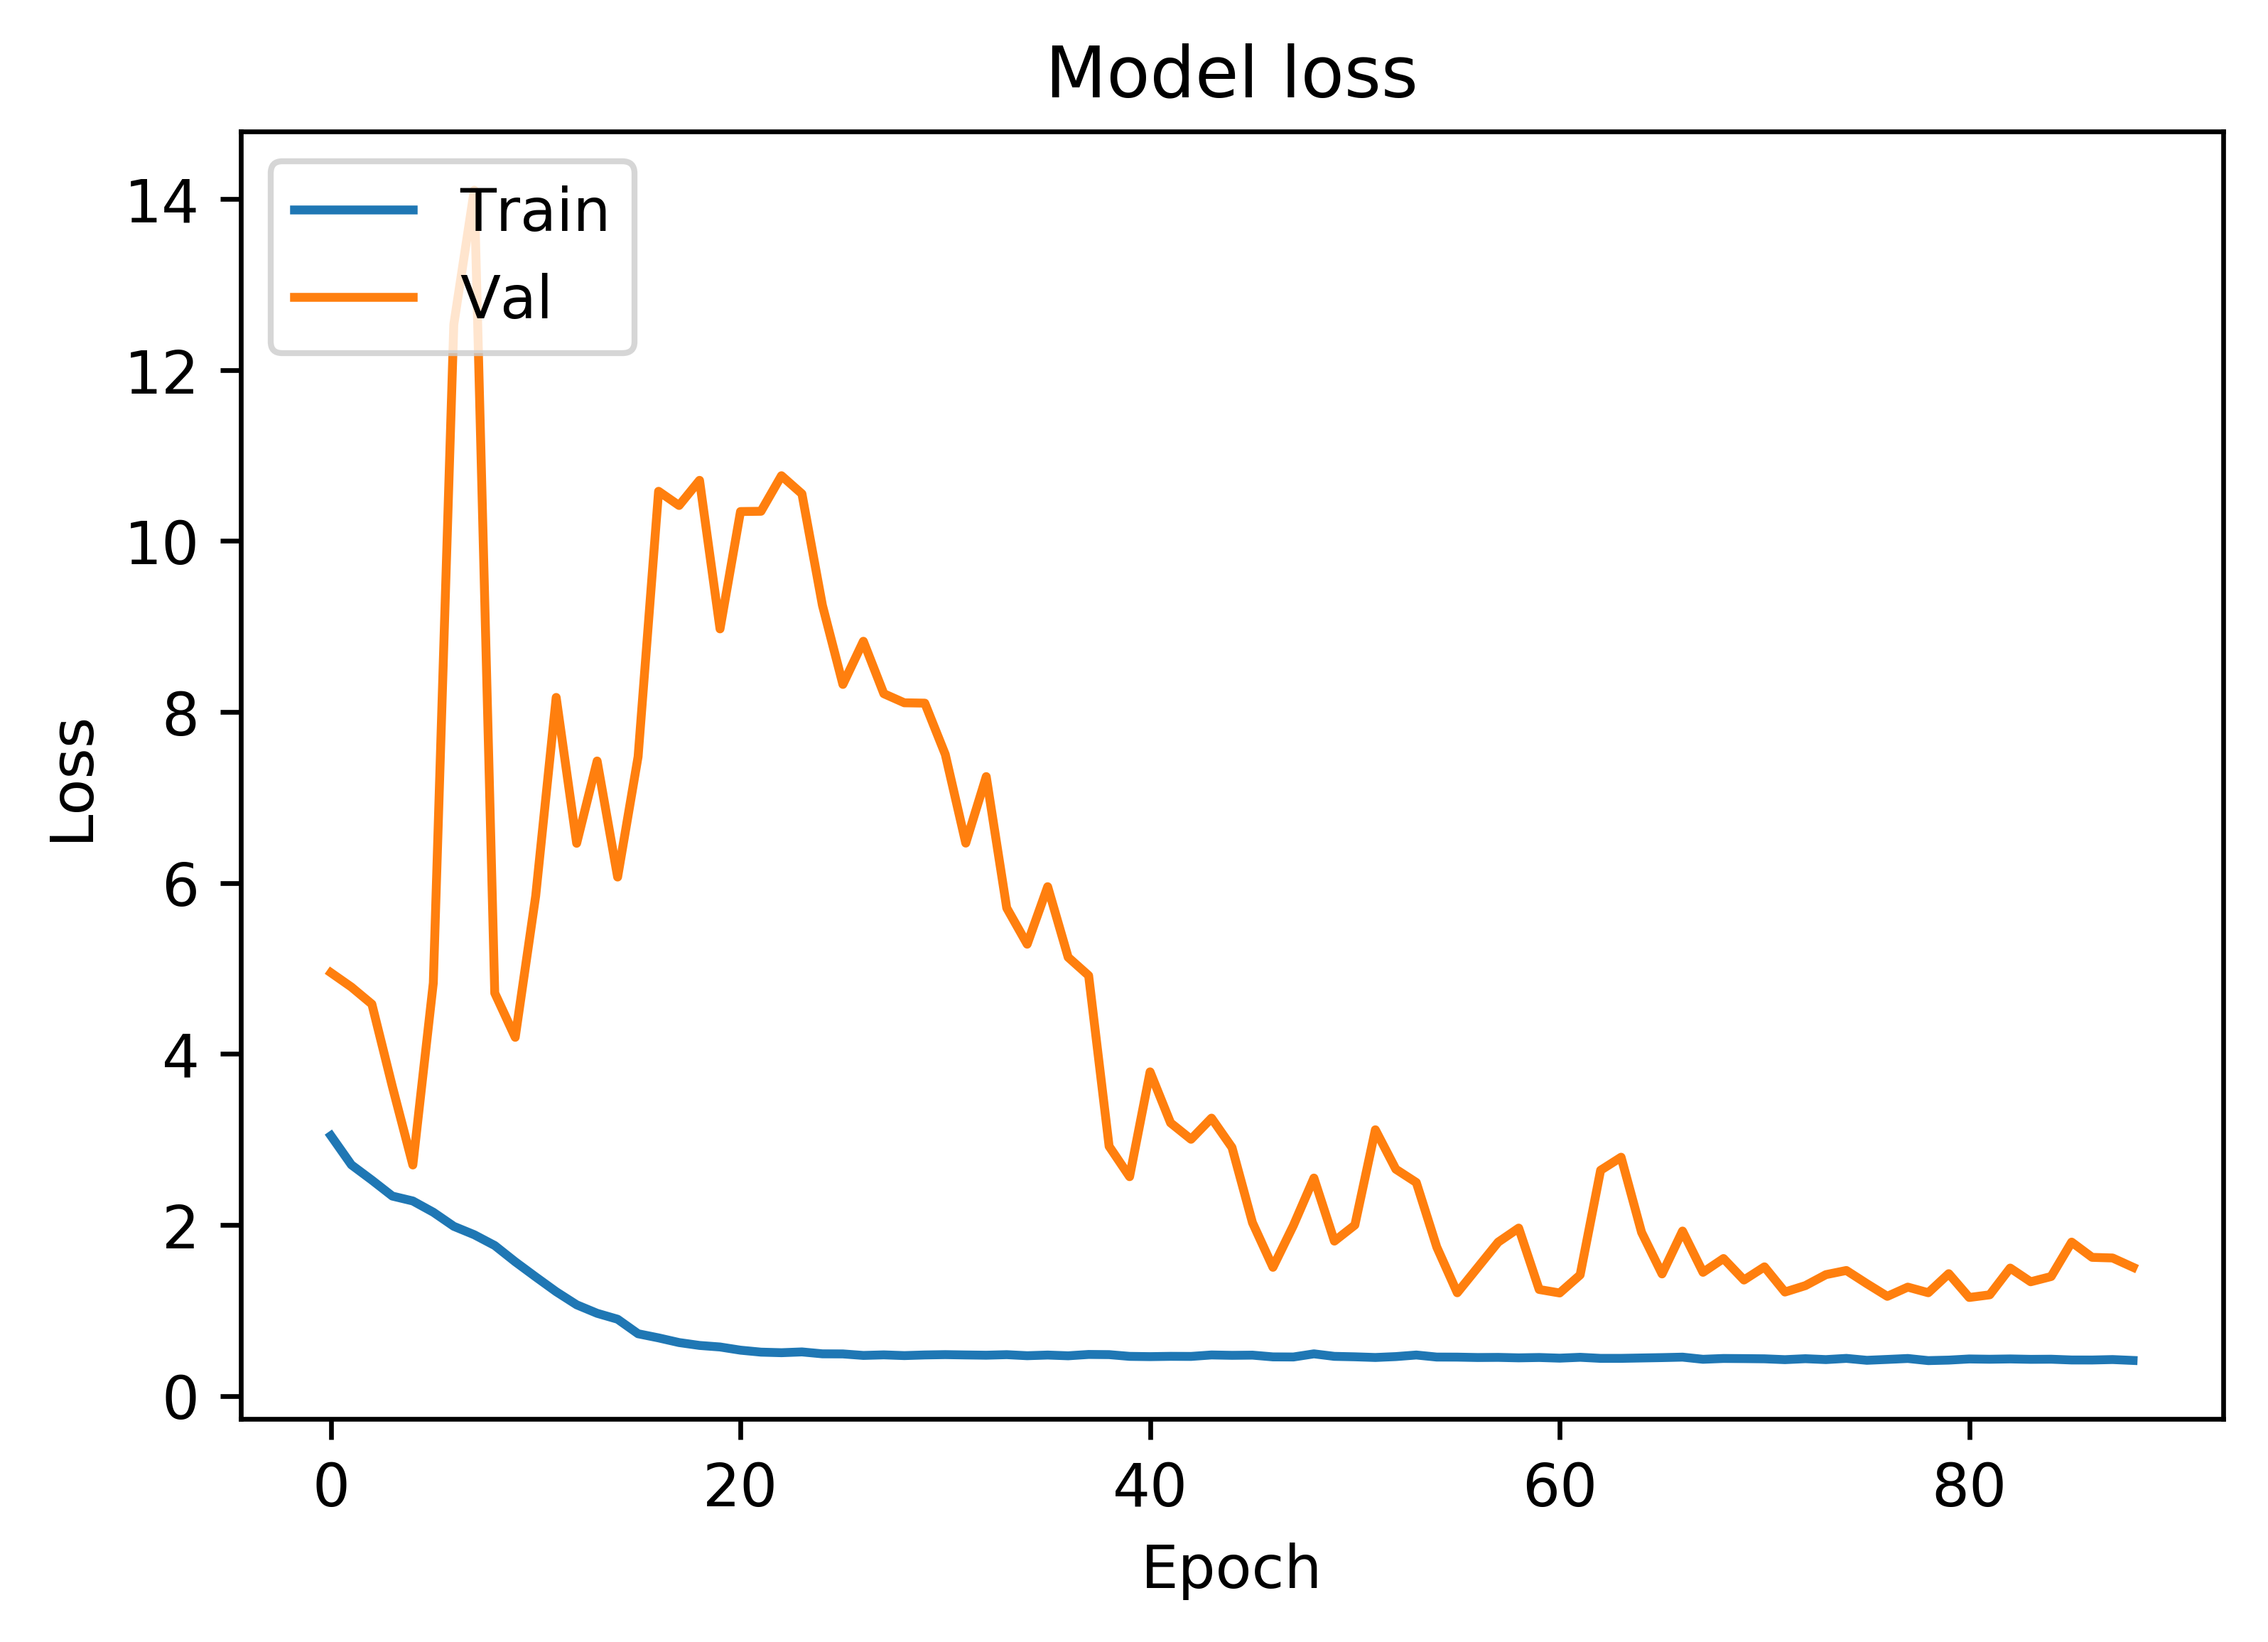

Results from K-fold: 4
acc: 52.72%
624/624 [==============================] - 1s 1ms/step
[1.4313063827844767, 0.5272435897435898]
           bar  gel  network  plot  histology  sequence  line  molecular
bar         42    3        0     2          1        19    11          0
gel          8   44        0     1         13         6     6          0
network      1    0       13     1          0        57     6          0
plot         8    0        1    42          0        17    10          0
histology    1    0        0     0         46        30     1          0
sequence     3    0        0     0          0        74     1          0
line         4    0        0     3          1        14    56          0
molecular    0    0        0     0          3        61     2         12
              precision    recall  f1-score   support

         bar       0.63      0.54      0.58        78
         gel       0.94      0.56      0.70        78
     network       0.93      0.17      0.28      


Epoch 00016: val_acc did not improve from 0.19444
Epoch 17/150
2268/2268 [==============================] - 7s 3ms/step - loss: 1.1163 - acc: 0.5829 - val_loss: 10.7684 - val_acc: 0.1111

Epoch 00017: val_acc did not improve from 0.19444
Epoch 18/150
2268/2268 [==============================] - 7s 3ms/step - loss: 1.0619 - acc: 0.6071 - val_loss: 11.1119 - val_acc: 0.1071

Epoch 00018: val_acc did not improve from 0.19444
Epoch 19/150
2268/2268 [==============================] - 7s 3ms/step - loss: 1.0345 - acc: 0.6243 - val_loss: 10.8504 - val_acc: 0.1230

Epoch 00019: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.

Epoch 00019: val_acc did not improve from 0.19444
Epoch 20/150
2268/2268 [==============================] - 7s 3ms/step - loss: 0.9920 - acc: 0.6407 - val_loss: 10.7991 - val_acc: 0.1111

Epoch 00020: val_acc did not improve from 0.19444
Epoch 21/150
2268/2268 [==============================] - 7s 3ms/step - loss: 0.9772 - acc: 0.6407 - val_loss: 8.895

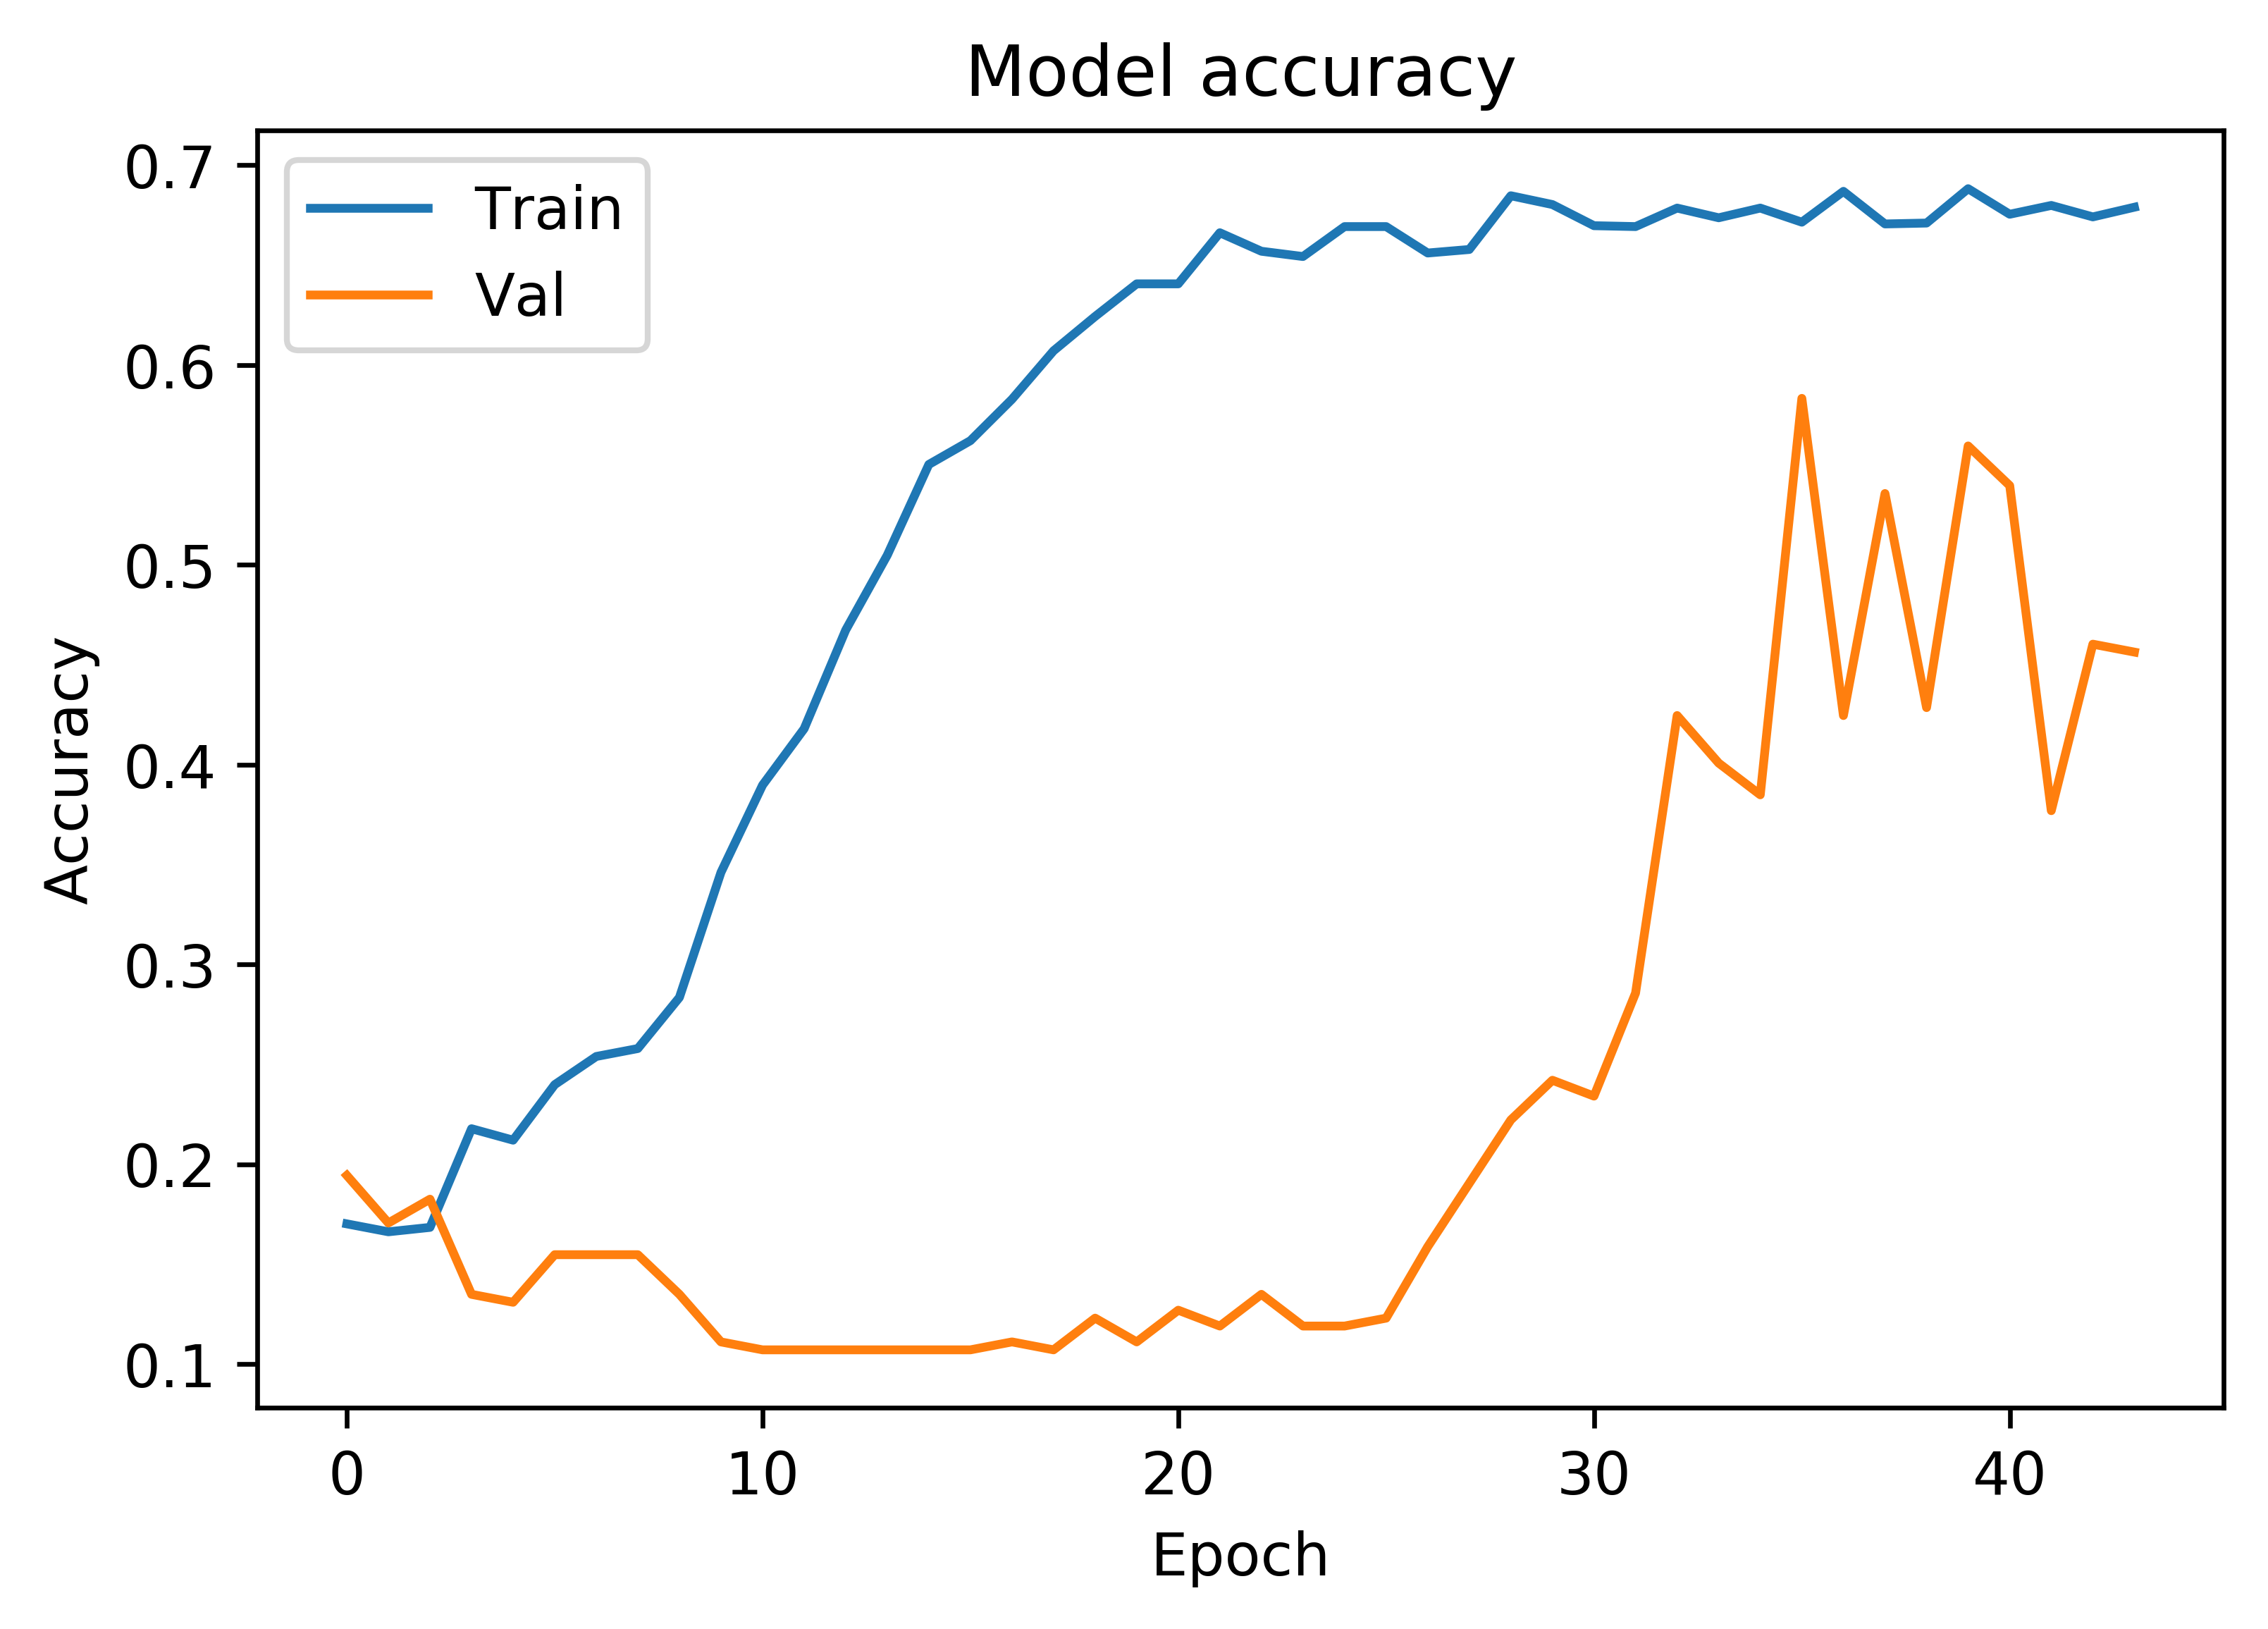

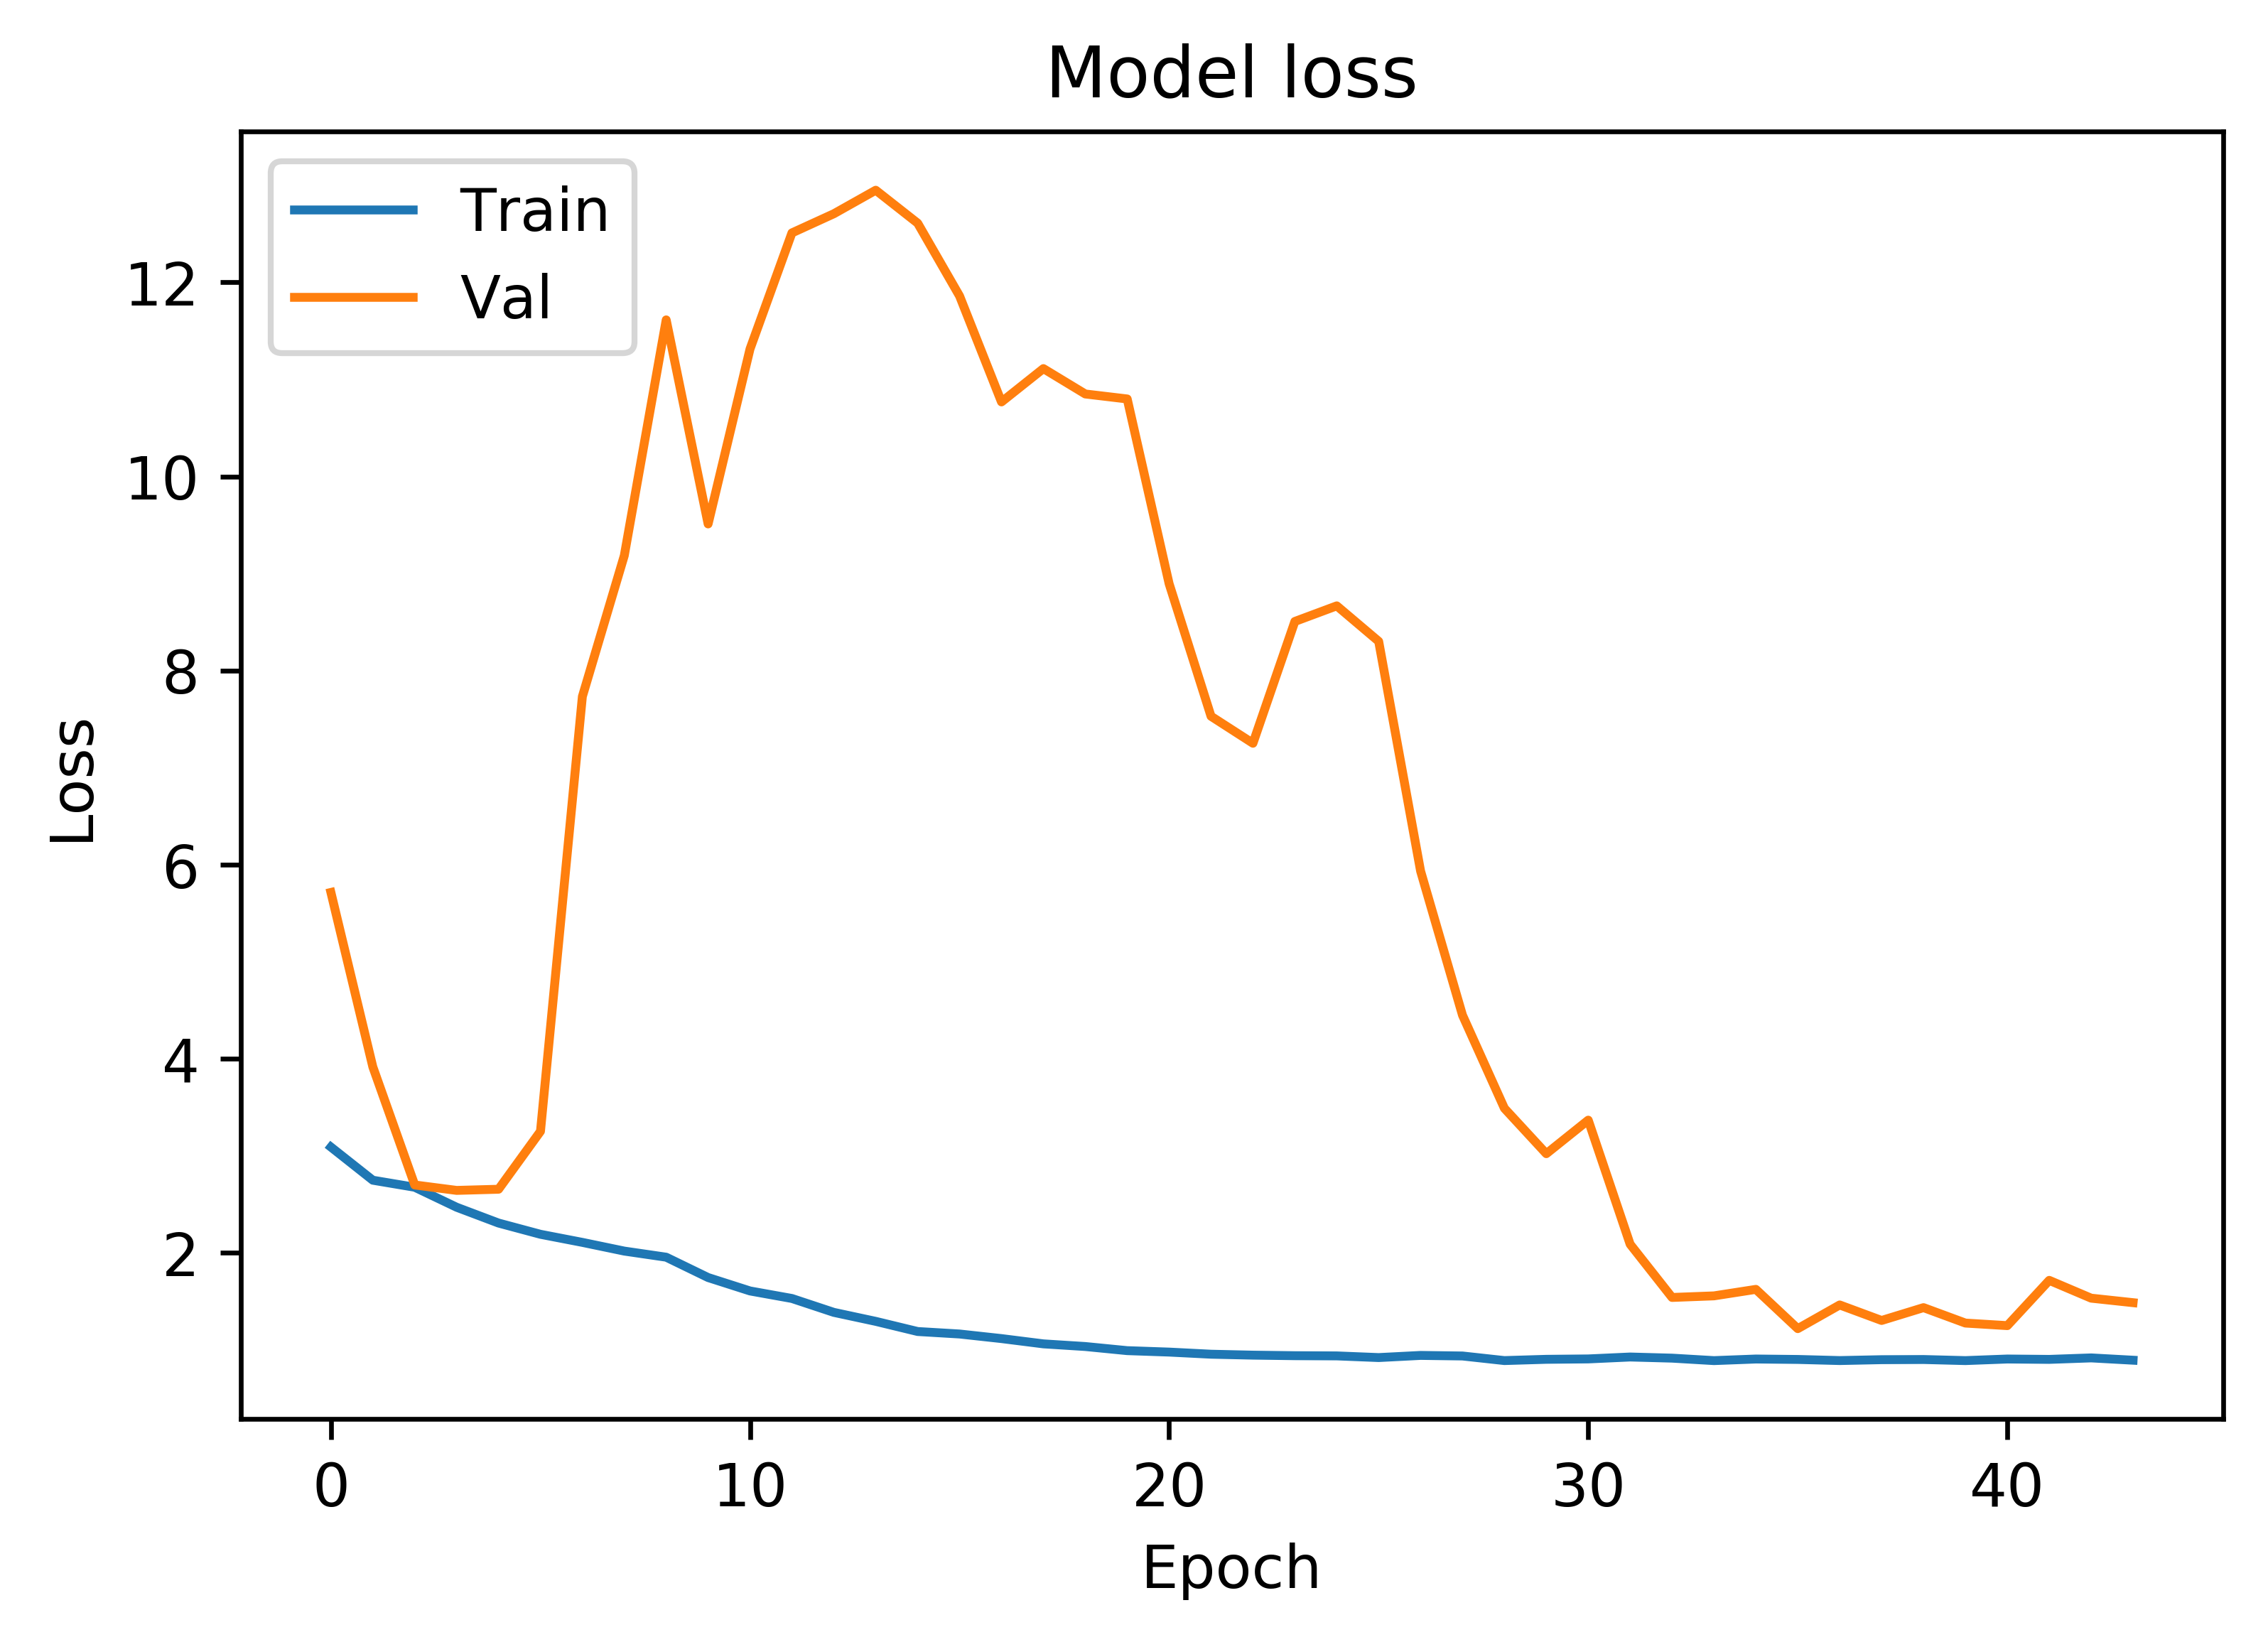

Results from K-fold: 5
acc: 43.59%
624/624 [==============================] - 1s 1ms/step
[1.684973304088299, 0.4358974358974359]
           bar  gel  network  plot  histology  sequence  line  molecular
bar         58    6        0     2         10         2     0          0
gel         17   48        0     0         11         1     1          0
network     28    0       12     0         35         0     0          3
plot        47    2        0    24          4         1     0          0
histology   22    0        0     0         55         1     0          0
sequence    25    2        0     2          2        39     0          8
line        54    7        0     0          8         1     8          0
molecular   29    0        1     0         20         0     0         28
              precision    recall  f1-score   support

         bar       0.21      0.74      0.32        78
         gel       0.74      0.62      0.67        78
     network       0.92      0.15      0.26       

In [14]:
#set K folds to 5
cvscores = []
count = 1
confusion_matrix_list = []
report_list = []

for key, val in kfolds.items():
    print(key)
    train = val['train']
    test = val['test']
    
    print('K-: {}'.format(key))
            
    print("Samples from Training")
    print_samples(samples=train, text=X_text, tokenizer=tokenizer)
    print("============================")
    
    print("Samples from Testing")
    print_samples(samples=test, text=X_text, tokenizer=tokenizer)
    print("============================")
    
    text_model = Generate_Model(model_type = "text_2d")
    text_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    filepath="unimodal_weights/best_weight_text_2d_only_k-fold_{}.hdf5".format(count)
    checkpoint = MultiGPUCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [reduce_lr, checkpoint, early_stopping]

    history = text_model.fit([X_text[train]], y[train], 
                     epochs=epochs, batch_size=bs, validation_split=0.1, callbacks=callbacks_list)
    plot_model_history(history)
    filepath="unimodal_weights/final_weight_text_2d_only_k-fold_{}.hdf5".format(count)
    text_model.save_weights(filepath)
    scores = text_model.evaluate([X_text[test]], y[test], verbose=0)
    print('Results from K-fold: {}'.format(count))
    print("%s: %.2f%%" % (image_model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
    y_hat = test_model(text_model, zip(X_text[test], y[test]), image = False, text = True, 
                       class_names=class_names)
    cm = confusion_matrix([np.argmax(t) for t in y[test]], y_hat)
    confusion_matrix_list.append(pd.DataFrame(cm, index=class_names, columns=class_names))
    cr = classification_report([np.argmax(t) for t in y[test]], y_hat, target_names=class_names)
    report_list.append(classification_report_df(cr))
    count += 1
    print('================================================')
print('Average for kfold accuracy and stdev')
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
print("Average classification report for all folds")
print(df_mean(report_list))